In [ ]:
!pip install git+https://github.com/Hitesh1309/atomai@master # install the latest version from source

In [ ]:
!pip install pymatgen

In [ ]:
!pip install gdown

In [36]:
# Import necessary libraries
import argparse
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader as torch_DataLoader
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import random
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import gc

In [37]:
# Import custom modules from Mat2Spec (these should be available in your environment)
from Mat2Spec.data import *
from Mat2Spec.Mat2Spec import *
from Mat2Spec.file_setter import use_property
from Mat2Spec.utils import *

In [38]:
# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.autograd.set_detect_anomaly(True)

In [39]:
# Define arguments
class Args:
    label_scaling = 'standardized'
    num_layers = 3
    num_neurons = 128
    num_heads = 4
    concat_comp = False
    train_size = 0.8
    trainset_subset_ratio = 1.0
    use_catached_data = True
    train = True
    num_epochs = 750
    batch_size = 8
    lr = 0.00001
    Mat2Spec_input_dim = 128
    Mat2Spec_label_dim = 2048
    Mat2Spec_latent_dim = 128
    Mat2Spec_emb_size = 512
    Mat2Spec_keep_prob = 0.5
    Mat2Spec_scale_coeff = 1.0
    Mat2Spec_loss_type = 'MSE'
    Mat2Spec_K = 25
    ablation_LE=False
    ablation_CL=False
    finetune = False

args = Args()

In [ ]:
!gdown -O "eels_imspec.npz" https://drive.google.com/uc?id=1BprChho_y-LdVQstR1vYzCxmK677algR

In [40]:
# Data loading and preparation
np_data = np.load('eels_imspec.npz')
imgs = np_data['images']
spectra = np_data['spectra']
NORMALIZER = DATA_normalizer(spectra)
X_train, X_val, y_train, y_val = train_test_split(imgs, spectra, test_size=0.15, random_state=1)

In [41]:
# Custom Dataset
class CustomDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]

train_dataset = CustomDataset(X_train, y_train)
val_dataset = CustomDataset(X_val, y_val)

In [42]:
# DataLoaders
train_loader = torch_DataLoader(dataset=train_dataset, batch_size=args.batch_size, shuffle=True)
valid_loader = torch_DataLoader(dataset=val_dataset, batch_size=args.batch_size, shuffle=False)

In [43]:
# Model setup
print(f'> USING MODEL Mat2Spec!')
the_network = Mat2Spec(args, NORMALIZER)
net = the_network.to(device)

> USING MODEL Mat2Spec!


In [44]:
# Loss, optimizer, and scheduler
optimizer = optim.AdamW(net.parameters(), lr=args.lr, weight_decay=1e-2)
scheduler = lr_scheduler.StepLR(optimizer, step_size=len(train_loader) * (args.num_epochs // 4), gamma=0.5)

In [45]:
print(f'> TRAINING MODEL ...')
training_counter=0
training_loss=0
valid_counter=0
valid_loss=0
best_valid_loss=1e+10
check_fre = 10
current_step = 0

total_loss_smooth = 0
nll_loss_smooth = 0
nll_loss_x_smooth = 0
kl_loss_smooth = 0
cpc_loss_smooth = 0
prediction = []
prediction_x = []
label_gt = []
label_scale_value = []
sum_pred_smooth = 0
mse = 0

start_time = time.time()
for epoch in range(args.num_epochs):

    # TRAINING-STAGE
    net.train()
    args.train = True
    for data, label in tqdm(train_loader, mininterval=0.5, desc=f'(EPOCH:{epoch} TRAINING)', position=0, leave=True, ascii=True):
        current_step += 1
        # print(type(data))
        # data = data.to(device)
        # train_label = deepcopy(data.y).to(device)
        data, train_label = data.to(device, dtype=torch.float), label.to(device, dtype=torch.float)
        if args.label_scaling == 'standardized':
            train_label_normalize = (train_label - NORMALIZER.mean.to(device)) / NORMALIZER.std.to(device)
        elif args.label_scaling == 'normalized_max':
            train_label_normalize = train_label / (torch.max(train_label,dim=1)[0].unsqueeze(1))
        elif args.label_scaling == 'normalized_sum':
            train_label_normalize = train_label / torch.sum(train_label, dim=1, keepdim=True)

        # torch.backends.cudnn.enabled = False  # for solving the CUDNN_STATUS_MAPPING_ERROR

        predictions = net(data, train_label)
        total_loss, nll_loss, nll_loss_x, kl_loss, c_loss, pred_e, pred_x = \
            compute_loss(train_label_normalize, predictions, NORMALIZER, args)

        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()
        scheduler.step()

        prediction.append(pred_e.detach().cpu().numpy())
        prediction_x.append(pred_x.detach().cpu().numpy())
        label_gt.append(train_label.detach().cpu().numpy())

        total_loss_smooth += total_loss
        nll_loss_smooth += nll_loss
        nll_loss_x_smooth += nll_loss_x
        kl_loss_smooth += kl_loss
        cpc_loss_smooth += c_loss
        training_counter +=1

    total_loss_smooth = total_loss_smooth / training_counter
    nll_loss_smooth = nll_loss_smooth / training_counter
    nll_loss_x_smooth = nll_loss_x_smooth / training_counter
    kl_loss_smooth = kl_loss_smooth / training_counter
    cpc_loss_smooth = cpc_loss_smooth / training_counter

    prediction = np.concatenate(prediction, axis=0)
    prediction_x = np.concatenate(prediction_x, axis=0)
    label_gt = np.concatenate(label_gt, axis=0)

    if args.label_scaling == 'standardized':
        mean = NORMALIZER.mean.detach().numpy()
        std = NORMALIZER.std.detach().numpy()
        label_gt_standardized = (label_gt-mean)/std
        mae = np.mean(np.abs((prediction)-label_gt_standardized))
        mae_x = np.mean(np.abs((prediction_x)-label_gt_standardized))
        prediction = prediction*std+mean
        prediction_x = prediction_x*std+mean
        prediction[prediction < 0] = 0
        prediction_x[prediction_x < 0] = 0
        mae_ori = np.mean(np.abs((prediction)-label_gt))
        mae_x_ori = np.mean(np.abs((prediction_x)-label_gt))

    elif args.label_scaling == 'normalized_max':
        label_max = np.expand_dims(np.max(label_gt, axis=1), axis=1)
        label_gt_standardized = label_gt / label_max
        mae = np.mean(np.abs((prediction)-label_gt_standardized))
        mae_x = np.mean(np.abs((prediction_x)-label_gt_standardized))
        prediction = prediction*label_max
        prediction_x = prediction_x*label_max
        mae_ori = np.mean(np.abs((prediction)-label_gt))
        mae_x_ori = np.mean(np.abs((prediction_x)-label_gt))

    elif args.label_scaling == 'normalized_sum':
        assert args.Mat2Spec_loss_type == 'KL' or args.Mat2Spec_loss_type == 'WD'
        label_sum = np.sum(label_gt, axis=1, keepdims=True)
        label_gt_standardized = label_gt / label_sum
        mae = np.mean(np.abs((prediction)-label_gt_standardized))
        mae_x = np.mean(np.abs((prediction_x)-label_gt_standardized))
        prediction = prediction*label_sum
        prediction_x = prediction_x*label_sum
        mae_ori = np.mean(np.abs((prediction)-label_gt))
        mae_x_ori = np.mean(np.abs((prediction_x)-label_gt))

    mse = ((prediction - label_gt) ** 2).mean()

    print("\n********** TRAINING STATISTIC ***********")
    print("total_loss =%.6f\t nll_loss =%.6f\t nll_loss_x =%.6f\t kl_loss =%.6f\t cpc_loss=%.6f\t" %
          (total_loss_smooth, nll_loss_smooth, nll_loss_x_smooth, kl_loss_smooth, cpc_loss_smooth))
    print("mse=%.6f\tmae=%.6f\t mae_x=%.6f\t mae_ori=%.6f\t mae_x_ori=%.6f" % (mse,mae, mae_x, mae_ori, mae_x_ori))
    print("\n*****************************************")

    training_counter = 0
    total_loss_smooth = 0
    nll_loss_smooth = 0
    nll_loss_x_smooth = 0
    kl_loss_smooth = 0
    cpc_loss_smooth = 0
    prediction = []
    prediction_x = []
    label_gt = []
    label_scale_value = []
    sum_pred_smooth = 0

    # VALIDATION-PHASE
    net.eval()
    for data, label in tqdm(valid_loader, mininterval=0.5, desc='(validating)', position=0, leave=True, ascii=True):
        data, valid_label = data.to(device, dtype=torch.float), label.to(device, dtype=torch.float)

        if args.label_scaling == 'standardized':
            valid_label_normalize = (valid_label - NORMALIZER.mean.to(device)) / NORMALIZER.std.to(device)
        elif args.label_scaling == 'normalized_max':
            valid_label_normalize = valid_label/(torch.max(valid_label,dim=1)[0].unsqueeze(1))

        elif args.label_scaling == 'normalized_sum':
            valid_label_normalize = valid_label / (torch.sum(valid_label, dim=1, keepdim=True)+1e-8)

        with torch.no_grad():
            predictions = net(data, valid_label)
            total_loss, nll_loss, nll_loss_x, kl_loss, cpc_loss, pred_e, pred_x = \
                compute_loss(valid_label_normalize, predictions, NORMALIZER, args)

        prediction.append(pred_e.detach().cpu().numpy())
        prediction_x.append(pred_x.detach().cpu().numpy())
        label_gt.append(valid_label.detach().cpu().numpy())

        total_loss_smooth += total_loss
        nll_loss_smooth += nll_loss
        nll_loss_x_smooth += nll_loss_x
        kl_loss_smooth += kl_loss
        cpc_loss_smooth += cpc_loss
        valid_counter += 1

    total_loss_smooth = total_loss_smooth / valid_counter
    nll_loss_smooth = nll_loss_smooth / valid_counter
    nll_loss_x_smooth = nll_loss_x_smooth / valid_counter
    kl_loss_smooth = kl_loss_smooth / valid_counter
    cpc_loss_smooth = cpc_loss_smooth / valid_counter

    prediction = np.concatenate(prediction, axis=0)
    prediction_x = np.concatenate(prediction_x, axis=0)
    label_gt = np.concatenate(label_gt, axis=0)

    if args.label_scaling == 'standardized':
        mean = NORMALIZER.mean.detach().numpy()
        std = NORMALIZER.std.detach().numpy()
        label_gt_standardized = (label_gt-mean)/std
        mae = np.mean(np.abs((prediction)-label_gt_standardized))
        mae_x = np.mean(np.abs((prediction_x)-label_gt_standardized))
        prediction = prediction*std+mean
        prediction_x = prediction_x*std+mean
        prediction[prediction < 0] = 0
        prediction_x[prediction_x < 0] = 0
        mae_ori = np.mean(np.abs((prediction)-label_gt))
        mae_x_ori = np.mean(np.abs((prediction_x)-label_gt))

    elif args.label_scaling == 'normalized_max':
        label_max = np.expand_dims(np.max(label_gt, axis=1), axis=1)
        label_gt_standardized = label_gt / label_max
        mae = np.mean(np.abs((prediction)-label_gt_standardized))
        mae_x = np.mean(np.abs((prediction_x)-label_gt_standardized))
        prediction = prediction*label_max
        prediction_x = prediction_x*label_max
        mae_ori = np.mean(np.abs((prediction)-label_gt))
        mae_x_ori = np.mean(np.abs((prediction_x)-label_gt))

    elif args.label_scaling == 'normalized_sum':
        assert args.Mat2Spec_loss_type == 'KL' or args.Mat2Spec_loss_type == 'WD'
        label_sum = np.sum(label_gt, axis=1, keepdims=True)
        label_gt_standardized = label_gt / label_sum
        mae = np.mean(np.abs((prediction)-label_gt_standardized))
        mae_x = np.mean(np.abs((prediction_x)-label_gt_standardized))
        prediction = prediction*label_sum
        prediction_x = prediction_x*label_sum
        mae_ori = np.mean(np.abs((prediction)-label_gt))
        mae_x_ori = np.mean(np.abs((prediction_x)-label_gt))

    mse = ((prediction - label_gt) ** 2).mean()

    print("\n********** VALIDATING STATISTIC ***********")
    print("total_loss =%.6f\t nll_loss =%.6f\t nll_loss_x =%.6f\t kl_loss =%.6f\t cpc_loss = %.6f\t" %
          (total_loss_smooth, nll_loss_smooth, nll_loss_x_smooth, kl_loss_smooth, cpc_loss_smooth))
    print("mse=%.6f\tmae=%.6f\t mae_x=%.6f\t mae_ori=%.6f\t mae_x_ori=%.6f" % (mse,mae, mae_x, mae_ori, mae_x_ori))
    print("\n*****************************************")

    if best_valid_loss > mae_x_ori:
        best_valid_loss = mae_x_ori
        print("\n********** SAVING MODEL ***********")
        checkpoint = {'model': net.state_dict(), 'args': args}
        if not args.finetune:
            #checkpoint_path = './TRAINED/'
            save_path = './TRAINED_latest/model_Mat2Spec_'  + '_' + args.label_scaling + '_' \
                        + args.Mat2Spec_loss_type + '_lr' + str(args.lr)
        else:
            save_path = './TRAINED/finetune/model_Mat2Spec_'  + '_' + args.label_scaling + '_' \
                        + args.Mat2Spec_loss_type + '_finetune_' + str(args.finetune_dataset)

        if args.ablation_LE:
            save_path = save_path + '_ablation_LE'

        if args.ablation_CL:
            save_path = save_path + '_ablation_CL'

        save_path = save_path + '.chkpt'
        torch.save(checkpoint, save_path)
        print("A new model has been saved to " + save_path)
        print("\n*****************************************")

    valid_counter=0
    total_loss_smooth = 0
    nll_loss_smooth = 0
    nll_loss_x_smooth = 0
    kl_loss_smooth = 0
    cpc_loss_smooth = 0
    prediction = []
    prediction_x = []
    label_gt = []
    label_scale_value = []
    sum_pred_smooth = 0
    gc.collect()

end_time = time.time()
e_time = end_time - start_time
print('Best validation loss=%.6f, training time (min)=%.6f'%(best_valid_loss, e_time/60))
print(f"> DONE TRAINING !")

> TRAINING MODEL ...


(EPOCH:0 TRAINING):   0%|          | 0/289 [00:00<?, ?it/s]

(EPOCH:0 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.80it/s]



********** TRAINING STATISTIC ***********
total_loss =2.424438	 nll_loss =0.989871	 nll_loss_x =0.989924	 kl_loss =0.227930	 cpc_loss=1.939212	
mse=0.002446	mae=0.795566	 mae_x=0.795550	 mae_ori=0.029610	 mae_x_ori=0.029607

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.66it/s]



********** VALIDATING STATISTIC ***********
total_loss =2.464946	 nll_loss =1.059201	 nll_loss_x =1.059260	 kl_loss =0.138083	 cpc_loss = 1.945929	
mse=0.002747	mae=0.824016	 mae_x=0.824008	 mae_ori=0.031216	 mae_x_ori=0.031214

*****************************************

********** SAVING MODEL ***********
A new model has been saved to ./TRAINED_latest/model_Mat2Spec__standardized_MSE_lr1e-05.chkpt

*****************************************


(EPOCH:1 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.80it/s]



********** TRAINING STATISTIC ***********
total_loss =2.303179	 nll_loss =0.991224	 nll_loss_x =0.991264	 kl_loss =0.115247	 cpc_loss=1.939193	
mse=0.002445	mae=0.795506	 mae_x=0.795476	 mae_ori=0.029606	 mae_x_ori=0.029602

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.68it/s]



********** VALIDATING STATISTIC ***********
total_loss =2.362960	 nll_loss =1.059264	 nll_loss_x =1.059318	 kl_loss =0.045261	 cpc_loss = 1.945901	
mse=0.002747	mae=0.823960	 mae_x=0.823932	 mae_ori=0.031212	 mae_x_ori=0.031209

*****************************************

********** SAVING MODEL ***********
A new model has been saved to ./TRAINED_latest/model_Mat2Spec__standardized_MSE_lr1e-05.chkpt

*****************************************


(EPOCH:2 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.79it/s]



********** TRAINING STATISTIC ***********
total_loss =2.242439	 nll_loss =0.989631	 nll_loss_x =0.989678	 kl_loss =0.062927	 cpc_loss=1.939106	
mse=0.002445	mae=0.795351	 mae_x=0.795299	 mae_ori=0.029595	 mae_x_ori=0.029590

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.72it/s]



********** VALIDATING STATISTIC ***********
total_loss =2.332163	 nll_loss =1.059299	 nll_loss_x =1.059449	 kl_loss =0.017140	 cpc_loss = 1.945604	
mse=0.002748	mae=0.823827	 mae_x=0.823799	 mae_ori=0.031202	 mae_x_ori=0.031199

*****************************************

********** SAVING MODEL ***********
A new model has been saved to ./TRAINED_latest/model_Mat2Spec__standardized_MSE_lr1e-05.chkpt

*****************************************


(EPOCH:3 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.80it/s]



********** TRAINING STATISTIC ***********
total_loss =2.196059	 nll_loss =0.986742	 nll_loss_x =0.987036	 kl_loss =0.042859	 cpc_loss=1.751366	
mse=0.002424	mae=0.793299	 mae_x=0.793385	 mae_ori=0.029444	 mae_x_ori=0.029449

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 39.17it/s]



********** VALIDATING STATISTIC ***********
total_loss =2.236135	 nll_loss =1.038709	 nll_loss_x =1.039850	 kl_loss =0.009362	 cpc_loss = 1.472785	
mse=0.002624	mae=0.810228	 mae_x=0.810787	 mae_ori=0.030215	 mae_x_ori=0.030255

*****************************************

********** SAVING MODEL ***********
A new model has been saved to ./TRAINED_latest/model_Mat2Spec__standardized_MSE_lr1e-05.chkpt

*****************************************


(EPOCH:4 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.80it/s]



********** TRAINING STATISTIC ***********
total_loss =1.953539	 nll_loss =0.888783	 nll_loss_x =0.889411	 kl_loss =0.033238	 cpc_loss=1.387822	
mse=0.001828	mae=0.740720	 mae_x=0.741234	 mae_ori=0.025613	 mae_x_ori=0.025651

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.28it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.868931	 nll_loss =0.864917	 nll_loss_x =0.865459	 kl_loss =0.006099	 cpc_loss = 1.318460	
mse=0.001566	mae=0.726161	 mae_x=0.726703	 mae_ori=0.024242	 mae_x_ori=0.024281

*****************************************

********** SAVING MODEL ***********
A new model has been saved to ./TRAINED_latest/model_Mat2Spec__standardized_MSE_lr1e-05.chkpt

*****************************************


(EPOCH:5 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.78it/s]



********** TRAINING STATISTIC ***********
total_loss =1.796794	 nll_loss =0.816447	 nll_loss_x =0.816984	 kl_loss =0.026320	 cpc_loss=1.344108	
mse=0.001383	mae=0.701256	 mae_x=0.701814	 mae_ori=0.022810	 mae_x_ori=0.022852

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.31it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.811990	 nll_loss =0.838945	 nll_loss_x =0.839231	 kl_loss =0.003877	 cpc_loss = 1.295505	
mse=0.001415	mae=0.711585	 mae_x=0.712072	 mae_ori=0.023195	 mae_x_ori=0.023231

*****************************************

********** SAVING MODEL ***********
A new model has been saved to ./TRAINED_latest/model_Mat2Spec__standardized_MSE_lr1e-05.chkpt

*****************************************


(EPOCH:6 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.79it/s]



********** TRAINING STATISTIC ***********
total_loss =1.733779	 nll_loss =0.789745	 nll_loss_x =0.790519	 kl_loss =0.021839	 cpc_loss=1.294920	
mse=0.001239	mae=0.686529	 mae_x=0.687144	 mae_ori=0.021789	 mae_x_ori=0.021833

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.68it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.771623	 nll_loss =0.819789	 nll_loss_x =0.820221	 kl_loss =0.002789	 cpc_loss = 1.285457	
mse=0.001316	mae=0.695672	 mae_x=0.696118	 mae_ori=0.022101	 mae_x_ori=0.022130

*****************************************

********** SAVING MODEL ***********
A new model has been saved to ./TRAINED_latest/model_Mat2Spec__standardized_MSE_lr1e-05.chkpt

*****************************************


(EPOCH:7 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.77it/s]



********** TRAINING STATISTIC ***********
total_loss =1.689545	 nll_loss =0.769945	 nll_loss_x =0.770551	 kl_loss =0.018633	 cpc_loss=1.285524	
mse=0.001140	mae=0.674452	 mae_x=0.674923	 mae_ori=0.021048	 mae_x_ori=0.021080

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.34it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.729203	 nll_loss =0.797945	 nll_loss_x =0.798474	 kl_loss =0.002136	 cpc_loss = 1.304346	
mse=0.001222	mae=0.697094	 mae_x=0.697499	 mae_ori=0.022311	 mae_x_ori=0.022337

*****************************************


(EPOCH:8 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.78it/s]



********** TRAINING STATISTIC ***********
total_loss =1.643057	 nll_loss =0.750028	 nll_loss_x =0.750820	 kl_loss =0.016065	 cpc_loss=1.245358	
mse=0.001059	mae=0.664783	 mae_x=0.665395	 mae_ori=0.020493	 mae_x_ori=0.020533

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.74it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.693464	 nll_loss =0.783756	 nll_loss_x =0.784639	 kl_loss =0.001884	 cpc_loss = 1.229972	
mse=0.001160	mae=0.679547	 mae_x=0.680098	 mae_ori=0.021152	 mae_x_ori=0.021185

*****************************************

********** SAVING MODEL ***********
A new model has been saved to ./TRAINED_latest/model_Mat2Spec__standardized_MSE_lr1e-05.chkpt

*****************************************


(EPOCH:9 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.79it/s]



********** TRAINING STATISTIC ***********
total_loss =1.612566	 nll_loss =0.738252	 nll_loss_x =0.738849	 kl_loss =0.013968	 cpc_loss=1.201006	
mse=0.001021	mae=0.658070	 mae_x=0.658522	 mae_ori=0.020148	 mae_x_ori=0.020176

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.63it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.666139	 nll_loss =0.772143	 nll_loss_x =0.772395	 kl_loss =0.001517	 cpc_loss = 1.199319	
mse=0.001114	mae=0.674096	 mae_x=0.674387	 mae_ori=0.020856	 mae_x_ori=0.020873

*****************************************

********** SAVING MODEL ***********
A new model has been saved to ./TRAINED_latest/model_Mat2Spec__standardized_MSE_lr1e-05.chkpt

*****************************************


(EPOCH:10 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.79it/s]



********** TRAINING STATISTIC ***********
total_loss =1.585859	 nll_loss =0.726783	 nll_loss_x =0.727416	 kl_loss =0.012296	 cpc_loss=1.181351	
mse=0.000984	mae=0.652978	 mae_x=0.653452	 mae_ori=0.019882	 mae_x_ori=0.019911

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.56it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.639202	 nll_loss =0.759710	 nll_loss_x =0.760248	 kl_loss =0.001233	 cpc_loss = 1.178868	
mse=0.001072	mae=0.672609	 mae_x=0.672997	 mae_ori=0.020806	 mae_x_ori=0.020828

*****************************************

********** SAVING MODEL ***********
A new model has been saved to ./TRAINED_latest/model_Mat2Spec__standardized_MSE_lr1e-05.chkpt

*****************************************


(EPOCH:11 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.76it/s]



********** TRAINING STATISTIC ***********
total_loss =1.567531	 nll_loss =0.719302	 nll_loss_x =0.719868	 kl_loss =0.010788	 cpc_loss=1.164931	
mse=0.000960	mae=0.649537	 mae_x=0.649979	 mae_ori=0.019691	 mae_x_ori=0.019718

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.73it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.629846	 nll_loss =0.755530	 nll_loss_x =0.755928	 kl_loss =0.001049	 cpc_loss = 1.172356	
mse=0.001056	mae=0.665982	 mae_x=0.666296	 mae_ori=0.020379	 mae_x_ori=0.020398

*****************************************

********** SAVING MODEL ***********
A new model has been saved to ./TRAINED_latest/model_Mat2Spec__standardized_MSE_lr1e-05.chkpt

*****************************************


(EPOCH:12 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.77it/s]



********** TRAINING STATISTIC ***********
total_loss =1.547653	 nll_loss =0.710545	 nll_loss_x =0.711165	 kl_loss =0.009652	 cpc_loss=1.153258	
mse=0.000927	mae=0.644901	 mae_x=0.645366	 mae_ori=0.019421	 mae_x_ori=0.019450

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.30it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.610755	 nll_loss =0.746261	 nll_loss_x =0.746318	 kl_loss =0.000783	 cpc_loss = 1.173145	
mse=0.001033	mae=0.660833	 mae_x=0.661041	 mae_ori=0.020110	 mae_x_ori=0.020121

*****************************************

********** SAVING MODEL ***********
A new model has been saved to ./TRAINED_latest/model_Mat2Spec__standardized_MSE_lr1e-05.chkpt

*****************************************


(EPOCH:13 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.78it/s]



********** TRAINING STATISTIC ***********
total_loss =1.525717	 nll_loss =0.699738	 nll_loss_x =0.700406	 kl_loss =0.008570	 cpc_loss=1.161463	
mse=0.000893	mae=0.639871	 mae_x=0.640409	 mae_ori=0.019138	 mae_x_ori=0.019170

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.62it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.574729	 nll_loss =0.728415	 nll_loss_x =0.728175	 kl_loss =0.000802	 cpc_loss = 1.172577	
mse=0.000975	mae=0.654458	 mae_x=0.654559	 mae_ori=0.019786	 mae_x_ori=0.019793

*****************************************

********** SAVING MODEL ***********
A new model has been saved to ./TRAINED_latest/model_Mat2Spec__standardized_MSE_lr1e-05.chkpt

*****************************************


(EPOCH:14 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.78it/s]



********** TRAINING STATISTIC ***********
total_loss =1.498586	 nll_loss =0.687184	 nll_loss_x =0.687997	 kl_loss =0.007674	 cpc_loss=1.149637	
mse=0.000861	mae=0.634004	 mae_x=0.634614	 mae_ori=0.018840	 mae_x_ori=0.018877

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.52it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.532473	 nll_loss =0.706548	 nll_loss_x =0.708063	 kl_loss =0.000771	 cpc_loss = 1.170142	
mse=0.000919	mae=0.644687	 mae_x=0.645602	 mae_ori=0.019326	 mae_x_ori=0.019382

*****************************************

********** SAVING MODEL ***********
A new model has been saved to ./TRAINED_latest/model_Mat2Spec__standardized_MSE_lr1e-05.chkpt

*****************************************


(EPOCH:15 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.78it/s]



********** TRAINING STATISTIC ***********
total_loss =1.460664	 nll_loss =0.668456	 nll_loss_x =0.669058	 kl_loss =0.006890	 cpc_loss=1.155716	
mse=0.000809	mae=0.623767	 mae_x=0.624259	 mae_ori=0.018323	 mae_x_ori=0.018352

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.33it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.480814	 nll_loss =0.681275	 nll_loss_x =0.682050	 kl_loss =0.000714	 cpc_loss = 1.167036	
mse=0.000855	mae=0.631158	 mae_x=0.631776	 mae_ori=0.018708	 mae_x_ori=0.018747

*****************************************

********** SAVING MODEL ***********
A new model has been saved to ./TRAINED_latest/model_Mat2Spec__standardized_MSE_lr1e-05.chkpt

*****************************************


(EPOCH:16 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.77it/s]



********** TRAINING STATISTIC ***********
total_loss =1.424656	 nll_loss =0.651366	 nll_loss_x =0.651845	 kl_loss =0.006126	 cpc_loss=1.147056	
mse=0.000761	mae=0.613833	 mae_x=0.614285	 mae_ori=0.017835	 mae_x_ori=0.017862

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.15it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.452215	 nll_loss =0.667369	 nll_loss_x =0.667822	 kl_loss =0.000594	 cpc_loss = 1.163714	
mse=0.000814	mae=0.620814	 mae_x=0.621174	 mae_ori=0.018176	 mae_x_ori=0.018201

*****************************************

********** SAVING MODEL ***********
A new model has been saved to ./TRAINED_latest/model_Mat2Spec__standardized_MSE_lr1e-05.chkpt

*****************************************


(EPOCH:17 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.80it/s]



********** TRAINING STATISTIC ***********
total_loss =1.407912	 nll_loss =0.643579	 nll_loss_x =0.643892	 kl_loss =0.005467	 cpc_loss=1.144278	
mse=0.000731	mae=0.607239	 mae_x=0.607575	 mae_ori=0.017478	 mae_x_ori=0.017499

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.75it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.429917	 nll_loss =0.656347	 nll_loss_x =0.656927	 kl_loss =0.000396	 cpc_loss = 1.162078	
mse=0.000777	mae=0.617152	 mae_x=0.617792	 mae_ori=0.018011	 mae_x_ori=0.018048

*****************************************

********** SAVING MODEL ***********
A new model has been saved to ./TRAINED_latest/model_Mat2Spec__standardized_MSE_lr1e-05.chkpt

*****************************************


(EPOCH:18 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.79it/s]



********** TRAINING STATISTIC ***********
total_loss =1.387584	 nll_loss =0.633632	 nll_loss_x =0.634073	 kl_loss =0.004841	 cpc_loss=1.145537	
mse=0.000698	mae=0.601795	 mae_x=0.602199	 mae_ori=0.017163	 mae_x_ori=0.017188

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.69it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.421175	 nll_loss =0.652936	 nll_loss_x =0.652700	 kl_loss =0.000346	 cpc_loss = 1.151586	
mse=0.000762	mae=0.612489	 mae_x=0.612554	 mae_ori=0.017694	 mae_x_ori=0.017701

*****************************************

********** SAVING MODEL ***********
A new model has been saved to ./TRAINED_latest/model_Mat2Spec__standardized_MSE_lr1e-05.chkpt

*****************************************


(EPOCH:19 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.79it/s]



********** TRAINING STATISTIC ***********
total_loss =1.372381	 nll_loss =0.627770	 nll_loss_x =0.628097	 kl_loss =0.004331	 cpc_loss=1.117501	
mse=0.000676	mae=0.597881	 mae_x=0.598299	 mae_ori=0.016935	 mae_x_ori=0.016960

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.67it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.399446	 nll_loss =0.641385	 nll_loss_x =0.642529	 kl_loss =0.000288	 cpc_loss = 1.152143	
mse=0.000719	mae=0.608386	 mae_x=0.609133	 mae_ori=0.017493	 mae_x_ori=0.017533

*****************************************

********** SAVING MODEL ***********
A new model has been saved to ./TRAINED_latest/model_Mat2Spec__standardized_MSE_lr1e-05.chkpt

*****************************************


(EPOCH:20 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.79it/s]



********** TRAINING STATISTIC ***********
total_loss =1.360682	 nll_loss =0.621539	 nll_loss_x =0.622110	 kl_loss =0.003882	 cpc_loss=1.127621	
mse=0.000652	mae=0.594345	 mae_x=0.594869	 mae_ori=0.016730	 mae_x_ori=0.016764

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.89it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.391580	 nll_loss =0.638513	 nll_loss_x =0.638296	 kl_loss =0.000231	 cpc_loss = 1.145170	
mse=0.000708	mae=0.601430	 mae_x=0.601561	 mae_ori=0.017062	 mae_x_ori=0.017071

*****************************************

********** SAVING MODEL ***********
A new model has been saved to ./TRAINED_latest/model_Mat2Spec__standardized_MSE_lr1e-05.chkpt

*****************************************


(EPOCH:21 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.77it/s]



********** TRAINING STATISTIC ***********
total_loss =1.348204	 nll_loss =0.615324	 nll_loss_x =0.615558	 kl_loss =0.003469	 cpc_loss=1.135060	
mse=0.000627	mae=0.590247	 mae_x=0.590616	 mae_ori=0.016480	 mae_x_ori=0.016502

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.40it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.371138	 nll_loss =0.628400	 nll_loss_x =0.629178	 kl_loss =0.000202	 cpc_loss = 1.133384	
mse=0.000671	mae=0.598163	 mae_x=0.598876	 mae_ori=0.016896	 mae_x_ori=0.016943

*****************************************

********** SAVING MODEL ***********
A new model has been saved to ./TRAINED_latest/model_Mat2Spec__standardized_MSE_lr1e-05.chkpt

*****************************************


(EPOCH:22 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.79it/s]



********** TRAINING STATISTIC ***********
total_loss =1.344422	 nll_loss =0.613988	 nll_loss_x =0.614872	 kl_loss =0.003109	 cpc_loss=1.121430	
mse=0.000618	mae=0.588103	 mae_x=0.588819	 mae_ori=0.016359	 mae_x_ori=0.016402

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.66it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.368068	 nll_loss =0.626692	 nll_loss_x =0.626955	 kl_loss =0.000141	 cpc_loss = 1.142666	
mse=0.000671	mae=0.601221	 mae_x=0.601585	 mae_ori=0.017137	 mae_x_ori=0.017161

*****************************************


(EPOCH:23 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.77it/s]



********** TRAINING STATISTIC ***********
total_loss =1.331999	 nll_loss =0.608581	 nll_loss_x =0.609179	 kl_loss =0.002791	 cpc_loss=1.111676	
mse=0.000599	mae=0.585260	 mae_x=0.585762	 mae_ori=0.016194	 mae_x_ori=0.016223

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.55it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.347718	 nll_loss =0.617677	 nll_loss_x =0.618233	 kl_loss =0.000186	 cpc_loss = 1.116044	
mse=0.000631	mae=0.591623	 mae_x=0.592120	 mae_ori=0.016535	 mae_x_ori=0.016567

*****************************************

********** SAVING MODEL ***********
A new model has been saved to ./TRAINED_latest/model_Mat2Spec__standardized_MSE_lr1e-05.chkpt

*****************************************


(EPOCH:24 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.80it/s]



********** TRAINING STATISTIC ***********
total_loss =1.324266	 nll_loss =0.604887	 nll_loss_x =0.605248	 kl_loss =0.002491	 cpc_loss=1.113908	
mse=0.000587	mae=0.582914	 mae_x=0.583312	 mae_ori=0.016055	 mae_x_ori=0.016079

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.32it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.345722	 nll_loss =0.616737	 nll_loss_x =0.617314	 kl_loss =0.000130	 cpc_loss = 1.115278	
mse=0.000629	mae=0.587667	 mae_x=0.588160	 mae_ori=0.016273	 mae_x_ori=0.016305

*****************************************

********** SAVING MODEL ***********
A new model has been saved to ./TRAINED_latest/model_Mat2Spec__standardized_MSE_lr1e-05.chkpt

*****************************************


(EPOCH:25 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.80it/s]



********** TRAINING STATISTIC ***********
total_loss =1.314355	 nll_loss =0.600149	 nll_loss_x =0.600792	 kl_loss =0.002255	 cpc_loss=1.109341	
mse=0.000572	mae=0.580276	 mae_x=0.580901	 mae_ori=0.015901	 mae_x_ori=0.015940

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.58it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.330947	 nll_loss =0.610086	 nll_loss_x =0.610287	 kl_loss =0.000104	 cpc_loss = 1.104606	
mse=0.000607	mae=0.584905	 mae_x=0.585204	 mae_ori=0.016137	 mae_x_ori=0.016154

*****************************************

********** SAVING MODEL ***********
A new model has been saved to ./TRAINED_latest/model_Mat2Spec__standardized_MSE_lr1e-05.chkpt

*****************************************


(EPOCH:26 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.76it/s]



********** TRAINING STATISTIC ***********
total_loss =1.306301	 nll_loss =0.597054	 nll_loss_x =0.597430	 kl_loss =0.002011	 cpc_loss=1.096051	
mse=0.000558	mae=0.577832	 mae_x=0.578254	 mae_ori=0.015752	 mae_x_ori=0.015776

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.59it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.319891	 nll_loss =0.604391	 nll_loss_x =0.604765	 kl_loss =0.000085	 cpc_loss = 1.106422	
mse=0.000585	mae=0.583025	 mae_x=0.583613	 mae_ori=0.016037	 mae_x_ori=0.016074

*****************************************

********** SAVING MODEL ***********
A new model has been saved to ./TRAINED_latest/model_Mat2Spec__standardized_MSE_lr1e-05.chkpt

*****************************************


(EPOCH:27 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.79it/s]



********** TRAINING STATISTIC ***********
total_loss =1.299028	 nll_loss =0.593504	 nll_loss_x =0.594047	 kl_loss =0.001826	 cpc_loss=1.094680	
mse=0.000548	mae=0.575591	 mae_x=0.576105	 mae_ori=0.015635	 mae_x_ori=0.015666

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.67it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.324172	 nll_loss =0.606960	 nll_loss_x =0.607327	 kl_loss =0.000083	 cpc_loss = 1.097932	
mse=0.000595	mae=0.580678	 mae_x=0.581125	 mae_ori=0.015872	 mae_x_ori=0.015899

*****************************************

********** SAVING MODEL ***********
A new model has been saved to ./TRAINED_latest/model_Mat2Spec__standardized_MSE_lr1e-05.chkpt

*****************************************


(EPOCH:28 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.75it/s]



********** TRAINING STATISTIC ***********
total_loss =1.295942	 nll_loss =0.592053	 nll_loss_x =0.592463	 kl_loss =0.001637	 cpc_loss=1.096255	
mse=0.000536	mae=0.573206	 mae_x=0.573590	 mae_ori=0.015489	 mae_x_ori=0.015514

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.63it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.311093	 nll_loss =0.600196	 nll_loss_x =0.600791	 kl_loss =0.000085	 cpc_loss = 1.100124	
mse=0.000571	mae=0.582565	 mae_x=0.583073	 mae_ori=0.016036	 mae_x_ori=0.016066

*****************************************


(EPOCH:29 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.77it/s]



********** TRAINING STATISTIC ***********
total_loss =1.291345	 nll_loss =0.590143	 nll_loss_x =0.590723	 kl_loss =0.001476	 cpc_loss=1.088551	
mse=0.000536	mae=0.573203	 mae_x=0.573734	 mae_ori=0.015498	 mae_x_ori=0.015530

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.63it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.300902	 nll_loss =0.595576	 nll_loss_x =0.595606	 kl_loss =0.000069	 cpc_loss = 1.096436	
mse=0.000554	mae=0.578215	 mae_x=0.578457	 mae_ori=0.015764	 mae_x_ori=0.015778

*****************************************

********** SAVING MODEL ***********
A new model has been saved to ./TRAINED_latest/model_Mat2Spec__standardized_MSE_lr1e-05.chkpt

*****************************************


(EPOCH:30 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.78it/s]



********** TRAINING STATISTIC ***********
total_loss =1.283036	 nll_loss =0.585855	 nll_loss_x =0.586506	 kl_loss =0.001322	 cpc_loss=1.092219	
mse=0.000521	mae=0.570171	 mae_x=0.570740	 mae_ori=0.015317	 mae_x_ori=0.015351

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.78it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.293626	 nll_loss =0.591991	 nll_loss_x =0.592438	 kl_loss =0.000064	 cpc_loss = 1.091269	
mse=0.000545	mae=0.573584	 mae_x=0.573999	 mae_ori=0.015509	 mae_x_ori=0.015531

*****************************************

********** SAVING MODEL ***********
A new model has been saved to ./TRAINED_latest/model_Mat2Spec__standardized_MSE_lr1e-05.chkpt

*****************************************


(EPOCH:31 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.79it/s]



********** TRAINING STATISTIC ***********
total_loss =1.279746	 nll_loss =0.584127	 nll_loss_x =0.584677	 kl_loss =0.001192	 cpc_loss=1.096319	
mse=0.000518	mae=0.569167	 mae_x=0.569692	 mae_ori=0.015279	 mae_x_ori=0.015311

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.56it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.290644	 nll_loss =0.590635	 nll_loss_x =0.591120	 kl_loss =0.000060	 cpc_loss = 1.088228	
mse=0.000539	mae=0.572017	 mae_x=0.572247	 mae_ori=0.015411	 mae_x_ori=0.015419

*****************************************

********** SAVING MODEL ***********
A new model has been saved to ./TRAINED_latest/model_Mat2Spec__standardized_MSE_lr1e-05.chkpt

*****************************************


(EPOCH:32 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.78it/s]



********** TRAINING STATISTIC ***********
total_loss =1.274299	 nll_loss =0.582203	 nll_loss_x =0.582771	 kl_loss =0.001062	 cpc_loss=1.081555	
mse=0.000510	mae=0.567986	 mae_x=0.568520	 mae_ori=0.015212	 mae_x_ori=0.015244

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.53it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.283324	 nll_loss =0.587006	 nll_loss_x =0.587365	 kl_loss =0.000065	 cpc_loss = 1.088812	
mse=0.000528	mae=0.570579	 mae_x=0.570875	 mae_ori=0.015347	 mae_x_ori=0.015363

*****************************************

********** SAVING MODEL ***********
A new model has been saved to ./TRAINED_latest/model_Mat2Spec__standardized_MSE_lr1e-05.chkpt

*****************************************


(EPOCH:33 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.76it/s]



********** TRAINING STATISTIC ***********
total_loss =1.268750	 nll_loss =0.579787	 nll_loss_x =0.580013	 kl_loss =0.000964	 cpc_loss=1.078892	
mse=0.000500	mae=0.566094	 mae_x=0.566408	 mae_ori=0.015095	 mae_x_ori=0.015113

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.58it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.279479	 nll_loss =0.584804	 nll_loss_x =0.585854	 kl_loss =0.000065	 cpc_loss = 1.087499	
mse=0.000519	mae=0.569411	 mae_x=0.570296	 mae_ori=0.015271	 mae_x_ori=0.015327

*****************************************

********** SAVING MODEL ***********
A new model has been saved to ./TRAINED_latest/model_Mat2Spec__standardized_MSE_lr1e-05.chkpt

*****************************************


(EPOCH:34 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.80it/s]



********** TRAINING STATISTIC ***********
total_loss =1.267436	 nll_loss =0.578311	 nll_loss_x =0.578696	 kl_loss =0.000872	 cpc_loss=1.094698	
mse=0.000497	mae=0.565423	 mae_x=0.565836	 mae_ori=0.015063	 mae_x_ori=0.015089

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 37.96it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.288806	 nll_loss =0.589383	 nll_loss_x =0.590054	 kl_loss =0.000087	 cpc_loss = 1.092730	
mse=0.000542	mae=0.569632	 mae_x=0.570177	 mae_ori=0.015291	 mae_x_ori=0.015321

*****************************************

********** SAVING MODEL ***********
A new model has been saved to ./TRAINED_latest/model_Mat2Spec__standardized_MSE_lr1e-05.chkpt

*****************************************


(EPOCH:35 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.76it/s]



********** TRAINING STATISTIC ***********
total_loss =1.260284	 nll_loss =0.575865	 nll_loss_x =0.576409	 kl_loss =0.000781	 cpc_loss=1.071504	
mse=0.000487	mae=0.563787	 mae_x=0.564275	 mae_ori=0.014974	 mae_x_ori=0.015004

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.23it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.271365	 nll_loss =0.581058	 nll_loss_x =0.581238	 kl_loss =0.000055	 cpc_loss = 1.090090	
mse=0.000509	mae=0.566480	 mae_x=0.566594	 mae_ori=0.015119	 mae_x_ori=0.015126

*****************************************

********** SAVING MODEL ***********
A new model has been saved to ./TRAINED_latest/model_Mat2Spec__standardized_MSE_lr1e-05.chkpt

*****************************************


(EPOCH:36 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.75it/s]



********** TRAINING STATISTIC ***********
total_loss =1.257578	 nll_loss =0.574657	 nll_loss_x =0.575110	 kl_loss =0.000702	 cpc_loss=1.070376	
mse=0.000483	mae=0.562795	 mae_x=0.563219	 mae_ori=0.014911	 mae_x_ori=0.014936

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.46it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.265311	 nll_loss =0.578277	 nll_loss_x =0.578723	 kl_loss =0.000063	 cpc_loss = 1.082411	
mse=0.000502	mae=0.564911	 mae_x=0.565376	 mae_ori=0.015062	 mae_x_ori=0.015086

*****************************************

********** SAVING MODEL ***********
A new model has been saved to ./TRAINED_latest/model_Mat2Spec__standardized_MSE_lr1e-05.chkpt

*****************************************


(EPOCH:37 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.77it/s]



********** TRAINING STATISTIC ***********
total_loss =1.251176	 nll_loss =0.571649	 nll_loss_x =0.572107	 kl_loss =0.000624	 cpc_loss=1.067342	
mse=0.000475	mae=0.560946	 mae_x=0.561419	 mae_ori=0.014816	 mae_x_ori=0.014846

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.32it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.265463	 nll_loss =0.578280	 nll_loss_x =0.578814	 kl_loss =0.000042	 cpc_loss = 1.083220	
mse=0.000500	mae=0.563687	 mae_x=0.564219	 mae_ori=0.014963	 mae_x_ori=0.015000

*****************************************

********** SAVING MODEL ***********
A new model has been saved to ./TRAINED_latest/model_Mat2Spec__standardized_MSE_lr1e-05.chkpt

*****************************************


(EPOCH:38 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.77it/s]



********** TRAINING STATISTIC ***********
total_loss =1.250787	 nll_loss =0.570460	 nll_loss_x =0.570994	 kl_loss =0.000572	 cpc_loss=1.087021	
mse=0.000470	mae=0.560054	 mae_x=0.560499	 mae_ori=0.014769	 mae_x_ori=0.014794

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.55it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.269485	 nll_loss =0.579823	 nll_loss_x =0.580099	 kl_loss =0.000049	 cpc_loss = 1.095084	
mse=0.000508	mae=0.569538	 mae_x=0.569811	 mae_ori=0.015336	 mae_x_ori=0.015342

*****************************************


(EPOCH:39 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.80it/s]



********** TRAINING STATISTIC ***********
total_loss =1.246157	 nll_loss =0.568474	 nll_loss_x =0.569018	 kl_loss =0.000508	 cpc_loss=1.081059	
mse=0.000463	mae=0.558772	 mae_x=0.559280	 mae_ori=0.014692	 mae_x_ori=0.014723

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.55it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.267189	 nll_loss =0.579052	 nll_loss_x =0.579772	 kl_loss =0.000041	 cpc_loss = 1.083205	
mse=0.000507	mae=0.563285	 mae_x=0.563897	 mae_ori=0.014949	 mae_x_ori=0.014988

*****************************************

********** SAVING MODEL ***********
A new model has been saved to ./TRAINED_latest/model_Mat2Spec__standardized_MSE_lr1e-05.chkpt

*****************************************


(EPOCH:40 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.76it/s]



********** TRAINING STATISTIC ***********
total_loss =1.244391	 nll_loss =0.568096	 nll_loss_x =0.568748	 kl_loss =0.000460	 cpc_loss=1.070409	
mse=0.000462	mae=0.558329	 mae_x=0.558873	 mae_ori=0.014673	 mae_x_ori=0.014704

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.57it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.253434	 nll_loss =0.572424	 nll_loss_x =0.572929	 kl_loss =0.000043	 cpc_loss = 1.080340	
mse=0.000481	mae=0.560571	 mae_x=0.560988	 mae_ori=0.014795	 mae_x_ori=0.014813

*****************************************

********** SAVING MODEL ***********
A new model has been saved to ./TRAINED_latest/model_Mat2Spec__standardized_MSE_lr1e-05.chkpt

*****************************************


(EPOCH:41 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.77it/s]



********** TRAINING STATISTIC ***********
total_loss =1.240376	 nll_loss =0.566143	 nll_loss_x =0.566624	 kl_loss =0.000417	 cpc_loss=1.071500	
mse=0.000455	mae=0.556815	 mae_x=0.557278	 mae_ori=0.014583	 mae_x_ori=0.014612

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.63it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.246352	 nll_loss =0.569032	 nll_loss_x =0.569673	 kl_loss =0.000042	 cpc_loss = 1.076007	
mse=0.000471	mae=0.560444	 mae_x=0.561169	 mae_ori=0.014831	 mae_x_ori=0.014873

*****************************************


(EPOCH:42 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.77it/s]



********** TRAINING STATISTIC ***********
total_loss =1.237970	 nll_loss =0.564194	 nll_loss_x =0.564613	 kl_loss =0.000374	 cpc_loss=1.087521	
mse=0.000450	mae=0.555727	 mae_x=0.556140	 mae_ori=0.014526	 mae_x_ori=0.014552

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.41it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.243868	 nll_loss =0.567621	 nll_loss_x =0.568240	 kl_loss =0.000035	 cpc_loss = 1.079683	
mse=0.000465	mae=0.559080	 mae_x=0.559615	 mae_ori=0.014743	 mae_x_ori=0.014770

*****************************************

********** SAVING MODEL ***********
A new model has been saved to ./TRAINED_latest/model_Mat2Spec__standardized_MSE_lr1e-05.chkpt

*****************************************


(EPOCH:43 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.77it/s]



********** TRAINING STATISTIC ***********
total_loss =1.231725	 nll_loss =0.562182	 nll_loss_x =0.562521	 kl_loss =0.000337	 cpc_loss=1.066512	
mse=0.000443	mae=0.554312	 mae_x=0.554699	 mae_ori=0.014442	 mae_x_ori=0.014465

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.54it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.263461	 nll_loss =0.577577	 nll_loss_x =0.577786	 kl_loss =0.000025	 cpc_loss = 1.080709	
mse=0.000510	mae=0.562341	 mae_x=0.562539	 mae_ori=0.014940	 mae_x_ori=0.014958

*****************************************


(EPOCH:44 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.76it/s]



********** TRAINING STATISTIC ***********
total_loss =1.228526	 nll_loss =0.561297	 nll_loss_x =0.561728	 kl_loss =0.000298	 cpc_loss=1.051726	
mse=0.000439	mae=0.553571	 mae_x=0.554007	 mae_ori=0.014409	 mae_x_ori=0.014435

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.56it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.240353	 nll_loss =0.565917	 nll_loss_x =0.566512	 kl_loss =0.000024	 cpc_loss = 1.078978	
mse=0.000458	mae=0.556169	 mae_x=0.556646	 mae_ori=0.014547	 mae_x_ori=0.014573

*****************************************

********** SAVING MODEL ***********
A new model has been saved to ./TRAINED_latest/model_Mat2Spec__standardized_MSE_lr1e-05.chkpt

*****************************************


(EPOCH:45 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.81it/s]



********** TRAINING STATISTIC ***********
total_loss =1.226638	 nll_loss =0.559629	 nll_loss_x =0.560086	 kl_loss =0.000269	 cpc_loss=1.066270	
mse=0.000431	mae=0.552307	 mae_x=0.552754	 mae_ori=0.014321	 mae_x_ori=0.014347

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.22it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.238416	 nll_loss =0.564682	 nll_loss_x =0.565266	 kl_loss =0.000025	 cpc_loss = 1.084409	
mse=0.000454	mae=0.555258	 mae_x=0.555830	 mae_ori=0.014504	 mae_x_ori=0.014542

*****************************************

********** SAVING MODEL ***********
A new model has been saved to ./TRAINED_latest/model_Mat2Spec__standardized_MSE_lr1e-05.chkpt

*****************************************


(EPOCH:46 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.77it/s]



********** TRAINING STATISTIC ***********
total_loss =1.224213	 nll_loss =0.558407	 nll_loss_x =0.558950	 kl_loss =0.000242	 cpc_loss=1.065897	
mse=0.000428	mae=0.551372	 mae_x=0.551919	 mae_ori=0.014281	 mae_x_ori=0.014315

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.87it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.242053	 nll_loss =0.566605	 nll_loss_x =0.566970	 kl_loss =0.000019	 cpc_loss = 1.084576	
mse=0.000465	mae=0.556014	 mae_x=0.556448	 mae_ori=0.014570	 mae_x_ori=0.014603

*****************************************


(EPOCH:47 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.75it/s]



********** TRAINING STATISTIC ***********
total_loss =1.222263	 nll_loss =0.557066	 nll_loss_x =0.557484	 kl_loss =0.000213	 cpc_loss=1.074785	
mse=0.000422	mae=0.550486	 mae_x=0.550880	 mae_ori=0.014222	 mae_x_ori=0.014244

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.47it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.233601	 nll_loss =0.562748	 nll_loss_x =0.563249	 kl_loss =0.000016	 cpc_loss = 1.075869	
mse=0.000448	mae=0.553660	 mae_x=0.554053	 mae_ori=0.014416	 mae_x_ori=0.014441

*****************************************

********** SAVING MODEL ***********
A new model has been saved to ./TRAINED_latest/model_Mat2Spec__standardized_MSE_lr1e-05.chkpt

*****************************************


(EPOCH:48 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.76it/s]



********** TRAINING STATISTIC ***********
total_loss =1.217991	 nll_loss =0.555636	 nll_loss_x =0.555975	 kl_loss =0.000192	 cpc_loss=1.061688	
mse=0.000419	mae=0.549428	 mae_x=0.549809	 mae_ori=0.014171	 mae_x_ori=0.014193

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.78it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.226606	 nll_loss =0.559452	 nll_loss_x =0.559510	 kl_loss =0.000014	 cpc_loss = 1.076282	
mse=0.000435	mae=0.553233	 mae_x=0.553359	 mae_ori=0.014406	 mae_x_ori=0.014409

*****************************************

********** SAVING MODEL ***********
A new model has been saved to ./TRAINED_latest/model_Mat2Spec__standardized_MSE_lr1e-05.chkpt

*****************************************


(EPOCH:49 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.79it/s]



********** TRAINING STATISTIC ***********
total_loss =1.215569	 nll_loss =0.554236	 nll_loss_x =0.554718	 kl_loss =0.000171	 cpc_loss=1.064251	
mse=0.000414	mae=0.548655	 mae_x=0.549118	 mae_ori=0.014126	 mae_x_ori=0.014156

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.02it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.224761	 nll_loss =0.558269	 nll_loss_x =0.559002	 kl_loss =0.000015	 cpc_loss = 1.074726	
mse=0.000432	mae=0.552090	 mae_x=0.552754	 mae_ori=0.014346	 mae_x_ori=0.014387

*****************************************

********** SAVING MODEL ***********
A new model has been saved to ./TRAINED_latest/model_Mat2Spec__standardized_MSE_lr1e-05.chkpt

*****************************************


(EPOCH:50 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.77it/s]



********** TRAINING STATISTIC ***********
total_loss =1.213679	 nll_loss =0.553252	 nll_loss_x =0.553692	 kl_loss =0.000157	 cpc_loss=1.065630	
mse=0.000410	mae=0.547769	 mae_x=0.548177	 mae_ori=0.014070	 mae_x_ori=0.014094

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.61it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.220081	 nll_loss =0.556012	 nll_loss_x =0.556808	 kl_loss =0.000016	 cpc_loss = 1.072440	
mse=0.000424	mae=0.550127	 mae_x=0.550846	 mae_ori=0.014223	 mae_x_ori=0.014266

*****************************************

********** SAVING MODEL ***********
A new model has been saved to ./TRAINED_latest/model_Mat2Spec__standardized_MSE_lr1e-05.chkpt

*****************************************


(EPOCH:51 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.80it/s]



********** TRAINING STATISTIC ***********
total_loss =1.210724	 nll_loss =0.551882	 nll_loss_x =0.552191	 kl_loss =0.000138	 cpc_loss=1.064992	
mse=0.000406	mae=0.546990	 mae_x=0.547309	 mae_ori=0.014029	 mae_x_ori=0.014047

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.34it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.224820	 nll_loss =0.557951	 nll_loss_x =0.558547	 kl_loss =0.000017	 cpc_loss = 1.083026	
mse=0.000435	mae=0.553506	 mae_x=0.554161	 mae_ori=0.014458	 mae_x_ori=0.014496

*****************************************


(EPOCH:52 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.80it/s]



********** TRAINING STATISTIC ***********
total_loss =1.207238	 nll_loss =0.550336	 nll_loss_x =0.550736	 kl_loss =0.000123	 cpc_loss=1.060303	
mse=0.000402	mae=0.545959	 mae_x=0.546364	 mae_ori=0.013974	 mae_x_ori=0.013999

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.75it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.216279	 nll_loss =0.554150	 nll_loss_x =0.554921	 kl_loss =0.000025	 cpc_loss = 1.071808	
mse=0.000418	mae=0.549670	 mae_x=0.550447	 mae_ori=0.014218	 mae_x_ori=0.014262

*****************************************

********** SAVING MODEL ***********
A new model has been saved to ./TRAINED_latest/model_Mat2Spec__standardized_MSE_lr1e-05.chkpt

*****************************************


(EPOCH:53 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.79it/s]



********** TRAINING STATISTIC ***********
total_loss =1.204772	 nll_loss =0.549207	 nll_loss_x =0.549752	 kl_loss =0.000108	 cpc_loss=1.056943	
mse=0.000397	mae=0.545081	 mae_x=0.545569	 mae_ori=0.013923	 mae_x_ori=0.013952

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.70it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.216150	 nll_loss =0.554129	 nll_loss_x =0.554904	 kl_loss =0.000015	 cpc_loss = 1.071003	
mse=0.000419	mae=0.548344	 mae_x=0.549079	 mae_ori=0.014121	 mae_x_ori=0.014171

*****************************************

********** SAVING MODEL ***********
A new model has been saved to ./TRAINED_latest/model_Mat2Spec__standardized_MSE_lr1e-05.chkpt

*****************************************


(EPOCH:54 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.78it/s]



********** TRAINING STATISTIC ***********
total_loss =1.204309	 nll_loss =0.548616	 nll_loss_x =0.549036	 kl_loss =0.000096	 cpc_loss=1.065518	
mse=0.000392	mae=0.544330	 mae_x=0.544669	 mae_ori=0.013884	 mae_x_ori=0.013903

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.71it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.213347	 nll_loss =0.552868	 nll_loss_x =0.553213	 kl_loss =0.000022	 cpc_loss = 1.072419	
mse=0.000412	mae=0.547394	 mae_x=0.547759	 mae_ori=0.014058	 mae_x_ori=0.014083

*****************************************

********** SAVING MODEL ***********
A new model has been saved to ./TRAINED_latest/model_Mat2Spec__standardized_MSE_lr1e-05.chkpt

*****************************************


(EPOCH:55 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.77it/s]



********** TRAINING STATISTIC ***********
total_loss =1.201315	 nll_loss =0.547697	 nll_loss_x =0.548139	 kl_loss =0.000083	 cpc_loss=1.053879	
mse=0.000392	mae=0.543805	 mae_x=0.544235	 mae_ori=0.013848	 mae_x_ori=0.013874

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.15it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.212789	 nll_loss =0.552202	 nll_loss_x =0.552998	 kl_loss =0.000028	 cpc_loss = 1.075574	
mse=0.000410	mae=0.548855	 mae_x=0.549479	 mae_ori=0.014165	 mae_x_ori=0.014200

*****************************************


(EPOCH:56 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.80it/s]



********** TRAINING STATISTIC ***********
total_loss =1.197818	 nll_loss =0.545780	 nll_loss_x =0.546149	 kl_loss =0.000073	 cpc_loss=1.058093	
mse=0.000384	mae=0.542402	 mae_x=0.542758	 mae_ori=0.013765	 mae_x_ori=0.013789

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.34it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.217525	 nll_loss =0.555109	 nll_loss_x =0.555166	 kl_loss =0.000030	 cpc_loss = 1.072165	
mse=0.000425	mae=0.548036	 mae_x=0.548151	 mae_ori=0.014111	 mae_x_ori=0.014121

*****************************************


(EPOCH:57 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.79it/s]



********** TRAINING STATISTIC ***********
total_loss =1.197870	 nll_loss =0.545505	 nll_loss_x =0.545800	 kl_loss =0.000062	 cpc_loss=1.064973	
mse=0.000384	mae=0.542343	 mae_x=0.542642	 mae_ori=0.013764	 mae_x_ori=0.013783

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.45it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.204391	 nll_loss =0.548522	 nll_loss_x =0.549043	 kl_loss =0.000022	 cpc_loss = 1.068016	
mse=0.000398	mae=0.545219	 mae_x=0.545656	 mae_ori=0.013951	 mae_x_ori=0.013980

*****************************************

********** SAVING MODEL ***********
A new model has been saved to ./TRAINED_latest/model_Mat2Spec__standardized_MSE_lr1e-05.chkpt

*****************************************


(EPOCH:58 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.76it/s]



********** TRAINING STATISTIC ***********
total_loss =1.193785	 nll_loss =0.543992	 nll_loss_x =0.544339	 kl_loss =0.000055	 cpc_loss=1.053945	
mse=0.000376	mae=0.540873	 mae_x=0.541247	 mae_ori=0.013678	 mae_x_ori=0.013701

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.01it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.210727	 nll_loss =0.551707	 nll_loss_x =0.551770	 kl_loss =0.000038	 cpc_loss = 1.072086	
mse=0.000412	mae=0.548969	 mae_x=0.549217	 mae_ori=0.014195	 mae_x_ori=0.014207

*****************************************


(EPOCH:59 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.77it/s]



********** TRAINING STATISTIC ***********
total_loss =1.192627	 nll_loss =0.543140	 nll_loss_x =0.543629	 kl_loss =0.000046	 cpc_loss=1.058070	
mse=0.000373	mae=0.540450	 mae_x=0.540930	 mae_ori=0.013647	 mae_x_ori=0.013677

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.33it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.202580	 nll_loss =0.547836	 nll_loss_x =0.548116	 kl_loss =0.000033	 cpc_loss = 1.065917	
mse=0.000396	mae=0.543873	 mae_x=0.544152	 mae_ori=0.013869	 mae_x_ori=0.013889

*****************************************

********** SAVING MODEL ***********
A new model has been saved to ./TRAINED_latest/model_Mat2Spec__standardized_MSE_lr1e-05.chkpt

*****************************************


(EPOCH:60 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.77it/s]



********** TRAINING STATISTIC ***********
total_loss =1.191999	 nll_loss =0.542095	 nll_loss_x =0.542418	 kl_loss =0.000039	 cpc_loss=1.074428	
mse=0.000371	mae=0.539701	 mae_x=0.539994	 mae_ori=0.013609	 mae_x_ori=0.013625

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.13it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.200704	 nll_loss =0.546949	 nll_loss_x =0.547191	 kl_loss =0.000035	 cpc_loss = 1.065264	
mse=0.000393	mae=0.544455	 mae_x=0.544773	 mae_ori=0.013919	 mae_x_ori=0.013935

*****************************************


(EPOCH:61 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.79it/s]



********** TRAINING STATISTIC ***********
total_loss =1.187914	 nll_loss =0.540529	 nll_loss_x =0.541085	 kl_loss =0.000032	 cpc_loss=1.062654	
mse=0.000365	mae=0.538485	 mae_x=0.538951	 mae_ori=0.013532	 mae_x_ori=0.013559

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.52it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.197510	 nll_loss =0.544481	 nll_loss_x =0.545165	 kl_loss =0.000038	 cpc_loss = 1.078223	
mse=0.000384	mae=0.541884	 mae_x=0.542530	 mae_ori=0.013758	 mae_x_ori=0.013798

*****************************************

********** SAVING MODEL ***********
A new model has been saved to ./TRAINED_latest/model_Mat2Spec__standardized_MSE_lr1e-05.chkpt

*****************************************


(EPOCH:62 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.77it/s]



********** TRAINING STATISTIC ***********
total_loss =1.188262	 nll_loss =0.541016	 nll_loss_x =0.541443	 kl_loss =0.000026	 cpc_loss=1.057743	
mse=0.000367	mae=0.538988	 mae_x=0.539367	 mae_ori=0.013569	 mae_x_ori=0.013591

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.43it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.197806	 nll_loss =0.545206	 nll_loss_x =0.545716	 kl_loss =0.000034	 cpc_loss = 1.068474	
mse=0.000386	mae=0.542247	 mae_x=0.542758	 mae_ori=0.013780	 mae_x_ori=0.013813

*****************************************


(EPOCH:63 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.77it/s]



********** TRAINING STATISTIC ***********
total_loss =1.184694	 nll_loss =0.539326	 nll_loss_x =0.539791	 kl_loss =0.000021	 cpc_loss=1.055538	
mse=0.000363	mae=0.537782	 mae_x=0.538211	 mae_ori=0.013501	 mae_x_ori=0.013527

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.60it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.199790	 nll_loss =0.546443	 nll_loss_x =0.546843	 kl_loss =0.000023	 cpc_loss = 1.064796	
mse=0.000390	mae=0.542224	 mae_x=0.542473	 mae_ori=0.013760	 mae_x_ori=0.013776

*****************************************

********** SAVING MODEL ***********
A new model has been saved to ./TRAINED_latest/model_Mat2Spec__standardized_MSE_lr1e-05.chkpt

*****************************************


(EPOCH:64 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.78it/s]



********** TRAINING STATISTIC ***********
total_loss =1.184581	 nll_loss =0.539236	 nll_loss_x =0.539565	 kl_loss =0.000016	 cpc_loss=1.057623	
mse=0.000361	mae=0.537336	 mae_x=0.537646	 mae_ori=0.013469	 mae_x_ori=0.013488

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.70it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.201494	 nll_loss =0.546786	 nll_loss_x =0.547184	 kl_loss =0.000016	 cpc_loss = 1.075069	
mse=0.000398	mae=0.542810	 mae_x=0.543143	 mae_ori=0.013833	 mae_x_ori=0.013859

*****************************************


(EPOCH:65 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.78it/s]



********** TRAINING STATISTIC ***********
total_loss =1.182544	 nll_loss =0.538138	 nll_loss_x =0.538479	 kl_loss =0.000012	 cpc_loss=1.059136	
mse=0.000358	mae=0.536735	 mae_x=0.537053	 mae_ori=0.013437	 mae_x_ori=0.013456

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.64it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.190143	 nll_loss =0.541720	 nll_loss_x =0.542060	 kl_loss =0.000016	 cpc_loss = 1.063456	
mse=0.000373	mae=0.539976	 mae_x=0.540288	 mae_ori=0.013639	 mae_x_ori=0.013655

*****************************************

********** SAVING MODEL ***********
A new model has been saved to ./TRAINED_latest/model_Mat2Spec__standardized_MSE_lr1e-05.chkpt

*****************************************


(EPOCH:66 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.77it/s]



********** TRAINING STATISTIC ***********
total_loss =1.179477	 nll_loss =0.537033	 nll_loss_x =0.537359	 kl_loss =0.000009	 cpc_loss=1.050749	
mse=0.000353	mae=0.535680	 mae_x=0.536012	 mae_ori=0.013373	 mae_x_ori=0.013393

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.56it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.198248	 nll_loss =0.545643	 nll_loss_x =0.546145	 kl_loss =0.000009	 cpc_loss = 1.064510	
mse=0.000388	mae=0.541545	 mae_x=0.541902	 mae_ori=0.013726	 mae_x_ori=0.013749

*****************************************


(EPOCH:67 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.81it/s]



********** TRAINING STATISTIC ***********
total_loss =1.178887	 nll_loss =0.536402	 nll_loss_x =0.536992	 kl_loss =0.000007	 cpc_loss=1.054865	
mse=0.000351	mae=0.535262	 mae_x=0.535779	 mae_ori=0.013356	 mae_x_ori=0.013387

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.68it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.188815	 nll_loss =0.541051	 nll_loss_x =0.541249	 kl_loss =0.000005	 cpc_loss = 1.065091	
mse=0.000369	mae=0.539551	 mae_x=0.539788	 mae_ori=0.013607	 mae_x_ori=0.013620

*****************************************

********** SAVING MODEL ***********
A new model has been saved to ./TRAINED_latest/model_Mat2Spec__standardized_MSE_lr1e-05.chkpt

*****************************************


(EPOCH:68 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.80it/s]



********** TRAINING STATISTIC ***********
total_loss =1.177751	 nll_loss =0.535810	 nll_loss_x =0.536305	 kl_loss =0.000005	 cpc_loss=1.056313	
mse=0.000350	mae=0.535007	 mae_x=0.535432	 mae_ori=0.013334	 mae_x_ori=0.013359

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.23it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.189067	 nll_loss =0.541351	 nll_loss_x =0.541861	 kl_loss =0.000004	 cpc_loss = 1.058506	
mse=0.000374	mae=0.539224	 mae_x=0.539614	 mae_ori=0.013607	 mae_x_ori=0.013632

*****************************************


(EPOCH:69 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.78it/s]



********** TRAINING STATISTIC ***********
total_loss =1.176633	 nll_loss =0.535817	 nll_loss_x =0.536278	 kl_loss =0.000004	 cpc_loss=1.045336	
mse=0.000351	mae=0.535084	 mae_x=0.535497	 mae_ori=0.013349	 mae_x_ori=0.013373

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.70it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.188858	 nll_loss =0.541194	 nll_loss_x =0.541648	 kl_loss =0.000002	 cpc_loss = 1.060128	
mse=0.000374	mae=0.539082	 mae_x=0.539485	 mae_ori=0.013600	 mae_x_ori=0.013628

*****************************************


(EPOCH:70 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.79it/s]



********** TRAINING STATISTIC ***********
total_loss =1.176024	 nll_loss =0.534922	 nll_loss_x =0.535358	 kl_loss =0.000003	 cpc_loss=1.057405	
mse=0.000347	mae=0.534356	 mae_x=0.534746	 mae_ori=0.013302	 mae_x_ori=0.013324

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.91it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.184907	 nll_loss =0.539304	 nll_loss_x =0.539979	 kl_loss =0.000002	 cpc_loss = 1.056215	
mse=0.000364	mae=0.538324	 mae_x=0.538929	 mae_ori=0.013542	 mae_x_ori=0.013581

*****************************************

********** SAVING MODEL ***********
A new model has been saved to ./TRAINED_latest/model_Mat2Spec__standardized_MSE_lr1e-05.chkpt

*****************************************


(EPOCH:71 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.79it/s]



********** TRAINING STATISTIC ***********
total_loss =1.173040	 nll_loss =0.533800	 nll_loss_x =0.534328	 kl_loss =0.000003	 cpc_loss=1.049093	
mse=0.000343	mae=0.533467	 mae_x=0.533972	 mae_ori=0.013243	 mae_x_ori=0.013275

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.68it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.185515	 nll_loss =0.539487	 nll_loss_x =0.539957	 kl_loss =0.000001	 cpc_loss = 1.060689	
mse=0.000366	mae=0.538667	 mae_x=0.539118	 mae_ori=0.013582	 mae_x_ori=0.013607

*****************************************


(EPOCH:72 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.79it/s]



********** TRAINING STATISTIC ***********
total_loss =1.170288	 nll_loss =0.533024	 nll_loss_x =0.533518	 kl_loss =0.000002	 cpc_loss=1.037444	
mse=0.000340	mae=0.532840	 mae_x=0.533297	 mae_ori=0.013214	 mae_x_ori=0.013243

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.74it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.184689	 nll_loss =0.539289	 nll_loss_x =0.539937	 kl_loss =0.000001	 cpc_loss = 1.054624	
mse=0.000366	mae=0.537739	 mae_x=0.538382	 mae_ori=0.013521	 mae_x_ori=0.013563

*****************************************

********** SAVING MODEL ***********
A new model has been saved to ./TRAINED_latest/model_Mat2Spec__standardized_MSE_lr1e-05.chkpt

*****************************************


(EPOCH:73 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.78it/s]



********** TRAINING STATISTIC ***********
total_loss =1.170139	 nll_loss =0.531893	 nll_loss_x =0.532353	 kl_loss =0.000002	 cpc_loss=1.058907	
mse=0.000336	mae=0.532157	 mae_x=0.532558	 mae_ori=0.013166	 mae_x_ori=0.013188

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.57it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.183949	 nll_loss =0.538924	 nll_loss_x =0.539551	 kl_loss =0.000001	 cpc_loss = 1.054736	
mse=0.000366	mae=0.537188	 mae_x=0.537675	 mae_ori=0.013484	 mae_x_ori=0.013513

*****************************************

********** SAVING MODEL ***********
A new model has been saved to ./TRAINED_latest/model_Mat2Spec__standardized_MSE_lr1e-05.chkpt

*****************************************


(EPOCH:74 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.78it/s]



********** TRAINING STATISTIC ***********
total_loss =1.168640	 nll_loss =0.532022	 nll_loss_x =0.532490	 kl_loss =0.000001	 cpc_loss=1.041273	
mse=0.000338	mae=0.532188	 mae_x=0.532564	 mae_ori=0.013180	 mae_x_ori=0.013201

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.69it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.180005	 nll_loss =0.537069	 nll_loss_x =0.537294	 kl_loss =0.000001	 cpc_loss = 1.056407	
mse=0.000359	mae=0.536552	 mae_x=0.536717	 mae_ori=0.013456	 mae_x_ori=0.013464

*****************************************

********** SAVING MODEL ***********
A new model has been saved to ./TRAINED_latest/model_Mat2Spec__standardized_MSE_lr1e-05.chkpt

*****************************************


(EPOCH:75 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.79it/s]



********** TRAINING STATISTIC ***********
total_loss =1.166053	 nll_loss =0.530666	 nll_loss_x =0.531140	 kl_loss =0.000001	 cpc_loss=1.042446	
mse=0.000332	mae=0.530972	 mae_x=0.531393	 mae_ori=0.013100	 mae_x_ori=0.013125

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.84it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.181278	 nll_loss =0.537377	 nll_loss_x =0.537951	 kl_loss =0.000001	 cpc_loss = 1.059496	
mse=0.000360	mae=0.536383	 mae_x=0.536852	 mae_ori=0.013439	 mae_x_ori=0.013468

*****************************************


(EPOCH:76 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.76it/s]



********** TRAINING STATISTIC ***********
total_loss =1.164188	 nll_loss =0.529889	 nll_loss_x =0.530398	 kl_loss =0.000001	 cpc_loss=1.039005	
mse=0.000329	mae=0.530389	 mae_x=0.530850	 mae_ori=0.013065	 mae_x_ori=0.013092

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.33it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.178082	 nll_loss =0.536237	 nll_loss_x =0.536562	 kl_loss =0.000001	 cpc_loss = 1.052813	
mse=0.000355	mae=0.535234	 mae_x=0.535533	 mae_ori=0.013364	 mae_x_ori=0.013383

*****************************************

********** SAVING MODEL ***********
A new model has been saved to ./TRAINED_latest/model_Mat2Spec__standardized_MSE_lr1e-05.chkpt

*****************************************


(EPOCH:77 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.79it/s]



********** TRAINING STATISTIC ***********
total_loss =1.162793	 nll_loss =0.529578	 nll_loss_x =0.529885	 kl_loss =0.000001	 cpc_loss=1.033278	
mse=0.000328	mae=0.530114	 mae_x=0.530448	 mae_ori=0.013054	 mae_x_ori=0.013076

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 37.62it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.181155	 nll_loss =0.537589	 nll_loss_x =0.538284	 kl_loss =0.000001	 cpc_loss = 1.052816	
mse=0.000362	mae=0.536120	 mae_x=0.536682	 mae_ori=0.013429	 mae_x_ori=0.013464

*****************************************


(EPOCH:78 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.77it/s]



********** TRAINING STATISTIC ***********
total_loss =1.163396	 nll_loss =0.529377	 nll_loss_x =0.529697	 kl_loss =0.000001	 cpc_loss=1.043205	
mse=0.000328	mae=0.529946	 mae_x=0.530230	 mae_ori=0.013047	 mae_x_ori=0.013064

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.64it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.176619	 nll_loss =0.535218	 nll_loss_x =0.535854	 kl_loss =0.000001	 cpc_loss = 1.055463	
mse=0.000352	mae=0.535243	 mae_x=0.535774	 mae_ori=0.013370	 mae_x_ori=0.013402

*****************************************


(EPOCH:79 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.77it/s]



********** TRAINING STATISTIC ***********
total_loss =1.161513	 nll_loss =0.528757	 nll_loss_x =0.529148	 kl_loss =0.000001	 cpc_loss=1.036062	
mse=0.000326	mae=0.529622	 mae_x=0.529968	 mae_ori=0.013025	 mae_x_ori=0.013047

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.62it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.176714	 nll_loss =0.535798	 nll_loss_x =0.535847	 kl_loss =0.000001	 cpc_loss = 1.050688	
mse=0.000356	mae=0.535317	 mae_x=0.535461	 mae_ori=0.013394	 mae_x_ori=0.013409

*****************************************


(EPOCH:80 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.80it/s]



********** TRAINING STATISTIC ***********
total_loss =1.160540	 nll_loss =0.528053	 nll_loss_x =0.528484	 kl_loss =0.000001	 cpc_loss=1.040026	
mse=0.000324	mae=0.528881	 mae_x=0.529252	 mae_ori=0.012985	 mae_x_ori=0.013007

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.30it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.177330	 nll_loss =0.536010	 nll_loss_x =0.536670	 kl_loss =0.000001	 cpc_loss = 1.046481	
mse=0.000358	mae=0.535285	 mae_x=0.535809	 mae_ori=0.013391	 mae_x_ori=0.013422

*****************************************


(EPOCH:81 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.77it/s]



********** TRAINING STATISTIC ***********
total_loss =1.160250	 nll_loss =0.527834	 nll_loss_x =0.528219	 kl_loss =0.000001	 cpc_loss=1.041955	
mse=0.000323	mae=0.528607	 mae_x=0.528943	 mae_ori=0.012968	 mae_x_ori=0.012989

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.80it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.177922	 nll_loss =0.536015	 nll_loss_x =0.536860	 kl_loss =0.000001	 cpc_loss = 1.050461	
mse=0.000359	mae=0.535268	 mae_x=0.535854	 mae_ori=0.013401	 mae_x_ori=0.013437

*****************************************


(EPOCH:82 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.79it/s]



********** TRAINING STATISTIC ***********
total_loss =1.157798	 nll_loss =0.526955	 nll_loss_x =0.527376	 kl_loss =0.000001	 cpc_loss=1.034657	
mse=0.000322	mae=0.528330	 mae_x=0.528705	 mae_ori=0.012966	 mae_x_ori=0.012989

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.68it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.181229	 nll_loss =0.537754	 nll_loss_x =0.538380	 kl_loss =0.000001	 cpc_loss = 1.050946	
mse=0.000360	mae=0.537906	 mae_x=0.538466	 mae_ori=0.013518	 mae_x_ori=0.013553

*****************************************


(EPOCH:83 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.79it/s]



********** TRAINING STATISTIC ***********
total_loss =1.156393	 nll_loss =0.526646	 nll_loss_x =0.526920	 kl_loss =0.000001	 cpc_loss=1.028263	
mse=0.000321	mae=0.527897	 mae_x=0.528151	 mae_ori=0.012935	 mae_x_ori=0.012950

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.43it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.172801	 nll_loss =0.533799	 nll_loss_x =0.534466	 kl_loss =0.000001	 cpc_loss = 1.045343	
mse=0.000350	mae=0.534463	 mae_x=0.535127	 mae_ori=0.013346	 mae_x_ori=0.013388

*****************************************


(EPOCH:84 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.81it/s]



********** TRAINING STATISTIC ***********
total_loss =1.153611	 nll_loss =0.525142	 nll_loss_x =0.525633	 kl_loss =0.000001	 cpc_loss=1.028342	
mse=0.000317	mae=0.526778	 mae_x=0.527220	 mae_ori=0.012873	 mae_x_ori=0.012899

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.56it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.170540	 nll_loss =0.532732	 nll_loss_x =0.533313	 kl_loss =0.000001	 cpc_loss = 1.044942	
mse=0.000345	mae=0.533073	 mae_x=0.533466	 mae_ori=0.013259	 mae_x_ori=0.013281

*****************************************

********** SAVING MODEL ***********
A new model has been saved to ./TRAINED_latest/model_Mat2Spec__standardized_MSE_lr1e-05.chkpt

*****************************************


(EPOCH:85 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.80it/s]



********** TRAINING STATISTIC ***********
total_loss =1.152116	 nll_loss =0.525131	 nll_loss_x =0.525537	 kl_loss =0.000001	 cpc_loss=1.014471	
mse=0.000317	mae=0.526713	 mae_x=0.527092	 mae_ori=0.012874	 mae_x_ori=0.012897

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.61it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.171125	 nll_loss =0.532883	 nll_loss_x =0.533383	 kl_loss =0.000001	 cpc_loss = 1.048579	
mse=0.000350	mae=0.534266	 mae_x=0.534698	 mae_ori=0.013356	 mae_x_ori=0.013376

*****************************************


(EPOCH:86 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.80it/s]



********** TRAINING STATISTIC ***********
total_loss =1.153217	 nll_loss =0.524609	 nll_loss_x =0.524956	 kl_loss =0.000001	 cpc_loss=1.036520	
mse=0.000317	mae=0.526667	 mae_x=0.526956	 mae_ori=0.012882	 mae_x_ori=0.012898

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.56it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.177789	 nll_loss =0.536612	 nll_loss_x =0.537127	 kl_loss =0.000001	 cpc_loss = 1.040486	
mse=0.000364	mae=0.535295	 mae_x=0.535680	 mae_ori=0.013409	 mae_x_ori=0.013436

*****************************************


(EPOCH:87 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.77it/s]



********** TRAINING STATISTIC ***********
total_loss =1.151722	 nll_loss =0.524425	 nll_loss_x =0.524915	 kl_loss =0.000001	 cpc_loss=1.023809	
mse=0.000317	mae=0.526615	 mae_x=0.527050	 mae_ori=0.012883	 mae_x_ori=0.012909

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.76it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.168184	 nll_loss =0.531600	 nll_loss_x =0.531784	 kl_loss =0.000001	 cpc_loss = 1.047989	
mse=0.000346	mae=0.533084	 mae_x=0.533240	 mae_ori=0.013289	 mae_x_ori=0.013297

*****************************************


(EPOCH:88 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.77it/s]



********** TRAINING STATISTIC ***********
total_loss =1.149603	 nll_loss =0.523123	 nll_loss_x =0.523610	 kl_loss =0.000001	 cpc_loss=1.028697	
mse=0.000312	mae=0.525436	 mae_x=0.525849	 mae_ori=0.012809	 mae_x_ori=0.012834

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.60it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.166839	 nll_loss =0.531096	 nll_loss_x =0.531438	 kl_loss =0.000001	 cpc_loss = 1.043051	
mse=0.000343	mae=0.531765	 mae_x=0.532075	 mae_ori=0.013198	 mae_x_ori=0.013217

*****************************************

********** SAVING MODEL ***********
A new model has been saved to ./TRAINED_latest/model_Mat2Spec__standardized_MSE_lr1e-05.chkpt

*****************************************


(EPOCH:89 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.78it/s]



********** TRAINING STATISTIC ***********
total_loss =1.148713	 nll_loss =0.522895	 nll_loss_x =0.523347	 kl_loss =0.000001	 cpc_loss=1.024705	
mse=0.000311	mae=0.525129	 mae_x=0.525493	 mae_ori=0.012799	 mae_x_ori=0.012820

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.96it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.163276	 nll_loss =0.529647	 nll_loss_x =0.529804	 kl_loss =0.000001	 cpc_loss = 1.038248	
mse=0.000337	mae=0.530827	 mae_x=0.530929	 mae_ori=0.013144	 mae_x_ori=0.013147

*****************************************

********** SAVING MODEL ***********
A new model has been saved to ./TRAINED_latest/model_Mat2Spec__standardized_MSE_lr1e-05.chkpt

*****************************************


(EPOCH:90 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.76it/s]



********** TRAINING STATISTIC ***********
total_loss =1.146776	 nll_loss =0.521983	 nll_loss_x =0.522302	 kl_loss =0.000001	 cpc_loss=1.024900	
mse=0.000309	mae=0.524629	 mae_x=0.524904	 mae_ori=0.012772	 mae_x_ori=0.012789

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.62it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.166941	 nll_loss =0.531615	 nll_loss_x =0.531434	 kl_loss =0.000001	 cpc_loss = 1.038911	
mse=0.000348	mae=0.533508	 mae_x=0.533444	 mae_ori=0.013329	 mae_x_ori=0.013326

*****************************************


(EPOCH:91 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.80it/s]



********** TRAINING STATISTIC ***********
total_loss =1.147671	 nll_loss =0.522396	 nll_loss_x =0.522770	 kl_loss =0.000001	 cpc_loss=1.025056	
mse=0.000311	mae=0.524936	 mae_x=0.525232	 mae_ori=0.012793	 mae_x_ori=0.012809

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.54it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.161710	 nll_loss =0.528692	 nll_loss_x =0.529010	 kl_loss =0.000001	 cpc_loss = 1.040076	
mse=0.000333	mae=0.530459	 mae_x=0.530862	 mae_ori=0.013121	 mae_x_ori=0.013146

*****************************************

********** SAVING MODEL ***********
A new model has been saved to ./TRAINED_latest/model_Mat2Spec__standardized_MSE_lr1e-05.chkpt

*****************************************


(EPOCH:92 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.76it/s]



********** TRAINING STATISTIC ***********
total_loss =1.145146	 nll_loss =0.521117	 nll_loss_x =0.521503	 kl_loss =0.000001	 cpc_loss=1.025248	
mse=0.000307	mae=0.523973	 mae_x=0.524330	 mae_ori=0.012739	 mae_x_ori=0.012760

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.43it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.163236	 nll_loss =0.529424	 nll_loss_x =0.529615	 kl_loss =0.000001	 cpc_loss = 1.041965	
mse=0.000338	mae=0.531152	 mae_x=0.531335	 mae_ori=0.013181	 mae_x_ori=0.013191

*****************************************


(EPOCH:93 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.79it/s]



********** TRAINING STATISTIC ***********
total_loss =1.145382	 nll_loss =0.521103	 nll_loss_x =0.521410	 kl_loss =0.000001	 cpc_loss=1.028678	
mse=0.000309	mae=0.524188	 mae_x=0.524482	 mae_ori=0.012762	 mae_x_ori=0.012781

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.73it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.161309	 nll_loss =0.528322	 nll_loss_x =0.528776	 kl_loss =0.000001	 cpc_loss = 1.042104	
mse=0.000336	mae=0.530325	 mae_x=0.530722	 mae_ori=0.013141	 mae_x_ori=0.013169

*****************************************


(EPOCH:94 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.77it/s]



********** TRAINING STATISTIC ***********
total_loss =1.143307	 nll_loss =0.519996	 nll_loss_x =0.520404	 kl_loss =0.000001	 cpc_loss=1.029056	
mse=0.000306	mae=0.523323	 mae_x=0.523688	 mae_ori=0.012715	 mae_x_ori=0.012739

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.68it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.158193	 nll_loss =0.527224	 nll_loss_x =0.527558	 kl_loss =0.000001	 cpc_loss = 1.034102	
mse=0.000331	mae=0.529115	 mae_x=0.529377	 mae_ori=0.013053	 mae_x_ori=0.013067

*****************************************

********** SAVING MODEL ***********
A new model has been saved to ./TRAINED_latest/model_Mat2Spec__standardized_MSE_lr1e-05.chkpt

*****************************************


(EPOCH:95 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.77it/s]



********** TRAINING STATISTIC ***********
total_loss =1.142750	 nll_loss =0.519903	 nll_loss_x =0.520346	 kl_loss =0.000001	 cpc_loss=1.025004	
mse=0.000305	mae=0.523186	 mae_x=0.523598	 mae_ori=0.012707	 mae_x_ori=0.012732

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.53it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.185856	 nll_loss =0.540662	 nll_loss_x =0.541139	 kl_loss =0.000001	 cpc_loss = 1.040556	
mse=0.000383	mae=0.538165	 mae_x=0.538701	 mae_ori=0.013603	 mae_x_ori=0.013640

*****************************************


(EPOCH:96 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.79it/s]



********** TRAINING STATISTIC ***********
total_loss =1.140400	 nll_loss =0.519081	 nll_loss_x =0.519579	 kl_loss =0.000001	 cpc_loss=1.017394	
mse=0.000305	mae=0.522846	 mae_x=0.523254	 mae_ori=0.012695	 mae_x_ori=0.012717

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.79it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.158882	 nll_loss =0.527101	 nll_loss_x =0.527656	 kl_loss =0.000001	 cpc_loss = 1.041232	
mse=0.000332	mae=0.529692	 mae_x=0.530158	 mae_ori=0.013103	 mae_x_ori=0.013130

*****************************************


(EPOCH:97 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.77it/s]



********** TRAINING STATISTIC ***********
total_loss =1.140250	 nll_loss =0.518734	 nll_loss_x =0.519333	 kl_loss =0.000001	 cpc_loss=1.021816	
mse=0.000304	mae=0.522483	 mae_x=0.522996	 mae_ori=0.012672	 mae_x_ori=0.012704

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.61it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.158002	 nll_loss =0.527189	 nll_loss_x =0.527391	 kl_loss =0.000001	 cpc_loss = 1.034207	
mse=0.000333	mae=0.529147	 mae_x=0.529175	 mae_ori=0.013073	 mae_x_ori=0.013069

*****************************************


(EPOCH:98 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.80it/s]



********** TRAINING STATISTIC ***********
total_loss =1.138621	 nll_loss =0.517774	 nll_loss_x =0.518173	 kl_loss =0.000001	 cpc_loss=1.026730	
mse=0.000302	mae=0.521836	 mae_x=0.522200	 mae_ori=0.012639	 mae_x_ori=0.012663

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 37.77it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.157844	 nll_loss =0.526641	 nll_loss_x =0.527479	 kl_loss =0.000001	 cpc_loss = 1.037225	
mse=0.000332	mae=0.528665	 mae_x=0.529353	 mae_ori=0.013044	 mae_x_ori=0.013081

*****************************************


(EPOCH:99 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.76it/s]



********** TRAINING STATISTIC ***********
total_loss =1.138592	 nll_loss =0.517598	 nll_loss_x =0.518035	 kl_loss =0.000001	 cpc_loss=1.029581	
mse=0.000302	mae=0.521696	 mae_x=0.522036	 mae_ori=0.012637	 mae_x_ori=0.012656

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.05it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.155241	 nll_loss =0.525631	 nll_loss_x =0.526054	 kl_loss =0.000001	 cpc_loss = 1.035549	
mse=0.000329	mae=0.528198	 mae_x=0.528587	 mae_ori=0.013023	 mae_x_ori=0.013046

*****************************************

********** SAVING MODEL ***********
A new model has been saved to ./TRAINED_latest/model_Mat2Spec__standardized_MSE_lr1e-05.chkpt

*****************************************


(EPOCH:100 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.77it/s]



********** TRAINING STATISTIC ***********
total_loss =1.135659	 nll_loss =0.516695	 nll_loss_x =0.517122	 kl_loss =0.000001	 cpc_loss=1.018406	
mse=0.000300	mae=0.521039	 mae_x=0.521367	 mae_ori=0.012603	 mae_x_ori=0.012622

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.44it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.157361	 nll_loss =0.526888	 nll_loss_x =0.526797	 kl_loss =0.000001	 cpc_loss = 1.036746	
mse=0.000336	mae=0.530125	 mae_x=0.529986	 mae_ori=0.013156	 mae_x_ori=0.013142

*****************************************


(EPOCH:101 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.79it/s]



********** TRAINING STATISTIC ***********
total_loss =1.134970	 nll_loss =0.516394	 nll_loss_x =0.516993	 kl_loss =0.000001	 cpc_loss=1.015816	
mse=0.000299	mae=0.520934	 mae_x=0.521473	 mae_ori=0.012604	 mae_x_ori=0.012638

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.39it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.153882	 nll_loss =0.525062	 nll_loss_x =0.525362	 kl_loss =0.000001	 cpc_loss = 1.034562	
mse=0.000329	mae=0.527713	 mae_x=0.527870	 mae_ori=0.013005	 mae_x_ori=0.013012

*****************************************

********** SAVING MODEL ***********
A new model has been saved to ./TRAINED_latest/model_Mat2Spec__standardized_MSE_lr1e-05.chkpt

*****************************************


(EPOCH:102 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.78it/s]



********** TRAINING STATISTIC ***********
total_loss =1.133877	 nll_loss =0.515838	 nll_loss_x =0.516244	 kl_loss =0.000001	 cpc_loss=1.017946	
mse=0.000297	mae=0.520310	 mae_x=0.520626	 mae_ori=0.012573	 mae_x_ori=0.012590

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.71it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.150912	 nll_loss =0.523632	 nll_loss_x =0.523650	 kl_loss =0.000001	 cpc_loss = 1.036295	
mse=0.000323	mae=0.527307	 mae_x=0.527316	 mae_ori=0.012980	 mae_x_ori=0.012982

*****************************************

********** SAVING MODEL ***********
A new model has been saved to ./TRAINED_latest/model_Mat2Spec__standardized_MSE_lr1e-05.chkpt

*****************************************


(EPOCH:103 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.77it/s]



********** TRAINING STATISTIC ***********
total_loss =1.132114	 nll_loss =0.514737	 nll_loss_x =0.515270	 kl_loss =0.000001	 cpc_loss=1.021060	
mse=0.000296	mae=0.519934	 mae_x=0.520374	 mae_ori=0.012555	 mae_x_ori=0.012579

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.81it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.149817	 nll_loss =0.522926	 nll_loss_x =0.523420	 kl_loss =0.000001	 cpc_loss = 1.034695	
mse=0.000321	mae=0.526250	 mae_x=0.526685	 mae_ori=0.012919	 mae_x_ori=0.012946

*****************************************

********** SAVING MODEL ***********
A new model has been saved to ./TRAINED_latest/model_Mat2Spec__standardized_MSE_lr1e-05.chkpt

*****************************************


(EPOCH:104 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.77it/s]



********** TRAINING STATISTIC ***********
total_loss =1.131654	 nll_loss =0.514248	 nll_loss_x =0.514705	 kl_loss =0.000001	 cpc_loss=1.027010	
mse=0.000296	mae=0.519409	 mae_x=0.519787	 mae_ori=0.012533	 mae_x_ori=0.012556

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.68it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.154778	 nll_loss =0.525370	 nll_loss_x =0.525964	 kl_loss =0.000001	 cpc_loss = 1.034425	
mse=0.000331	mae=0.527501	 mae_x=0.527972	 mae_ori=0.012990	 mae_x_ori=0.013018

*****************************************


(EPOCH:105 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.76it/s]



********** TRAINING STATISTIC ***********
total_loss =1.130020	 nll_loss =0.513939	 nll_loss_x =0.514346	 kl_loss =0.000001	 cpc_loss=1.017348	
mse=0.000295	mae=0.519298	 mae_x=0.519648	 mae_ori=0.012533	 mae_x_ori=0.012553

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.75it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.149437	 nll_loss =0.522697	 nll_loss_x =0.523293	 kl_loss =0.000001	 cpc_loss = 1.034464	
mse=0.000322	mae=0.526058	 mae_x=0.526569	 mae_ori=0.012921	 mae_x_ori=0.012952

*****************************************


(EPOCH:106 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.76it/s]



********** TRAINING STATISTIC ***********
total_loss =1.128294	 nll_loss =0.513045	 nll_loss_x =0.513574	 kl_loss =0.000001	 cpc_loss=1.016745	
mse=0.000293	mae=0.518740	 mae_x=0.519194	 mae_ori=0.012508	 mae_x_ori=0.012536

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.75it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.148322	 nll_loss =0.522219	 nll_loss_x =0.522564	 kl_loss =0.000001	 cpc_loss = 1.035375	
mse=0.000321	mae=0.526111	 mae_x=0.526335	 mae_ori=0.012927	 mae_x_ori=0.012935

*****************************************

********** SAVING MODEL ***********
A new model has been saved to ./TRAINED_latest/model_Mat2Spec__standardized_MSE_lr1e-05.chkpt

*****************************************


(EPOCH:107 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.75it/s]



********** TRAINING STATISTIC ***********
total_loss =1.127635	 nll_loss =0.512860	 nll_loss_x =0.513229	 kl_loss =0.000001	 cpc_loss=1.015459	
mse=0.000293	mae=0.518336	 mae_x=0.518653	 mae_ori=0.012484	 mae_x_ori=0.012502

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.49it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.160984	 nll_loss =0.528293	 nll_loss_x =0.528682	 kl_loss =0.000001	 cpc_loss = 1.040085	
mse=0.000344	mae=0.529852	 mae_x=0.530267	 mae_ori=0.013151	 mae_x_ori=0.013180

*****************************************


(EPOCH:108 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.79it/s]



********** TRAINING STATISTIC ***********
total_loss =1.125917	 nll_loss =0.511979	 nll_loss_x =0.512429	 kl_loss =0.000001	 cpc_loss=1.015074	
mse=0.000291	mae=0.517833	 mae_x=0.518188	 mae_ori=0.012456	 mae_x_ori=0.012475

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.50it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.146855	 nll_loss =0.521622	 nll_loss_x =0.522088	 kl_loss =0.000001	 cpc_loss = 1.031442	
mse=0.000320	mae=0.525364	 mae_x=0.525694	 mae_ori=0.012879	 mae_x_ori=0.012896

*****************************************

********** SAVING MODEL ***********
A new model has been saved to ./TRAINED_latest/model_Mat2Spec__standardized_MSE_lr1e-05.chkpt

*****************************************


(EPOCH:109 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.80it/s]



********** TRAINING STATISTIC ***********
total_loss =1.124624	 nll_loss =0.511084	 nll_loss_x =0.511544	 kl_loss =0.000001	 cpc_loss=1.019959	
mse=0.000289	mae=0.517371	 mae_x=0.517763	 mae_ori=0.012439	 mae_x_ori=0.012462

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.54it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.145299	 nll_loss =0.520980	 nll_loss_x =0.521253	 kl_loss =0.000001	 cpc_loss = 1.030654	
mse=0.000317	mae=0.524713	 mae_x=0.524927	 mae_ori=0.012839	 mae_x_ori=0.012852

*****************************************

********** SAVING MODEL ***********
A new model has been saved to ./TRAINED_latest/model_Mat2Spec__standardized_MSE_lr1e-05.chkpt

*****************************************


(EPOCH:110 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.77it/s]



********** TRAINING STATISTIC ***********
total_loss =1.124084	 nll_loss =0.510909	 nll_loss_x =0.511234	 kl_loss =0.000001	 cpc_loss=1.019403	
mse=0.000289	mae=0.517121	 mae_x=0.517391	 mae_ori=0.012422	 mae_x_ori=0.012436

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.58it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.144833	 nll_loss =0.520600	 nll_loss_x =0.520885	 kl_loss =0.000001	 cpc_loss = 1.033474	
mse=0.000317	mae=0.524944	 mae_x=0.525197	 mae_ori=0.012859	 mae_x_ori=0.012874

*****************************************


(EPOCH:111 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.76it/s]



********** TRAINING STATISTIC ***********
total_loss =1.121717	 nll_loss =0.510135	 nll_loss_x =0.510483	 kl_loss =0.000001	 cpc_loss=1.010987	
mse=0.000287	mae=0.516569	 mae_x=0.516847	 mae_ori=0.012399	 mae_x_ori=0.012415

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.54it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.146116	 nll_loss =0.521401	 nll_loss_x =0.521436	 kl_loss =0.000001	 cpc_loss = 1.032777	
mse=0.000322	mae=0.525229	 mae_x=0.525243	 mae_ori=0.012894	 mae_x_ori=0.012898

*****************************************


(EPOCH:112 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.80it/s]



********** TRAINING STATISTIC ***********
total_loss =1.123287	 nll_loss =0.510149	 nll_loss_x =0.510482	 kl_loss =0.000001	 cpc_loss=1.026559	
mse=0.000288	mae=0.516710	 mae_x=0.517018	 mae_ori=0.012415	 mae_x_ori=0.012434

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.54it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.142693	 nll_loss =0.519585	 nll_loss_x =0.519998	 kl_loss =0.000001	 cpc_loss = 1.031084	
mse=0.000313	mae=0.523750	 mae_x=0.524039	 mae_ori=0.012786	 mae_x_ori=0.012802

*****************************************

********** SAVING MODEL ***********
A new model has been saved to ./TRAINED_latest/model_Mat2Spec__standardized_MSE_lr1e-05.chkpt

*****************************************


(EPOCH:113 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.80it/s]



********** TRAINING STATISTIC ***********
total_loss =1.121119	 nll_loss =0.509997	 nll_loss_x =0.510305	 kl_loss =0.000001	 cpc_loss=1.008164	
mse=0.000288	mae=0.516713	 mae_x=0.516965	 mae_ori=0.012413	 mae_x_ori=0.012427

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.65it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.150263	 nll_loss =0.523441	 nll_loss_x =0.523846	 kl_loss =0.000001	 cpc_loss = 1.029749	
mse=0.000331	mae=0.526468	 mae_x=0.526855	 mae_ori=0.012974	 mae_x_ori=0.013005

*****************************************


(EPOCH:114 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.79it/s]



********** TRAINING STATISTIC ***********
total_loss =1.119268	 nll_loss =0.508916	 nll_loss_x =0.509311	 kl_loss =0.000001	 cpc_loss=1.010399	
mse=0.000285	mae=0.515853	 mae_x=0.516202	 mae_ori=0.012363	 mae_x_ori=0.012383

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.67it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.142206	 nll_loss =0.519274	 nll_loss_x =0.519429	 kl_loss =0.000001	 cpc_loss = 1.035026	
mse=0.000316	mae=0.524360	 mae_x=0.524513	 mae_ori=0.012854	 mae_x_ori=0.012859

*****************************************


(EPOCH:115 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.78it/s]



********** TRAINING STATISTIC ***********
total_loss =1.118670	 nll_loss =0.508454	 nll_loss_x =0.508889	 kl_loss =0.000001	 cpc_loss=1.013247	
mse=0.000285	mae=0.515679	 mae_x=0.516047	 mae_ori=0.012368	 mae_x_ori=0.012390

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.64it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.144061	 nll_loss =0.520569	 nll_loss_x =0.520894	 kl_loss =0.000001	 cpc_loss = 1.025974	
mse=0.000320	mae=0.524280	 mae_x=0.524452	 mae_ori=0.012834	 mae_x_ori=0.012845

*****************************************


(EPOCH:116 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.78it/s]



********** TRAINING STATISTIC ***********
total_loss =1.117344	 nll_loss =0.507815	 nll_loss_x =0.508209	 kl_loss =0.000001	 cpc_loss=1.013198	
mse=0.000282	mae=0.514871	 mae_x=0.515200	 mae_ori=0.012319	 mae_x_ori=0.012339

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 37.83it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.140093	 nll_loss =0.518361	 nll_loss_x =0.518758	 kl_loss =0.000001	 cpc_loss = 1.029738	
mse=0.000312	mae=0.523207	 mae_x=0.523620	 mae_ori=0.012776	 mae_x_ori=0.012804

*****************************************


(EPOCH:117 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.79it/s]



********** TRAINING STATISTIC ***********
total_loss =1.116343	 nll_loss =0.507354	 nll_loss_x =0.507784	 kl_loss =0.000001	 cpc_loss=1.012038	
mse=0.000281	mae=0.514562	 mae_x=0.514945	 mae_ori=0.012297	 mae_x_ori=0.012319

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.41it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.138932	 nll_loss =0.517855	 nll_loss_x =0.518086	 kl_loss =0.000001	 cpc_loss = 1.029902	
mse=0.000310	mae=0.522835	 mae_x=0.523014	 mae_ori=0.012749	 mae_x_ori=0.012754

*****************************************

********** SAVING MODEL ***********
A new model has been saved to ./TRAINED_latest/model_Mat2Spec__standardized_MSE_lr1e-05.chkpt

*****************************************


(EPOCH:118 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.81it/s]



********** TRAINING STATISTIC ***********
total_loss =1.115158	 nll_loss =0.506805	 nll_loss_x =0.507189	 kl_loss =0.000001	 cpc_loss=1.011639	
mse=0.000280	mae=0.514256	 mae_x=0.514588	 mae_ori=0.012287	 mae_x_ori=0.012306

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.72it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.140406	 nll_loss =0.518550	 nll_loss_x =0.519006	 kl_loss =0.000001	 cpc_loss = 1.028489	
mse=0.000312	mae=0.522624	 mae_x=0.523022	 mae_ori=0.012730	 mae_x_ori=0.012754

*****************************************

********** SAVING MODEL ***********
A new model has been saved to ./TRAINED_latest/model_Mat2Spec__standardized_MSE_lr1e-05.chkpt

*****************************************


(EPOCH:119 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.77it/s]



********** TRAINING STATISTIC ***********
total_loss =1.113568	 nll_loss =0.506386	 nll_loss_x =0.506808	 kl_loss =0.000001	 cpc_loss=1.003728	
mse=0.000280	mae=0.514057	 mae_x=0.514396	 mae_ori=0.012283	 mae_x_ori=0.012303

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.56it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.141368	 nll_loss =0.518978	 nll_loss_x =0.519267	 kl_loss =0.000001	 cpc_loss = 1.031232	
mse=0.000310	mae=0.523594	 mae_x=0.523909	 mae_ori=0.012760	 mae_x_ori=0.012778

*****************************************


(EPOCH:120 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.81it/s]



********** TRAINING STATISTIC ***********
total_loss =1.114095	 nll_loss =0.506263	 nll_loss_x =0.506584	 kl_loss =0.000001	 cpc_loss=1.012460	
mse=0.000279	mae=0.513650	 mae_x=0.513950	 mae_ori=0.012257	 mae_x_ori=0.012275

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.42it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.138586	 nll_loss =0.517608	 nll_loss_x =0.518275	 kl_loss =0.000001	 cpc_loss = 1.027027	
mse=0.000309	mae=0.521844	 mae_x=0.522386	 mae_ori=0.012685	 mae_x_ori=0.012715

*****************************************

********** SAVING MODEL ***********
A new model has been saved to ./TRAINED_latest/model_Mat2Spec__standardized_MSE_lr1e-05.chkpt

*****************************************


(EPOCH:121 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.78it/s]



********** TRAINING STATISTIC ***********
total_loss =1.114133	 nll_loss =0.506165	 nll_loss_x =0.506625	 kl_loss =0.000001	 cpc_loss=1.013423	
mse=0.000281	mae=0.514001	 mae_x=0.514396	 mae_ori=0.012284	 mae_x_ori=0.012308

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.03it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.136428	 nll_loss =0.516608	 nll_loss_x =0.516971	 kl_loss =0.000001	 cpc_loss = 1.028481	
mse=0.000306	mae=0.521822	 mae_x=0.522157	 mae_ori=0.012693	 mae_x_ori=0.012710

*****************************************

********** SAVING MODEL ***********
A new model has been saved to ./TRAINED_latest/model_Mat2Spec__standardized_MSE_lr1e-05.chkpt

*****************************************


(EPOCH:122 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.79it/s]



********** TRAINING STATISTIC ***********
total_loss =1.110535	 nll_loss =0.505074	 nll_loss_x =0.505485	 kl_loss =0.000001	 cpc_loss=0.999748	
mse=0.000277	mae=0.512919	 mae_x=0.513278	 mae_ori=0.012219	 mae_x_ori=0.012240

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.55it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.141702	 nll_loss =0.519417	 nll_loss_x =0.519971	 kl_loss =0.000001	 cpc_loss = 1.023135	
mse=0.000316	mae=0.523330	 mae_x=0.523804	 mae_ori=0.012779	 mae_x_ori=0.012812

*****************************************


(EPOCH:123 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.78it/s]



********** TRAINING STATISTIC ***********
total_loss =1.111306	 nll_loss =0.504973	 nll_loss_x =0.505360	 kl_loss =0.000001	 cpc_loss=1.009726	
mse=0.000278	mae=0.513140	 mae_x=0.513493	 mae_ori=0.012238	 mae_x_ori=0.012258

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.62it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.134343	 nll_loss =0.515596	 nll_loss_x =0.515887	 kl_loss =0.000001	 cpc_loss = 1.028596	
mse=0.000303	mae=0.520485	 mae_x=0.520849	 mae_ori=0.012611	 mae_x_ori=0.012632

*****************************************

********** SAVING MODEL ***********
A new model has been saved to ./TRAINED_latest/model_Mat2Spec__standardized_MSE_lr1e-05.chkpt

*****************************************


(EPOCH:124 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.77it/s]



********** TRAINING STATISTIC ***********
total_loss =1.110125	 nll_loss =0.504453	 nll_loss_x =0.504943	 kl_loss =0.000001	 cpc_loss=1.007289	
mse=0.000274	mae=0.512334	 mae_x=0.512775	 mae_ori=0.012187	 mae_x_ori=0.012214

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.42it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.143192	 nll_loss =0.520054	 nll_loss_x =0.520729	 kl_loss =0.000001	 cpc_loss = 1.024077	
mse=0.000323	mae=0.524167	 mae_x=0.524749	 mae_ori=0.012861	 mae_x_ori=0.012902

*****************************************


(EPOCH:125 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.82it/s]



********** TRAINING STATISTIC ***********
total_loss =1.110594	 nll_loss =0.504091	 nll_loss_x =0.504509	 kl_loss =0.000001	 cpc_loss=1.019933	
mse=0.000275	mae=0.512224	 mae_x=0.512622	 mae_ori=0.012191	 mae_x_ori=0.012215

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.38it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.137755	 nll_loss =0.517217	 nll_loss_x =0.517385	 kl_loss =0.000001	 cpc_loss = 1.031524	
mse=0.000312	mae=0.523168	 mae_x=0.523376	 mae_ori=0.012794	 mae_x_ori=0.012804

*****************************************


(EPOCH:126 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.77it/s]



********** TRAINING STATISTIC ***********
total_loss =1.109148	 nll_loss =0.503711	 nll_loss_x =0.504116	 kl_loss =0.000001	 cpc_loss=1.013205	
mse=0.000274	mae=0.511949	 mae_x=0.512309	 mae_ori=0.012173	 mae_x_ori=0.012194

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.71it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.132069	 nll_loss =0.514746	 nll_loss_x =0.515215	 kl_loss =0.000001	 cpc_loss = 1.021062	
mse=0.000301	mae=0.519982	 mae_x=0.520414	 mae_ori=0.012589	 mae_x_ori=0.012617

*****************************************

********** SAVING MODEL ***********
A new model has been saved to ./TRAINED_latest/model_Mat2Spec__standardized_MSE_lr1e-05.chkpt

*****************************************


(EPOCH:127 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.78it/s]



********** TRAINING STATISTIC ***********
total_loss =1.108495	 nll_loss =0.503629	 nll_loss_x =0.504123	 kl_loss =0.000001	 cpc_loss=1.007416	
mse=0.000273	mae=0.511873	 mae_x=0.512321	 mae_ori=0.012167	 mae_x_ori=0.012193

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.66it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.130868	 nll_loss =0.513618	 nll_loss_x =0.513825	 kl_loss =0.000001	 cpc_loss = 1.034247	
mse=0.000299	mae=0.519627	 mae_x=0.519742	 mae_ori=0.012585	 mae_x_ori=0.012589

*****************************************

********** SAVING MODEL ***********
A new model has been saved to ./TRAINED_latest/model_Mat2Spec__standardized_MSE_lr1e-05.chkpt

*****************************************


(EPOCH:128 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.80it/s]



********** TRAINING STATISTIC ***********
total_loss =1.107415	 nll_loss =0.502599	 nll_loss_x =0.503019	 kl_loss =0.000001	 cpc_loss=1.017963	
mse=0.000271	mae=0.511098	 mae_x=0.511459	 mae_ori=0.012127	 mae_x_ori=0.012148

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.72it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.134549	 nll_loss =0.515804	 nll_loss_x =0.516402	 kl_loss =0.000001	 cpc_loss = 1.023420	
mse=0.000306	mae=0.520446	 mae_x=0.520986	 mae_ori=0.012623	 mae_x_ori=0.012655

*****************************************


(EPOCH:129 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.76it/s]



********** TRAINING STATISTIC ***********
total_loss =1.105664	 nll_loss =0.502397	 nll_loss_x =0.502823	 kl_loss =0.000001	 cpc_loss=1.004425	
mse=0.000270	mae=0.510924	 mae_x=0.511322	 mae_ori=0.012118	 mae_x_ori=0.012141

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.74it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.131052	 nll_loss =0.514303	 nll_loss_x =0.514262	 kl_loss =0.000001	 cpc_loss = 1.024859	
mse=0.000300	mae=0.519590	 mae_x=0.519480	 mae_ori=0.012567	 mae_x_ori=0.012560

*****************************************

********** SAVING MODEL ***********
A new model has been saved to ./TRAINED_latest/model_Mat2Spec__standardized_MSE_lr1e-05.chkpt

*****************************************


(EPOCH:130 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.78it/s]



********** TRAINING STATISTIC ***********
total_loss =1.106715	 nll_loss =0.502684	 nll_loss_x =0.503174	 kl_loss =0.000001	 cpc_loss=1.008569	
mse=0.000272	mae=0.511227	 mae_x=0.511628	 mae_ori=0.012137	 mae_x_ori=0.012158

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.78it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.129499	 nll_loss =0.513172	 nll_loss_x =0.513307	 kl_loss =0.000001	 cpc_loss = 1.030198	
mse=0.000298	mae=0.518960	 mae_x=0.519022	 mae_ori=0.012542	 mae_x_ori=0.012544

*****************************************

********** SAVING MODEL ***********
A new model has been saved to ./TRAINED_latest/model_Mat2Spec__standardized_MSE_lr1e-05.chkpt

*****************************************


(EPOCH:131 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.76it/s]



********** TRAINING STATISTIC ***********
total_loss =1.104124	 nll_loss =0.501403	 nll_loss_x =0.501795	 kl_loss =0.000001	 cpc_loss=1.009246	
mse=0.000267	mae=0.509953	 mae_x=0.510298	 mae_ori=0.012062	 mae_x_ori=0.012081

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.56it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.129250	 nll_loss =0.513051	 nll_loss_x =0.513377	 kl_loss =0.000001	 cpc_loss = 1.028220	
mse=0.000298	mae=0.519282	 mae_x=0.519518	 mae_ori=0.012568	 mae_x_ori=0.012577

*****************************************


(EPOCH:132 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.78it/s]



********** TRAINING STATISTIC ***********
total_loss =1.103685	 nll_loss =0.501245	 nll_loss_x =0.501678	 kl_loss =0.000001	 cpc_loss=1.007618	
mse=0.000266	mae=0.509759	 mae_x=0.510087	 mae_ori=0.012051	 mae_x_ori=0.012068

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.36it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.135774	 nll_loss =0.516370	 nll_loss_x =0.516624	 kl_loss =0.000001	 cpc_loss = 1.027798	
mse=0.000310	mae=0.522732	 mae_x=0.522898	 mae_ori=0.012773	 mae_x_ori=0.012776

*****************************************


(EPOCH:133 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.79it/s]



********** TRAINING STATISTIC ***********
total_loss =1.104072	 nll_loss =0.501682	 nll_loss_x =0.502060	 kl_loss =0.000001	 cpc_loss=1.003293	
mse=0.000270	mae=0.510410	 mae_x=0.510725	 mae_ori=0.012102	 mae_x_ori=0.012120

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.23it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.133314	 nll_loss =0.515498	 nll_loss_x =0.515728	 kl_loss =0.000001	 cpc_loss = 1.020873	
mse=0.000306	mae=0.520148	 mae_x=0.520424	 mae_ori=0.012613	 mae_x_ori=0.012632

*****************************************


(EPOCH:134 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.78it/s]



********** TRAINING STATISTIC ***********
total_loss =1.102396	 nll_loss =0.500651	 nll_loss_x =0.501127	 kl_loss =0.000001	 cpc_loss=1.006176	
mse=0.000266	mae=0.509687	 mae_x=0.510109	 mae_ori=0.012053	 mae_x_ori=0.012077

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 37.99it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.127125	 nll_loss =0.512526	 nll_loss_x =0.512598	 kl_loss =0.000001	 cpc_loss = 1.019998	
mse=0.000293	mae=0.518599	 mae_x=0.518650	 mae_ori=0.012504	 mae_x_ori=0.012506

*****************************************

********** SAVING MODEL ***********
A new model has been saved to ./TRAINED_latest/model_Mat2Spec__standardized_MSE_lr1e-05.chkpt

*****************************************


(EPOCH:135 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.76it/s]



********** TRAINING STATISTIC ***********
total_loss =1.101814	 nll_loss =0.500375	 nll_loss_x =0.500786	 kl_loss =0.000001	 cpc_loss=1.006522	
mse=0.000267	mae=0.509628	 mae_x=0.509979	 mae_ori=0.012059	 mae_x_ori=0.012080

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.73it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.127046	 nll_loss =0.512177	 nll_loss_x =0.512696	 kl_loss =0.000001	 cpc_loss = 1.021716	
mse=0.000295	mae=0.518112	 mae_x=0.518588	 mae_ori=0.012496	 mae_x_ori=0.012525

*****************************************


(EPOCH:136 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.79it/s]



********** TRAINING STATISTIC ***********
total_loss =1.101593	 nll_loss =0.500188	 nll_loss_x =0.500617	 kl_loss =0.000001	 cpc_loss=1.007873	
mse=0.000265	mae=0.509135	 mae_x=0.509526	 mae_ori=0.012027	 mae_x_ori=0.012050

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.64it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.135200	 nll_loss =0.516335	 nll_loss_x =0.516755	 kl_loss =0.000001	 cpc_loss = 1.021084	
mse=0.000311	mae=0.520670	 mae_x=0.521131	 mae_ori=0.012650	 mae_x_ori=0.012686

*****************************************


(EPOCH:137 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.76it/s]



********** TRAINING STATISTIC ***********
total_loss =1.100342	 nll_loss =0.499665	 nll_loss_x =0.500101	 kl_loss =0.000001	 cpc_loss=1.005753	
mse=0.000266	mae=0.509110	 mae_x=0.509483	 mae_ori=0.012037	 mae_x_ori=0.012057

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.72it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.127725	 nll_loss =0.512464	 nll_loss_x =0.513018	 kl_loss =0.000001	 cpc_loss = 1.022421	
mse=0.000296	mae=0.518692	 mae_x=0.519144	 mae_ori=0.012526	 mae_x_ori=0.012556

*****************************************


(EPOCH:138 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.79it/s]



********** TRAINING STATISTIC ***********
total_loss =1.099855	 nll_loss =0.499323	 nll_loss_x =0.499715	 kl_loss =0.000001	 cpc_loss=1.008169	
mse=0.000263	mae=0.508513	 mae_x=0.508839	 mae_ori=0.011991	 mae_x_ori=0.012010

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.66it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.126014	 nll_loss =0.511880	 nll_loss_x =0.511877	 kl_loss =0.000001	 cpc_loss = 1.022562	
mse=0.000296	mae=0.518409	 mae_x=0.518495	 mae_ori=0.012525	 mae_x_ori=0.012530

*****************************************


(EPOCH:139 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.79it/s]



********** TRAINING STATISTIC ***********
total_loss =1.097598	 nll_loss =0.498694	 nll_loss_x =0.499062	 kl_loss =0.000001	 cpc_loss=0.998403	
mse=0.000262	mae=0.508206	 mae_x=0.508539	 mae_ori=0.011983	 mae_x_ori=0.012003

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.73it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.125651	 nll_loss =0.511803	 nll_loss_x =0.511977	 kl_loss =0.000001	 cpc_loss = 1.018704	
mse=0.000295	mae=0.517368	 mae_x=0.517502	 mae_ori=0.012456	 mae_x_ori=0.012468

*****************************************

********** SAVING MODEL ***********
A new model has been saved to ./TRAINED_latest/model_Mat2Spec__standardized_MSE_lr1e-05.chkpt

*****************************************


(EPOCH:140 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.76it/s]



********** TRAINING STATISTIC ***********
total_loss =1.100695	 nll_loss =0.499750	 nll_loss_x =0.500131	 kl_loss =0.000001	 cpc_loss=1.008127	
mse=0.000266	mae=0.509133	 mae_x=0.509488	 mae_ori=0.012044	 mae_x_ori=0.012067

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.62it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.123860	 nll_loss =0.510704	 nll_loss_x =0.510834	 kl_loss =0.000001	 cpc_loss = 1.023212	
mse=0.000292	mae=0.517525	 mae_x=0.517649	 mae_ori=0.012477	 mae_x_ori=0.012482

*****************************************


(EPOCH:141 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.79it/s]



********** TRAINING STATISTIC ***********
total_loss =1.096304	 nll_loss =0.498162	 nll_loss_x =0.498599	 kl_loss =0.000001	 cpc_loss=0.995418	
mse=0.000261	mae=0.507733	 mae_x=0.508126	 mae_ori=0.011955	 mae_x_ori=0.011977

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.38it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.133893	 nll_loss =0.515430	 nll_loss_x =0.515433	 kl_loss =0.000001	 cpc_loss = 1.030295	
mse=0.000315	mae=0.522337	 mae_x=0.522265	 mae_ori=0.012805	 mae_x_ori=0.012792

*****************************************


(EPOCH:142 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.80it/s]



********** TRAINING STATISTIC ***********
total_loss =1.096980	 nll_loss =0.498195	 nll_loss_x =0.498518	 kl_loss =0.000001	 cpc_loss=1.002664	
mse=0.000262	mae=0.507821	 mae_x=0.508104	 mae_ori=0.011969	 mae_x_ori=0.011985

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.24it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.122602	 nll_loss =0.510300	 nll_loss_x =0.510527	 kl_loss =0.000001	 cpc_loss = 1.017740	
mse=0.000290	mae=0.516370	 mae_x=0.516580	 mae_ori=0.012397	 mae_x_ori=0.012411

*****************************************

********** SAVING MODEL ***********
A new model has been saved to ./TRAINED_latest/model_Mat2Spec__standardized_MSE_lr1e-05.chkpt

*****************************************


(EPOCH:143 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.79it/s]



********** TRAINING STATISTIC ***********
total_loss =1.096306	 nll_loss =0.497460	 nll_loss_x =0.497823	 kl_loss =0.000001	 cpc_loss=1.010229	
mse=0.000260	mae=0.507305	 mae_x=0.507656	 mae_ori=0.011942	 mae_x_ori=0.011964

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.25it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.119885	 nll_loss =0.509019	 nll_loss_x =0.509181	 kl_loss =0.000001	 cpc_loss = 1.016838	
mse=0.000285	mae=0.515566	 mae_x=0.515663	 mae_ori=0.012347	 mae_x_ori=0.012350

*****************************************

********** SAVING MODEL ***********
A new model has been saved to ./TRAINED_latest/model_Mat2Spec__standardized_MSE_lr1e-05.chkpt

*****************************************


(EPOCH:144 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.79it/s]



********** TRAINING STATISTIC ***********
total_loss =1.095919	 nll_loss =0.497582	 nll_loss_x =0.497936	 kl_loss =0.000001	 cpc_loss=1.004004	
mse=0.000260	mae=0.507140	 mae_x=0.507432	 mae_ori=0.011933	 mae_x_ori=0.011950

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.46it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.121692	 nll_loss =0.509808	 nll_loss_x =0.510075	 kl_loss =0.000001	 cpc_loss = 1.018085	
mse=0.000289	mae=0.516625	 mae_x=0.516858	 mae_ori=0.012421	 mae_x_ori=0.012431

*****************************************


(EPOCH:145 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.77it/s]



********** TRAINING STATISTIC ***********
total_loss =1.095468	 nll_loss =0.497131	 nll_loss_x =0.497600	 kl_loss =0.000001	 cpc_loss=1.007366	
mse=0.000259	mae=0.507050	 mae_x=0.507475	 mae_ori=0.011925	 mae_x_ori=0.011950

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.39it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.121551	 nll_loss =0.509619	 nll_loss_x =0.509953	 kl_loss =0.000001	 cpc_loss = 1.019771	
mse=0.000289	mae=0.516725	 mae_x=0.517073	 mae_ori=0.012436	 mae_x_ori=0.012459

*****************************************


(EPOCH:146 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.79it/s]



********** TRAINING STATISTIC ***********
total_loss =1.095405	 nll_loss =0.497322	 nll_loss_x =0.497748	 kl_loss =0.000001	 cpc_loss=1.003338	
mse=0.000260	mae=0.507086	 mae_x=0.507481	 mae_ori=0.011933	 mae_x_ori=0.011955

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.81it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.121438	 nll_loss =0.509784	 nll_loss_x =0.509966	 kl_loss =0.000001	 cpc_loss = 1.016881	
mse=0.000289	mae=0.516346	 mae_x=0.516572	 mae_ori=0.012408	 mae_x_ori=0.012422

*****************************************


(EPOCH:147 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.78it/s]



********** TRAINING STATISTIC ***********
total_loss =1.092962	 nll_loss =0.496222	 nll_loss_x =0.496621	 kl_loss =0.000001	 cpc_loss=1.001179	
mse=0.000257	mae=0.506384	 mae_x=0.506734	 mae_ori=0.011893	 mae_x_ori=0.011912

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.65it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.121619	 nll_loss =0.509723	 nll_loss_x =0.510001	 kl_loss =0.000001	 cpc_loss = 1.018938	
mse=0.000289	mae=0.516074	 mae_x=0.516265	 mae_ori=0.012388	 mae_x_ori=0.012396

*****************************************


(EPOCH:148 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.78it/s]



********** TRAINING STATISTIC ***********
total_loss =1.093668	 nll_loss =0.496618	 nll_loss_x =0.496978	 kl_loss =0.000001	 cpc_loss=1.000708	
mse=0.000259	mae=0.506633	 mae_x=0.506987	 mae_ori=0.011915	 mae_x_ori=0.011936

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.90it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.123985	 nll_loss =0.511002	 nll_loss_x =0.511511	 kl_loss =0.000001	 cpc_loss = 1.014714	
mse=0.000294	mae=0.516888	 mae_x=0.517283	 mae_ori=0.012440	 mae_x_ori=0.012465

*****************************************


(EPOCH:149 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.76it/s]



********** TRAINING STATISTIC ***********
total_loss =1.092613	 nll_loss =0.496102	 nll_loss_x =0.496491	 kl_loss =0.000001	 cpc_loss=1.000180	
mse=0.000257	mae=0.506161	 mae_x=0.506515	 mae_ori=0.011880	 mae_x_ori=0.011900

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.60it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.121154	 nll_loss =0.509491	 nll_loss_x =0.510063	 kl_loss =0.000001	 cpc_loss = 1.016003	
mse=0.000289	mae=0.515699	 mae_x=0.516221	 mae_ori=0.012368	 mae_x_ori=0.012403

*****************************************


(EPOCH:150 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.81it/s]



********** TRAINING STATISTIC ***********
total_loss =1.092014	 nll_loss =0.495641	 nll_loss_x =0.496016	 kl_loss =0.000001	 cpc_loss=1.003567	
mse=0.000255	mae=0.505812	 mae_x=0.506166	 mae_ori=0.011858	 mae_x_ori=0.011879

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.35it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.118034	 nll_loss =0.508021	 nll_loss_x =0.508125	 kl_loss =0.000001	 cpc_loss = 1.018867	
mse=0.000283	mae=0.515120	 mae_x=0.515223	 mae_ori=0.012336	 mae_x_ori=0.012342

*****************************************

********** SAVING MODEL ***********
A new model has been saved to ./TRAINED_latest/model_Mat2Spec__standardized_MSE_lr1e-05.chkpt

*****************************************


(EPOCH:151 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.77it/s]



********** TRAINING STATISTIC ***********
total_loss =1.091058	 nll_loss =0.495120	 nll_loss_x =0.495585	 kl_loss =0.000001	 cpc_loss=1.003523	
mse=0.000254	mae=0.505505	 mae_x=0.505918	 mae_ori=0.011848	 mae_x_ori=0.011871

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.28it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.125302	 nll_loss =0.511418	 nll_loss_x =0.511862	 kl_loss =0.000001	 cpc_loss = 1.020210	
mse=0.000298	mae=0.517518	 mae_x=0.517924	 mae_ori=0.012493	 mae_x_ori=0.012520

*****************************************


(EPOCH:152 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.78it/s]



********** TRAINING STATISTIC ***********
total_loss =1.090769	 nll_loss =0.495555	 nll_loss_x =0.495906	 kl_loss =0.000001	 cpc_loss=0.993080	
mse=0.000256	mae=0.505740	 mae_x=0.506064	 mae_ori=0.011864	 mae_x_ori=0.011884

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.76it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.118086	 nll_loss =0.508240	 nll_loss_x =0.508482	 kl_loss =0.000001	 cpc_loss = 1.013631	
mse=0.000285	mae=0.514704	 mae_x=0.514917	 mae_ori=0.012309	 mae_x_ori=0.012322

*****************************************

********** SAVING MODEL ***********
A new model has been saved to ./TRAINED_latest/model_Mat2Spec__standardized_MSE_lr1e-05.chkpt

*****************************************


(EPOCH:153 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.79it/s]



********** TRAINING STATISTIC ***********
total_loss =1.089842	 nll_loss =0.495073	 nll_loss_x =0.495458	 kl_loss =0.000001	 cpc_loss=0.993094	
mse=0.000255	mae=0.505571	 mae_x=0.505931	 mae_ori=0.011854	 mae_x_ori=0.011875

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.50it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.123849	 nll_loss =0.510615	 nll_loss_x =0.510891	 kl_loss =0.000001	 cpc_loss = 1.023424	
mse=0.000298	mae=0.518536	 mae_x=0.518735	 mae_ori=0.012578	 mae_x_ori=0.012583

*****************************************


(EPOCH:154 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.78it/s]



********** TRAINING STATISTIC ***********
total_loss =1.089929	 nll_loss =0.494911	 nll_loss_x =0.495367	 kl_loss =0.000001	 cpc_loss=0.996497	
mse=0.000255	mae=0.505412	 mae_x=0.505831	 mae_ori=0.011847	 mae_x_ori=0.011871

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.49it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.114694	 nll_loss =0.506460	 nll_loss_x =0.506526	 kl_loss =0.000001	 cpc_loss = 1.017069	
mse=0.000279	mae=0.513878	 mae_x=0.513916	 mae_ori=0.012274	 mae_x_ori=0.012270

*****************************************

********** SAVING MODEL ***********
A new model has been saved to ./TRAINED_latest/model_Mat2Spec__standardized_MSE_lr1e-05.chkpt

*****************************************


(EPOCH:155 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.81it/s]



********** TRAINING STATISTIC ***********
total_loss =1.088133	 nll_loss =0.494354	 nll_loss_x =0.494821	 kl_loss =0.000001	 cpc_loss=0.989567	
mse=0.000253	mae=0.504751	 mae_x=0.505139	 mae_ori=0.011818	 mae_x_ori=0.011840

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.42it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.114186	 nll_loss =0.506055	 nll_loss_x =0.506455	 kl_loss =0.000001	 cpc_loss = 1.016755	
mse=0.000278	mae=0.513657	 mae_x=0.513968	 mae_ori=0.012266	 mae_x_ori=0.012282

*****************************************


(EPOCH:156 TRAINING): 100%|##########| 289/289 [00:27<00:00, 10.61it/s]



********** TRAINING STATISTIC ***********
total_loss =1.087600	 nll_loss =0.494091	 nll_loss_x =0.494444	 kl_loss =0.000001	 cpc_loss=0.990633	
mse=0.000253	mae=0.504787	 mae_x=0.505131	 mae_ori=0.011820	 mae_x_ori=0.011841

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.76it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.114638	 nll_loss =0.506134	 nll_loss_x =0.506275	 kl_loss =0.000001	 cpc_loss = 1.022283	
mse=0.000281	mae=0.513733	 mae_x=0.513952	 mae_ori=0.012282	 mae_x_ori=0.012299

*****************************************


(EPOCH:157 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.79it/s]



********** TRAINING STATISTIC ***********
total_loss =1.087940	 nll_loss =0.493829	 nll_loss_x =0.494239	 kl_loss =0.000001	 cpc_loss=0.998715	
mse=0.000252	mae=0.504536	 mae_x=0.504904	 mae_ori=0.011805	 mae_x_ori=0.011826

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.60it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.113957	 nll_loss =0.506141	 nll_loss_x =0.506258	 kl_loss =0.000001	 cpc_loss = 1.015574	
mse=0.000279	mae=0.513582	 mae_x=0.513758	 mae_ori=0.012253	 mae_x_ori=0.012263

*****************************************

********** SAVING MODEL ***********
A new model has been saved to ./TRAINED_latest/model_Mat2Spec__standardized_MSE_lr1e-05.chkpt

*****************************************


(EPOCH:158 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.79it/s]



********** TRAINING STATISTIC ***********
total_loss =1.086826	 nll_loss =0.493331	 nll_loss_x =0.493716	 kl_loss =0.000001	 cpc_loss=0.997781	
mse=0.000251	mae=0.504099	 mae_x=0.504462	 mae_ori=0.011777	 mae_x_ori=0.011798

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.95it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.114206	 nll_loss =0.506357	 nll_loss_x =0.506616	 kl_loss =0.000001	 cpc_loss = 1.012316	
mse=0.000280	mae=0.513507	 mae_x=0.513806	 mae_ori=0.012252	 mae_x_ori=0.012271

*****************************************


(EPOCH:159 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.79it/s]



********** TRAINING STATISTIC ***********
total_loss =1.087149	 nll_loss =0.493250	 nll_loss_x =0.493627	 kl_loss =0.000001	 cpc_loss=1.002717	
mse=0.000251	mae=0.504014	 mae_x=0.504373	 mae_ori=0.011781	 mae_x_ori=0.011803

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.46it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.113018	 nll_loss =0.505587	 nll_loss_x =0.505845	 kl_loss =0.000001	 cpc_loss = 1.015844	
mse=0.000278	mae=0.513075	 mae_x=0.513265	 mae_ori=0.012231	 mae_x_ori=0.012240

*****************************************

********** SAVING MODEL ***********
A new model has been saved to ./TRAINED_latest/model_Mat2Spec__standardized_MSE_lr1e-05.chkpt

*****************************************


(EPOCH:160 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.80it/s]



********** TRAINING STATISTIC ***********
total_loss =1.086237	 nll_loss =0.493403	 nll_loss_x =0.493796	 kl_loss =0.000001	 cpc_loss=0.990374	
mse=0.000253	mae=0.504412	 mae_x=0.504798	 mae_ori=0.011811	 mae_x_ori=0.011835

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.64it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.121095	 nll_loss =0.509598	 nll_loss_x =0.510094	 kl_loss =0.000001	 cpc_loss = 1.014018	
mse=0.000295	mae=0.516103	 mae_x=0.516577	 mae_ori=0.012433	 mae_x_ori=0.012465

*****************************************


(EPOCH:161 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.75it/s]



********** TRAINING STATISTIC ***********
total_loss =1.084545	 nll_loss =0.492463	 nll_loss_x =0.492909	 kl_loss =0.000001	 cpc_loss=0.991721	
mse=0.000249	mae=0.503440	 mae_x=0.503838	 mae_ori=0.011748	 mae_x_ori=0.011771

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.69it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.117394	 nll_loss =0.508036	 nll_loss_x =0.508085	 kl_loss =0.000001	 cpc_loss = 1.012716	
mse=0.000288	mae=0.515960	 mae_x=0.515975	 mae_ori=0.012416	 mae_x_ori=0.012411

*****************************************


(EPOCH:162 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.77it/s]



********** TRAINING STATISTIC ***********
total_loss =1.085710	 nll_loss =0.492965	 nll_loss_x =0.493403	 kl_loss =0.000001	 cpc_loss=0.993401	
mse=0.000250	mae=0.503622	 mae_x=0.504004	 mae_ori=0.011763	 mae_x_ori=0.011784

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.04it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.113386	 nll_loss =0.505704	 nll_loss_x =0.506156	 kl_loss =0.000001	 cpc_loss = 1.015254	
mse=0.000279	mae=0.513323	 mae_x=0.513700	 mae_ori=0.012253	 mae_x_ori=0.012276

*****************************************


(EPOCH:163 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.78it/s]



********** TRAINING STATISTIC ***********
total_loss =1.085923	 nll_loss =0.492625	 nll_loss_x =0.493093	 kl_loss =0.000001	 cpc_loss=1.002047	
mse=0.000250	mae=0.503500	 mae_x=0.503908	 mae_ori=0.011757	 mae_x_ori=0.011780

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 37.89it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.112955	 nll_loss =0.505502	 nll_loss_x =0.505856	 kl_loss =0.000001	 cpc_loss = 1.015957	
mse=0.000280	mae=0.513723	 mae_x=0.514066	 mae_ori=0.012291	 mae_x_ori=0.012307

*****************************************


(EPOCH:164 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.81it/s]



********** TRAINING STATISTIC ***********
total_loss =1.083505	 nll_loss =0.491861	 nll_loss_x =0.492246	 kl_loss =0.000001	 cpc_loss=0.993984	
mse=0.000248	mae=0.503107	 mae_x=0.503482	 mae_ori=0.011738	 mae_x_ori=0.011761

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.39it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.113298	 nll_loss =0.505850	 nll_loss_x =0.506146	 kl_loss =0.000001	 cpc_loss = 1.013016	
mse=0.000278	mae=0.512966	 mae_x=0.513122	 mae_ori=0.012221	 mae_x_ori=0.012227

*****************************************

********** SAVING MODEL ***********
A new model has been saved to ./TRAINED_latest/model_Mat2Spec__standardized_MSE_lr1e-05.chkpt

*****************************************


(EPOCH:165 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.78it/s]



********** TRAINING STATISTIC ***********
total_loss =1.082198	 nll_loss =0.491617	 nll_loss_x =0.491971	 kl_loss =0.000001	 cpc_loss=0.986085	
mse=0.000248	mae=0.502858	 mae_x=0.503215	 mae_ori=0.011727	 mae_x_ori=0.011748

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.36it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.110307	 nll_loss =0.504559	 nll_loss_x =0.504624	 kl_loss =0.000001	 cpc_loss = 1.011231	
mse=0.000275	mae=0.512217	 mae_x=0.512277	 mae_ori=0.012184	 mae_x_ori=0.012188

*****************************************

********** SAVING MODEL ***********
A new model has been saved to ./TRAINED_latest/model_Mat2Spec__standardized_MSE_lr1e-05.chkpt

*****************************************


(EPOCH:166 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.79it/s]



********** TRAINING STATISTIC ***********
total_loss =1.082792	 nll_loss =0.491447	 nll_loss_x =0.491811	 kl_loss =0.000001	 cpc_loss=0.995331	
mse=0.000248	mae=0.502792	 mae_x=0.503088	 mae_ori=0.011722	 mae_x_ori=0.011737

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.61it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.110755	 nll_loss =0.504334	 nll_loss_x =0.504983	 kl_loss =0.000001	 cpc_loss = 1.014370	
mse=0.000275	mae=0.512120	 mae_x=0.512813	 mae_ori=0.012180	 mae_x_ori=0.012224

*****************************************


(EPOCH:167 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.77it/s]



********** TRAINING STATISTIC ***********
total_loss =1.082050	 nll_loss =0.491228	 nll_loss_x =0.491672	 kl_loss =0.000001	 cpc_loss=0.991495	
mse=0.000247	mae=0.502666	 mae_x=0.503030	 mae_ori=0.011714	 mae_x_ori=0.011732

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.52it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.109012	 nll_loss =0.503765	 nll_loss_x =0.503959	 kl_loss =0.000001	 cpc_loss = 1.012869	
mse=0.000273	mae=0.511626	 mae_x=0.511853	 mae_ori=0.012156	 mae_x_ori=0.012172

*****************************************

********** SAVING MODEL ***********
A new model has been saved to ./TRAINED_latest/model_Mat2Spec__standardized_MSE_lr1e-05.chkpt

*****************************************


(EPOCH:168 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.80it/s]



********** TRAINING STATISTIC ***********
total_loss =1.082483	 nll_loss =0.491056	 nll_loss_x =0.491461	 kl_loss =0.000001	 cpc_loss=0.999648	
mse=0.000248	mae=0.502488	 mae_x=0.502852	 mae_ori=0.011712	 mae_x_ori=0.011732

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.77it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.111600	 nll_loss =0.504883	 nll_loss_x =0.505262	 kl_loss =0.000001	 cpc_loss = 1.014535	
mse=0.000277	mae=0.512278	 mae_x=0.512628	 mae_ori=0.012191	 mae_x_ori=0.012210

*****************************************


(EPOCH:169 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.80it/s]



********** TRAINING STATISTIC ***********
total_loss =1.080100	 nll_loss =0.490351	 nll_loss_x =0.490717	 kl_loss =0.000001	 cpc_loss=0.990312	
mse=0.000245	mae=0.501827	 mae_x=0.502173	 mae_ori=0.011673	 mae_x_ori=0.011694

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.22it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.111003	 nll_loss =0.504682	 nll_loss_x =0.505322	 kl_loss =0.000001	 cpc_loss = 1.009984	
mse=0.000277	mae=0.513007	 mae_x=0.513612	 mae_ori=0.012246	 mae_x_ori=0.012279

*****************************************


(EPOCH:170 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.79it/s]



********** TRAINING STATISTIC ***********
total_loss =1.080863	 nll_loss =0.490533	 nll_loss_x =0.490899	 kl_loss =0.000001	 cpc_loss=0.994296	
mse=0.000246	mae=0.502067	 mae_x=0.502405	 mae_ori=0.011688	 mae_x_ori=0.011707

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.29it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.113518	 nll_loss =0.505904	 nll_loss_x =0.506161	 kl_loss =0.000001	 cpc_loss = 1.014519	
mse=0.000279	mae=0.513067	 mae_x=0.513310	 mae_ori=0.012232	 mae_x_ori=0.012250

*****************************************


(EPOCH:171 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.79it/s]



********** TRAINING STATISTIC ***********
total_loss =1.080721	 nll_loss =0.490323	 nll_loss_x =0.490741	 kl_loss =0.000001	 cpc_loss=0.996560	
mse=0.000246	mae=0.501989	 mae_x=0.502371	 mae_ori=0.011688	 mae_x_ori=0.011710

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.68it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.108119	 nll_loss =0.503728	 nll_loss_x =0.503632	 kl_loss =0.000001	 cpc_loss = 1.007582	
mse=0.000275	mae=0.511873	 mae_x=0.511807	 mae_ori=0.012180	 mae_x_ori=0.012175

*****************************************


(EPOCH:172 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.80it/s]



********** TRAINING STATISTIC ***********
total_loss =1.079399	 nll_loss =0.490083	 nll_loss_x =0.490602	 kl_loss =0.000001	 cpc_loss=0.987137	
mse=0.000245	mae=0.501611	 mae_x=0.502091	 mae_ori=0.011664	 mae_x_ori=0.011692

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.66it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.107489	 nll_loss =0.502972	 nll_loss_x =0.503241	 kl_loss =0.000001	 cpc_loss = 1.012747	
mse=0.000272	mae=0.511204	 mae_x=0.511396	 mae_ori=0.012139	 mae_x_ori=0.012147

*****************************************

********** SAVING MODEL ***********
A new model has been saved to ./TRAINED_latest/model_Mat2Spec__standardized_MSE_lr1e-05.chkpt

*****************************************


(EPOCH:173 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.79it/s]



********** TRAINING STATISTIC ***********
total_loss =1.078516	 nll_loss =0.489482	 nll_loss_x =0.489949	 kl_loss =0.000001	 cpc_loss=0.990847	
mse=0.000244	mae=0.501330	 mae_x=0.501781	 mae_ori=0.011654	 mae_x_ori=0.011682

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.64it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.108796	 nll_loss =0.503565	 nll_loss_x =0.503939	 kl_loss =0.000001	 cpc_loss = 1.012908	
mse=0.000273	mae=0.511314	 mae_x=0.511665	 mae_ori=0.012140	 mae_x_ori=0.012161

*****************************************


(EPOCH:174 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.80it/s]



********** TRAINING STATISTIC ***********
total_loss =1.078881	 nll_loss =0.489666	 nll_loss_x =0.490013	 kl_loss =0.000001	 cpc_loss=0.992019	
mse=0.000244	mae=0.501237	 mae_x=0.501548	 mae_ori=0.011648	 mae_x_ori=0.011665

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.66it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.107418	 nll_loss =0.503004	 nll_loss_x =0.503213	 kl_loss =0.000001	 cpc_loss = 1.012005	
mse=0.000271	mae=0.511082	 mae_x=0.511335	 mae_ori=0.012124	 mae_x_ori=0.012141

*****************************************

********** SAVING MODEL ***********
A new model has been saved to ./TRAINED_latest/model_Mat2Spec__standardized_MSE_lr1e-05.chkpt

*****************************************


(EPOCH:175 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.79it/s]



********** TRAINING STATISTIC ***********
total_loss =1.077915	 nll_loss =0.489034	 nll_loss_x =0.489454	 kl_loss =0.000001	 cpc_loss=0.994256	
mse=0.000243	mae=0.500945	 mae_x=0.501299	 mae_ori=0.011638	 mae_x_ori=0.011656

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.83it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.106577	 nll_loss =0.502574	 nll_loss_x =0.502712	 kl_loss =0.000001	 cpc_loss = 1.012905	
mse=0.000272	mae=0.511035	 mae_x=0.511178	 mae_ori=0.012143	 mae_x_ori=0.012152

*****************************************


(EPOCH:176 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.78it/s]



********** TRAINING STATISTIC ***********
total_loss =1.077131	 nll_loss =0.489093	 nll_loss_x =0.489477	 kl_loss =0.000001	 cpc_loss=0.985607	
mse=0.000244	mae=0.501012	 mae_x=0.501332	 mae_ori=0.011647	 mae_x_ori=0.011663

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.32it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.108788	 nll_loss =0.503905	 nll_loss_x =0.503968	 kl_loss =0.000001	 cpc_loss = 1.009142	
mse=0.000277	mae=0.512683	 mae_x=0.512704	 mae_ori=0.012248	 mae_x_ori=0.012244

*****************************************


(EPOCH:177 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.78it/s]



********** TRAINING STATISTIC ***********
total_loss =1.076936	 nll_loss =0.488583	 nll_loss_x =0.489010	 kl_loss =0.000001	 cpc_loss=0.993415	
mse=0.000242	mae=0.500671	 mae_x=0.501070	 mae_ori=0.011622	 mae_x_ori=0.011645

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.42it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.107953	 nll_loss =0.503380	 nll_loss_x =0.503607	 kl_loss =0.000001	 cpc_loss = 1.009654	
mse=0.000275	mae=0.511673	 mae_x=0.511774	 mae_ori=0.012177	 mae_x_ori=0.012177

*****************************************


(EPOCH:178 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.77it/s]



********** TRAINING STATISTIC ***********
total_loss =1.075842	 nll_loss =0.488098	 nll_loss_x =0.488504	 kl_loss =0.000001	 cpc_loss=0.992379	
mse=0.000242	mae=0.500335	 mae_x=0.500724	 mae_ori=0.011609	 mae_x_ori=0.011632

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.79it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.107886	 nll_loss =0.503279	 nll_loss_x =0.503773	 kl_loss =0.000001	 cpc_loss = 1.008334	
mse=0.000275	mae=0.511651	 mae_x=0.512100	 mae_ori=0.012177	 mae_x_ori=0.012205

*****************************************


(EPOCH:179 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.79it/s]



********** TRAINING STATISTIC ***********
total_loss =1.075852	 nll_loss =0.487827	 nll_loss_x =0.488254	 kl_loss =0.000001	 cpc_loss=0.997703	
mse=0.000241	mae=0.500069	 mae_x=0.500447	 mae_ori=0.011597	 mae_x_ori=0.011618

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.83it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.112115	 nll_loss =0.505363	 nll_loss_x =0.505772	 kl_loss =0.000001	 cpc_loss = 1.009793	
mse=0.000280	mae=0.514119	 mae_x=0.514524	 mae_ori=0.012321	 mae_x_ori=0.012343

*****************************************


(EPOCH:180 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.77it/s]



********** TRAINING STATISTIC ***********
total_loss =1.076259	 nll_loss =0.488160	 nll_loss_x =0.488550	 kl_loss =0.000001	 cpc_loss=0.995476	
mse=0.000242	mae=0.500299	 mae_x=0.500674	 mae_ori=0.011608	 mae_x_ori=0.011631

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.72it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.104448	 nll_loss =0.501501	 nll_loss_x =0.501597	 kl_loss =0.000001	 cpc_loss = 1.013495	
mse=0.000269	mae=0.510048	 mae_x=0.510117	 mae_ori=0.012081	 mae_x_ori=0.012085

*****************************************

********** SAVING MODEL ***********
A new model has been saved to ./TRAINED_latest/model_Mat2Spec__standardized_MSE_lr1e-05.chkpt

*****************************************


(EPOCH:181 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.77it/s]



********** TRAINING STATISTIC ***********
total_loss =1.075542	 nll_loss =0.487911	 nll_loss_x =0.488342	 kl_loss =0.000001	 cpc_loss=0.992876	
mse=0.000242	mae=0.500286	 mae_x=0.500711	 mae_ori=0.011615	 mae_x_ori=0.011639

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.59it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.104715	 nll_loss =0.501901	 nll_loss_x =0.502308	 kl_loss =0.000001	 cpc_loss = 1.005050	
mse=0.000270	mae=0.510080	 mae_x=0.510503	 mae_ori=0.012081	 mae_x_ori=0.012110

*****************************************


(EPOCH:182 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.80it/s]



********** TRAINING STATISTIC ***********
total_loss =1.073972	 nll_loss =0.487138	 nll_loss_x =0.487579	 kl_loss =0.000001	 cpc_loss=0.992536	
mse=0.000240	mae=0.499600	 mae_x=0.499981	 mae_ori=0.011572	 mae_x_ori=0.011593

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.28it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.103806	 nll_loss =0.501539	 nll_loss_x =0.501740	 kl_loss =0.000001	 cpc_loss = 1.005263	
mse=0.000268	mae=0.510196	 mae_x=0.510420	 mae_ori=0.012088	 mae_x_ori=0.012100

*****************************************


(EPOCH:183 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.79it/s]



********** TRAINING STATISTIC ***********
total_loss =1.073786	 nll_loss =0.487078	 nll_loss_x =0.487426	 kl_loss =0.000001	 cpc_loss=0.992816	
mse=0.000239	mae=0.499314	 mae_x=0.499662	 mae_ori=0.011555	 mae_x_ori=0.011576

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.31it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.110085	 nll_loss =0.504507	 nll_loss_x =0.504862	 kl_loss =0.000001	 cpc_loss = 1.007155	
mse=0.000280	mae=0.512042	 mae_x=0.512375	 mae_ori=0.012207	 mae_x_ori=0.012229

*****************************************


(EPOCH:184 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.78it/s]



********** TRAINING STATISTIC ***********
total_loss =1.073482	 nll_loss =0.487022	 nll_loss_x =0.487489	 kl_loss =0.000001	 cpc_loss=0.989687	
mse=0.000240	mae=0.499512	 mae_x=0.499906	 mae_ori=0.011575	 mae_x_ori=0.011595

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.67it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.103120	 nll_loss =0.501140	 nll_loss_x =0.501278	 kl_loss =0.000001	 cpc_loss = 1.007015	
mse=0.000269	mae=0.510237	 mae_x=0.510347	 mae_ori=0.012106	 mae_x_ori=0.012107

*****************************************


(EPOCH:185 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.79it/s]



********** TRAINING STATISTIC ***********
total_loss =1.074046	 nll_loss =0.486973	 nll_loss_x =0.487447	 kl_loss =0.000001	 cpc_loss=0.996247	
mse=0.000240	mae=0.499422	 mae_x=0.499856	 mae_ori=0.011566	 mae_x_ori=0.011592

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.58it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.105753	 nll_loss =0.502399	 nll_loss_x =0.502622	 kl_loss =0.000001	 cpc_loss = 1.007309	
mse=0.000275	mae=0.511485	 mae_x=0.511752	 mae_ori=0.012188	 mae_x_ori=0.012204

*****************************************


(EPOCH:186 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.79it/s]



********** TRAINING STATISTIC ***********
total_loss =1.072852	 nll_loss =0.486668	 nll_loss_x =0.487039	 kl_loss =0.000001	 cpc_loss=0.991440	
mse=0.000240	mae=0.499264	 mae_x=0.499630	 mae_ori=0.011563	 mae_x_ori=0.011585

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.46it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.103281	 nll_loss =0.500989	 nll_loss_x =0.501247	 kl_loss =0.000001	 cpc_loss = 1.010449	
mse=0.000268	mae=0.509564	 mae_x=0.509840	 mae_ori=0.012059	 mae_x_ori=0.012079

*****************************************

********** SAVING MODEL ***********
A new model has been saved to ./TRAINED_latest/model_Mat2Spec__standardized_MSE_lr1e-05.chkpt

*****************************************


(EPOCH:187 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.80it/s]



********** TRAINING STATISTIC ***********
total_loss =1.069395	 nll_loss =0.485225	 nll_loss_x =0.485645	 kl_loss =0.000001	 cpc_loss=0.985248	
mse=0.000235	mae=0.497909	 mae_x=0.498299	 mae_ori=0.011484	 mae_x_ori=0.011506

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.60it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.104011	 nll_loss =0.501417	 nll_loss_x =0.501887	 kl_loss =0.000001	 cpc_loss = 1.007056	
mse=0.000268	mae=0.509668	 mae_x=0.510121	 mae_ori=0.012056	 mae_x_ori=0.012085

*****************************************


(EPOCH:188 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.81it/s]



********** TRAINING STATISTIC ***********
total_loss =1.069215	 nll_loss =0.484822	 nll_loss_x =0.485249	 kl_loss =0.000001	 cpc_loss=0.991436	
mse=0.000235	mae=0.497686	 mae_x=0.498055	 mae_ori=0.011474	 mae_x_ori=0.011494

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.39it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.101896	 nll_loss =0.500507	 nll_loss_x =0.500909	 kl_loss =0.000001	 cpc_loss = 1.004796	
mse=0.000265	mae=0.509140	 mae_x=0.509476	 mae_ori=0.012025	 mae_x_ori=0.012043

*****************************************

********** SAVING MODEL ***********
A new model has been saved to ./TRAINED_latest/model_Mat2Spec__standardized_MSE_lr1e-05.chkpt

*****************************************


(EPOCH:189 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.79it/s]



********** TRAINING STATISTIC ***********
total_loss =1.068528	 nll_loss =0.484555	 nll_loss_x =0.484948	 kl_loss =0.000001	 cpc_loss=0.990251	
mse=0.000234	mae=0.497499	 mae_x=0.497856	 mae_ori=0.011465	 mae_x_ori=0.011485

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.36it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.103808	 nll_loss =0.501456	 nll_loss_x =0.501859	 kl_loss =0.000001	 cpc_loss = 1.004923	
mse=0.000268	mae=0.509540	 mae_x=0.509832	 mae_ori=0.012047	 mae_x_ori=0.012061

*****************************************


(EPOCH:190 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.81it/s]



********** TRAINING STATISTIC ***********
total_loss =1.068477	 nll_loss =0.484788	 nll_loss_x =0.485250	 kl_loss =0.000001	 cpc_loss=0.984373	
mse=0.000235	mae=0.497724	 mae_x=0.498111	 mae_ori=0.011480	 mae_x_ori=0.011500

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.65it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.103282	 nll_loss =0.501355	 nll_loss_x =0.501620	 kl_loss =0.000001	 cpc_loss = 1.003063	
mse=0.000269	mae=0.509665	 mae_x=0.509962	 mae_ori=0.012060	 mae_x_ori=0.012081

*****************************************


(EPOCH:191 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.79it/s]



********** TRAINING STATISTIC ***********
total_loss =1.068521	 nll_loss =0.484477	 nll_loss_x =0.484874	 kl_loss =0.000001	 cpc_loss=0.991700	
mse=0.000234	mae=0.497457	 mae_x=0.497813	 mae_ori=0.011463	 mae_x_ori=0.011483

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.56it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.102499	 nll_loss =0.500938	 nll_loss_x =0.501319	 kl_loss =0.000001	 cpc_loss = 1.002407	
mse=0.000266	mae=0.509167	 mae_x=0.509535	 mae_ori=0.012020	 mae_x_ori=0.012043

*****************************************

********** SAVING MODEL ***********
A new model has been saved to ./TRAINED_latest/model_Mat2Spec__standardized_MSE_lr1e-05.chkpt

*****************************************


(EPOCH:192 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.78it/s]



********** TRAINING STATISTIC ***********
total_loss =1.068565	 nll_loss =0.484351	 nll_loss_x =0.484755	 kl_loss =0.000001	 cpc_loss=0.994581	
mse=0.000234	mae=0.497422	 mae_x=0.497781	 mae_ori=0.011464	 mae_x_ori=0.011484

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.68it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.100933	 nll_loss =0.500134	 nll_loss_x =0.500561	 kl_loss =0.000001	 cpc_loss = 1.002370	
mse=0.000264	mae=0.508893	 mae_x=0.509298	 mae_ori=0.012011	 mae_x_ori=0.012035

*****************************************

********** SAVING MODEL ***********
A new model has been saved to ./TRAINED_latest/model_Mat2Spec__standardized_MSE_lr1e-05.chkpt

*****************************************


(EPOCH:193 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.78it/s]



********** TRAINING STATISTIC ***********
total_loss =1.068437	 nll_loss =0.484370	 nll_loss_x =0.484880	 kl_loss =0.000001	 cpc_loss=0.991859	
mse=0.000234	mae=0.497499	 mae_x=0.497976	 mae_ori=0.011473	 mae_x_ori=0.011499

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.08it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.100970	 nll_loss =0.500186	 nll_loss_x =0.500563	 kl_loss =0.000001	 cpc_loss = 1.002205	
mse=0.000266	mae=0.508832	 mae_x=0.509186	 mae_ori=0.012015	 mae_x_ori=0.012034

*****************************************

********** SAVING MODEL ***********
A new model has been saved to ./TRAINED_latest/model_Mat2Spec__standardized_MSE_lr1e-05.chkpt

*****************************************


(EPOCH:194 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.80it/s]



********** TRAINING STATISTIC ***********
total_loss =1.067506	 nll_loss =0.484274	 nll_loss_x =0.484664	 kl_loss =0.000001	 cpc_loss=0.985670	
mse=0.000234	mae=0.497304	 mae_x=0.497658	 mae_ori=0.011459	 mae_x_ori=0.011478

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.91it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.100872	 nll_loss =0.500246	 nll_loss_x =0.500499	 kl_loss =0.000001	 cpc_loss = 1.001275	
mse=0.000265	mae=0.508800	 mae_x=0.509140	 mae_ori=0.012011	 mae_x_ori=0.012034

*****************************************

********** SAVING MODEL ***********
A new model has been saved to ./TRAINED_latest/model_Mat2Spec__standardized_MSE_lr1e-05.chkpt

*****************************************


(EPOCH:195 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.78it/s]



********** TRAINING STATISTIC ***********
total_loss =1.066699	 nll_loss =0.484000	 nll_loss_x =0.484365	 kl_loss =0.000001	 cpc_loss=0.983328	
mse=0.000233	mae=0.497079	 mae_x=0.497383	 mae_ori=0.011443	 mae_x_ori=0.011458

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.55it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.100633	 nll_loss =0.500208	 nll_loss_x =0.500365	 kl_loss =0.000001	 cpc_loss = 1.000599	
mse=0.000265	mae=0.508656	 mae_x=0.508791	 mae_ori=0.011999	 mae_x_ori=0.012009

*****************************************

********** SAVING MODEL ***********
A new model has been saved to ./TRAINED_latest/model_Mat2Spec__standardized_MSE_lr1e-05.chkpt

*****************************************


(EPOCH:196 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.79it/s]



********** TRAINING STATISTIC ***********
total_loss =1.065999	 nll_loss =0.483695	 nll_loss_x =0.484172	 kl_loss =0.000001	 cpc_loss=0.981311	
mse=0.000232	mae=0.496886	 mae_x=0.497331	 mae_ori=0.011435	 mae_x_ori=0.011461

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.09it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.099970	 nll_loss =0.499758	 nll_loss_x =0.500011	 kl_loss =0.000001	 cpc_loss = 1.001995	
mse=0.000264	mae=0.508424	 mae_x=0.508634	 mae_ori=0.011991	 mae_x_ori=0.012005

*****************************************

********** SAVING MODEL ***********
A new model has been saved to ./TRAINED_latest/model_Mat2Spec__standardized_MSE_lr1e-05.chkpt

*****************************************


(EPOCH:197 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.80it/s]



********** TRAINING STATISTIC ***********
total_loss =1.066592	 nll_loss =0.483657	 nll_loss_x =0.484082	 kl_loss =0.000001	 cpc_loss=0.988518	
mse=0.000233	mae=0.496824	 mae_x=0.497232	 mae_ori=0.011436	 mae_x_ori=0.011459

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.40it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.101068	 nll_loss =0.500320	 nll_loss_x =0.500485	 kl_loss =0.000001	 cpc_loss = 1.002626	
mse=0.000265	mae=0.509300	 mae_x=0.509408	 mae_ori=0.012038	 mae_x_ori=0.012038

*****************************************


(EPOCH:198 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.79it/s]



********** TRAINING STATISTIC ***********
total_loss =1.066801	 nll_loss =0.483662	 nll_loss_x =0.484116	 kl_loss =0.000001	 cpc_loss=0.990223	
mse=0.000233	mae=0.496804	 mae_x=0.497235	 mae_ori=0.011434	 mae_x_ori=0.011460

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.83it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.102379	 nll_loss =0.500908	 nll_loss_x =0.501186	 kl_loss =0.000001	 cpc_loss = 1.002838	
mse=0.000268	mae=0.509207	 mae_x=0.509577	 mae_ori=0.012039	 mae_x_ori=0.012064

*****************************************


(EPOCH:199 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.78it/s]



********** TRAINING STATISTIC ***********
total_loss =1.065224	 nll_loss =0.483408	 nll_loss_x =0.483799	 kl_loss =0.000001	 cpc_loss=0.980171	
mse=0.000232	mae=0.496684	 mae_x=0.497060	 mae_ori=0.011427	 mae_x_ori=0.011448

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.49it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.100238	 nll_loss =0.499807	 nll_loss_x =0.500008	 kl_loss =0.000001	 cpc_loss = 1.004222	
mse=0.000264	mae=0.508707	 mae_x=0.508818	 mae_ori=0.012009	 mae_x_ori=0.012013

*****************************************


(EPOCH:200 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.80it/s]



********** TRAINING STATISTIC ***********
total_loss =1.066380	 nll_loss =0.483526	 nll_loss_x =0.484018	 kl_loss =0.000001	 cpc_loss=0.988355	
mse=0.000232	mae=0.496517	 mae_x=0.496959	 mae_ori=0.011418	 mae_x_ori=0.011442

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.80it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.099062	 nll_loss =0.499150	 nll_loss_x =0.499409	 kl_loss =0.000001	 cpc_loss = 1.005019	
mse=0.000262	mae=0.508035	 mae_x=0.508319	 mae_ori=0.011964	 mae_x_ori=0.011979

*****************************************

********** SAVING MODEL ***********
A new model has been saved to ./TRAINED_latest/model_Mat2Spec__standardized_MSE_lr1e-05.chkpt

*****************************************


(EPOCH:201 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.78it/s]



********** TRAINING STATISTIC ***********
total_loss =1.065348	 nll_loss =0.483092	 nll_loss_x =0.483573	 kl_loss =0.000001	 cpc_loss=0.986812	
mse=0.000232	mae=0.496493	 mae_x=0.496945	 mae_ori=0.011419	 mae_x_ori=0.011445

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.82it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.100091	 nll_loss =0.499924	 nll_loss_x =0.500050	 kl_loss =0.000001	 cpc_loss = 1.001160	
mse=0.000264	mae=0.508434	 mae_x=0.508528	 mae_ori=0.011986	 mae_x_ori=0.011989

*****************************************


(EPOCH:202 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.79it/s]



********** TRAINING STATISTIC ***********
total_loss =1.064726	 nll_loss =0.482906	 nll_loss_x =0.483348	 kl_loss =0.000001	 cpc_loss=0.984715	
mse=0.000232	mae=0.496555	 mae_x=0.496945	 mae_ori=0.011431	 mae_x_ori=0.011453

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.42it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.099944	 nll_loss =0.499732	 nll_loss_x =0.500009	 kl_loss =0.000001	 cpc_loss = 1.002018	
mse=0.000264	mae=0.508349	 mae_x=0.508582	 mae_ori=0.011988	 mae_x_ori=0.012001

*****************************************


(EPOCH:203 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.80it/s]



********** TRAINING STATISTIC ***********
total_loss =1.064585	 nll_loss =0.482981	 nll_loss_x =0.483442	 kl_loss =0.000001	 cpc_loss=0.981608	
mse=0.000231	mae=0.496296	 mae_x=0.496751	 mae_ori=0.011407	 mae_x_ori=0.011433

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.37it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.099428	 nll_loss =0.499579	 nll_loss_x =0.499815	 kl_loss =0.000001	 cpc_loss = 1.000331	
mse=0.000264	mae=0.508644	 mae_x=0.508877	 mae_ori=0.012012	 mae_x_ori=0.012026

*****************************************


(EPOCH:204 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.81it/s]



********** TRAINING STATISTIC ***********
total_loss =1.064737	 nll_loss =0.482808	 nll_loss_x =0.483328	 kl_loss =0.000001	 cpc_loss=0.986008	
mse=0.000231	mae=0.496251	 mae_x=0.496751	 mae_ori=0.011409	 mae_x_ori=0.011439

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.44it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.099034	 nll_loss =0.499355	 nll_loss_x =0.499636	 kl_loss =0.000001	 cpc_loss = 1.000416	
mse=0.000263	mae=0.508061	 mae_x=0.508308	 mae_ori=0.011971	 mae_x_ori=0.011983

*****************************************


(EPOCH:205 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.79it/s]



********** TRAINING STATISTIC ***********
total_loss =1.064281	 nll_loss =0.482675	 nll_loss_x =0.483095	 kl_loss =0.000001	 cpc_loss=0.985098	
mse=0.000231	mae=0.496191	 mae_x=0.496586	 mae_ori=0.011410	 mae_x_ori=0.011433

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.25it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.099491	 nll_loss =0.499498	 nll_loss_x =0.499894	 kl_loss =0.000001	 cpc_loss = 1.000974	
mse=0.000263	mae=0.508051	 mae_x=0.508478	 mae_ori=0.011966	 mae_x_ori=0.011994

*****************************************


(EPOCH:206 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.80it/s]



********** TRAINING STATISTIC ***********
total_loss =1.064256	 nll_loss =0.482548	 nll_loss_x =0.482990	 kl_loss =0.000001	 cpc_loss=0.987174	
mse=0.000231	mae=0.496072	 mae_x=0.496485	 mae_ori=0.011406	 mae_x_ori=0.011430

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.72it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.099319	 nll_loss =0.499496	 nll_loss_x =0.499800	 kl_loss =0.000001	 cpc_loss = 1.000223	
mse=0.000263	mae=0.508168	 mae_x=0.508475	 mae_ori=0.011974	 mae_x_ori=0.011992

*****************************************


(EPOCH:207 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.79it/s]



********** TRAINING STATISTIC ***********
total_loss =1.064236	 nll_loss =0.482632	 nll_loss_x =0.483087	 kl_loss =0.000001	 cpc_loss=0.985154	
mse=0.000230	mae=0.495945	 mae_x=0.496374	 mae_ori=0.011392	 mae_x_ori=0.011417

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.88it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.100853	 nll_loss =0.500276	 nll_loss_x =0.500501	 kl_loss =0.000001	 cpc_loss = 1.000750	
mse=0.000267	mae=0.508687	 mae_x=0.508971	 mae_ori=0.012012	 mae_x_ori=0.012033

*****************************************


(EPOCH:208 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.79it/s]



********** TRAINING STATISTIC ***********
total_loss =1.063923	 nll_loss =0.482409	 nll_loss_x =0.482847	 kl_loss =0.000001	 cpc_loss=0.986655	
mse=0.000231	mae=0.495928	 mae_x=0.496315	 mae_ori=0.011397	 mae_x_ori=0.011418

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.47it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.099729	 nll_loss =0.499593	 nll_loss_x =0.500116	 kl_loss =0.000001	 cpc_loss = 1.000193	
mse=0.000264	mae=0.508148	 mae_x=0.508629	 mae_ori=0.011975	 mae_x_ori=0.012007

*****************************************


(EPOCH:209 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.77it/s]



********** TRAINING STATISTIC ***********
total_loss =1.063358	 nll_loss =0.482458	 nll_loss_x =0.482828	 kl_loss =0.000001	 cpc_loss=0.980707	
mse=0.000231	mae=0.495911	 mae_x=0.496266	 mae_ori=0.011397	 mae_x_ori=0.011417

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.54it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.098015	 nll_loss =0.498757	 nll_loss_x =0.499154	 kl_loss =0.000001	 cpc_loss = 1.001029	
mse=0.000261	mae=0.507595	 mae_x=0.507906	 mae_ori=0.011944	 mae_x_ori=0.011958

*****************************************

********** SAVING MODEL ***********
A new model has been saved to ./TRAINED_latest/model_Mat2Spec__standardized_MSE_lr1e-05.chkpt

*****************************************


(EPOCH:210 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.78it/s]



********** TRAINING STATISTIC ***********
total_loss =1.064062	 nll_loss =0.482129	 nll_loss_x =0.482668	 kl_loss =0.000001	 cpc_loss=0.992646	
mse=0.000230	mae=0.495768	 mae_x=0.496239	 mae_ori=0.011390	 mae_x_ori=0.011415

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.60it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.098060	 nll_loss =0.498807	 nll_loss_x =0.499158	 kl_loss =0.000001	 cpc_loss = 1.000938	
mse=0.000261	mae=0.507694	 mae_x=0.507993	 mae_ori=0.011948	 mae_x_ori=0.011964

*****************************************


(EPOCH:211 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.81it/s]



********** TRAINING STATISTIC ***********
total_loss =1.063104	 nll_loss =0.481997	 nll_loss_x =0.482448	 kl_loss =0.000001	 cpc_loss=0.986581	
mse=0.000230	mae=0.495706	 mae_x=0.496102	 mae_ori=0.011385	 mae_x_ori=0.011406

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.89it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.097667	 nll_loss =0.498736	 nll_loss_x =0.498919	 kl_loss =0.000001	 cpc_loss = 1.000113	
mse=0.000261	mae=0.507528	 mae_x=0.507652	 mae_ori=0.011943	 mae_x_ori=0.011949

*****************************************

********** SAVING MODEL ***********
A new model has been saved to ./TRAINED_latest/model_Mat2Spec__standardized_MSE_lr1e-05.chkpt

*****************************************


(EPOCH:212 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.80it/s]



********** TRAINING STATISTIC ***********
total_loss =1.063288	 nll_loss =0.481934	 nll_loss_x =0.482395	 kl_loss =0.000001	 cpc_loss=0.989584	
mse=0.000229	mae=0.495504	 mae_x=0.495908	 mae_ori=0.011375	 mae_x_ori=0.011396

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.74it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.097212	 nll_loss =0.498527	 nll_loss_x =0.498581	 kl_loss =0.000001	 cpc_loss = 1.001031	
mse=0.000262	mae=0.507551	 mae_x=0.507635	 mae_ori=0.011951	 mae_x_ori=0.011958

*****************************************


(EPOCH:213 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.80it/s]



********** TRAINING STATISTIC ***********
total_loss =1.062676	 nll_loss =0.481831	 nll_loss_x =0.482270	 kl_loss =0.000001	 cpc_loss=0.985745	
mse=0.000230	mae=0.495620	 mae_x=0.496027	 mae_ori=0.011388	 mae_x_ori=0.011411

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.81it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.097387	 nll_loss =0.498480	 nll_loss_x =0.498690	 kl_loss =0.000001	 cpc_loss = 1.002156	
mse=0.000260	mae=0.507584	 mae_x=0.507765	 mae_ori=0.011944	 mae_x_ori=0.011953

*****************************************


(EPOCH:214 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.79it/s]



********** TRAINING STATISTIC ***********
total_loss =1.062108	 nll_loss =0.481759	 nll_loss_x =0.482233	 kl_loss =0.000001	 cpc_loss=0.981164	
mse=0.000230	mae=0.495480	 mae_x=0.495898	 mae_ori=0.011376	 mae_x_ori=0.011398

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.74it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.100213	 nll_loss =0.499898	 nll_loss_x =0.500281	 kl_loss =0.000001	 cpc_loss = 1.000328	
mse=0.000267	mae=0.508785	 mae_x=0.509117	 mae_ori=0.012026	 mae_x_ori=0.012044

*****************************************


(EPOCH:215 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.80it/s]



********** TRAINING STATISTIC ***********
total_loss =1.062366	 nll_loss =0.481523	 nll_loss_x =0.482034	 kl_loss =0.000001	 cpc_loss=0.988081	
mse=0.000229	mae=0.495290	 mae_x=0.495739	 mae_ori=0.011368	 mae_x_ori=0.011391

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.68it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.098116	 nll_loss =0.498874	 nll_loss_x =0.499221	 kl_loss =0.000001	 cpc_loss = 1.000203	
mse=0.000262	mae=0.507657	 mae_x=0.507966	 mae_ori=0.011949	 mae_x_ori=0.011967

*****************************************


(EPOCH:216 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.80it/s]



********** TRAINING STATISTIC ***********
total_loss =1.062147	 nll_loss =0.481618	 nll_loss_x =0.482074	 kl_loss =0.000001	 cpc_loss=0.984541	
mse=0.000229	mae=0.495307	 mae_x=0.495717	 mae_ori=0.011369	 mae_x_ori=0.011392

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.54it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.098058	 nll_loss =0.498939	 nll_loss_x =0.499197	 kl_loss =0.000001	 cpc_loss = 0.999215	
mse=0.000262	mae=0.507924	 mae_x=0.508164	 mae_ori=0.011967	 mae_x_ori=0.011982

*****************************************


(EPOCH:217 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.81it/s]



********** TRAINING STATISTIC ***********
total_loss =1.060183	 nll_loss =0.481066	 nll_loss_x =0.481515	 kl_loss =0.000001	 cpc_loss=0.976021	
mse=0.000228	mae=0.494968	 mae_x=0.495361	 mae_ori=0.011350	 mae_x_ori=0.011371

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.59it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.096972	 nll_loss =0.498415	 nll_loss_x =0.498637	 kl_loss =0.000001	 cpc_loss = 0.999184	
mse=0.000261	mae=0.507319	 mae_x=0.507517	 mae_ori=0.011936	 mae_x_ori=0.011948

*****************************************

********** SAVING MODEL ***********
A new model has been saved to ./TRAINED_latest/model_Mat2Spec__standardized_MSE_lr1e-05.chkpt

*****************************************


(EPOCH:218 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.80it/s]



********** TRAINING STATISTIC ***********
total_loss =1.061665	 nll_loss =0.481330	 nll_loss_x =0.481811	 kl_loss =0.000001	 cpc_loss=0.985232	
mse=0.000229	mae=0.495127	 mae_x=0.495536	 mae_ori=0.011361	 mae_x_ori=0.011383

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.43it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.097300	 nll_loss =0.498632	 nll_loss_x =0.498778	 kl_loss =0.000001	 cpc_loss = 0.998893	
mse=0.000261	mae=0.507395	 mae_x=0.507535	 mae_ori=0.011935	 mae_x_ori=0.011945

*****************************************

********** SAVING MODEL ***********
A new model has been saved to ./TRAINED_latest/model_Mat2Spec__standardized_MSE_lr1e-05.chkpt

*****************************************


(EPOCH:219 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.76it/s]



********** TRAINING STATISTIC ***********
total_loss =1.061273	 nll_loss =0.481086	 nll_loss_x =0.481401	 kl_loss =0.000001	 cpc_loss=0.987846	
mse=0.000228	mae=0.495010	 mae_x=0.495301	 mae_ori=0.011354	 mae_x_ori=0.011370

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.43it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.096395	 nll_loss =0.498181	 nll_loss_x =0.498372	 kl_loss =0.000001	 cpc_loss = 0.998408	
mse=0.000260	mae=0.507163	 mae_x=0.507333	 mae_ori=0.011921	 mae_x_ori=0.011932

*****************************************

********** SAVING MODEL ***********
A new model has been saved to ./TRAINED_latest/model_Mat2Spec__standardized_MSE_lr1e-05.chkpt

*****************************************


(EPOCH:220 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.81it/s]



********** TRAINING STATISTIC ***********
total_loss =1.060738	 nll_loss =0.481092	 nll_loss_x =0.481516	 kl_loss =0.000001	 cpc_loss=0.981294	
mse=0.000228	mae=0.494871	 mae_x=0.495238	 mae_ori=0.011349	 mae_x_ori=0.011368

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.58it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.096630	 nll_loss =0.498164	 nll_loss_x =0.498569	 kl_loss =0.000001	 cpc_loss = 0.998961	
mse=0.000261	mae=0.507343	 mae_x=0.507751	 mae_ori=0.011940	 mae_x_ori=0.011966

*****************************************


(EPOCH:221 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.79it/s]



********** TRAINING STATISTIC ***********
total_loss =1.061211	 nll_loss =0.480821	 nll_loss_x =0.481169	 kl_loss =0.000001	 cpc_loss=0.992207	
mse=0.000228	mae=0.494724	 mae_x=0.495026	 mae_ori=0.011338	 mae_x_ori=0.011353

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.54it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.097167	 nll_loss =0.498377	 nll_loss_x =0.498897	 kl_loss =0.000001	 cpc_loss = 0.998916	
mse=0.000261	mae=0.507594	 mae_x=0.508058	 mae_ori=0.011953	 mae_x_ori=0.011982

*****************************************


(EPOCH:222 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.78it/s]



********** TRAINING STATISTIC ***********
total_loss =1.059790	 nll_loss =0.480436	 nll_loss_x =0.480926	 kl_loss =0.000001	 cpc_loss=0.984267	
mse=0.000227	mae=0.494541	 mae_x=0.494986	 mae_ori=0.011329	 mae_x_ori=0.011353

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.15it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.097063	 nll_loss =0.498488	 nll_loss_x =0.498702	 kl_loss =0.000001	 cpc_loss = 0.998721	
mse=0.000261	mae=0.507437	 mae_x=0.507698	 mae_ori=0.011936	 mae_x_ori=0.011954

*****************************************


(EPOCH:223 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.78it/s]



********** TRAINING STATISTIC ***********
total_loss =1.059475	 nll_loss =0.480600	 nll_loss_x =0.481048	 kl_loss =0.000001	 cpc_loss=0.978259	
mse=0.000228	mae=0.494574	 mae_x=0.494965	 mae_ori=0.011335	 mae_x_ori=0.011356

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.42it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.095335	 nll_loss =0.497598	 nll_loss_x =0.497938	 kl_loss =0.000001	 cpc_loss = 0.997985	
mse=0.000259	mae=0.506787	 mae_x=0.507088	 mae_ori=0.011908	 mae_x_ori=0.011924

*****************************************

********** SAVING MODEL ***********
A new model has been saved to ./TRAINED_latest/model_Mat2Spec__standardized_MSE_lr1e-05.chkpt

*****************************************


(EPOCH:224 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.80it/s]



********** TRAINING STATISTIC ***********
total_loss =1.059838	 nll_loss =0.480435	 nll_loss_x =0.480887	 kl_loss =0.000001	 cpc_loss=0.985154	
mse=0.000227	mae=0.494441	 mae_x=0.494850	 mae_ori=0.011328	 mae_x_ori=0.011351

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.88it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.095595	 nll_loss =0.497649	 nll_loss_x =0.498076	 kl_loss =0.000001	 cpc_loss = 0.998692	
mse=0.000259	mae=0.506759	 mae_x=0.507128	 mae_ori=0.011898	 mae_x_ori=0.011922

*****************************************

********** SAVING MODEL ***********
A new model has been saved to ./TRAINED_latest/model_Mat2Spec__standardized_MSE_lr1e-05.chkpt

*****************************************


(EPOCH:225 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.79it/s]



********** TRAINING STATISTIC ***********
total_loss =1.059417	 nll_loss =0.480304	 nll_loss_x =0.480792	 kl_loss =0.000001	 cpc_loss=0.983206	
mse=0.000227	mae=0.494281	 mae_x=0.494700	 mae_ori=0.011319	 mae_x_ori=0.011340

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.66it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.095885	 nll_loss =0.497864	 nll_loss_x =0.498327	 kl_loss =0.000001	 cpc_loss = 0.996933	
mse=0.000259	mae=0.506987	 mae_x=0.507389	 mae_ori=0.011912	 mae_x_ori=0.011939

*****************************************


(EPOCH:226 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.77it/s]



********** TRAINING STATISTIC ***********
total_loss =1.058642	 nll_loss =0.479982	 nll_loss_x =0.480363	 kl_loss =0.000001	 cpc_loss=0.982958	
mse=0.000226	mae=0.494173	 mae_x=0.494513	 mae_ori=0.011314	 mae_x_ori=0.011331

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.58it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.095962	 nll_loss =0.497837	 nll_loss_x =0.498304	 kl_loss =0.000001	 cpc_loss = 0.998202	
mse=0.000260	mae=0.507089	 mae_x=0.507519	 mae_ori=0.011927	 mae_x_ori=0.011952

*****************************************


(EPOCH:227 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.81it/s]



********** TRAINING STATISTIC ***********
total_loss =1.058516	 nll_loss =0.479822	 nll_loss_x =0.480154	 kl_loss =0.000001	 cpc_loss=0.985390	
mse=0.000226	mae=0.494054	 mae_x=0.494380	 mae_ori=0.011308	 mae_x_ori=0.011327

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.66it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.096372	 nll_loss =0.498184	 nll_loss_x =0.498480	 kl_loss =0.000001	 cpc_loss = 0.997070	
mse=0.000261	mae=0.507141	 mae_x=0.507433	 mae_ori=0.011927	 mae_x_ori=0.011944

*****************************************


(EPOCH:228 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.79it/s]



********** TRAINING STATISTIC ***********
total_loss =1.058905	 nll_loss =0.479942	 nll_loss_x =0.480408	 kl_loss =0.000001	 cpc_loss=0.985552	
mse=0.000226	mae=0.494054	 mae_x=0.494453	 mae_ori=0.011311	 mae_x_ori=0.011333

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.39it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.095868	 nll_loss =0.497976	 nll_loss_x =0.498091	 kl_loss =0.000001	 cpc_loss = 0.997995	
mse=0.000259	mae=0.507182	 mae_x=0.507249	 mae_ori=0.011916	 mae_x_ori=0.011919

*****************************************

********** SAVING MODEL ***********
A new model has been saved to ./TRAINED_latest/model_Mat2Spec__standardized_MSE_lr1e-05.chkpt

*****************************************


(EPOCH:229 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.80it/s]



********** TRAINING STATISTIC ***********
total_loss =1.058978	 nll_loss =0.479901	 nll_loss_x =0.480370	 kl_loss =0.000001	 cpc_loss=0.987056	
mse=0.000227	mae=0.494117	 mae_x=0.494553	 mae_ori=0.011316	 mae_x_ori=0.011341

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.42it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.094445	 nll_loss =0.497107	 nll_loss_x =0.497459	 kl_loss =0.000001	 cpc_loss = 0.998784	
mse=0.000257	mae=0.506363	 mae_x=0.506669	 mae_ori=0.011881	 mae_x_ori=0.011896

*****************************************

********** SAVING MODEL ***********
A new model has been saved to ./TRAINED_latest/model_Mat2Spec__standardized_MSE_lr1e-05.chkpt

*****************************************


(EPOCH:230 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.77it/s]



********** TRAINING STATISTIC ***********
total_loss =1.058785	 nll_loss =0.479754	 nll_loss_x =0.480253	 kl_loss =0.000001	 cpc_loss=0.987759	
mse=0.000226	mae=0.493982	 mae_x=0.494416	 mae_ori=0.011307	 mae_x_ori=0.011330

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.41it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.094617	 nll_loss =0.497511	 nll_loss_x =0.497525	 kl_loss =0.000001	 cpc_loss = 0.995796	
mse=0.000258	mae=0.506590	 mae_x=0.506675	 mae_ori=0.011891	 mae_x_ori=0.011900

*****************************************


(EPOCH:231 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.80it/s]



********** TRAINING STATISTIC ***********
total_loss =1.057322	 nll_loss =0.479304	 nll_loss_x =0.479702	 kl_loss =0.000001	 cpc_loss=0.983155	
mse=0.000225	mae=0.493760	 mae_x=0.494130	 mae_ori=0.011296	 mae_x_ori=0.011317

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.67it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.095342	 nll_loss =0.497621	 nll_loss_x =0.497955	 kl_loss =0.000001	 cpc_loss = 0.997658	
mse=0.000260	mae=0.506865	 mae_x=0.507133	 mae_ori=0.011915	 mae_x_ori=0.011926

*****************************************


(EPOCH:232 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.79it/s]



********** TRAINING STATISTIC ***********
total_loss =1.057791	 nll_loss =0.479450	 nll_loss_x =0.479768	 kl_loss =0.000001	 cpc_loss=0.985720	
mse=0.000225	mae=0.493713	 mae_x=0.493990	 mae_ori=0.011293	 mae_x_ori=0.011307

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.62it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.095147	 nll_loss =0.497546	 nll_loss_x =0.497789	 kl_loss =0.000001	 cpc_loss = 0.998103	
mse=0.000259	mae=0.506592	 mae_x=0.506830	 mae_ori=0.011894	 mae_x_ori=0.011912

*****************************************


(EPOCH:233 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.80it/s]



********** TRAINING STATISTIC ***********
total_loss =1.057544	 nll_loss =0.479290	 nll_loss_x =0.479717	 kl_loss =0.000001	 cpc_loss=0.985360	
mse=0.000226	mae=0.493716	 mae_x=0.494103	 mae_ori=0.011296	 mae_x_ori=0.011317

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.71it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.094358	 nll_loss =0.497233	 nll_loss_x =0.497558	 kl_loss =0.000001	 cpc_loss = 0.995659	
mse=0.000258	mae=0.506765	 mae_x=0.507072	 mae_ori=0.011907	 mae_x_ori=0.011924

*****************************************


(EPOCH:234 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.77it/s]



********** TRAINING STATISTIC ***********
total_loss =1.056805	 nll_loss =0.479362	 nll_loss_x =0.479878	 kl_loss =0.000001	 cpc_loss=0.975627	
mse=0.000226	mae=0.493720	 mae_x=0.494195	 mae_ori=0.011297	 mae_x_ori=0.011323

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.50it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.094367	 nll_loss =0.497203	 nll_loss_x =0.497397	 kl_loss =0.000001	 cpc_loss = 0.997653	
mse=0.000258	mae=0.506567	 mae_x=0.506706	 mae_ori=0.011892	 mae_x_ori=0.011897

*****************************************


(EPOCH:235 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.78it/s]



********** TRAINING STATISTIC ***********
total_loss =1.057113	 nll_loss =0.479221	 nll_loss_x =0.479704	 kl_loss =0.000001	 cpc_loss=0.981865	
mse=0.000226	mae=0.493758	 mae_x=0.494188	 mae_ori=0.011303	 mae_x_ori=0.011326

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.66it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.095046	 nll_loss =0.497639	 nll_loss_x =0.497825	 kl_loss =0.000001	 cpc_loss = 0.995817	
mse=0.000261	mae=0.507260	 mae_x=0.507453	 mae_ori=0.011946	 mae_x_ori=0.011957

*****************************************


(EPOCH:236 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.79it/s]



********** TRAINING STATISTIC ***********
total_loss =1.056955	 nll_loss =0.479062	 nll_loss_x =0.479484	 kl_loss =0.000001	 cpc_loss=0.984080	
mse=0.000225	mae=0.493566	 mae_x=0.493943	 mae_ori=0.011290	 mae_x_ori=0.011310

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.40it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.094160	 nll_loss =0.497237	 nll_loss_x =0.497338	 kl_loss =0.000001	 cpc_loss = 0.995836	
mse=0.000258	mae=0.506884	 mae_x=0.506968	 mae_ori=0.011920	 mae_x_ori=0.011924

*****************************************


(EPOCH:237 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.81it/s]



********** TRAINING STATISTIC ***********
total_loss =1.056578	 nll_loss =0.478841	 nll_loss_x =0.479333	 kl_loss =0.000001	 cpc_loss=0.984046	
mse=0.000224	mae=0.493281	 mae_x=0.493724	 mae_ori=0.011275	 mae_x_ori=0.011299

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.44it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.093796	 nll_loss =0.496947	 nll_loss_x =0.497248	 kl_loss =0.000001	 cpc_loss = 0.996006	
mse=0.000257	mae=0.506317	 mae_x=0.506558	 mae_ori=0.011877	 mae_x_ori=0.011888

*****************************************

********** SAVING MODEL ***********
A new model has been saved to ./TRAINED_latest/model_Mat2Spec__standardized_MSE_lr1e-05.chkpt

*****************************************


(EPOCH:238 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.79it/s]



********** TRAINING STATISTIC ***********
total_loss =1.056355	 nll_loss =0.478698	 nll_loss_x =0.479198	 kl_loss =0.000001	 cpc_loss=0.984585	
mse=0.000224	mae=0.493144	 mae_x=0.493623	 mae_ori=0.011268	 mae_x_ori=0.011296

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.56it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.093974	 nll_loss =0.497036	 nll_loss_x =0.497504	 kl_loss =0.000001	 cpc_loss = 0.994333	
mse=0.000258	mae=0.506693	 mae_x=0.507102	 mae_ori=0.011905	 mae_x_ori=0.011927

*****************************************


(EPOCH:239 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.81it/s]



********** TRAINING STATISTIC ***********
total_loss =1.055230	 nll_loss =0.478475	 nll_loss_x =0.478834	 kl_loss =0.000001	 cpc_loss=0.979198	
mse=0.000224	mae=0.493139	 mae_x=0.493474	 mae_ori=0.011268	 mae_x_ori=0.011286

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 39.00it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.093576	 nll_loss =0.496699	 nll_loss_x =0.497200	 kl_loss =0.000001	 cpc_loss = 0.996753	
mse=0.000256	mae=0.505986	 mae_x=0.506423	 mae_ori=0.011861	 mae_x_ori=0.011883

*****************************************

********** SAVING MODEL ***********
A new model has been saved to ./TRAINED_latest/model_Mat2Spec__standardized_MSE_lr1e-05.chkpt

*****************************************


(EPOCH:240 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.79it/s]



********** TRAINING STATISTIC ***********
total_loss =1.055342	 nll_loss =0.478260	 nll_loss_x =0.478697	 kl_loss =0.000001	 cpc_loss=0.983842	
mse=0.000223	mae=0.492890	 mae_x=0.493261	 mae_ori=0.011251	 mae_x_ori=0.011269

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.79it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.094127	 nll_loss =0.497040	 nll_loss_x =0.497444	 kl_loss =0.000001	 cpc_loss = 0.996418	
mse=0.000258	mae=0.506227	 mae_x=0.506544	 mae_ori=0.011879	 mae_x_ori=0.011897

*****************************************


(EPOCH:241 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.79it/s]



********** TRAINING STATISTIC ***********
total_loss =1.055508	 nll_loss =0.478509	 nll_loss_x =0.478871	 kl_loss =0.000001	 cpc_loss=0.981277	
mse=0.000224	mae=0.492976	 mae_x=0.493283	 mae_ori=0.011260	 mae_x_ori=0.011276

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.60it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.095768	 nll_loss =0.498023	 nll_loss_x =0.498155	 kl_loss =0.000001	 cpc_loss = 0.995900	
mse=0.000260	mae=0.507525	 mae_x=0.507686	 mae_ori=0.011940	 mae_x_ori=0.011948

*****************************************


(EPOCH:242 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.76it/s]



********** TRAINING STATISTIC ***********
total_loss =1.055738	 nll_loss =0.478347	 nll_loss_x =0.478711	 kl_loss =0.000001	 cpc_loss=0.986791	
mse=0.000224	mae=0.493024	 mae_x=0.493360	 mae_ori=0.011267	 mae_x_ori=0.011286

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.56it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.093565	 nll_loss =0.496829	 nll_loss_x =0.497235	 kl_loss =0.000001	 cpc_loss = 0.994999	
mse=0.000257	mae=0.506096	 mae_x=0.506390	 mae_ori=0.011868	 mae_x_ori=0.011884

*****************************************


(EPOCH:243 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.81it/s]



********** TRAINING STATISTIC ***********
total_loss =1.055056	 nll_loss =0.477966	 nll_loss_x =0.478403	 kl_loss =0.000001	 cpc_loss=0.986861	
mse=0.000223	mae=0.492567	 mae_x=0.492964	 mae_ori=0.011238	 mae_x_ori=0.011260

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.34it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.092415	 nll_loss =0.496192	 nll_loss_x =0.496644	 kl_loss =0.000001	 cpc_loss = 0.995772	
mse=0.000256	mae=0.505896	 mae_x=0.506329	 mae_ori=0.011869	 mae_x_ori=0.011895

*****************************************


(EPOCH:244 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.80it/s]



********** TRAINING STATISTIC ***********
total_loss =1.053939	 nll_loss =0.477851	 nll_loss_x =0.478258	 kl_loss =0.000001	 cpc_loss=0.978282	
mse=0.000223	mae=0.492617	 mae_x=0.492980	 mae_ori=0.011244	 mae_x_ori=0.011264

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.35it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.093317	 nll_loss =0.496806	 nll_loss_x =0.496851	 kl_loss =0.000001	 cpc_loss = 0.996597	
mse=0.000258	mae=0.506665	 mae_x=0.506659	 mae_ori=0.011911	 mae_x_ori=0.011908

*****************************************


(EPOCH:245 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.81it/s]



********** TRAINING STATISTIC ***********
total_loss =1.054142	 nll_loss =0.477953	 nll_loss_x =0.478335	 kl_loss =0.000001	 cpc_loss=0.978525	
mse=0.000223	mae=0.492708	 mae_x=0.493032	 mae_ori=0.011252	 mae_x_ori=0.011270

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.74it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.093331	 nll_loss =0.496867	 nll_loss_x =0.496977	 kl_loss =0.000001	 cpc_loss = 0.994855	
mse=0.000256	mae=0.506166	 mae_x=0.506229	 mae_ori=0.011866	 mae_x_ori=0.011869

*****************************************

********** SAVING MODEL ***********
A new model has been saved to ./TRAINED_latest/model_Mat2Spec__standardized_MSE_lr1e-05.chkpt

*****************************************


(EPOCH:246 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.76it/s]



********** TRAINING STATISTIC ***********
total_loss =1.054124	 nll_loss =0.477773	 nll_loss_x =0.478274	 kl_loss =0.000001	 cpc_loss=0.980759	
mse=0.000223	mae=0.492612	 mae_x=0.493082	 mae_ori=0.011246	 mae_x_ori=0.011273

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.82it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.092774	 nll_loss =0.496487	 nll_loss_x =0.496821	 kl_loss =0.000001	 cpc_loss = 0.994657	
mse=0.000256	mae=0.506042	 mae_x=0.506330	 mae_ori=0.011866	 mae_x_ori=0.011878

*****************************************


(EPOCH:247 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.78it/s]



********** TRAINING STATISTIC ***********
total_loss =1.054096	 nll_loss =0.477605	 nll_loss_x =0.478003	 kl_loss =0.000001	 cpc_loss=0.984879	
mse=0.000222	mae=0.492357	 mae_x=0.492711	 mae_ori=0.011231	 mae_x_ori=0.011250

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.38it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.092287	 nll_loss =0.496345	 nll_loss_x =0.496614	 kl_loss =0.000001	 cpc_loss = 0.993264	
mse=0.000256	mae=0.505833	 mae_x=0.506139	 mae_ori=0.011861	 mae_x_ori=0.011882

*****************************************


(EPOCH:248 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.79it/s]



********** TRAINING STATISTIC ***********
total_loss =1.053739	 nll_loss =0.477641	 nll_loss_x =0.478000	 kl_loss =0.000001	 cpc_loss=0.980965	
mse=0.000222	mae=0.492302	 mae_x=0.492661	 mae_ori=0.011227	 mae_x_ori=0.011247

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.61it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.092231	 nll_loss =0.496228	 nll_loss_x =0.496524	 kl_loss =0.000001	 cpc_loss = 0.994781	
mse=0.000256	mae=0.505488	 mae_x=0.505789	 mae_ori=0.011835	 mae_x_ori=0.011853

*****************************************

********** SAVING MODEL ***********
A new model has been saved to ./TRAINED_latest/model_Mat2Spec__standardized_MSE_lr1e-05.chkpt

*****************************************


(EPOCH:249 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.77it/s]



********** TRAINING STATISTIC ***********
total_loss =1.052178	 nll_loss =0.477097	 nll_loss_x =0.477492	 kl_loss =0.000001	 cpc_loss=0.975874	
mse=0.000222	mae=0.492090	 mae_x=0.492456	 mae_ori=0.011218	 mae_x_ori=0.011239

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.51it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.091936	 nll_loss =0.495995	 nll_loss_x =0.496345	 kl_loss =0.000001	 cpc_loss = 0.995958	
mse=0.000255	mae=0.505321	 mae_x=0.505574	 mae_ori=0.011824	 mae_x_ori=0.011836

*****************************************

********** SAVING MODEL ***********
A new model has been saved to ./TRAINED_latest/model_Mat2Spec__standardized_MSE_lr1e-05.chkpt

*****************************************


(EPOCH:250 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.77it/s]



********** TRAINING STATISTIC ***********
total_loss =1.053668	 nll_loss =0.477357	 nll_loss_x =0.477808	 kl_loss =0.000001	 cpc_loss=0.985024	
mse=0.000223	mae=0.492287	 mae_x=0.492684	 mae_ori=0.011232	 mae_x_ori=0.011254

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.61it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.092734	 nll_loss =0.496373	 nll_loss_x =0.496816	 kl_loss =0.000001	 cpc_loss = 0.995442	
mse=0.000258	mae=0.506311	 mae_x=0.506626	 mae_ori=0.011906	 mae_x_ori=0.011916

*****************************************


(EPOCH:251 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.80it/s]



********** TRAINING STATISTIC ***********
total_loss =1.052273	 nll_loss =0.477096	 nll_loss_x =0.477550	 kl_loss =0.000001	 cpc_loss=0.976266	
mse=0.000221	mae=0.491987	 mae_x=0.492427	 mae_ori=0.011215	 mae_x_ori=0.011241

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.85it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.094186	 nll_loss =0.497228	 nll_loss_x =0.497598	 kl_loss =0.000001	 cpc_loss = 0.993595	
mse=0.000260	mae=0.506343	 mae_x=0.506613	 mae_ori=0.011891	 mae_x_ori=0.011905

*****************************************


(EPOCH:252 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.80it/s]



********** TRAINING STATISTIC ***********
total_loss =1.052778	 nll_loss =0.477128	 nll_loss_x =0.477586	 kl_loss =0.000001	 cpc_loss=0.980633	
mse=0.000223	mae=0.492116	 mae_x=0.492535	 mae_ori=0.011228	 mae_x_ori=0.011252

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.76it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.091977	 nll_loss =0.496091	 nll_loss_x =0.496502	 kl_loss =0.000001	 cpc_loss = 0.993836	
mse=0.000256	mae=0.505757	 mae_x=0.506149	 mae_ori=0.011860	 mae_x_ori=0.011883

*****************************************


(EPOCH:253 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.80it/s]



********** TRAINING STATISTIC ***********
total_loss =1.051924	 nll_loss =0.476711	 nll_loss_x =0.477100	 kl_loss =0.000001	 cpc_loss=0.981127	
mse=0.000221	mae=0.491717	 mae_x=0.492064	 mae_ori=0.011200	 mae_x_ori=0.011218

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.64it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.092304	 nll_loss =0.496200	 nll_loss_x =0.496604	 kl_loss =0.000001	 cpc_loss = 0.994994	
mse=0.000255	mae=0.505795	 mae_x=0.506114	 mae_ori=0.011849	 mae_x_ori=0.011866

*****************************************


(EPOCH:254 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.79it/s]



********** TRAINING STATISTIC ***********
total_loss =1.051671	 nll_loss =0.476867	 nll_loss_x =0.477291	 kl_loss =0.000001	 cpc_loss=0.975112	
mse=0.000221	mae=0.491703	 mae_x=0.492060	 mae_ori=0.011199	 mae_x_ori=0.011218

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.70it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.090557	 nll_loss =0.495560	 nll_loss_x =0.495739	 kl_loss =0.000001	 cpc_loss = 0.992571	
mse=0.000254	mae=0.505201	 mae_x=0.505367	 mae_ori=0.011819	 mae_x_ori=0.011828

*****************************************

********** SAVING MODEL ***********
A new model has been saved to ./TRAINED_latest/model_Mat2Spec__standardized_MSE_lr1e-05.chkpt

*****************************************


(EPOCH:255 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.78it/s]



********** TRAINING STATISTIC ***********
total_loss =1.051901	 nll_loss =0.476651	 nll_loss_x =0.477096	 kl_loss =0.000001	 cpc_loss=0.981534	
mse=0.000221	mae=0.491657	 mae_x=0.492062	 mae_ori=0.011197	 mae_x_ori=0.011219

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.78it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.090709	 nll_loss =0.495663	 nll_loss_x =0.495849	 kl_loss =0.000001	 cpc_loss = 0.991965	
mse=0.000254	mae=0.505121	 mae_x=0.505270	 mae_ori=0.011817	 mae_x_ori=0.011822

*****************************************

********** SAVING MODEL ***********
A new model has been saved to ./TRAINED_latest/model_Mat2Spec__standardized_MSE_lr1e-05.chkpt

*****************************************


(EPOCH:256 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.81it/s]



********** TRAINING STATISTIC ***********
total_loss =1.052351	 nll_loss =0.476908	 nll_loss_x =0.477271	 kl_loss =0.000001	 cpc_loss=0.981713	
mse=0.000221	mae=0.491785	 mae_x=0.492091	 mae_ori=0.011205	 mae_x_ori=0.011220

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.53it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.092176	 nll_loss =0.496309	 nll_loss_x =0.496573	 kl_loss =0.000001	 cpc_loss = 0.992938	
mse=0.000255	mae=0.505804	 mae_x=0.506094	 mae_ori=0.011845	 mae_x_ori=0.011864

*****************************************


(EPOCH:257 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.79it/s]



********** TRAINING STATISTIC ***********
total_loss =1.051298	 nll_loss =0.476477	 nll_loss_x =0.476861	 kl_loss =0.000001	 cpc_loss=0.979597	
mse=0.000221	mae=0.491685	 mae_x=0.492029	 mae_ori=0.011202	 mae_x_ori=0.011221

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.38it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.091974	 nll_loss =0.496261	 nll_loss_x =0.496472	 kl_loss =0.000001	 cpc_loss = 0.992396	
mse=0.000258	mae=0.506193	 mae_x=0.506345	 mae_ori=0.011889	 mae_x_ori=0.011897

*****************************************


(EPOCH:258 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.81it/s]



********** TRAINING STATISTIC ***********
total_loss =1.052360	 nll_loss =0.476715	 nll_loss_x =0.477089	 kl_loss =0.000001	 cpc_loss=0.985554	
mse=0.000222	mae=0.491810	 mae_x=0.492136	 mae_ori=0.011214	 mae_x_ori=0.011231

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.35it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.090262	 nll_loss =0.495434	 nll_loss_x =0.495466	 kl_loss =0.000001	 cpc_loss = 0.993610	
mse=0.000254	mae=0.504959	 mae_x=0.504972	 mae_ori=0.011808	 mae_x_ori=0.011810

*****************************************

********** SAVING MODEL ***********
A new model has been saved to ./TRAINED_latest/model_Mat2Spec__standardized_MSE_lr1e-05.chkpt

*****************************************


(EPOCH:259 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.79it/s]



********** TRAINING STATISTIC ***********
total_loss =1.050680	 nll_loss =0.476009	 nll_loss_x =0.476428	 kl_loss =0.000001	 cpc_loss=0.982417	
mse=0.000220	mae=0.491257	 mae_x=0.491647	 mae_ori=0.011180	 mae_x_ori=0.011203

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.61it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.091269	 nll_loss =0.495937	 nll_loss_x =0.496043	 kl_loss =0.000001	 cpc_loss = 0.992881	
mse=0.000257	mae=0.505923	 mae_x=0.506037	 mae_ori=0.011879	 mae_x_ori=0.011885

*****************************************


(EPOCH:260 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.80it/s]



********** TRAINING STATISTIC ***********
total_loss =1.050686	 nll_loss =0.476155	 nll_loss_x =0.476621	 kl_loss =0.000001	 cpc_loss=0.979098	
mse=0.000220	mae=0.491320	 mae_x=0.491723	 mae_ori=0.011186	 mae_x_ori=0.011207

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.68it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.090155	 nll_loss =0.495371	 nll_loss_x =0.495623	 kl_loss =0.000001	 cpc_loss = 0.991603	
mse=0.000255	mae=0.505242	 mae_x=0.505549	 mae_ori=0.011834	 mae_x_ori=0.011853

*****************************************


(EPOCH:261 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.80it/s]



********** TRAINING STATISTIC ***********
total_loss =1.051033	 nll_loss =0.476091	 nll_loss_x =0.476513	 kl_loss =0.000001	 cpc_loss=0.984281	
mse=0.000220	mae=0.491258	 mae_x=0.491657	 mae_ori=0.011181	 mae_x_ori=0.011203

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.55it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.090134	 nll_loss =0.495312	 nll_loss_x =0.495555	 kl_loss =0.000001	 cpc_loss = 0.992667	
mse=0.000253	mae=0.504936	 mae_x=0.505112	 mae_ori=0.011805	 mae_x_ori=0.011811

*****************************************


(EPOCH:262 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.80it/s]



********** TRAINING STATISTIC ***********
total_loss =1.049857	 nll_loss =0.475736	 nll_loss_x =0.476156	 kl_loss =0.000001	 cpc_loss=0.979643	
mse=0.000219	mae=0.491082	 mae_x=0.491465	 mae_ori=0.011171	 mae_x_ori=0.011193

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.22it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.091282	 nll_loss =0.495828	 nll_loss_x =0.496007	 kl_loss =0.000001	 cpc_loss = 0.994455	
mse=0.000257	mae=0.505922	 mae_x=0.506092	 mae_ori=0.011876	 mae_x_ori=0.011883

*****************************************


(EPOCH:263 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.79it/s]



********** TRAINING STATISTIC ***********
total_loss =1.049502	 nll_loss =0.475457	 nll_loss_x =0.475870	 kl_loss =0.000001	 cpc_loss=0.981745	
mse=0.000219	mae=0.490843	 mae_x=0.491204	 mae_ori=0.011157	 mae_x_ori=0.011176

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.42it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.091838	 nll_loss =0.496096	 nll_loss_x =0.496542	 kl_loss =0.000001	 cpc_loss = 0.991994	
mse=0.000256	mae=0.505735	 mae_x=0.506171	 mae_ori=0.011855	 mae_x_ori=0.011881

*****************************************


(EPOCH:264 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.79it/s]



********** TRAINING STATISTIC ***********
total_loss =1.049955	 nll_loss =0.475649	 nll_loss_x =0.476063	 kl_loss =0.000001	 cpc_loss=0.982435	
mse=0.000220	mae=0.491053	 mae_x=0.491401	 mae_ori=0.011177	 mae_x_ori=0.011194

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.79it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.089536	 nll_loss =0.495129	 nll_loss_x =0.495256	 kl_loss =0.000001	 cpc_loss = 0.991515	
mse=0.000253	mae=0.504736	 mae_x=0.504892	 mae_ori=0.011795	 mae_x_ori=0.011808

*****************************************

********** SAVING MODEL ***********
A new model has been saved to ./TRAINED_latest/model_Mat2Spec__standardized_MSE_lr1e-05.chkpt

*****************************************


(EPOCH:265 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.80it/s]



********** TRAINING STATISTIC ***********
total_loss =1.049063	 nll_loss =0.475319	 nll_loss_x =0.475735	 kl_loss =0.000001	 cpc_loss=0.980080	
mse=0.000218	mae=0.490717	 mae_x=0.491092	 mae_ori=0.011155	 mae_x_ori=0.011176

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.63it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.090482	 nll_loss =0.495568	 nll_loss_x =0.495797	 kl_loss =0.000001	 cpc_loss = 0.991159	
mse=0.000253	mae=0.504801	 mae_x=0.505007	 mae_ori=0.011793	 mae_x_ori=0.011810

*****************************************


(EPOCH:266 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.79it/s]



********** TRAINING STATISTIC ***********
total_loss =1.048749	 nll_loss =0.475296	 nll_loss_x =0.475683	 kl_loss =0.000001	 cpc_loss=0.977698	
mse=0.000219	mae=0.490747	 mae_x=0.491119	 mae_ori=0.011156	 mae_x_ori=0.011178

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.82it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.088619	 nll_loss =0.494617	 nll_loss_x =0.494875	 kl_loss =0.000001	 cpc_loss = 0.991252	
mse=0.000252	mae=0.504549	 mae_x=0.504696	 mae_ori=0.011790	 mae_x_ori=0.011795

*****************************************

********** SAVING MODEL ***********
A new model has been saved to ./TRAINED_latest/model_Mat2Spec__standardized_MSE_lr1e-05.chkpt

*****************************************


(EPOCH:267 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.79it/s]



********** TRAINING STATISTIC ***********
total_loss =1.048726	 nll_loss =0.474972	 nll_loss_x =0.475396	 kl_loss =0.000001	 cpc_loss=0.983576	
mse=0.000218	mae=0.490524	 mae_x=0.490900	 mae_ori=0.011147	 mae_x_ori=0.011167

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.59it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.090855	 nll_loss =0.495703	 nll_loss_x =0.495972	 kl_loss =0.000001	 cpc_loss = 0.991786	
mse=0.000253	mae=0.505080	 mae_x=0.505298	 mae_ori=0.011806	 mae_x_ori=0.011821

*****************************************


(EPOCH:268 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.80it/s]



********** TRAINING STATISTIC ***********
total_loss =1.048345	 nll_loss =0.475085	 nll_loss_x =0.475506	 kl_loss =0.000001	 cpc_loss=0.977529	
mse=0.000218	mae=0.490598	 mae_x=0.490963	 mae_ori=0.011150	 mae_x_ori=0.011169

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.69it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.090647	 nll_loss =0.495621	 nll_loss_x =0.495996	 kl_loss =0.000001	 cpc_loss = 0.990297	
mse=0.000254	mae=0.505116	 mae_x=0.505442	 mae_ori=0.011811	 mae_x_ori=0.011828

*****************************************


(EPOCH:269 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.78it/s]



********** TRAINING STATISTIC ***********
total_loss =1.049013	 nll_loss =0.475176	 nll_loss_x =0.475684	 kl_loss =0.000001	 cpc_loss=0.981519	
mse=0.000219	mae=0.490576	 mae_x=0.491030	 mae_ori=0.011151	 mae_x_ori=0.011176

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.16it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.090609	 nll_loss =0.495389	 nll_loss_x =0.495947	 kl_loss =0.000001	 cpc_loss = 0.992725	
mse=0.000254	mae=0.504952	 mae_x=0.505462	 mae_ori=0.011804	 mae_x_ori=0.011832

*****************************************


(EPOCH:270 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.80it/s]



********** TRAINING STATISTIC ***********
total_loss =1.048825	 nll_loss =0.475248	 nll_loss_x =0.475672	 kl_loss =0.000001	 cpc_loss=0.979043	
mse=0.000218	mae=0.490536	 mae_x=0.490938	 mae_ori=0.011146	 mae_x_ori=0.011169

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.76it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.088948	 nll_loss =0.494728	 nll_loss_x =0.495149	 kl_loss =0.000001	 cpc_loss = 0.990698	
mse=0.000251	mae=0.504319	 mae_x=0.504746	 mae_ori=0.011767	 mae_x_ori=0.011790

*****************************************

********** SAVING MODEL ***********
A new model has been saved to ./TRAINED_latest/model_Mat2Spec__standardized_MSE_lr1e-05.chkpt

*****************************************


(EPOCH:271 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.80it/s]



********** TRAINING STATISTIC ***********
total_loss =1.048449	 nll_loss =0.474752	 nll_loss_x =0.475225	 kl_loss =0.000001	 cpc_loss=0.984719	
mse=0.000218	mae=0.490331	 mae_x=0.490740	 mae_ori=0.011143	 mae_x_ori=0.011165

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.76it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.088843	 nll_loss =0.494800	 nll_loss_x =0.494942	 kl_loss =0.000001	 cpc_loss = 0.991000	
mse=0.000252	mae=0.504423	 mae_x=0.504556	 mae_ori=0.011773	 mae_x_ori=0.011783

*****************************************

********** SAVING MODEL ***********
A new model has been saved to ./TRAINED_latest/model_Mat2Spec__standardized_MSE_lr1e-05.chkpt

*****************************************


(EPOCH:272 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.80it/s]



********** TRAINING STATISTIC ***********
total_loss =1.047681	 nll_loss =0.474619	 nll_loss_x =0.475090	 kl_loss =0.000001	 cpc_loss=0.979715	
mse=0.000218	mae=0.490207	 mae_x=0.490652	 mae_ori=0.011136	 mae_x_ori=0.011160

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.70it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.088425	 nll_loss =0.494568	 nll_loss_x =0.494877	 kl_loss =0.000001	 cpc_loss = 0.989799	
mse=0.000251	mae=0.504538	 mae_x=0.504849	 mae_ori=0.011784	 mae_x_ori=0.011801

*****************************************


(EPOCH:273 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.79it/s]



********** TRAINING STATISTIC ***********
total_loss =1.047879	 nll_loss =0.474645	 nll_loss_x =0.475047	 kl_loss =0.000001	 cpc_loss=0.981872	
mse=0.000218	mae=0.490278	 mae_x=0.490671	 mae_ori=0.011139	 mae_x_ori=0.011162

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.91it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.089710	 nll_loss =0.495086	 nll_loss_x =0.495535	 kl_loss =0.000001	 cpc_loss = 0.990874	
mse=0.000252	mae=0.504740	 mae_x=0.505180	 mae_ori=0.011790	 mae_x_ori=0.011815

*****************************************


(EPOCH:274 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.80it/s]



********** TRAINING STATISTIC ***********
total_loss =1.046703	 nll_loss =0.474463	 nll_loss_x =0.474865	 kl_loss =0.000001	 cpc_loss=0.973744	
mse=0.000217	mae=0.490061	 mae_x=0.490426	 mae_ori=0.011123	 mae_x_ori=0.011142

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.54it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.088981	 nll_loss =0.494948	 nll_loss_x =0.495143	 kl_loss =0.000001	 cpc_loss = 0.988896	
mse=0.000252	mae=0.504686	 mae_x=0.504852	 mae_ori=0.011787	 mae_x_ori=0.011794

*****************************************


(EPOCH:275 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.79it/s]



********** TRAINING STATISTIC ***********
total_loss =1.047044	 nll_loss =0.474266	 nll_loss_x =0.474652	 kl_loss =0.000001	 cpc_loss=0.981255	
mse=0.000217	mae=0.489843	 mae_x=0.490214	 mae_ori=0.011114	 mae_x_ori=0.011134

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.23it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.088789	 nll_loss =0.494779	 nll_loss_x =0.495046	 kl_loss =0.000001	 cpc_loss = 0.989636	
mse=0.000252	mae=0.504889	 mae_x=0.505072	 mae_ori=0.011810	 mae_x_ori=0.011816

*****************************************


(EPOCH:276 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.81it/s]



********** TRAINING STATISTIC ***********
total_loss =1.046242	 nll_loss =0.474042	 nll_loss_x =0.474448	 kl_loss =0.000001	 cpc_loss=0.977519	
mse=0.000217	mae=0.489823	 mae_x=0.490195	 mae_ori=0.011115	 mae_x_ori=0.011136

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.83it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.088746	 nll_loss =0.494791	 nll_loss_x =0.495142	 kl_loss =0.000001	 cpc_loss = 0.988119	
mse=0.000251	mae=0.504497	 mae_x=0.504804	 mae_ori=0.011775	 mae_x_ori=0.011791

*****************************************


(EPOCH:277 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.78it/s]



********** TRAINING STATISTIC ***********
total_loss =1.046470	 nll_loss =0.474307	 nll_loss_x =0.474709	 kl_loss =0.000001	 cpc_loss=0.974531	
mse=0.000217	mae=0.489862	 mae_x=0.490241	 mae_ori=0.011113	 mae_x_ori=0.011134

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.74it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.088567	 nll_loss =0.494728	 nll_loss_x =0.494895	 kl_loss =0.000001	 cpc_loss = 0.989432	
mse=0.000253	mae=0.504881	 mae_x=0.505034	 mae_ori=0.011815	 mae_x_ori=0.011821

*****************************************


(EPOCH:278 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.79it/s]



********** TRAINING STATISTIC ***********
total_loss =1.047366	 nll_loss =0.474205	 nll_loss_x =0.474653	 kl_loss =0.000001	 cpc_loss=0.985070	
mse=0.000217	mae=0.489772	 mae_x=0.490170	 mae_ori=0.011114	 mae_x_ori=0.011135

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.80it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.088693	 nll_loss =0.494789	 nll_loss_x =0.494918	 kl_loss =0.000001	 cpc_loss = 0.989840	
mse=0.000251	mae=0.504380	 mae_x=0.504530	 mae_ori=0.011768	 mae_x_ori=0.011779

*****************************************

********** SAVING MODEL ***********
A new model has been saved to ./TRAINED_latest/model_Mat2Spec__standardized_MSE_lr1e-05.chkpt

*****************************************


(EPOCH:279 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.79it/s]



********** TRAINING STATISTIC ***********
total_loss =1.045510	 nll_loss =0.473858	 nll_loss_x =0.474341	 kl_loss =0.000001	 cpc_loss=0.973102	
mse=0.000216	mae=0.489585	 mae_x=0.490029	 mae_ori=0.011101	 mae_x_ori=0.011126

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.96it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.089156	 nll_loss =0.495022	 nll_loss_x =0.495215	 kl_loss =0.000001	 cpc_loss = 0.989188	
mse=0.000252	mae=0.504502	 mae_x=0.504701	 mae_ori=0.011768	 mae_x_ori=0.011781

*****************************************


(EPOCH:280 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.79it/s]



********** TRAINING STATISTIC ***********
total_loss =1.046823	 nll_loss =0.473769	 nll_loss_x =0.474227	 kl_loss =0.000001	 cpc_loss=0.988254	
mse=0.000216	mae=0.489568	 mae_x=0.489975	 mae_ori=0.011104	 mae_x_ori=0.011125

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.63it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.087624	 nll_loss =0.494216	 nll_loss_x =0.494483	 kl_loss =0.000001	 cpc_loss = 0.989247	
mse=0.000249	mae=0.503903	 mae_x=0.504128	 mae_ori=0.011738	 mae_x_ori=0.011750

*****************************************

********** SAVING MODEL ***********
A new model has been saved to ./TRAINED_latest/model_Mat2Spec__standardized_MSE_lr1e-05.chkpt

*****************************************


(EPOCH:281 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.81it/s]



********** TRAINING STATISTIC ***********
total_loss =1.045048	 nll_loss =0.473617	 nll_loss_x =0.474028	 kl_loss =0.000001	 cpc_loss=0.974027	
mse=0.000216	mae=0.489435	 mae_x=0.489793	 mae_ori=0.011094	 mae_x_ori=0.011113

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.58it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.087899	 nll_loss =0.494346	 nll_loss_x =0.494581	 kl_loss =0.000001	 cpc_loss = 0.989706	
mse=0.000251	mae=0.504068	 mae_x=0.504309	 mae_ori=0.011755	 mae_x_ori=0.011767

*****************************************


(EPOCH:282 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.77it/s]



********** TRAINING STATISTIC ***********
total_loss =1.045861	 nll_loss =0.473629	 nll_loss_x =0.474070	 kl_loss =0.000001	 cpc_loss=0.981614	
mse=0.000216	mae=0.489501	 mae_x=0.489884	 mae_ori=0.011101	 mae_x_ori=0.011121

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.63it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.087722	 nll_loss =0.494274	 nll_loss_x =0.494532	 kl_loss =0.000001	 cpc_loss = 0.989153	
mse=0.000250	mae=0.504134	 mae_x=0.504325	 mae_ori=0.011761	 mae_x_ori=0.011770

*****************************************


(EPOCH:283 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.81it/s]



********** TRAINING STATISTIC ***********
total_loss =1.044958	 nll_loss =0.473360	 nll_loss_x =0.473785	 kl_loss =0.000001	 cpc_loss=0.978124	
mse=0.000215	mae=0.489326	 mae_x=0.489721	 mae_ori=0.011090	 mae_x_ori=0.011112

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.46it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.087588	 nll_loss =0.494212	 nll_loss_x =0.494364	 kl_loss =0.000001	 cpc_loss = 0.990119	
mse=0.000251	mae=0.504060	 mae_x=0.504178	 mae_ori=0.011757	 mae_x_ori=0.011764

*****************************************


(EPOCH:284 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.79it/s]



********** TRAINING STATISTIC ***********
total_loss =1.044592	 nll_loss =0.473254	 nll_loss_x =0.473743	 kl_loss =0.000001	 cpc_loss=0.975935	
mse=0.000215	mae=0.489155	 mae_x=0.489619	 mae_ori=0.011082	 mae_x_ori=0.011108

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.75it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.087268	 nll_loss =0.494108	 nll_loss_x =0.494192	 kl_loss =0.000001	 cpc_loss = 0.989676	
mse=0.000250	mae=0.504062	 mae_x=0.504172	 mae_ori=0.011753	 mae_x_ori=0.011759

*****************************************


(EPOCH:285 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.77it/s]



********** TRAINING STATISTIC ***********
total_loss =1.045052	 nll_loss =0.473201	 nll_loss_x =0.473627	 kl_loss =0.000001	 cpc_loss=0.982239	
mse=0.000215	mae=0.489101	 mae_x=0.489506	 mae_ori=0.011080	 mae_x_ori=0.011104

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.16it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.087892	 nll_loss =0.494390	 nll_loss_x =0.494695	 kl_loss =0.000001	 cpc_loss = 0.988054	
mse=0.000251	mae=0.504078	 mae_x=0.504343	 mae_ori=0.011755	 mae_x_ori=0.011770

*****************************************


(EPOCH:286 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.80it/s]



********** TRAINING STATISTIC ***********
total_loss =1.043735	 nll_loss =0.473116	 nll_loss_x =0.473536	 kl_loss =0.000001	 cpc_loss=0.970837	
mse=0.000215	mae=0.489187	 mae_x=0.489571	 mae_ori=0.011087	 mae_x_ori=0.011108

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.71it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.087106	 nll_loss =0.494018	 nll_loss_x =0.494243	 kl_loss =0.000001	 cpc_loss = 0.988439	
mse=0.000250	mae=0.503953	 mae_x=0.504125	 mae_ori=0.011748	 mae_x_ori=0.011755

*****************************************


(EPOCH:287 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.78it/s]



********** TRAINING STATISTIC ***********
total_loss =1.044712	 nll_loss =0.473030	 nll_loss_x =0.473474	 kl_loss =0.000001	 cpc_loss=0.982071	
mse=0.000214	mae=0.488899	 mae_x=0.489337	 mae_ori=0.011069	 mae_x_ori=0.011094

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.68it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.088169	 nll_loss =0.494589	 nll_loss_x =0.494784	 kl_loss =0.000001	 cpc_loss = 0.987953	
mse=0.000251	mae=0.504120	 mae_x=0.504243	 mae_ori=0.011755	 mae_x_ori=0.011761

*****************************************


(EPOCH:288 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.78it/s]



********** TRAINING STATISTIC ***********
total_loss =1.043800	 nll_loss =0.472881	 nll_loss_x =0.473303	 kl_loss =0.000001	 cpc_loss=0.976152	
mse=0.000214	mae=0.488893	 mae_x=0.489269	 mae_ori=0.011071	 mae_x_ori=0.011091

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.47it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.088328	 nll_loss =0.494513	 nll_loss_x =0.494906	 kl_loss =0.000001	 cpc_loss = 0.989086	
mse=0.000251	mae=0.503994	 mae_x=0.504323	 mae_ori=0.011746	 mae_x_ori=0.011764

*****************************************


(EPOCH:289 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.80it/s]



********** TRAINING STATISTIC ***********
total_loss =1.044496	 nll_loss =0.472872	 nll_loss_x =0.473307	 kl_loss =0.000001	 cpc_loss=0.983158	
mse=0.000215	mae=0.488972	 mae_x=0.489363	 mae_ori=0.011078	 mae_x_ori=0.011100

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.64it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.086823	 nll_loss =0.494069	 nll_loss_x =0.494027	 kl_loss =0.000001	 cpc_loss = 0.987265	
mse=0.000249	mae=0.503623	 mae_x=0.503588	 mae_ori=0.011727	 mae_x_ori=0.011726

*****************************************

********** SAVING MODEL ***********
A new model has been saved to ./TRAINED_latest/model_Mat2Spec__standardized_MSE_lr1e-05.chkpt

*****************************************


(EPOCH:290 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.78it/s]



********** TRAINING STATISTIC ***********
total_loss =1.043649	 nll_loss =0.472764	 nll_loss_x =0.473154	 kl_loss =0.000001	 cpc_loss=0.977304	
mse=0.000214	mae=0.488712	 mae_x=0.489097	 mae_ori=0.011066	 mae_x_ori=0.011089

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.58it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.086091	 nll_loss =0.493594	 nll_loss_x =0.493704	 kl_loss =0.000001	 cpc_loss = 0.987918	
mse=0.000248	mae=0.503485	 mae_x=0.503550	 mae_ori=0.011720	 mae_x_ori=0.011719

*****************************************

********** SAVING MODEL ***********
A new model has been saved to ./TRAINED_latest/model_Mat2Spec__standardized_MSE_lr1e-05.chkpt

*****************************************


(EPOCH:291 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.80it/s]



********** TRAINING STATISTIC ***********
total_loss =1.043495	 nll_loss =0.472593	 nll_loss_x =0.473011	 kl_loss =0.000001	 cpc_loss=0.978900	
mse=0.000214	mae=0.488771	 mae_x=0.489142	 mae_ori=0.011066	 mae_x_ori=0.011085

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.78it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.089831	 nll_loss =0.495228	 nll_loss_x =0.495633	 kl_loss =0.000001	 cpc_loss = 0.989691	
mse=0.000252	mae=0.504383	 mae_x=0.504752	 mae_ori=0.011763	 mae_x_ori=0.011785

*****************************************


(EPOCH:292 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.81it/s]



********** TRAINING STATISTIC ***********
total_loss =1.042975	 nll_loss =0.472367	 nll_loss_x =0.472755	 kl_loss =0.000001	 cpc_loss=0.978519	
mse=0.000213	mae=0.488380	 mae_x=0.488771	 mae_ori=0.011042	 mae_x_ori=0.011066

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.75it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.086409	 nll_loss =0.493810	 nll_loss_x =0.493858	 kl_loss =0.000001	 cpc_loss = 0.987407	
mse=0.000249	mae=0.503561	 mae_x=0.503611	 mae_ori=0.011724	 mae_x_ori=0.011728

*****************************************


(EPOCH:293 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.79it/s]



********** TRAINING STATISTIC ***********
total_loss =1.042649	 nll_loss =0.472291	 nll_loss_x =0.472740	 kl_loss =0.000001	 cpc_loss=0.976178	
mse=0.000213	mae=0.488409	 mae_x=0.488792	 mae_ori=0.011048	 mae_x_ori=0.011068

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.20it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.086864	 nll_loss =0.493975	 nll_loss_x =0.494206	 kl_loss =0.000001	 cpc_loss = 0.986822	
mse=0.000249	mae=0.503657	 mae_x=0.503866	 mae_ori=0.011730	 mae_x_ori=0.011742

*****************************************


(EPOCH:294 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.80it/s]



********** TRAINING STATISTIC ***********
total_loss =1.041954	 nll_loss =0.472336	 nll_loss_x =0.472734	 kl_loss =0.000001	 cpc_loss=0.968835	
mse=0.000214	mae=0.488470	 mae_x=0.488828	 mae_ori=0.011052	 mae_x_ori=0.011071

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.58it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.088482	 nll_loss =0.494822	 nll_loss_x =0.495025	 kl_loss =0.000001	 cpc_loss = 0.986342	
mse=0.000251	mae=0.504214	 mae_x=0.504471	 mae_ori=0.011757	 mae_x_ori=0.011777

*****************************************


(EPOCH:295 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.79it/s]



********** TRAINING STATISTIC ***********
total_loss =1.042598	 nll_loss =0.472037	 nll_loss_x =0.472420	 kl_loss =0.000001	 cpc_loss=0.981402	
mse=0.000213	mae=0.488269	 mae_x=0.488630	 mae_ori=0.011039	 mae_x_ori=0.011060

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.48it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.089323	 nll_loss =0.494983	 nll_loss_x =0.495476	 kl_loss =0.000001	 cpc_loss = 0.988629	
mse=0.000253	mae=0.504273	 mae_x=0.504777	 mae_ori=0.011763	 mae_x_ori=0.011797

*****************************************


(EPOCH:296 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.78it/s]



********** TRAINING STATISTIC ***********
total_loss =1.042526	 nll_loss =0.472033	 nll_loss_x =0.472435	 kl_loss =0.000001	 cpc_loss=0.980565	
mse=0.000213	mae=0.488265	 mae_x=0.488635	 mae_ori=0.011042	 mae_x_ori=0.011062

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.63it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.085846	 nll_loss =0.493462	 nll_loss_x =0.493583	 kl_loss =0.000001	 cpc_loss = 0.988011	
mse=0.000249	mae=0.503510	 mae_x=0.503660	 mae_ori=0.011733	 mae_x_ori=0.011744

*****************************************


(EPOCH:297 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.79it/s]



********** TRAINING STATISTIC ***********
total_loss =1.042205	 nll_loss =0.472136	 nll_loss_x =0.472570	 kl_loss =0.000001	 cpc_loss=0.974977	
mse=0.000213	mae=0.488294	 mae_x=0.488682	 mae_ori=0.011048	 mae_x_ori=0.011069

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.86it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.086099	 nll_loss =0.493686	 nll_loss_x =0.493804	 kl_loss =0.000001	 cpc_loss = 0.986078	
mse=0.000250	mae=0.503625	 mae_x=0.503725	 mae_ori=0.011737	 mae_x_ori=0.011742

*****************************************


(EPOCH:298 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.81it/s]



********** TRAINING STATISTIC ***********
total_loss =1.041642	 nll_loss =0.471695	 nll_loss_x =0.472056	 kl_loss =0.000001	 cpc_loss=0.978898	
mse=0.000213	mae=0.488134	 mae_x=0.488472	 mae_ori=0.011038	 mae_x_ori=0.011058

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.60it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.086069	 nll_loss =0.493601	 nll_loss_x =0.493874	 kl_loss =0.000001	 cpc_loss = 0.985926	
mse=0.000248	mae=0.503300	 mae_x=0.503605	 mae_ori=0.011704	 mae_x_ori=0.011724

*****************************************


(EPOCH:299 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.77it/s]



********** TRAINING STATISTIC ***********
total_loss =1.041459	 nll_loss =0.471731	 nll_loss_x =0.472063	 kl_loss =0.000001	 cpc_loss=0.976648	
mse=0.000213	mae=0.488038	 mae_x=0.488326	 mae_ori=0.011034	 mae_x_ori=0.011048

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.59it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.090101	 nll_loss =0.495658	 nll_loss_x =0.495662	 kl_loss =0.000001	 cpc_loss = 0.987809	
mse=0.000256	mae=0.505718	 mae_x=0.505727	 mae_ori=0.011851	 mae_x_ori=0.011851

*****************************************


(EPOCH:300 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.77it/s]



********** TRAINING STATISTIC ***********
total_loss =1.041767	 nll_loss =0.471508	 nll_loss_x =0.471901	 kl_loss =0.000001	 cpc_loss=0.983561	
mse=0.000213	mae=0.488004	 mae_x=0.488324	 mae_ori=0.011031	 mae_x_ori=0.011046

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.72it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.085816	 nll_loss =0.493294	 nll_loss_x =0.493778	 kl_loss =0.000001	 cpc_loss = 0.987431	
mse=0.000247	mae=0.503078	 mae_x=0.503508	 mae_ori=0.011690	 mae_x_ori=0.011717

*****************************************

********** SAVING MODEL ***********
A new model has been saved to ./TRAINED_latest/model_Mat2Spec__standardized_MSE_lr1e-05.chkpt

*****************************************


(EPOCH:301 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.79it/s]



********** TRAINING STATISTIC ***********
total_loss =1.041752	 nll_loss =0.471578	 nll_loss_x =0.471969	 kl_loss =0.000001	 cpc_loss=0.982044	
mse=0.000212	mae=0.487850	 mae_x=0.488212	 mae_ori=0.011028	 mae_x_ori=0.011048

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.81it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.085537	 nll_loss =0.493363	 nll_loss_x =0.493649	 kl_loss =0.000001	 cpc_loss = 0.985244	
mse=0.000247	mae=0.503238	 mae_x=0.503503	 mae_ori=0.011704	 mae_x_ori=0.011721

*****************************************


(EPOCH:302 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.77it/s]



********** TRAINING STATISTIC ***********
total_loss =1.040854	 nll_loss =0.471340	 nll_loss_x =0.471660	 kl_loss =0.000001	 cpc_loss=0.978528	
mse=0.000212	mae=0.487703	 mae_x=0.488009	 mae_ori=0.011013	 mae_x_ori=0.011031

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.69it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.085595	 nll_loss =0.493061	 nll_loss_x =0.493397	 kl_loss =0.000001	 cpc_loss = 0.991354	
mse=0.000248	mae=0.503338	 mae_x=0.503683	 mae_ori=0.011719	 mae_x_ori=0.011740

*****************************************


(EPOCH:303 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.80it/s]



********** TRAINING STATISTIC ***********
total_loss =1.041413	 nll_loss =0.471357	 nll_loss_x =0.471795	 kl_loss =0.000001	 cpc_loss=0.982606	
mse=0.000212	mae=0.487821	 mae_x=0.488213	 mae_ori=0.011022	 mae_x_ori=0.011042

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.66it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.085215	 nll_loss =0.493133	 nll_loss_x =0.493379	 kl_loss =0.000001	 cpc_loss = 0.987023	
mse=0.000247	mae=0.502843	 mae_x=0.503149	 mae_ori=0.011681	 mae_x_ori=0.011702

*****************************************

********** SAVING MODEL ***********
A new model has been saved to ./TRAINED_latest/model_Mat2Spec__standardized_MSE_lr1e-05.chkpt

*****************************************


(EPOCH:304 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.77it/s]



********** TRAINING STATISTIC ***********
total_loss =1.040175	 nll_loss =0.471018	 nll_loss_x =0.471476	 kl_loss =0.000001	 cpc_loss=0.976808	
mse=0.000212	mae=0.487667	 mae_x=0.488059	 mae_ori=0.011017	 mae_x_ori=0.011037

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.88it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.084686	 nll_loss =0.492812	 nll_loss_x =0.493209	 kl_loss =0.000001	 cpc_loss = 0.986640	
mse=0.000247	mae=0.502873	 mae_x=0.503132	 mae_ori=0.011689	 mae_x_ori=0.011700

*****************************************

********** SAVING MODEL ***********
A new model has been saved to ./TRAINED_latest/model_Mat2Spec__standardized_MSE_lr1e-05.chkpt

*****************************************


(EPOCH:305 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.79it/s]



********** TRAINING STATISTIC ***********
total_loss =1.040042	 nll_loss =0.470986	 nll_loss_x =0.471346	 kl_loss =0.000001	 cpc_loss=0.977099	
mse=0.000212	mae=0.487589	 mae_x=0.487898	 mae_ori=0.011013	 mae_x_ori=0.011029

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.50it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.087676	 nll_loss =0.494457	 nll_loss_x =0.494632	 kl_loss =0.000001	 cpc_loss = 0.985861	
mse=0.000252	mae=0.503969	 mae_x=0.504238	 mae_ori=0.011751	 mae_x_ori=0.011773

*****************************************


(EPOCH:306 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.78it/s]



********** TRAINING STATISTIC ***********
total_loss =1.039725	 nll_loss =0.470986	 nll_loss_x =0.471383	 kl_loss =0.000001	 cpc_loss=0.973558	
mse=0.000213	mae=0.487644	 mae_x=0.488021	 mae_ori=0.011023	 mae_x_ori=0.011044

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.61it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.086025	 nll_loss =0.493546	 nll_loss_x =0.493955	 kl_loss =0.000001	 cpc_loss = 0.985230	
mse=0.000249	mae=0.503575	 mae_x=0.503897	 mae_ori=0.011729	 mae_x_ori=0.011744

*****************************************


(EPOCH:307 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.80it/s]



********** TRAINING STATISTIC ***********
total_loss =1.040009	 nll_loss =0.470809	 nll_loss_x =0.471243	 kl_loss =0.000001	 cpc_loss=0.979563	
mse=0.000211	mae=0.487325	 mae_x=0.487723	 mae_ori=0.010996	 mae_x_ori=0.011019

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.34it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.085846	 nll_loss =0.493467	 nll_loss_x =0.493690	 kl_loss =0.000001	 cpc_loss = 0.986878	
mse=0.000247	mae=0.503102	 mae_x=0.503362	 mae_ori=0.011690	 mae_x_ori=0.011708

*****************************************


(EPOCH:308 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.76it/s]



********** TRAINING STATISTIC ***********
total_loss =1.040115	 nll_loss =0.470663	 nll_loss_x =0.471025	 kl_loss =0.000001	 cpc_loss=0.984257	
mse=0.000211	mae=0.487267	 mae_x=0.487589	 mae_ori=0.010992	 mae_x_ori=0.011009

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.70it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.086493	 nll_loss =0.493855	 nll_loss_x =0.494111	 kl_loss =0.000001	 cpc_loss = 0.985270	
mse=0.000249	mae=0.503385	 mae_x=0.503680	 mae_ori=0.011712	 mae_x_ori=0.011731

*****************************************


(EPOCH:309 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.77it/s]



********** TRAINING STATISTIC ***********
total_loss =1.039849	 nll_loss =0.470854	 nll_loss_x =0.471275	 kl_loss =0.000001	 cpc_loss=0.977194	
mse=0.000211	mae=0.487373	 mae_x=0.487747	 mae_ori=0.010999	 mae_x_ori=0.011019

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.61it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.084470	 nll_loss =0.492775	 nll_loss_x =0.493193	 kl_loss =0.000001	 cpc_loss = 0.985009	
mse=0.000246	mae=0.502676	 mae_x=0.503027	 mae_ori=0.011674	 mae_x_ori=0.011692

*****************************************

********** SAVING MODEL ***********
A new model has been saved to ./TRAINED_latest/model_Mat2Spec__standardized_MSE_lr1e-05.chkpt

*****************************************


(EPOCH:310 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.78it/s]



********** TRAINING STATISTIC ***********
total_loss =1.038704	 nll_loss =0.470417	 nll_loss_x =0.470827	 kl_loss =0.000001	 cpc_loss=0.974593	
mse=0.000211	mae=0.487074	 mae_x=0.487447	 mae_ori=0.010987	 mae_x_ori=0.011007

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.77it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.085449	 nll_loss =0.493348	 nll_loss_x =0.493484	 kl_loss =0.000001	 cpc_loss = 0.986162	
mse=0.000247	mae=0.503164	 mae_x=0.503272	 mae_ori=0.011702	 mae_x_ori=0.011710

*****************************************


(EPOCH:311 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.80it/s]



********** TRAINING STATISTIC ***********
total_loss =1.038992	 nll_loss =0.470329	 nll_loss_x =0.470837	 kl_loss =0.000001	 cpc_loss=0.978242	
mse=0.000210	mae=0.487050	 mae_x=0.487508	 mae_ori=0.010987	 mae_x_ori=0.011012

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.24it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.085145	 nll_loss =0.493060	 nll_loss_x =0.493299	 kl_loss =0.000001	 cpc_loss = 0.987851	
mse=0.000247	mae=0.503098	 mae_x=0.503370	 mae_ori=0.011707	 mae_x_ori=0.011722

*****************************************


(EPOCH:312 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.78it/s]



********** TRAINING STATISTIC ***********
total_loss =1.038679	 nll_loss =0.470298	 nll_loss_x =0.470653	 kl_loss =0.000001	 cpc_loss=0.977266	
mse=0.000211	mae=0.487044	 mae_x=0.487358	 mae_ori=0.010989	 mae_x_ori=0.011007

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.60it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.083811	 nll_loss =0.492666	 nll_loss_x =0.492555	 kl_loss =0.000001	 cpc_loss = 0.985890	
mse=0.000247	mae=0.502888	 mae_x=0.502822	 mae_ori=0.011696	 mae_x_ori=0.011690

*****************************************

********** SAVING MODEL ***********
A new model has been saved to ./TRAINED_latest/model_Mat2Spec__standardized_MSE_lr1e-05.chkpt

*****************************************


(EPOCH:313 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.80it/s]



********** TRAINING STATISTIC ***********
total_loss =1.037677	 nll_loss =0.470086	 nll_loss_x =0.470491	 kl_loss =0.000001	 cpc_loss=0.970995	
mse=0.000210	mae=0.486972	 mae_x=0.487338	 mae_ori=0.010986	 mae_x_ori=0.011007

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.53it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.084614	 nll_loss =0.492779	 nll_loss_x =0.493078	 kl_loss =0.000001	 cpc_loss = 0.987567	
mse=0.000247	mae=0.502765	 mae_x=0.503012	 mae_ori=0.011686	 mae_x_ori=0.011699

*****************************************


(EPOCH:314 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.79it/s]



********** TRAINING STATISTIC ***********
total_loss =1.037174	 nll_loss =0.469839	 nll_loss_x =0.470238	 kl_loss =0.000001	 cpc_loss=0.970967	
mse=0.000210	mae=0.486768	 mae_x=0.487122	 mae_ori=0.010975	 mae_x_ori=0.010994

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.25it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.083826	 nll_loss =0.492625	 nll_loss_x =0.492693	 kl_loss =0.000001	 cpc_loss = 0.985066	
mse=0.000246	mae=0.502559	 mae_x=0.502671	 mae_ori=0.011666	 mae_x_ori=0.011676

*****************************************

********** SAVING MODEL ***********
A new model has been saved to ./TRAINED_latest/model_Mat2Spec__standardized_MSE_lr1e-05.chkpt

*****************************************


(EPOCH:315 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.79it/s]



********** TRAINING STATISTIC ***********
total_loss =1.037650	 nll_loss =0.469899	 nll_loss_x =0.470233	 kl_loss =0.000001	 cpc_loss=0.975167	
mse=0.000210	mae=0.486744	 mae_x=0.487024	 mae_ori=0.010974	 mae_x_ori=0.010988

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.62it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.084390	 nll_loss =0.492898	 nll_loss_x =0.493012	 kl_loss =0.000001	 cpc_loss = 0.984786	
mse=0.000246	mae=0.502785	 mae_x=0.502916	 mae_ori=0.011676	 mae_x_ori=0.011683

*****************************************


(EPOCH:316 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.80it/s]



********** TRAINING STATISTIC ***********
total_loss =1.037675	 nll_loss =0.469822	 nll_loss_x =0.470208	 kl_loss =0.000001	 cpc_loss=0.976435	
mse=0.000210	mae=0.486676	 mae_x=0.487014	 mae_ori=0.010971	 mae_x_ori=0.010988

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.60it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.084985	 nll_loss =0.492870	 nll_loss_x =0.493162	 kl_loss =0.000001	 cpc_loss = 0.989521	
mse=0.000247	mae=0.503087	 mae_x=0.503299	 mae_ori=0.011706	 mae_x_ori=0.011717

*****************************************


(EPOCH:317 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.78it/s]



********** TRAINING STATISTIC ***********
total_loss =1.037029	 nll_loss =0.469552	 nll_loss_x =0.469949	 kl_loss =0.000001	 cpc_loss=0.975270	
mse=0.000209	mae=0.486439	 mae_x=0.486823	 mae_ori=0.010956	 mae_x_ori=0.010978

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.76it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.083127	 nll_loss =0.492176	 nll_loss_x =0.492363	 kl_loss =0.000001	 cpc_loss = 0.985866	
mse=0.000245	mae=0.502324	 mae_x=0.502469	 mae_ori=0.011659	 mae_x_ori=0.011666

*****************************************

********** SAVING MODEL ***********
A new model has been saved to ./TRAINED_latest/model_Mat2Spec__standardized_MSE_lr1e-05.chkpt

*****************************************


(EPOCH:318 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.77it/s]



********** TRAINING STATISTIC ***********
total_loss =1.036374	 nll_loss =0.469360	 nll_loss_x =0.469788	 kl_loss =0.000001	 cpc_loss=0.972256	
mse=0.000209	mae=0.486426	 mae_x=0.486812	 mae_ori=0.010960	 mae_x_ori=0.010982

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.47it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.083432	 nll_loss =0.492452	 nll_loss_x =0.492536	 kl_loss =0.000001	 cpc_loss = 0.984426	
mse=0.000244	mae=0.502363	 mae_x=0.502437	 mae_ori=0.011654	 mae_x_ori=0.011658

*****************************************

********** SAVING MODEL ***********
A new model has been saved to ./TRAINED_latest/model_Mat2Spec__standardized_MSE_lr1e-05.chkpt

*****************************************


(EPOCH:319 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.78it/s]



********** TRAINING STATISTIC ***********
total_loss =1.037606	 nll_loss =0.469752	 nll_loss_x =0.470144	 kl_loss =0.000001	 cpc_loss=0.977093	
mse=0.000210	mae=0.486686	 mae_x=0.487031	 mae_ori=0.010972	 mae_x_ori=0.010990

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.94it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.084707	 nll_loss =0.492964	 nll_loss_x =0.493220	 kl_loss =0.000001	 cpc_loss = 0.985227	
mse=0.000247	mae=0.502862	 mae_x=0.503080	 mae_ori=0.011688	 mae_x_ori=0.011698

*****************************************


(EPOCH:320 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.79it/s]



********** TRAINING STATISTIC ***********
total_loss =1.037136	 nll_loss =0.469438	 nll_loss_x =0.469860	 kl_loss =0.000001	 cpc_loss=0.978369	
mse=0.000209	mae=0.486399	 mae_x=0.486803	 mae_ori=0.010958	 mae_x_ori=0.010981

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.77it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.083453	 nll_loss =0.492425	 nll_loss_x =0.492536	 kl_loss =0.000001	 cpc_loss = 0.984916	
mse=0.000246	mae=0.502715	 mae_x=0.502812	 mae_ori=0.011685	 mae_x_ori=0.011691

*****************************************


(EPOCH:321 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.79it/s]



********** TRAINING STATISTIC ***********
total_loss =1.036561	 nll_loss =0.469252	 nll_loss_x =0.469701	 kl_loss =0.000001	 cpc_loss=0.976070	
mse=0.000209	mae=0.486281	 mae_x=0.486677	 mae_ori=0.010954	 mae_x_ori=0.010975

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.08it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.083117	 nll_loss =0.492232	 nll_loss_x =0.492482	 kl_loss =0.000001	 cpc_loss = 0.984025	
mse=0.000246	mae=0.502481	 mae_x=0.502722	 mae_ori=0.011674	 mae_x_ori=0.011688

*****************************************


(EPOCH:322 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.79it/s]



********** TRAINING STATISTIC ***********
total_loss =1.036290	 nll_loss =0.469292	 nll_loss_x =0.469681	 kl_loss =0.000001	 cpc_loss=0.973161	
mse=0.000208	mae=0.486208	 mae_x=0.486569	 mae_ori=0.010944	 mae_x_ori=0.010965

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.63it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.084419	 nll_loss =0.492837	 nll_loss_x =0.493061	 kl_loss =0.000001	 cpc_loss = 0.985207	
mse=0.000249	mae=0.503448	 mae_x=0.503647	 mae_ori=0.011738	 mae_x_ori=0.011746

*****************************************


(EPOCH:323 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.80it/s]



********** TRAINING STATISTIC ***********
total_loss =1.036150	 nll_loss =0.469105	 nll_loss_x =0.469495	 kl_loss =0.000001	 cpc_loss=0.975489	
mse=0.000208	mae=0.486062	 mae_x=0.486434	 mae_ori=0.010939	 mae_x_ori=0.010961

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.66it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.082767	 nll_loss =0.492113	 nll_loss_x =0.492328	 kl_loss =0.000001	 cpc_loss = 0.983248	
mse=0.000245	mae=0.502264	 mae_x=0.502520	 mae_ori=0.011650	 mae_x_ori=0.011665

*****************************************


(EPOCH:324 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.79it/s]



********** TRAINING STATISTIC ***********
total_loss =1.035556	 nll_loss =0.468967	 nll_loss_x =0.469321	 kl_loss =0.000001	 cpc_loss=0.972673	
mse=0.000209	mae=0.486148	 mae_x=0.486480	 mae_ori=0.010948	 mae_x_ori=0.010967

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.40it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.085472	 nll_loss =0.493364	 nll_loss_x =0.493669	 kl_loss =0.000001	 cpc_loss = 0.984382	
mse=0.000246	mae=0.502817	 mae_x=0.503147	 mae_ori=0.011667	 mae_x_ori=0.011691

*****************************************


(EPOCH:325 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.80it/s]



********** TRAINING STATISTIC ***********
total_loss =1.035954	 nll_loss =0.468815	 nll_loss_x =0.469243	 kl_loss =0.000001	 cpc_loss=0.978946	
mse=0.000208	mae=0.486007	 mae_x=0.486381	 mae_ori=0.010940	 mae_x_ori=0.010960

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.60it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.083767	 nll_loss =0.492542	 nll_loss_x =0.492930	 kl_loss =0.000001	 cpc_loss = 0.982932	
mse=0.000246	mae=0.502630	 mae_x=0.502976	 mae_ori=0.011673	 mae_x_ori=0.011691

*****************************************


(EPOCH:326 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.78it/s]



********** TRAINING STATISTIC ***********
total_loss =1.035618	 nll_loss =0.468733	 nll_loss_x =0.469186	 kl_loss =0.000001	 cpc_loss=0.976974	
mse=0.000208	mae=0.485964	 mae_x=0.486367	 mae_ori=0.010938	 mae_x_ori=0.010961

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.60it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.083875	 nll_loss =0.492680	 nll_loss_x =0.492736	 kl_loss =0.000001	 cpc_loss = 0.984584	
mse=0.000245	mae=0.502442	 mae_x=0.502553	 mae_ori=0.011655	 mae_x_ori=0.011664

*****************************************


(EPOCH:327 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.78it/s]



********** TRAINING STATISTIC ***********
total_loss =1.034603	 nll_loss =0.468560	 nll_loss_x =0.468993	 kl_loss =0.000001	 cpc_loss=0.970486	
mse=0.000208	mae=0.485801	 mae_x=0.486191	 mae_ori=0.010930	 mae_x_ori=0.010950

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.73it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.084302	 nll_loss =0.492887	 nll_loss_x =0.493124	 kl_loss =0.000001	 cpc_loss = 0.982908	
mse=0.000246	mae=0.502645	 mae_x=0.502899	 mae_ori=0.011666	 mae_x_ori=0.011683

*****************************************


(EPOCH:328 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.80it/s]



********** TRAINING STATISTIC ***********
total_loss =1.035361	 nll_loss =0.468655	 nll_loss_x =0.469070	 kl_loss =0.000001	 cpc_loss=0.976355	
mse=0.000207	mae=0.485740	 mae_x=0.486112	 mae_ori=0.010926	 mae_x_ori=0.010945

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.23it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.082682	 nll_loss =0.492027	 nll_loss_x =0.492353	 kl_loss =0.000001	 cpc_loss = 0.983019	
mse=0.000244	mae=0.502012	 mae_x=0.502272	 mae_ori=0.011637	 mae_x_ori=0.011652

*****************************************

********** SAVING MODEL ***********
A new model has been saved to ./TRAINED_latest/model_Mat2Spec__standardized_MSE_lr1e-05.chkpt

*****************************************


(EPOCH:329 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.80it/s]



********** TRAINING STATISTIC ***********
total_loss =1.034829	 nll_loss =0.468343	 nll_loss_x =0.468763	 kl_loss =0.000001	 cpc_loss=0.977217	
mse=0.000207	mae=0.485589	 mae_x=0.485958	 mae_ori=0.010922	 mae_x_ori=0.010942

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.55it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.083512	 nll_loss =0.492613	 nll_loss_x =0.492518	 kl_loss =0.000001	 cpc_loss = 0.983794	
mse=0.000245	mae=0.502355	 mae_x=0.502264	 mae_ori=0.011647	 mae_x_ori=0.011642

*****************************************

********** SAVING MODEL ***********
A new model has been saved to ./TRAINED_latest/model_Mat2Spec__standardized_MSE_lr1e-05.chkpt

*****************************************


(EPOCH:330 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.79it/s]



********** TRAINING STATISTIC ***********
total_loss =1.035248	 nll_loss =0.468377	 nll_loss_x =0.468799	 kl_loss =0.000001	 cpc_loss=0.980704	
mse=0.000207	mae=0.485533	 mae_x=0.485916	 mae_ori=0.010916	 mae_x_ori=0.010937

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.86it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.087329	 nll_loss =0.494389	 nll_loss_x =0.494613	 kl_loss =0.000001	 cpc_loss = 0.983259	
mse=0.000250	mae=0.503663	 mae_x=0.503959	 mae_ori=0.011722	 mae_x_ori=0.011742

*****************************************


(EPOCH:331 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.78it/s]



********** TRAINING STATISTIC ***********
total_loss =1.034846	 nll_loss =0.468488	 nll_loss_x =0.468813	 kl_loss =0.000001	 cpc_loss=0.975445	
mse=0.000207	mae=0.485559	 mae_x=0.485884	 mae_ori=0.010919	 mae_x_ori=0.010938

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.70it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.082909	 nll_loss =0.492099	 nll_loss_x =0.492427	 kl_loss =0.000001	 cpc_loss = 0.983831	
mse=0.000244	mae=0.502038	 mae_x=0.502375	 mae_ori=0.011634	 mae_x_ori=0.011656

*****************************************


(EPOCH:332 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.81it/s]



********** TRAINING STATISTIC ***********
total_loss =1.034957	 nll_loss =0.468196	 nll_loss_x =0.468669	 kl_loss =0.000001	 cpc_loss=0.980915	
mse=0.000207	mae=0.485432	 mae_x=0.485861	 mae_ori=0.010911	 mae_x_ori=0.010935

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.64it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.082986	 nll_loss =0.492097	 nll_loss_x =0.492407	 kl_loss =0.000001	 cpc_loss = 0.984814	
mse=0.000245	mae=0.502113	 mae_x=0.502384	 mae_ori=0.011641	 mae_x_ori=0.011656

*****************************************


(EPOCH:333 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.78it/s]



********** TRAINING STATISTIC ***********
total_loss =1.034221	 nll_loss =0.468136	 nll_loss_x =0.468548	 kl_loss =0.000001	 cpc_loss=0.975361	
mse=0.000206	mae=0.485292	 mae_x=0.485638	 mae_ori=0.010903	 mae_x_ori=0.010921

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.62it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.085807	 nll_loss =0.493621	 nll_loss_x =0.493848	 kl_loss =0.000001	 cpc_loss = 0.983376	
mse=0.000248	mae=0.503061	 mae_x=0.503390	 mae_ori=0.011685	 mae_x_ori=0.011710

*****************************************


(EPOCH:334 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.77it/s]



********** TRAINING STATISTIC ***********
total_loss =1.034074	 nll_loss =0.467963	 nll_loss_x =0.468339	 kl_loss =0.000001	 cpc_loss=0.977715	
mse=0.000207	mae=0.485308	 mae_x=0.485647	 mae_ori=0.010909	 mae_x_ori=0.010927

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.13it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.081927	 nll_loss =0.491646	 nll_loss_x =0.492045	 kl_loss =0.000001	 cpc_loss = 0.982352	
mse=0.000243	mae=0.501760	 mae_x=0.502095	 mae_ori=0.011620	 mae_x_ori=0.011637

*****************************************

********** SAVING MODEL ***********
A new model has been saved to ./TRAINED_latest/model_Mat2Spec__standardized_MSE_lr1e-05.chkpt

*****************************************


(EPOCH:335 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.80it/s]



********** TRAINING STATISTIC ***********
total_loss =1.033352	 nll_loss =0.467886	 nll_loss_x =0.468300	 kl_loss =0.000001	 cpc_loss=0.971658	
mse=0.000207	mae=0.485204	 mae_x=0.485571	 mae_ori=0.010906	 mae_x_ori=0.010925

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.53it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.081823	 nll_loss =0.491687	 nll_loss_x =0.491869	 kl_loss =0.000001	 cpc_loss = 0.982655	
mse=0.000243	mae=0.501768	 mae_x=0.501860	 mae_ori=0.011618	 mae_x_ori=0.011619

*****************************************

********** SAVING MODEL ***********
A new model has been saved to ./TRAINED_latest/model_Mat2Spec__standardized_MSE_lr1e-05.chkpt

*****************************************


(EPOCH:336 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.82it/s]



********** TRAINING STATISTIC ***********
total_loss =1.033258	 nll_loss =0.467628	 nll_loss_x =0.468045	 kl_loss =0.000001	 cpc_loss=0.975852	
mse=0.000205	mae=0.484969	 mae_x=0.485342	 mae_ori=0.010885	 mae_x_ori=0.010905

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.61it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.081936	 nll_loss =0.491783	 nll_loss_x =0.491738	 kl_loss =0.000001	 cpc_loss = 0.984136	
mse=0.000243	mae=0.501865	 mae_x=0.501779	 mae_ori=0.011627	 mae_x_ori=0.011623

*****************************************


(EPOCH:337 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.80it/s]



********** TRAINING STATISTIC ***********
total_loss =1.033839	 nll_loss =0.467769	 nll_loss_x =0.468210	 kl_loss =0.000001	 cpc_loss=0.978605	
mse=0.000207	mae=0.485222	 mae_x=0.485624	 mae_ori=0.010907	 mae_x_ori=0.010930

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.76it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.083097	 nll_loss =0.492234	 nll_loss_x =0.492293	 kl_loss =0.000001	 cpc_loss = 0.985684	
mse=0.000245	mae=0.502471	 mae_x=0.502523	 mae_ori=0.011662	 mae_x_ori=0.011666

*****************************************


(EPOCH:338 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.79it/s]



********** TRAINING STATISTIC ***********
total_loss =1.032668	 nll_loss =0.467528	 nll_loss_x =0.467838	 kl_loss =0.000001	 cpc_loss=0.973020	
mse=0.000206	mae=0.485006	 mae_x=0.485285	 mae_ori=0.010895	 mae_x_ori=0.010911

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.76it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.082811	 nll_loss =0.492181	 nll_loss_x =0.492274	 kl_loss =0.000001	 cpc_loss = 0.983551	
mse=0.000242	mae=0.502202	 mae_x=0.502296	 mae_ori=0.011626	 mae_x_ori=0.011633

*****************************************


(EPOCH:339 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.78it/s]



********** TRAINING STATISTIC ***********
total_loss =1.033223	 nll_loss =0.467500	 nll_loss_x =0.467891	 kl_loss =0.000001	 cpc_loss=0.978316	
mse=0.000206	mae=0.485017	 mae_x=0.485367	 mae_ori=0.010896	 mae_x_ori=0.010915

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.78it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.081436	 nll_loss =0.491468	 nll_loss_x =0.491583	 kl_loss =0.000001	 cpc_loss = 0.983844	
mse=0.000243	mae=0.501831	 mae_x=0.501921	 mae_ori=0.011629	 mae_x_ori=0.011634

*****************************************


(EPOCH:340 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.81it/s]



********** TRAINING STATISTIC ***********
total_loss =1.032436	 nll_loss =0.467230	 nll_loss_x =0.467630	 kl_loss =0.000001	 cpc_loss=0.975756	
mse=0.000205	mae=0.484743	 mae_x=0.485110	 mae_ori=0.010879	 mae_x_ori=0.010899

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.27it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.082407	 nll_loss =0.491922	 nll_loss_x =0.492169	 kl_loss =0.000001	 cpc_loss = 0.983158	
mse=0.000244	mae=0.502201	 mae_x=0.502522	 mae_ori=0.011648	 mae_x_ori=0.011671

*****************************************


(EPOCH:341 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.79it/s]



********** TRAINING STATISTIC ***********
total_loss =1.033181	 nll_loss =0.467356	 nll_loss_x =0.467768	 kl_loss =0.000001	 cpc_loss=0.980567	
mse=0.000206	mae=0.484755	 mae_x=0.485116	 mae_ori=0.010882	 mae_x_ori=0.010903

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.41it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.080911	 nll_loss =0.491218	 nll_loss_x =0.491460	 kl_loss =0.000001	 cpc_loss = 0.982321	
mse=0.000242	mae=0.501592	 mae_x=0.501794	 mae_ori=0.011617	 mae_x_ori=0.011628

*****************************************


(EPOCH:342 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.79it/s]



********** TRAINING STATISTIC ***********
total_loss =1.031983	 nll_loss =0.467104	 nll_loss_x =0.467603	 kl_loss =0.000001	 cpc_loss=0.972750	
mse=0.000206	mae=0.484769	 mae_x=0.485195	 mae_ori=0.010887	 mae_x_ori=0.010909

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.68it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.080276	 nll_loss =0.490978	 nll_loss_x =0.491092	 kl_loss =0.000001	 cpc_loss = 0.982051	
mse=0.000242	mae=0.501340	 mae_x=0.501454	 mae_ori=0.011603	 mae_x_ori=0.011612

*****************************************

********** SAVING MODEL ***********
A new model has been saved to ./TRAINED_latest/model_Mat2Spec__standardized_MSE_lr1e-05.chkpt

*****************************************


(EPOCH:343 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.78it/s]



********** TRAINING STATISTIC ***********
total_loss =1.031855	 nll_loss =0.467008	 nll_loss_x =0.467367	 kl_loss =0.000001	 cpc_loss=0.974799	
mse=0.000205	mae=0.484610	 mae_x=0.484937	 mae_ori=0.010877	 mae_x_ori=0.010894

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.47it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.082440	 nll_loss =0.492026	 nll_loss_x =0.492147	 kl_loss =0.000001	 cpc_loss = 0.982656	
mse=0.000243	mae=0.502023	 mae_x=0.502162	 mae_ori=0.011627	 mae_x_ori=0.011638

*****************************************


(EPOCH:344 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.79it/s]



********** TRAINING STATISTIC ***********
total_loss =1.031106	 nll_loss =0.466878	 nll_loss_x =0.467318	 kl_loss =0.000001	 cpc_loss=0.969094	
mse=0.000205	mae=0.484533	 mae_x=0.484941	 mae_ori=0.010871	 mae_x_ori=0.010894

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.73it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.081032	 nll_loss =0.491247	 nll_loss_x =0.491588	 kl_loss =0.000001	 cpc_loss = 0.981960	
mse=0.000242	mae=0.501566	 mae_x=0.501860	 mae_ori=0.011613	 mae_x_ori=0.011630

*****************************************


(EPOCH:345 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.79it/s]



********** TRAINING STATISTIC ***********
total_loss =1.031058	 nll_loss =0.466765	 nll_loss_x =0.467112	 kl_loss =0.000001	 cpc_loss=0.971804	
mse=0.000205	mae=0.484461	 mae_x=0.484798	 mae_ori=0.010866	 mae_x_ori=0.010886

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.46it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.081059	 nll_loss =0.491356	 nll_loss_x =0.491527	 kl_loss =0.000001	 cpc_loss = 0.981757	
mse=0.000243	mae=0.501568	 mae_x=0.501741	 mae_ori=0.011615	 mae_x_ori=0.011625

*****************************************


(EPOCH:346 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.76it/s]



********** TRAINING STATISTIC ***********
total_loss =1.030134	 nll_loss =0.466559	 nll_loss_x =0.466936	 kl_loss =0.000001	 cpc_loss=0.966370	
mse=0.000205	mae=0.484287	 mae_x=0.484628	 mae_ori=0.010861	 mae_x_ori=0.010880

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 37.86it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.082126	 nll_loss =0.491811	 nll_loss_x =0.492086	 kl_loss =0.000001	 cpc_loss = 0.982282	
mse=0.000243	mae=0.501926	 mae_x=0.502246	 mae_ori=0.011621	 mae_x_ori=0.011644

*****************************************


(EPOCH:347 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.77it/s]



********** TRAINING STATISTIC ***********
total_loss =1.031245	 nll_loss =0.466619	 nll_loss_x =0.467051	 kl_loss =0.000001	 cpc_loss=0.975740	
mse=0.000204	mae=0.484287	 mae_x=0.484677	 mae_ori=0.010858	 mae_x_ori=0.010879

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.52it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.082172	 nll_loss =0.491826	 nll_loss_x =0.492107	 kl_loss =0.000001	 cpc_loss = 0.982386	
mse=0.000243	mae=0.501687	 mae_x=0.501983	 mae_ori=0.011609	 mae_x_ori=0.011632

*****************************************


(EPOCH:348 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.79it/s]



********** TRAINING STATISTIC ***********
total_loss =1.030862	 nll_loss =0.466564	 nll_loss_x =0.466979	 kl_loss =0.000001	 cpc_loss=0.973181	
mse=0.000204	mae=0.484265	 mae_x=0.484646	 mae_ori=0.010860	 mae_x_ori=0.010881

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.51it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.081185	 nll_loss =0.491408	 nll_loss_x =0.491491	 kl_loss =0.000001	 cpc_loss = 0.982843	
mse=0.000242	mae=0.501748	 mae_x=0.501859	 mae_ori=0.011617	 mae_x_ori=0.011625

*****************************************


(EPOCH:349 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.80it/s]



********** TRAINING STATISTIC ***********
total_loss =1.031666	 nll_loss =0.466435	 nll_loss_x =0.466835	 kl_loss =0.000001	 cpc_loss=0.983956	
mse=0.000204	mae=0.484143	 mae_x=0.484501	 mae_ori=0.010856	 mae_x_ori=0.010875

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.66it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.081966	 nll_loss =0.491869	 nll_loss_x =0.492012	 kl_loss =0.000001	 cpc_loss = 0.980843	
mse=0.000243	mae=0.501861	 mae_x=0.501978	 mae_ori=0.011621	 mae_x_ori=0.011629

*****************************************


(EPOCH:350 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.79it/s]



********** TRAINING STATISTIC ***********
total_loss =1.029654	 nll_loss =0.466090	 nll_loss_x =0.466473	 kl_loss =0.000001	 cpc_loss=0.970907	
mse=0.000204	mae=0.484083	 mae_x=0.484456	 mae_ori=0.010853	 mae_x_ori=0.010873

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.73it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.081674	 nll_loss =0.491623	 nll_loss_x =0.491794	 kl_loss =0.000001	 cpc_loss = 0.982564	
mse=0.000244	mae=0.501666	 mae_x=0.501774	 mae_ori=0.011620	 mae_x_ori=0.011624

*****************************************


(EPOCH:351 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.76it/s]



********** TRAINING STATISTIC ***********
total_loss =1.030302	 nll_loss =0.466130	 nll_loss_x =0.466484	 kl_loss =0.000001	 cpc_loss=0.976872	
mse=0.000204	mae=0.484004	 mae_x=0.484333	 mae_ori=0.010848	 mae_x_ori=0.010866

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.73it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.081322	 nll_loss =0.491510	 nll_loss_x =0.491650	 kl_loss =0.000001	 cpc_loss = 0.981617	
mse=0.000243	mae=0.501585	 mae_x=0.501703	 mae_ori=0.011612	 mae_x_ori=0.011620

*****************************************


(EPOCH:352 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.80it/s]



********** TRAINING STATISTIC ***********
total_loss =1.029292	 nll_loss =0.465971	 nll_loss_x =0.466314	 kl_loss =0.000001	 cpc_loss=0.970074	
mse=0.000204	mae=0.483933	 mae_x=0.484259	 mae_ori=0.010846	 mae_x_ori=0.010864

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.61it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.082143	 nll_loss =0.491857	 nll_loss_x =0.492170	 kl_loss =0.000001	 cpc_loss = 0.981156	
mse=0.000243	mae=0.501821	 mae_x=0.502081	 mae_ori=0.011618	 mae_x_ori=0.011636

*****************************************


(EPOCH:353 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.81it/s]



********** TRAINING STATISTIC ***********
total_loss =1.029854	 nll_loss =0.465940	 nll_loss_x =0.466299	 kl_loss =0.000001	 cpc_loss=0.976137	
mse=0.000204	mae=0.483850	 mae_x=0.484191	 mae_ori=0.010843	 mae_x_ori=0.010861

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.46it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.081811	 nll_loss =0.491742	 nll_loss_x =0.491977	 kl_loss =0.000001	 cpc_loss = 0.980918	
mse=0.000244	mae=0.501785	 mae_x=0.502008	 mae_ori=0.011628	 mae_x_ori=0.011643

*****************************************


(EPOCH:354 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.79it/s]



********** TRAINING STATISTIC ***********
total_loss =1.029374	 nll_loss =0.465820	 nll_loss_x =0.466253	 kl_loss =0.000001	 cpc_loss=0.973001	
mse=0.000203	mae=0.483826	 mae_x=0.484240	 mae_ori=0.010841	 mae_x_ori=0.010864

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.79it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.081478	 nll_loss =0.491674	 nll_loss_x =0.491738	 kl_loss =0.000001	 cpc_loss = 0.980653	
mse=0.000242	mae=0.501894	 mae_x=0.501935	 mae_ori=0.011618	 mae_x_ori=0.011619

*****************************************


(EPOCH:355 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.79it/s]



********** TRAINING STATISTIC ***********
total_loss =1.029199	 nll_loss =0.465917	 nll_loss_x =0.466255	 kl_loss =0.000001	 cpc_loss=0.970260	
mse=0.000203	mae=0.483795	 mae_x=0.484105	 mae_ori=0.010840	 mae_x_ori=0.010857

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.95it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.079946	 nll_loss =0.490871	 nll_loss_x =0.491059	 kl_loss =0.000001	 cpc_loss = 0.980153	
mse=0.000241	mae=0.501293	 mae_x=0.501490	 mae_ori=0.011599	 mae_x_ori=0.011610

*****************************************

********** SAVING MODEL ***********
A new model has been saved to ./TRAINED_latest/model_Mat2Spec__standardized_MSE_lr1e-05.chkpt

*****************************************


(EPOCH:356 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.78it/s]



********** TRAINING STATISTIC ***********
total_loss =1.028679	 nll_loss =0.465800	 nll_loss_x =0.466198	 kl_loss =0.000001	 cpc_loss=0.966799	
mse=0.000204	mae=0.483819	 mae_x=0.484190	 mae_ori=0.010847	 mae_x_ori=0.010868

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.69it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.081302	 nll_loss =0.491442	 nll_loss_x =0.491607	 kl_loss =0.000001	 cpc_loss = 0.982521	
mse=0.000242	mae=0.501481	 mae_x=0.501657	 mae_ori=0.011599	 mae_x_ori=0.011612

*****************************************


(EPOCH:357 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.78it/s]



********** TRAINING STATISTIC ***********
total_loss =1.029138	 nll_loss =0.465736	 nll_loss_x =0.466134	 kl_loss =0.000001	 cpc_loss=0.972665	
mse=0.000204	mae=0.483856	 mae_x=0.484210	 mae_ori=0.010850	 mae_x_ori=0.010870

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.64it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.080567	 nll_loss =0.491040	 nll_loss_x =0.491301	 kl_loss =0.000001	 cpc_loss = 0.982261	
mse=0.000242	mae=0.501346	 mae_x=0.501610	 mae_ori=0.011601	 mae_x_ori=0.011620

*****************************************


(EPOCH:358 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.78it/s]



********** TRAINING STATISTIC ***********
total_loss =1.028913	 nll_loss =0.465487	 nll_loss_x =0.465878	 kl_loss =0.000001	 cpc_loss=0.975454	
mse=0.000203	mae=0.483598	 mae_x=0.483957	 mae_ori=0.010832	 mae_x_ori=0.010853

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.43it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.082193	 nll_loss =0.491855	 nll_loss_x =0.492156	 kl_loss =0.000001	 cpc_loss = 0.981824	
mse=0.000243	mae=0.501662	 mae_x=0.501991	 mae_ori=0.011611	 mae_x_ori=0.011632

*****************************************


(EPOCH:359 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.79it/s]



********** TRAINING STATISTIC ***********
total_loss =1.028374	 nll_loss =0.465296	 nll_loss_x =0.465704	 kl_loss =0.000001	 cpc_loss=0.973728	
mse=0.000203	mae=0.483478	 mae_x=0.483831	 mae_ori=0.010829	 mae_x_ori=0.010847

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.13it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.083125	 nll_loss =0.492409	 nll_loss_x =0.492718	 kl_loss =0.000001	 cpc_loss = 0.979984	
mse=0.000246	mae=0.502308	 mae_x=0.502679	 mae_ori=0.011650	 mae_x_ori=0.011676

*****************************************


(EPOCH:360 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.79it/s]



********** TRAINING STATISTIC ***********
total_loss =1.028691	 nll_loss =0.465307	 nll_loss_x =0.465616	 kl_loss =0.000001	 cpc_loss=0.977673	
mse=0.000203	mae=0.483455	 mae_x=0.483745	 mae_ori=0.010829	 mae_x_ori=0.010845

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.06it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.081079	 nll_loss =0.491436	 nll_loss_x =0.491634	 kl_loss =0.000001	 cpc_loss = 0.980081	
mse=0.000242	mae=0.501408	 mae_x=0.501630	 mae_ori=0.011594	 mae_x_ori=0.011609

*****************************************

********** SAVING MODEL ***********
A new model has been saved to ./TRAINED_latest/model_Mat2Spec__standardized_MSE_lr1e-05.chkpt

*****************************************


(EPOCH:361 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.80it/s]



********** TRAINING STATISTIC ***********
total_loss =1.027391	 nll_loss =0.465172	 nll_loss_x =0.465570	 kl_loss =0.000001	 cpc_loss=0.966476	
mse=0.000202	mae=0.483274	 mae_x=0.483613	 mae_ori=0.010817	 mae_x_ori=0.010834

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.79it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.080192	 nll_loss =0.491040	 nll_loss_x =0.491264	 kl_loss =0.000001	 cpc_loss = 0.978865	
mse=0.000241	mae=0.501195	 mae_x=0.501366	 mae_ori=0.011587	 mae_x_ori=0.011596

*****************************************

********** SAVING MODEL ***********
A new model has been saved to ./TRAINED_latest/model_Mat2Spec__standardized_MSE_lr1e-05.chkpt

*****************************************


(EPOCH:362 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.79it/s]



********** TRAINING STATISTIC ***********
total_loss =1.027718	 nll_loss =0.464994	 nll_loss_x =0.465370	 kl_loss =0.000001	 cpc_loss=0.973528	
mse=0.000202	mae=0.483232	 mae_x=0.483573	 mae_ori=0.010811	 mae_x_ori=0.010830

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 39.16it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.079854	 nll_loss =0.490867	 nll_loss_x =0.491053	 kl_loss =0.000001	 cpc_loss = 0.979343	
mse=0.000240	mae=0.500927	 mae_x=0.501096	 mae_ori=0.011567	 mae_x_ori=0.011576

*****************************************

********** SAVING MODEL ***********
A new model has been saved to ./TRAINED_latest/model_Mat2Spec__standardized_MSE_lr1e-05.chkpt

*****************************************


(EPOCH:363 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.79it/s]



********** TRAINING STATISTIC ***********
total_loss =1.027618	 nll_loss =0.464981	 nll_loss_x =0.465301	 kl_loss =0.000001	 cpc_loss=0.973348	
mse=0.000202	mae=0.483175	 mae_x=0.483446	 mae_ori=0.010813	 mae_x_ori=0.010826

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.48it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.085813	 nll_loss =0.493823	 nll_loss_x =0.494133	 kl_loss =0.000001	 cpc_loss = 0.978563	
mse=0.000252	mae=0.503476	 mae_x=0.503738	 mae_ori=0.011731	 mae_x_ori=0.011746

*****************************************


(EPOCH:364 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.76it/s]



********** TRAINING STATISTIC ***********
total_loss =1.026997	 nll_loss =0.464782	 nll_loss_x =0.465156	 kl_loss =0.000001	 cpc_loss=0.970581	
mse=0.000202	mae=0.483045	 mae_x=0.483381	 mae_ori=0.010805	 mae_x_ori=0.010824

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.68it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.081479	 nll_loss =0.491590	 nll_loss_x =0.491863	 kl_loss =0.000001	 cpc_loss = 0.980247	
mse=0.000243	mae=0.501403	 mae_x=0.501694	 mae_ori=0.011597	 mae_x_ori=0.011615

*****************************************


(EPOCH:365 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.78it/s]



********** TRAINING STATISTIC ***********
total_loss =1.027160	 nll_loss =0.464866	 nll_loss_x =0.465218	 kl_loss =0.000001	 cpc_loss=0.970746	
mse=0.000202	mae=0.483118	 mae_x=0.483452	 mae_ori=0.010811	 mae_x_ori=0.010830

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.52it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.080041	 nll_loss =0.490912	 nll_loss_x =0.491247	 kl_loss =0.000001	 cpc_loss = 0.978812	
mse=0.000241	mae=0.501307	 mae_x=0.501648	 mae_ori=0.011590	 mae_x_ori=0.011612

*****************************************


(EPOCH:366 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.78it/s]



********** TRAINING STATISTIC ***********
total_loss =1.026936	 nll_loss =0.464606	 nll_loss_x =0.464952	 kl_loss =0.000001	 cpc_loss=0.973776	
mse=0.000201	mae=0.482848	 mae_x=0.483183	 mae_ori=0.010795	 mae_x_ori=0.010815

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.87it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.082972	 nll_loss =0.492496	 nll_loss_x =0.492520	 kl_loss =0.000001	 cpc_loss = 0.979553	
mse=0.000249	mae=0.503375	 mae_x=0.503381	 mae_ori=0.011739	 mae_x_ori=0.011737

*****************************************


(EPOCH:367 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.81it/s]



********** TRAINING STATISTIC ***********
total_loss =1.026603	 nll_loss =0.464583	 nll_loss_x =0.464812	 kl_loss =0.000001	 cpc_loss=0.972068	
mse=0.000202	mae=0.482910	 mae_x=0.483119	 mae_ori=0.010799	 mae_x_ori=0.010810

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.41it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.079081	 nll_loss =0.490554	 nll_loss_x =0.490639	 kl_loss =0.000001	 cpc_loss = 0.978876	
mse=0.000241	mae=0.501071	 mae_x=0.501159	 mae_ori=0.011585	 mae_x_ori=0.011591

*****************************************


(EPOCH:368 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.77it/s]



********** TRAINING STATISTIC ***********
total_loss =1.025788	 nll_loss =0.464263	 nll_loss_x =0.464642	 kl_loss =0.000001	 cpc_loss=0.968825	
mse=0.000201	mae=0.482738	 mae_x=0.483070	 mae_ori=0.010794	 mae_x_ori=0.010811

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.63it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.080025	 nll_loss =0.490850	 nll_loss_x =0.491246	 kl_loss =0.000001	 cpc_loss = 0.979283	
mse=0.000242	mae=0.501188	 mae_x=0.501541	 mae_ori=0.011588	 mae_x_ori=0.011608

*****************************************


(EPOCH:369 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.79it/s]



********** TRAINING STATISTIC ***********
total_loss =1.026245	 nll_loss =0.464175	 nll_loss_x =0.464515	 kl_loss =0.000001	 cpc_loss=0.975545	
mse=0.000201	mae=0.482701	 mae_x=0.483025	 mae_ori=0.010793	 mae_x_ori=0.010812

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.74it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.078638	 nll_loss =0.490425	 nll_loss_x =0.490335	 kl_loss =0.000001	 cpc_loss = 0.978773	
mse=0.000239	mae=0.500597	 mae_x=0.500451	 mae_ori=0.011543	 mae_x_ori=0.011530

*****************************************

********** SAVING MODEL ***********
A new model has been saved to ./TRAINED_latest/model_Mat2Spec__standardized_MSE_lr1e-05.chkpt

*****************************************


(EPOCH:370 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.79it/s]



********** TRAINING STATISTIC ***********
total_loss =1.025627	 nll_loss =0.464041	 nll_loss_x =0.464485	 kl_loss =0.000001	 cpc_loss=0.971001	
mse=0.000201	mae=0.482535	 mae_x=0.482944	 mae_ori=0.010782	 mae_x_ori=0.010805

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.66it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.079421	 nll_loss =0.490571	 nll_loss_x =0.491046	 kl_loss =0.000001	 cpc_loss = 0.978032	
mse=0.000239	mae=0.500656	 mae_x=0.501029	 mae_ori=0.011550	 mae_x_ori=0.011569

*****************************************


(EPOCH:371 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.78it/s]



********** TRAINING STATISTIC ***********
total_loss =1.025550	 nll_loss =0.464056	 nll_loss_x =0.464401	 kl_loss =0.000001	 cpc_loss=0.970922	
mse=0.000201	mae=0.482512	 mae_x=0.482823	 mae_ori=0.010779	 mae_x_ori=0.010795

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.62it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.079828	 nll_loss =0.490939	 nll_loss_x =0.491012	 kl_loss =0.000001	 cpc_loss = 0.978755	
mse=0.000241	mae=0.501182	 mae_x=0.501279	 mae_ori=0.011588	 mae_x_ori=0.011595

*****************************************


(EPOCH:372 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.79it/s]



********** TRAINING STATISTIC ***********
total_loss =1.025729	 nll_loss =0.463970	 nll_loss_x =0.464360	 kl_loss =0.000001	 cpc_loss=0.973977	
mse=0.000201	mae=0.482500	 mae_x=0.482866	 mae_ori=0.010784	 mae_x_ori=0.010804

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.66it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.078642	 nll_loss =0.490320	 nll_loss_x =0.490466	 kl_loss =0.000001	 cpc_loss = 0.978554	
mse=0.000239	mae=0.500544	 mae_x=0.500717	 mae_ori=0.011547	 mae_x_ori=0.011560

*****************************************


(EPOCH:373 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.79it/s]



********** TRAINING STATISTIC ***********
total_loss =1.025386	 nll_loss =0.463905	 nll_loss_x =0.464309	 kl_loss =0.000001	 cpc_loss=0.971716	
mse=0.000201	mae=0.482499	 mae_x=0.482884	 mae_ori=0.010783	 mae_x_ori=0.010806

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.85it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.079002	 nll_loss =0.490494	 nll_loss_x =0.490602	 kl_loss =0.000001	 cpc_loss = 0.979047	
mse=0.000240	mae=0.500830	 mae_x=0.501047	 mae_ori=0.011569	 mae_x_ori=0.011588

*****************************************


(EPOCH:374 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.80it/s]



********** TRAINING STATISTIC ***********
total_loss =1.024645	 nll_loss =0.463302	 nll_loss_x =0.463692	 kl_loss =0.000001	 cpc_loss=0.976505	
mse=0.000199	mae=0.481886	 mae_x=0.482234	 mae_ori=0.010751	 mae_x_ori=0.010768

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.75it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.078402	 nll_loss =0.490159	 nll_loss_x =0.490450	 kl_loss =0.000001	 cpc_loss = 0.977910	
mse=0.000239	mae=0.500571	 mae_x=0.500760	 mae_ori=0.011554	 mae_x_ori=0.011561

*****************************************


(EPOCH:375 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.79it/s]



********** TRAINING STATISTIC ***********
total_loss =1.023462	 nll_loss =0.463179	 nll_loss_x =0.463519	 kl_loss =0.000001	 cpc_loss=0.967637	
mse=0.000199	mae=0.481862	 mae_x=0.482180	 mae_ori=0.010750	 mae_x_ori=0.010768

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.70it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.079274	 nll_loss =0.490627	 nll_loss_x =0.490874	 kl_loss =0.000001	 cpc_loss = 0.977722	
mse=0.000240	mae=0.500724	 mae_x=0.500955	 mae_ori=0.011554	 mae_x_ori=0.011568

*****************************************


(EPOCH:376 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.79it/s]



********** TRAINING STATISTIC ***********
total_loss =1.023643	 nll_loss =0.463182	 nll_loss_x =0.463593	 kl_loss =0.000001	 cpc_loss=0.968668	
mse=0.000199	mae=0.481813	 mae_x=0.482197	 mae_ori=0.010748	 mae_x_ori=0.010769

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.93it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.077953	 nll_loss =0.489966	 nll_loss_x =0.490165	 kl_loss =0.000001	 cpc_loss = 0.978208	
mse=0.000239	mae=0.500460	 mae_x=0.500617	 mae_ori=0.011545	 mae_x_ori=0.011553

*****************************************


(EPOCH:377 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.80it/s]



********** TRAINING STATISTIC ***********
total_loss =1.023821	 nll_loss =0.463021	 nll_loss_x =0.463401	 kl_loss =0.000001	 cpc_loss=0.973989	
mse=0.000199	mae=0.481807	 mae_x=0.482139	 mae_ori=0.010749	 mae_x_ori=0.010765

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.71it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.078203	 nll_loss =0.490185	 nll_loss_x =0.490226	 kl_loss =0.000001	 cpc_loss = 0.977904	
mse=0.000239	mae=0.500665	 mae_x=0.500748	 mae_ori=0.011560	 mae_x_ori=0.011569

*****************************************


(EPOCH:378 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.78it/s]



********** TRAINING STATISTIC ***********
total_loss =1.023690	 nll_loss =0.463130	 nll_loss_x =0.463460	 kl_loss =0.000001	 cpc_loss=0.970984	
mse=0.000199	mae=0.481729	 mae_x=0.482023	 mae_ori=0.010745	 mae_x_ori=0.010762

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.49it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.079215	 nll_loss =0.490537	 nll_loss_x =0.490870	 kl_loss =0.000001	 cpc_loss = 0.978069	
mse=0.000240	mae=0.500635	 mae_x=0.500972	 mae_ori=0.011548	 mae_x_ori=0.011569

*****************************************


(EPOCH:379 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.80it/s]



********** TRAINING STATISTIC ***********
total_loss =1.024305	 nll_loss =0.463004	 nll_loss_x =0.463424	 kl_loss =0.000001	 cpc_loss=0.978764	
mse=0.000199	mae=0.481734	 mae_x=0.482114	 mae_ori=0.010743	 mae_x_ori=0.010764

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.65it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.077678	 nll_loss =0.489940	 nll_loss_x =0.489964	 kl_loss =0.000001	 cpc_loss = 0.977729	
mse=0.000238	mae=0.500329	 mae_x=0.500434	 mae_ori=0.011536	 mae_x_ori=0.011547

*****************************************


(EPOCH:380 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.78it/s]



********** TRAINING STATISTIC ***********
total_loss =1.023196	 nll_loss =0.463025	 nll_loss_x =0.463463	 kl_loss =0.000001	 cpc_loss=0.967062	
mse=0.000199	mae=0.481692	 mae_x=0.482077	 mae_ori=0.010744	 mae_x_ori=0.010764

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.80it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.078866	 nll_loss =0.490309	 nll_loss_x =0.490651	 kl_loss =0.000001	 cpc_loss = 0.979057	
mse=0.000239	mae=0.500455	 mae_x=0.500778	 mae_ori=0.011541	 mae_x_ori=0.011556

*****************************************


(EPOCH:381 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.78it/s]



********** TRAINING STATISTIC ***********
total_loss =1.023106	 nll_loss =0.462844	 nll_loss_x =0.463176	 kl_loss =0.000001	 cpc_loss=0.970844	
mse=0.000199	mae=0.481611	 mae_x=0.481939	 mae_ori=0.010738	 mae_x_ori=0.010757

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.24it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.077984	 nll_loss =0.490009	 nll_loss_x =0.490151	 kl_loss =0.000001	 cpc_loss = 0.978239	
mse=0.000239	mae=0.500400	 mae_x=0.500522	 mae_ori=0.011542	 mae_x_ori=0.011550

*****************************************


(EPOCH:382 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.79it/s]



********** TRAINING STATISTIC ***********
total_loss =1.023451	 nll_loss =0.462894	 nll_loss_x =0.463313	 kl_loss =0.000001	 cpc_loss=0.972432	
mse=0.000198	mae=0.481547	 mae_x=0.481921	 mae_ori=0.010733	 mae_x_ori=0.010753

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.69it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.078158	 nll_loss =0.490134	 nll_loss_x =0.490263	 kl_loss =0.000001	 cpc_loss = 0.977599	
mse=0.000238	mae=0.500371	 mae_x=0.500467	 mae_ori=0.011534	 mae_x_ori=0.011539

*****************************************


(EPOCH:383 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.79it/s]



********** TRAINING STATISTIC ***********
total_loss =1.022626	 nll_loss =0.462725	 nll_loss_x =0.463104	 kl_loss =0.000001	 cpc_loss=0.967965	
mse=0.000199	mae=0.481564	 mae_x=0.481918	 mae_ori=0.010735	 mae_x_ori=0.010755

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.67it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.078546	 nll_loss =0.490361	 nll_loss_x =0.490429	 kl_loss =0.000001	 cpc_loss = 0.977545	
mse=0.000240	mae=0.500924	 mae_x=0.500930	 mae_ori=0.011572	 mae_x_ori=0.011570

*****************************************


(EPOCH:384 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.79it/s]



********** TRAINING STATISTIC ***********
total_loss =1.023019	 nll_loss =0.462749	 nll_loss_x =0.463106	 kl_loss =0.000001	 cpc_loss=0.971632	
mse=0.000198	mae=0.481510	 mae_x=0.481823	 mae_ori=0.010733	 mae_x_ori=0.010750

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.62it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.078778	 nll_loss =0.490405	 nll_loss_x =0.490552	 kl_loss =0.000001	 cpc_loss = 0.978195	
mse=0.000240	mae=0.500618	 mae_x=0.500800	 mae_ori=0.011554	 mae_x_ori=0.011568

*****************************************


(EPOCH:385 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.77it/s]



********** TRAINING STATISTIC ***********
total_loss =1.022619	 nll_loss =0.462743	 nll_loss_x =0.463135	 kl_loss =0.000001	 cpc_loss=0.967396	
mse=0.000198	mae=0.481516	 mae_x=0.481848	 mae_ori=0.010734	 mae_x_ori=0.010751

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.44it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.077936	 nll_loss =0.490052	 nll_loss_x =0.490168	 kl_loss =0.000001	 cpc_loss = 0.977154	
mse=0.000239	mae=0.500442	 mae_x=0.500591	 mae_ori=0.011541	 mae_x_ori=0.011551

*****************************************


(EPOCH:386 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.79it/s]



********** TRAINING STATISTIC ***********
total_loss =1.022746	 nll_loss =0.462590	 nll_loss_x =0.462927	 kl_loss =0.000001	 cpc_loss=0.972280	
mse=0.000198	mae=0.481384	 mae_x=0.481691	 mae_ori=0.010727	 mae_x_ori=0.010744

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.55it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.078259	 nll_loss =0.489982	 nll_loss_x =0.490443	 kl_loss =0.000001	 cpc_loss = 0.978340	
mse=0.000239	mae=0.500538	 mae_x=0.500842	 mae_ori=0.011554	 mae_x_ori=0.011566

*****************************************


(EPOCH:387 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.79it/s]



********** TRAINING STATISTIC ***********
total_loss =1.023140	 nll_loss =0.462797	 nll_loss_x =0.463125	 kl_loss =0.000001	 cpc_loss=0.972172	
mse=0.000198	mae=0.481405	 mae_x=0.481712	 mae_ori=0.010728	 mae_x_ori=0.010745

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.62it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.078183	 nll_loss =0.490108	 nll_loss_x =0.490359	 kl_loss =0.000001	 cpc_loss = 0.977154	
mse=0.000238	mae=0.500308	 mae_x=0.500569	 mae_ori=0.011527	 mae_x_ori=0.011545

*****************************************


(EPOCH:388 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.78it/s]



********** TRAINING STATISTIC ***********
total_loss =1.022684	 nll_loss =0.462494	 nll_loss_x =0.462871	 kl_loss =0.000001	 cpc_loss=0.973180	
mse=0.000198	mae=0.481391	 mae_x=0.481736	 mae_ori=0.010732	 mae_x_ori=0.010751

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.48it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.077682	 nll_loss =0.489830	 nll_loss_x =0.490022	 kl_loss =0.000001	 cpc_loss = 0.978295	
mse=0.000238	mae=0.500232	 mae_x=0.500408	 mae_ori=0.011535	 mae_x_ori=0.011546

*****************************************


(EPOCH:389 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.80it/s]



********** TRAINING STATISTIC ***********
total_loss =1.022221	 nll_loss =0.462589	 nll_loss_x =0.462939	 kl_loss =0.000001	 cpc_loss=0.966931	
mse=0.000198	mae=0.481382	 mae_x=0.481682	 mae_ori=0.010729	 mae_x_ori=0.010744

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.50it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.077483	 nll_loss =0.489737	 nll_loss_x =0.490005	 kl_loss =0.000001	 cpc_loss = 0.977405	
mse=0.000238	mae=0.500120	 mae_x=0.500341	 mae_ori=0.011524	 mae_x_ori=0.011535

*****************************************


(EPOCH:390 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.77it/s]



********** TRAINING STATISTIC ***********
total_loss =1.022671	 nll_loss =0.462596	 nll_loss_x =0.462959	 kl_loss =0.000001	 cpc_loss=0.971154	
mse=0.000198	mae=0.481367	 mae_x=0.481694	 mae_ori=0.010730	 mae_x_ori=0.010747

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.52it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.077515	 nll_loss =0.489887	 nll_loss_x =0.489900	 kl_loss =0.000001	 cpc_loss = 0.977268	
mse=0.000238	mae=0.500213	 mae_x=0.500204	 mae_ori=0.011531	 mae_x_ori=0.011531

*****************************************


(EPOCH:391 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.76it/s]



********** TRAINING STATISTIC ***********
total_loss =1.022781	 nll_loss =0.462461	 nll_loss_x =0.462827	 kl_loss =0.000001	 cpc_loss=0.974923	
mse=0.000198	mae=0.481314	 mae_x=0.481643	 mae_ori=0.010728	 mae_x_ori=0.010745

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 39.03it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.078904	 nll_loss =0.490479	 nll_loss_x =0.490702	 kl_loss =0.000001	 cpc_loss = 0.977216	
mse=0.000239	mae=0.500546	 mae_x=0.500743	 mae_ori=0.011542	 mae_x_ori=0.011553

*****************************************


(EPOCH:392 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.79it/s]



********** TRAINING STATISTIC ***********
total_loss =1.022578	 nll_loss =0.462395	 nll_loss_x =0.462755	 kl_loss =0.000001	 cpc_loss=0.974274	
mse=0.000198	mae=0.481265	 mae_x=0.481586	 mae_ori=0.010723	 mae_x_ori=0.010740

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.88it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.078025	 nll_loss =0.489950	 nll_loss_x =0.490322	 kl_loss =0.000001	 cpc_loss = 0.977522	
mse=0.000238	mae=0.500340	 mae_x=0.500712	 mae_ori=0.011536	 mae_x_ori=0.011561

*****************************************


(EPOCH:393 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.79it/s]



********** TRAINING STATISTIC ***********
total_loss =1.022099	 nll_loss =0.462430	 nll_loss_x =0.462799	 kl_loss =0.000001	 cpc_loss=0.968701	
mse=0.000198	mae=0.481252	 mae_x=0.481580	 mae_ori=0.010724	 mae_x_ori=0.010742

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.31it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.078225	 nll_loss =0.490216	 nll_loss_x =0.490266	 kl_loss =0.000001	 cpc_loss = 0.977420	
mse=0.000239	mae=0.500677	 mae_x=0.500657	 mae_ori=0.011558	 mae_x_ori=0.011554

*****************************************


(EPOCH:394 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.79it/s]



********** TRAINING STATISTIC ***********
total_loss =1.022215	 nll_loss =0.462261	 nll_loss_x =0.462625	 kl_loss =0.000001	 cpc_loss=0.973296	
mse=0.000198	mae=0.481119	 mae_x=0.481459	 mae_ori=0.010718	 mae_x_ori=0.010737

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.17it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.078750	 nll_loss =0.490413	 nll_loss_x =0.490603	 kl_loss =0.000001	 cpc_loss = 0.977328	
mse=0.000239	mae=0.500431	 mae_x=0.500586	 mae_ori=0.011537	 mae_x_ori=0.011545

*****************************************


(EPOCH:395 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.79it/s]



********** TRAINING STATISTIC ***********
total_loss =1.021686	 nll_loss =0.462245	 nll_loss_x =0.462597	 kl_loss =0.000001	 cpc_loss=0.968426	
mse=0.000198	mae=0.481143	 mae_x=0.481448	 mae_ori=0.010718	 mae_x_ori=0.010734

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.69it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.078069	 nll_loss =0.490126	 nll_loss_x =0.490246	 kl_loss =0.000001	 cpc_loss = 0.976963	
mse=0.000238	mae=0.500583	 mae_x=0.500746	 mae_ori=0.011545	 mae_x_ori=0.011555

*****************************************


(EPOCH:396 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.80it/s]



********** TRAINING STATISTIC ***********
total_loss =1.021943	 nll_loss =0.462212	 nll_loss_x =0.462577	 kl_loss =0.000001	 cpc_loss=0.971538	
mse=0.000198	mae=0.481105	 mae_x=0.481425	 mae_ori=0.010717	 mae_x_ori=0.010734

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.57it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.077891	 nll_loss =0.489879	 nll_loss_x =0.490344	 kl_loss =0.000001	 cpc_loss = 0.976677	
mse=0.000239	mae=0.500298	 mae_x=0.500721	 mae_ori=0.011537	 mae_x_ori=0.011563

*****************************************


(EPOCH:397 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.78it/s]



********** TRAINING STATISTIC ***********
total_loss =1.021571	 nll_loss =0.462126	 nll_loss_x =0.462508	 kl_loss =0.000001	 cpc_loss=0.969378	
mse=0.000198	mae=0.481121	 mae_x=0.481450	 mae_ori=0.010720	 mae_x_ori=0.010737

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.84it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.077865	 nll_loss =0.490003	 nll_loss_x =0.490199	 kl_loss =0.000001	 cpc_loss = 0.976623	
mse=0.000239	mae=0.500607	 mae_x=0.500750	 mae_ori=0.011556	 mae_x_ori=0.011562

*****************************************


(EPOCH:398 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.80it/s]



********** TRAINING STATISTIC ***********
total_loss =1.021186	 nll_loss =0.462010	 nll_loss_x =0.462306	 kl_loss =0.000001	 cpc_loss=0.968701	
mse=0.000198	mae=0.481074	 mae_x=0.481374	 mae_ori=0.010715	 mae_x_ori=0.010732

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.74it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.077699	 nll_loss =0.489891	 nll_loss_x =0.490028	 kl_loss =0.000001	 cpc_loss = 0.977794	
mse=0.000239	mae=0.500358	 mae_x=0.500502	 mae_ori=0.011542	 mae_x_ori=0.011552

*****************************************


(EPOCH:399 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.79it/s]



********** TRAINING STATISTIC ***********
total_loss =1.020716	 nll_loss =0.461939	 nll_loss_x =0.462311	 kl_loss =0.000001	 cpc_loss=0.964650	
mse=0.000198	mae=0.480978	 mae_x=0.481317	 mae_ori=0.010712	 mae_x_ori=0.010729

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.45it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.077213	 nll_loss =0.489618	 nll_loss_x =0.489880	 kl_loss =0.000001	 cpc_loss = 0.977147	
mse=0.000237	mae=0.500127	 mae_x=0.500307	 mae_ori=0.011525	 mae_x_ori=0.011533

*****************************************


(EPOCH:400 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.79it/s]



********** TRAINING STATISTIC ***********
total_loss =1.021300	 nll_loss =0.462070	 nll_loss_x =0.462425	 kl_loss =0.000001	 cpc_loss=0.968034	
mse=0.000198	mae=0.481042	 mae_x=0.481348	 mae_ori=0.010717	 mae_x_ori=0.010733

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.29it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.077731	 nll_loss =0.489936	 nll_loss_x =0.489995	 kl_loss =0.000001	 cpc_loss = 0.977990	
mse=0.000238	mae=0.500185	 mae_x=0.500292	 mae_ori=0.011524	 mae_x_ori=0.011534

*****************************************


(EPOCH:401 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.79it/s]



********** TRAINING STATISTIC ***********
total_loss =1.020847	 nll_loss =0.461942	 nll_loss_x =0.462322	 kl_loss =0.000001	 cpc_loss=0.965830	
mse=0.000198	mae=0.481027	 mae_x=0.481375	 mae_ori=0.010714	 mae_x_ori=0.010733

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.68it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.077002	 nll_loss =0.489491	 nll_loss_x =0.489752	 kl_loss =0.000001	 cpc_loss = 0.977586	
mse=0.000238	mae=0.500051	 mae_x=0.500346	 mae_ori=0.011525	 mae_x_ori=0.011545

*****************************************


(EPOCH:402 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.78it/s]



********** TRAINING STATISTIC ***********
total_loss =1.021224	 nll_loss =0.461963	 nll_loss_x =0.462354	 kl_loss =0.000001	 cpc_loss=0.969058	
mse=0.000197	mae=0.480908	 mae_x=0.481272	 mae_ori=0.010708	 mae_x_ori=0.010729

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.60it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.076683	 nll_loss =0.489428	 nll_loss_x =0.489626	 kl_loss =0.000001	 cpc_loss = 0.976291	
mse=0.000237	mae=0.499923	 mae_x=0.500015	 mae_ori=0.011512	 mae_x_ori=0.011513

*****************************************

********** SAVING MODEL ***********
A new model has been saved to ./TRAINED_latest/model_Mat2Spec__standardized_MSE_lr1e-05.chkpt

*****************************************


(EPOCH:403 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.80it/s]



********** TRAINING STATISTIC ***********
total_loss =1.020676	 nll_loss =0.461756	 nll_loss_x =0.462136	 kl_loss =0.000001	 cpc_loss=0.967832	
mse=0.000197	mae=0.480808	 mae_x=0.481145	 mae_ori=0.010704	 mae_x_ori=0.010722

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.94it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.077238	 nll_loss =0.489792	 nll_loss_x =0.489807	 kl_loss =0.000001	 cpc_loss = 0.976387	
mse=0.000237	mae=0.499998	 mae_x=0.500086	 mae_ori=0.011512	 mae_x_ori=0.011521

*****************************************


(EPOCH:404 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.78it/s]



********** TRAINING STATISTIC ***********
total_loss =1.020267	 nll_loss =0.461743	 nll_loss_x =0.462173	 kl_loss =0.000001	 cpc_loss=0.963500	
mse=0.000197	mae=0.480763	 mae_x=0.481159	 mae_ori=0.010702	 mae_x_ori=0.010723

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.47it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.077429	 nll_loss =0.489809	 nll_loss_x =0.489956	 kl_loss =0.000001	 cpc_loss = 0.976635	
mse=0.000237	mae=0.500064	 mae_x=0.500221	 mae_ori=0.011515	 mae_x_ori=0.011524

*****************************************


(EPOCH:405 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.80it/s]



********** TRAINING STATISTIC ***********
total_loss =1.020921	 nll_loss =0.461661	 nll_loss_x =0.462007	 kl_loss =0.000001	 cpc_loss=0.972525	
mse=0.000197	mae=0.480713	 mae_x=0.481025	 mae_ori=0.010700	 mae_x_ori=0.010716

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.61it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.076542	 nll_loss =0.489409	 nll_loss_x =0.489450	 kl_loss =0.000001	 cpc_loss = 0.976830	
mse=0.000237	mae=0.499881	 mae_x=0.499874	 mae_ori=0.011509	 mae_x_ori=0.011506

*****************************************

********** SAVING MODEL ***********
A new model has been saved to ./TRAINED_latest/model_Mat2Spec__standardized_MSE_lr1e-05.chkpt

*****************************************


(EPOCH:406 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.79it/s]



********** TRAINING STATISTIC ***********
total_loss =1.020462	 nll_loss =0.461496	 nll_loss_x =0.461881	 kl_loss =0.000001	 cpc_loss=0.970836	
mse=0.000197	mae=0.480670	 mae_x=0.481014	 mae_ori=0.010697	 mae_x_ori=0.010715

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.88it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.077508	 nll_loss =0.489840	 nll_loss_x =0.490011	 kl_loss =0.000001	 cpc_loss = 0.976572	
mse=0.000238	mae=0.500088	 mae_x=0.500208	 mae_ori=0.011518	 mae_x_ori=0.011523

*****************************************


(EPOCH:407 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.78it/s]



********** TRAINING STATISTIC ***********
total_loss =1.020870	 nll_loss =0.461601	 nll_loss_x =0.461965	 kl_loss =0.000001	 cpc_loss=0.973021	
mse=0.000197	mae=0.480704	 mae_x=0.481049	 mae_ori=0.010700	 mae_x_ori=0.010720

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.12it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.078567	 nll_loss =0.490359	 nll_loss_x =0.490555	 kl_loss =0.000001	 cpc_loss = 0.976520	
mse=0.000241	mae=0.501257	 mae_x=0.501416	 mae_ori=0.011602	 mae_x_ori=0.011608

*****************************************


(EPOCH:408 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.77it/s]



********** TRAINING STATISTIC ***********
total_loss =1.019990	 nll_loss =0.461431	 nll_loss_x =0.461801	 kl_loss =0.000001	 cpc_loss=0.967579	
mse=0.000197	mae=0.480668	 mae_x=0.480996	 mae_ori=0.010698	 mae_x_ori=0.010715

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.46it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.077381	 nll_loss =0.489832	 nll_loss_x =0.489912	 kl_loss =0.000001	 cpc_loss = 0.976360	
mse=0.000238	mae=0.500193	 mae_x=0.500288	 mae_ori=0.011531	 mae_x_ori=0.011540

*****************************************


(EPOCH:409 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.79it/s]



********** TRAINING STATISTIC ***********
total_loss =1.020163	 nll_loss =0.461476	 nll_loss_x =0.461838	 kl_loss =0.000001	 cpc_loss=0.968480	
mse=0.000197	mae=0.480629	 mae_x=0.480942	 mae_ori=0.010696	 mae_x_ori=0.010712

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.73it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.077011	 nll_loss =0.489565	 nll_loss_x =0.489810	 kl_loss =0.000001	 cpc_loss = 0.976359	
mse=0.000237	mae=0.499971	 mae_x=0.500174	 mae_ori=0.011515	 mae_x_ori=0.011525

*****************************************


(EPOCH:410 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.77it/s]



********** TRAINING STATISTIC ***********
total_loss =1.020140	 nll_loss =0.461496	 nll_loss_x =0.461811	 kl_loss =0.000001	 cpc_loss=0.968319	
mse=0.000197	mae=0.480586	 mae_x=0.480869	 mae_ori=0.010691	 mae_x_ori=0.010705

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.30it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.077686	 nll_loss =0.489790	 nll_loss_x =0.490219	 kl_loss =0.000001	 cpc_loss = 0.976757	
mse=0.000238	mae=0.500030	 mae_x=0.500362	 mae_ori=0.011516	 mae_x_ori=0.011533

*****************************************


(EPOCH:411 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.81it/s]



********** TRAINING STATISTIC ***********
total_loss =1.020429	 nll_loss =0.461412	 nll_loss_x =0.461855	 kl_loss =0.000001	 cpc_loss=0.971609	
mse=0.000197	mae=0.480542	 mae_x=0.480941	 mae_ori=0.010692	 mae_x_ori=0.010712

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.80it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.077404	 nll_loss =0.489771	 nll_loss_x =0.489985	 kl_loss =0.000001	 cpc_loss = 0.976479	
mse=0.000237	mae=0.500037	 mae_x=0.500250	 mae_ori=0.011514	 mae_x_ori=0.011529

*****************************************


(EPOCH:412 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.79it/s]



********** TRAINING STATISTIC ***********
total_loss =1.020736	 nll_loss =0.461344	 nll_loss_x =0.461720	 kl_loss =0.000001	 cpc_loss=0.976713	
mse=0.000197	mae=0.480576	 mae_x=0.480921	 mae_ori=0.010697	 mae_x_ori=0.010715

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.59it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.076511	 nll_loss =0.489371	 nll_loss_x =0.489542	 kl_loss =0.000001	 cpc_loss = 0.975972	
mse=0.000236	mae=0.499733	 mae_x=0.499969	 mae_ori=0.011496	 mae_x_ori=0.011514

*****************************************


(EPOCH:413 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.80it/s]



********** TRAINING STATISTIC ***********
total_loss =1.020188	 nll_loss =0.461410	 nll_loss_x =0.461752	 kl_loss =0.000001	 cpc_loss=0.970244	
mse=0.000197	mae=0.480567	 mae_x=0.480885	 mae_ori=0.010694	 mae_x_ori=0.010712

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.34it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.077003	 nll_loss =0.489597	 nll_loss_x =0.489757	 kl_loss =0.000001	 cpc_loss = 0.976482	
mse=0.000238	mae=0.500061	 mae_x=0.500183	 mae_ori=0.011523	 mae_x_ori=0.011530

*****************************************


(EPOCH:414 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.77it/s]



********** TRAINING STATISTIC ***********
total_loss =1.020102	 nll_loss =0.461155	 nll_loss_x =0.461496	 kl_loss =0.000001	 cpc_loss=0.974506	
mse=0.000196	mae=0.480408	 mae_x=0.480739	 mae_ori=0.010685	 mae_x_ori=0.010704

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 37.96it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.076863	 nll_loss =0.489584	 nll_loss_x =0.489712	 kl_loss =0.000001	 cpc_loss = 0.975664	
mse=0.000237	mae=0.500002	 mae_x=0.500087	 mae_ori=0.011516	 mae_x_ori=0.011520

*****************************************


(EPOCH:415 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.80it/s]



********** TRAINING STATISTIC ***********
total_loss =1.020186	 nll_loss =0.461251	 nll_loss_x =0.461648	 kl_loss =0.000001	 cpc_loss=0.972864	
mse=0.000196	mae=0.480409	 mae_x=0.480753	 mae_ori=0.010685	 mae_x_ori=0.010703

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.93it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.077154	 nll_loss =0.489607	 nll_loss_x =0.489944	 kl_loss =0.000001	 cpc_loss = 0.976020	
mse=0.000237	mae=0.499919	 mae_x=0.500188	 mae_ori=0.011507	 mae_x_ori=0.011520

*****************************************


(EPOCH:416 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.78it/s]



********** TRAINING STATISTIC ***********
total_loss =1.020060	 nll_loss =0.461189	 nll_loss_x =0.461607	 kl_loss =0.000001	 cpc_loss=0.972623	
mse=0.000196	mae=0.480423	 mae_x=0.480771	 mae_ori=0.010689	 mae_x_ori=0.010706

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.72it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.078164	 nll_loss =0.490106	 nll_loss_x =0.490464	 kl_loss =0.000001	 cpc_loss = 0.975923	
mse=0.000238	mae=0.500366	 mae_x=0.500663	 mae_ori=0.011534	 mae_x_ori=0.011548

*****************************************


(EPOCH:417 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.80it/s]



********** TRAINING STATISTIC ***********
total_loss =1.019682	 nll_loss =0.461132	 nll_loss_x =0.461516	 kl_loss =0.000001	 cpc_loss=0.970335	
mse=0.000196	mae=0.480400	 mae_x=0.480707	 mae_ori=0.010688	 mae_x_ori=0.010704

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.71it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.077684	 nll_loss =0.489944	 nll_loss_x =0.490180	 kl_loss =0.000001	 cpc_loss = 0.975602	
mse=0.000237	mae=0.500104	 mae_x=0.500275	 mae_ori=0.011514	 mae_x_ori=0.011522

*****************************************


(EPOCH:418 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.81it/s]



********** TRAINING STATISTIC ***********
total_loss =1.019390	 nll_loss =0.461033	 nll_loss_x =0.461423	 kl_loss =0.000001	 cpc_loss=0.969333	
mse=0.000196	mae=0.480314	 mae_x=0.480681	 mae_ori=0.010682	 mae_x_ori=0.010702

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.48it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.076424	 nll_loss =0.489330	 nll_loss_x =0.489535	 kl_loss =0.000001	 cpc_loss = 0.975577	
mse=0.000236	mae=0.499887	 mae_x=0.500102	 mae_ori=0.011511	 mae_x_ori=0.011526

*****************************************


(EPOCH:419 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.79it/s]



********** TRAINING STATISTIC ***********
total_loss =1.019670	 nll_loss =0.460950	 nll_loss_x =0.461296	 kl_loss =0.000001	 cpc_loss=0.974235	
mse=0.000196	mae=0.480287	 mae_x=0.480606	 mae_ori=0.010682	 mae_x_ori=0.010699

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.08it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.077396	 nll_loss =0.489856	 nll_loss_x =0.489934	 kl_loss =0.000001	 cpc_loss = 0.976058	
mse=0.000237	mae=0.500150	 mae_x=0.500210	 mae_ori=0.011519	 mae_x_ori=0.011520

*****************************************


(EPOCH:420 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.78it/s]



********** TRAINING STATISTIC ***********
total_loss =1.018953	 nll_loss =0.460843	 nll_loss_x =0.461225	 kl_loss =0.000001	 cpc_loss=0.968841	
mse=0.000196	mae=0.480245	 mae_x=0.480595	 mae_ori=0.010681	 mae_x_ori=0.010700

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.38it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.076700	 nll_loss =0.489326	 nll_loss_x =0.489726	 kl_loss =0.000001	 cpc_loss = 0.976476	
mse=0.000237	mae=0.499710	 mae_x=0.500018	 mae_ori=0.011501	 mae_x_ori=0.011515

*****************************************


(EPOCH:421 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.81it/s]



********** TRAINING STATISTIC ***********
total_loss =1.019201	 nll_loss =0.460858	 nll_loss_x =0.461222	 kl_loss =0.000001	 cpc_loss=0.971213	
mse=0.000196	mae=0.480215	 mae_x=0.480547	 mae_ori=0.010679	 mae_x_ori=0.010697

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.75it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.076617	 nll_loss =0.489451	 nll_loss_x =0.489572	 kl_loss =0.000001	 cpc_loss = 0.975942	
mse=0.000237	mae=0.499775	 mae_x=0.499825	 mae_ori=0.011501	 mae_x_ori=0.011502

*****************************************

********** SAVING MODEL ***********
A new model has been saved to ./TRAINED_latest/model_Mat2Spec__standardized_MSE_lr1e-05.chkpt

*****************************************


(EPOCH:422 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.78it/s]



********** TRAINING STATISTIC ***********
total_loss =1.018796	 nll_loss =0.460773	 nll_loss_x =0.461168	 kl_loss =0.000001	 cpc_loss=0.968541	
mse=0.000196	mae=0.480144	 mae_x=0.480504	 mae_ori=0.010676	 mae_x_ori=0.010695

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.49it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.077359	 nll_loss =0.489802	 nll_loss_x =0.489892	 kl_loss =0.000001	 cpc_loss = 0.976646	
mse=0.000237	mae=0.500030	 mae_x=0.500154	 mae_ori=0.011514	 mae_x_ori=0.011524

*****************************************


(EPOCH:423 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.78it/s]



********** TRAINING STATISTIC ***********
total_loss =1.019103	 nll_loss =0.460835	 nll_loss_x =0.461205	 kl_loss =0.000001	 cpc_loss=0.970627	
mse=0.000196	mae=0.480227	 mae_x=0.480559	 mae_ori=0.010681	 mae_x_ori=0.010698

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.50it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.075971	 nll_loss =0.489103	 nll_loss_x =0.489264	 kl_loss =0.000001	 cpc_loss = 0.976025	
mse=0.000237	mae=0.499808	 mae_x=0.499953	 mae_ori=0.011516	 mae_x_ori=0.011522

*****************************************


(EPOCH:424 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.81it/s]



********** TRAINING STATISTIC ***********
total_loss =1.018535	 nll_loss =0.460771	 nll_loss_x =0.461149	 kl_loss =0.000001	 cpc_loss=0.966142	
mse=0.000196	mae=0.480104	 mae_x=0.480465	 mae_ori=0.010673	 mae_x_ori=0.010694

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.55it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.076404	 nll_loss =0.489442	 nll_loss_x =0.489458	 kl_loss =0.000001	 cpc_loss = 0.975041	
mse=0.000237	mae=0.499983	 mae_x=0.500022	 mae_ori=0.011518	 mae_x_ori=0.011524

*****************************************


(EPOCH:425 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.80it/s]



********** TRAINING STATISTIC ***********
total_loss =1.018970	 nll_loss =0.460785	 nll_loss_x =0.461156	 kl_loss =0.000001	 cpc_loss=0.970278	
mse=0.000196	mae=0.480119	 mae_x=0.480438	 mae_ori=0.010677	 mae_x_ori=0.010694

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.20it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.076003	 nll_loss =0.489126	 nll_loss_x =0.489264	 kl_loss =0.000001	 cpc_loss = 0.976120	
mse=0.000237	mae=0.499831	 mae_x=0.499956	 mae_ori=0.011517	 mae_x_ori=0.011523

*****************************************


(EPOCH:426 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.79it/s]



********** TRAINING STATISTIC ***********
total_loss =1.019126	 nll_loss =0.460578	 nll_loss_x =0.460918	 kl_loss =0.000001	 cpc_loss=0.976289	
mse=0.000196	mae=0.480033	 mae_x=0.480352	 mae_ori=0.010671	 mae_x_ori=0.010688

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.32it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.076314	 nll_loss =0.489343	 nll_loss_x =0.489455	 kl_loss =0.000001	 cpc_loss = 0.975158	
mse=0.000237	mae=0.499879	 mae_x=0.499938	 mae_ori=0.011510	 mae_x_ori=0.011512

*****************************************


(EPOCH:427 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.80it/s]



********** TRAINING STATISTIC ***********
total_loss =1.018214	 nll_loss =0.460476	 nll_loss_x =0.460830	 kl_loss =0.000001	 cpc_loss=0.969079	
mse=0.000196	mae=0.480060	 mae_x=0.480371	 mae_ori=0.010674	 mae_x_ori=0.010691

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.54it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.076782	 nll_loss =0.489438	 nll_loss_x =0.489803	 kl_loss =0.000001	 cpc_loss = 0.975401	
mse=0.000237	mae=0.499854	 mae_x=0.500165	 mae_ori=0.011507	 mae_x_ori=0.011525

*****************************************


(EPOCH:428 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.79it/s]



********** TRAINING STATISTIC ***********
total_loss =1.018127	 nll_loss =0.460512	 nll_loss_x =0.460895	 kl_loss =0.000001	 cpc_loss=0.967198	
mse=0.000195	mae=0.479899	 mae_x=0.480265	 mae_ori=0.010663	 mae_x_ori=0.010683

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.73it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.077315	 nll_loss =0.489781	 nll_loss_x =0.489950	 kl_loss =0.000001	 cpc_loss = 0.975833	
mse=0.000237	mae=0.500181	 mae_x=0.500359	 mae_ori=0.011520	 mae_x_ori=0.011532

*****************************************


(EPOCH:429 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.77it/s]



********** TRAINING STATISTIC ***********
total_loss =1.018693	 nll_loss =0.460541	 nll_loss_x =0.460955	 kl_loss =0.000001	 cpc_loss=0.971959	
mse=0.000195	mae=0.479947	 mae_x=0.480293	 mae_ori=0.010667	 mae_x_ori=0.010684

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.57it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.076187	 nll_loss =0.489202	 nll_loss_x =0.489435	 kl_loss =0.000001	 cpc_loss = 0.975499	
mse=0.000236	mae=0.499675	 mae_x=0.499875	 mae_ori=0.011501	 mae_x_ori=0.011511

*****************************************


(EPOCH:430 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.78it/s]



********** TRAINING STATISTIC ***********
total_loss =1.018490	 nll_loss =0.460558	 nll_loss_x =0.460897	 kl_loss =0.000001	 cpc_loss=0.970348	
mse=0.000196	mae=0.479999	 mae_x=0.480315	 mae_ori=0.010670	 mae_x_ori=0.010687

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.66it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.076701	 nll_loss =0.489467	 nll_loss_x =0.489644	 kl_loss =0.000001	 cpc_loss = 0.975890	
mse=0.000237	mae=0.500049	 mae_x=0.500283	 mae_ori=0.011523	 mae_x_ori=0.011538

*****************************************


(EPOCH:431 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.78it/s]



********** TRAINING STATISTIC ***********
total_loss =1.017917	 nll_loss =0.460306	 nll_loss_x =0.460690	 kl_loss =0.000001	 cpc_loss=0.969199	
mse=0.000195	mae=0.479822	 mae_x=0.480171	 mae_ori=0.010662	 mae_x_ori=0.010681

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.50it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.076285	 nll_loss =0.489279	 nll_loss_x =0.489494	 kl_loss =0.000001	 cpc_loss = 0.975115	
mse=0.000236	mae=0.499713	 mae_x=0.499910	 mae_ori=0.011498	 mae_x_ori=0.011508

*****************************************


(EPOCH:432 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.81it/s]



********** TRAINING STATISTIC ***********
total_loss =1.018611	 nll_loss =0.460366	 nll_loss_x =0.460751	 kl_loss =0.000001	 cpc_loss=0.974942	
mse=0.000195	mae=0.479823	 mae_x=0.480163	 mae_ori=0.010662	 mae_x_ori=0.010681

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.27it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.076342	 nll_loss =0.489181	 nll_loss_x =0.489644	 kl_loss =0.000001	 cpc_loss = 0.975166	
mse=0.000237	mae=0.499831	 mae_x=0.500178	 mae_ori=0.011513	 mae_x_ori=0.011528

*****************************************


(EPOCH:433 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.80it/s]



********** TRAINING STATISTIC ***********
total_loss =1.018539	 nll_loss =0.460361	 nll_loss_x =0.460675	 kl_loss =0.000001	 cpc_loss=0.975016	
mse=0.000195	mae=0.479793	 mae_x=0.480095	 mae_ori=0.010661	 mae_x_ori=0.010677

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.21it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.076026	 nll_loss =0.489137	 nll_loss_x =0.489404	 kl_loss =0.000001	 cpc_loss = 0.974844	
mse=0.000236	mae=0.499821	 mae_x=0.500066	 mae_ori=0.011508	 mae_x_ori=0.011519

*****************************************


(EPOCH:434 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.77it/s]



********** TRAINING STATISTIC ***********
total_loss =1.017895	 nll_loss =0.460259	 nll_loss_x =0.460575	 kl_loss =0.000001	 cpc_loss=0.970596	
mse=0.000195	mae=0.479790	 mae_x=0.480071	 mae_ori=0.010659	 mae_x_ori=0.010674

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.13it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.076078	 nll_loss =0.489073	 nll_loss_x =0.489501	 kl_loss =0.000001	 cpc_loss = 0.975031	
mse=0.000237	mae=0.499901	 mae_x=0.500289	 mae_ori=0.011520	 mae_x_ori=0.011541

*****************************************


(EPOCH:435 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.77it/s]



********** TRAINING STATISTIC ***********
total_loss =1.017478	 nll_loss =0.460172	 nll_loss_x =0.460548	 kl_loss =0.000001	 cpc_loss=0.967579	
mse=0.000195	mae=0.479684	 mae_x=0.480013	 mae_ori=0.010655	 mae_x_ori=0.010673

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.65it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.076336	 nll_loss =0.489480	 nll_loss_x =0.489415	 kl_loss =0.000001	 cpc_loss = 0.974412	
mse=0.000237	mae=0.499824	 mae_x=0.499806	 mae_ori=0.011505	 mae_x_ori=0.011507

*****************************************


(EPOCH:436 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.80it/s]



********** TRAINING STATISTIC ***********
total_loss =1.017384	 nll_loss =0.460158	 nll_loss_x =0.460501	 kl_loss =0.000001	 cpc_loss=0.967256	
mse=0.000195	mae=0.479717	 mae_x=0.480037	 mae_ori=0.010658	 mae_x_ori=0.010676

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.58it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.075942	 nll_loss =0.489107	 nll_loss_x =0.489324	 kl_loss =0.000001	 cpc_loss = 0.975100	
mse=0.000237	mae=0.499799	 mae_x=0.499963	 mae_ori=0.011510	 mae_x_ori=0.011519

*****************************************


(EPOCH:437 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.81it/s]



********** TRAINING STATISTIC ***********
total_loss =1.017426	 nll_loss =0.460081	 nll_loss_x =0.460433	 kl_loss =0.000001	 cpc_loss=0.969118	
mse=0.000195	mae=0.479643	 mae_x=0.479976	 mae_ori=0.010653	 mae_x_ori=0.010672

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.36it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.076107	 nll_loss =0.489180	 nll_loss_x =0.489441	 kl_loss =0.000001	 cpc_loss = 0.974843	
mse=0.000236	mae=0.499652	 mae_x=0.499865	 mae_ori=0.011495	 mae_x_ori=0.011506

*****************************************


(EPOCH:438 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.80it/s]



********** TRAINING STATISTIC ***********
total_loss =1.017733	 nll_loss =0.460107	 nll_loss_x =0.460478	 kl_loss =0.000001	 cpc_loss=0.971469	
mse=0.000195	mae=0.479546	 mae_x=0.479882	 mae_ori=0.010649	 mae_x_ori=0.010667

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.72it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.076457	 nll_loss =0.489405	 nll_loss_x =0.489554	 kl_loss =0.000001	 cpc_loss = 0.974965	
mse=0.000236	mae=0.499818	 mae_x=0.499957	 mae_ori=0.011497	 mae_x_ori=0.011503

*****************************************


(EPOCH:439 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.80it/s]



********** TRAINING STATISTIC ***********
total_loss =1.016734	 nll_loss =0.459952	 nll_loss_x =0.460303	 kl_loss =0.000001	 cpc_loss=0.964773	
mse=0.000195	mae=0.479579	 mae_x=0.479892	 mae_ori=0.010650	 mae_x_ori=0.010667

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.59it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.076109	 nll_loss =0.489179	 nll_loss_x =0.489480	 kl_loss =0.000001	 cpc_loss = 0.974486	
mse=0.000235	mae=0.499519	 mae_x=0.499812	 mae_ori=0.011484	 mae_x_ori=0.011500

*****************************************

********** SAVING MODEL ***********
A new model has been saved to ./TRAINED_latest/model_Mat2Spec__standardized_MSE_lr1e-05.chkpt

*****************************************


(EPOCH:440 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.78it/s]



********** TRAINING STATISTIC ***********
total_loss =1.016938	 nll_loss =0.459875	 nll_loss_x =0.460234	 kl_loss =0.000001	 cpc_loss=0.968282	
mse=0.000195	mae=0.479587	 mae_x=0.479901	 mae_ori=0.010653	 mae_x_ori=0.010669

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.51it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.076007	 nll_loss =0.489137	 nll_loss_x =0.489302	 kl_loss =0.000001	 cpc_loss = 0.975671	
mse=0.000236	mae=0.499541	 mae_x=0.499742	 mae_ori=0.011489	 mae_x_ori=0.011503

*****************************************


(EPOCH:441 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.78it/s]



********** TRAINING STATISTIC ***********
total_loss =1.017401	 nll_loss =0.460049	 nll_loss_x =0.460391	 kl_loss =0.000001	 cpc_loss=0.969601	
mse=0.000194	mae=0.479481	 mae_x=0.479806	 mae_ori=0.010645	 mae_x_ori=0.010662

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.09it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.075154	 nll_loss =0.488778	 nll_loss_x =0.488882	 kl_loss =0.000001	 cpc_loss = 0.974926	
mse=0.000236	mae=0.499467	 mae_x=0.499620	 mae_ori=0.011495	 mae_x_ori=0.011507

*****************************************


(EPOCH:442 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.78it/s]



********** TRAINING STATISTIC ***********
total_loss =1.017796	 nll_loss =0.459895	 nll_loss_x =0.460255	 kl_loss =0.000001	 cpc_loss=0.976448	
mse=0.000195	mae=0.479549	 mae_x=0.479864	 mae_ori=0.010651	 mae_x_ori=0.010668

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.83it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.076079	 nll_loss =0.489182	 nll_loss_x =0.489369	 kl_loss =0.000001	 cpc_loss = 0.975274	
mse=0.000236	mae=0.499732	 mae_x=0.499851	 mae_ori=0.011497	 mae_x_ori=0.011500

*****************************************


(EPOCH:443 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.81it/s]



********** TRAINING STATISTIC ***********
total_loss =1.016856	 nll_loss =0.459716	 nll_loss_x =0.460071	 kl_loss =0.000001	 cpc_loss=0.970675	
mse=0.000194	mae=0.479419	 mae_x=0.479745	 mae_ori=0.010641	 mae_x_ori=0.010660

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.76it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.075610	 nll_loss =0.489082	 nll_loss_x =0.489125	 kl_loss =0.000001	 cpc_loss = 0.974016	
mse=0.000236	mae=0.499546	 mae_x=0.499627	 mae_ori=0.011490	 mae_x_ori=0.011497

*****************************************

********** SAVING MODEL ***********
A new model has been saved to ./TRAINED_latest/model_Mat2Spec__standardized_MSE_lr1e-05.chkpt

*****************************************


(EPOCH:444 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.78it/s]



********** TRAINING STATISTIC ***********
total_loss =1.016326	 nll_loss =0.459652	 nll_loss_x =0.460007	 kl_loss =0.000001	 cpc_loss=0.966656	
mse=0.000194	mae=0.479398	 mae_x=0.479716	 mae_ori=0.010645	 mae_x_ori=0.010662

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.84it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.076079	 nll_loss =0.489150	 nll_loss_x =0.489450	 kl_loss =0.000001	 cpc_loss = 0.974790	
mse=0.000236	mae=0.499617	 mae_x=0.499821	 mae_ori=0.011496	 mae_x_ori=0.011505

*****************************************


(EPOCH:445 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.79it/s]



********** TRAINING STATISTIC ***********
total_loss =1.017008	 nll_loss =0.459720	 nll_loss_x =0.460082	 kl_loss =0.000001	 cpc_loss=0.972057	
mse=0.000194	mae=0.479392	 mae_x=0.479739	 mae_ori=0.010644	 mae_x_ori=0.010663

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.47it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.076020	 nll_loss =0.489274	 nll_loss_x =0.489268	 kl_loss =0.000001	 cpc_loss = 0.974780	
mse=0.000236	mae=0.499727	 mae_x=0.499764	 mae_ori=0.011498	 mae_x_ori=0.011500

*****************************************


(EPOCH:446 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.79it/s]



********** TRAINING STATISTIC ***********
total_loss =1.016187	 nll_loss =0.459604	 nll_loss_x =0.459989	 kl_loss =0.000001	 cpc_loss=0.965933	
mse=0.000194	mae=0.479361	 mae_x=0.479689	 mae_ori=0.010642	 mae_x_ori=0.010659

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.32it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.075727	 nll_loss =0.489049	 nll_loss_x =0.489241	 kl_loss =0.000001	 cpc_loss = 0.974370	
mse=0.000236	mae=0.499695	 mae_x=0.499902	 mae_ori=0.011504	 mae_x_ori=0.011517

*****************************************


(EPOCH:447 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.78it/s]



********** TRAINING STATISTIC ***********
total_loss =1.016637	 nll_loss =0.459607	 nll_loss_x =0.459983	 kl_loss =0.000001	 cpc_loss=0.970457	
mse=0.000194	mae=0.479239	 mae_x=0.479589	 mae_ori=0.010634	 mae_x_ori=0.010654

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.51it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.075902	 nll_loss =0.489179	 nll_loss_x =0.489332	 kl_loss =0.000001	 cpc_loss = 0.973903	
mse=0.000236	mae=0.499592	 mae_x=0.499700	 mae_ori=0.011491	 mae_x_ori=0.011496

*****************************************

********** SAVING MODEL ***********
A new model has been saved to ./TRAINED_latest/model_Mat2Spec__standardized_MSE_lr1e-05.chkpt

*****************************************


(EPOCH:448 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.80it/s]



********** TRAINING STATISTIC ***********
total_loss =1.016541	 nll_loss =0.459626	 nll_loss_x =0.459976	 kl_loss =0.000001	 cpc_loss=0.969382	
mse=0.000194	mae=0.479290	 mae_x=0.479580	 mae_ori=0.010639	 mae_x_ori=0.010653

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.50it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.076430	 nll_loss =0.489352	 nll_loss_x =0.489604	 kl_loss =0.000001	 cpc_loss = 0.974725	
mse=0.000236	mae=0.499903	 mae_x=0.500093	 mae_ori=0.011507	 mae_x_ori=0.011516

*****************************************


(EPOCH:449 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.80it/s]



********** TRAINING STATISTIC ***********
total_loss =1.016373	 nll_loss =0.459479	 nll_loss_x =0.459880	 kl_loss =0.000001	 cpc_loss=0.970136	
mse=0.000194	mae=0.479261	 mae_x=0.479610	 mae_ori=0.010640	 mae_x_ori=0.010657

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.56it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.075087	 nll_loss =0.488736	 nll_loss_x =0.488910	 kl_loss =0.000001	 cpc_loss = 0.974403	
mse=0.000236	mae=0.499447	 mae_x=0.499583	 mae_ori=0.011491	 mae_x_ori=0.011500

*****************************************


(EPOCH:450 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.77it/s]



********** TRAINING STATISTIC ***********
total_loss =1.016118	 nll_loss =0.459454	 nll_loss_x =0.459791	 kl_loss =0.000001	 cpc_loss=0.968722	
mse=0.000194	mae=0.479243	 mae_x=0.479555	 mae_ori=0.010638	 mae_x_ori=0.010655

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.52it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.074978	 nll_loss =0.488726	 nll_loss_x =0.488885	 kl_loss =0.000001	 cpc_loss = 0.973666	
mse=0.000235	mae=0.499341	 mae_x=0.499472	 mae_ori=0.011479	 mae_x_ori=0.011485

*****************************************

********** SAVING MODEL ***********
A new model has been saved to ./TRAINED_latest/model_Mat2Spec__standardized_MSE_lr1e-05.chkpt

*****************************************


(EPOCH:451 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.78it/s]



********** TRAINING STATISTIC ***********
total_loss =1.016601	 nll_loss =0.459418	 nll_loss_x =0.459860	 kl_loss =0.000001	 cpc_loss=0.973229	
mse=0.000194	mae=0.479173	 mae_x=0.479552	 mae_ori=0.010635	 mae_x_ori=0.010654

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.94it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.075266	 nll_loss =0.488861	 nll_loss_x =0.488959	 kl_loss =0.000001	 cpc_loss = 0.974450	
mse=0.000236	mae=0.499462	 mae_x=0.499524	 mae_ori=0.011490	 mae_x_ori=0.011492

*****************************************


(EPOCH:452 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.79it/s]



********** TRAINING STATISTIC ***********
total_loss =1.015420	 nll_loss =0.459380	 nll_loss_x =0.459741	 kl_loss =0.000001	 cpc_loss=0.962985	
mse=0.000194	mae=0.479189	 mae_x=0.479507	 mae_ori=0.010636	 mae_x_ori=0.010654

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.58it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.075341	 nll_loss =0.488832	 nll_loss_x =0.489105	 kl_loss =0.000001	 cpc_loss = 0.974032	
mse=0.000235	mae=0.499364	 mae_x=0.499614	 mae_ori=0.011477	 mae_x_ori=0.011490

*****************************************


(EPOCH:453 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.79it/s]



********** TRAINING STATISTIC ***********
total_loss =1.016448	 nll_loss =0.459492	 nll_loss_x =0.459837	 kl_loss =0.000001	 cpc_loss=0.971178	
mse=0.000194	mae=0.479222	 mae_x=0.479564	 mae_ori=0.010639	 mae_x_ori=0.010659

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.35it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.075431	 nll_loss =0.488903	 nll_loss_x =0.489129	 kl_loss =0.000001	 cpc_loss = 0.973992	
mse=0.000236	mae=0.499489	 mae_x=0.499661	 mae_ori=0.011492	 mae_x_ori=0.011501

*****************************************


(EPOCH:454 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.78it/s]



********** TRAINING STATISTIC ***********
total_loss =1.015387	 nll_loss =0.459329	 nll_loss_x =0.459644	 kl_loss =0.000001	 cpc_loss=0.964120	
mse=0.000194	mae=0.479111	 mae_x=0.479419	 mae_ori=0.010633	 mae_x_ori=0.010651

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.25it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.075145	 nll_loss =0.488788	 nll_loss_x =0.488948	 kl_loss =0.000001	 cpc_loss = 0.974080	
mse=0.000236	mae=0.499461	 mae_x=0.499514	 mae_ori=0.011490	 mae_x_ori=0.011488

*****************************************


(EPOCH:455 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.79it/s]



********** TRAINING STATISTIC ***********
total_loss =1.016011	 nll_loss =0.459210	 nll_loss_x =0.459589	 kl_loss =0.000001	 cpc_loss=0.972110	
mse=0.000194	mae=0.479062	 mae_x=0.479416	 mae_ori=0.010629	 mae_x_ori=0.010649

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.96it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.075198	 nll_loss =0.488802	 nll_loss_x =0.488983	 kl_loss =0.000001	 cpc_loss = 0.974119	
mse=0.000236	mae=0.499557	 mae_x=0.499732	 mae_ori=0.011502	 mae_x_ori=0.011509

*****************************************


(EPOCH:456 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.79it/s]



********** TRAINING STATISTIC ***********
total_loss =1.015655	 nll_loss =0.459122	 nll_loss_x =0.459537	 kl_loss =0.000001	 cpc_loss=0.969952	
mse=0.000194	mae=0.479085	 mae_x=0.479444	 mae_ori=0.010633	 mae_x_ori=0.010651

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.81it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.074998	 nll_loss =0.488721	 nll_loss_x =0.488913	 kl_loss =0.000001	 cpc_loss = 0.973632	
mse=0.000235	mae=0.499180	 mae_x=0.499318	 mae_ori=0.011472	 mae_x_ori=0.011481

*****************************************

********** SAVING MODEL ***********
A new model has been saved to ./TRAINED_latest/model_Mat2Spec__standardized_MSE_lr1e-05.chkpt

*****************************************


(EPOCH:457 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.76it/s]



********** TRAINING STATISTIC ***********
total_loss =1.015547	 nll_loss =0.459022	 nll_loss_x =0.459384	 kl_loss =0.000001	 cpc_loss=0.971400	
mse=0.000193	mae=0.478935	 mae_x=0.479264	 mae_ori=0.010624	 mae_x_ori=0.010641

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.79it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.075354	 nll_loss =0.488847	 nll_loss_x =0.489139	 kl_loss =0.000001	 cpc_loss = 0.973671	
mse=0.000235	mae=0.499400	 mae_x=0.499664	 mae_ori=0.011477	 mae_x_ori=0.011493

*****************************************


(EPOCH:458 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.78it/s]



********** TRAINING STATISTIC ***********
total_loss =1.015411	 nll_loss =0.459126	 nll_loss_x =0.459483	 kl_loss =0.000001	 cpc_loss=0.968011	
mse=0.000193	mae=0.478864	 mae_x=0.479189	 mae_ori=0.010619	 mae_x_ori=0.010636

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.71it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.075388	 nll_loss =0.488933	 nll_loss_x =0.489069	 kl_loss =0.000001	 cpc_loss = 0.973854	
mse=0.000236	mae=0.499592	 mae_x=0.499731	 mae_ori=0.011497	 mae_x_ori=0.011509

*****************************************


(EPOCH:459 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.77it/s]



********** TRAINING STATISTIC ***********
total_loss =1.015245	 nll_loss =0.459063	 nll_loss_x =0.459412	 kl_loss =0.000001	 cpc_loss=0.967687	
mse=0.000193	mae=0.478919	 mae_x=0.479198	 mae_ori=0.010623	 mae_x_ori=0.010637

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.45it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.075144	 nll_loss =0.488819	 nll_loss_x =0.488917	 kl_loss =0.000001	 cpc_loss = 0.974073	
mse=0.000236	mae=0.499460	 mae_x=0.499575	 mae_ori=0.011489	 mae_x_ori=0.011500

*****************************************


(EPOCH:460 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.80it/s]



********** TRAINING STATISTIC ***********
total_loss =1.015253	 nll_loss =0.458828	 nll_loss_x =0.459192	 kl_loss =0.000001	 cpc_loss=0.972319	
mse=0.000193	mae=0.478807	 mae_x=0.479136	 mae_ori=0.010618	 mae_x_ori=0.010636

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.07it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.077092	 nll_loss =0.489824	 nll_loss_x =0.489824	 kl_loss =0.000001	 cpc_loss = 0.974442	
mse=0.000241	mae=0.500804	 mae_x=0.500808	 mae_ori=0.011580	 mae_x_ori=0.011578

*****************************************


(EPOCH:461 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.77it/s]



********** TRAINING STATISTIC ***********
total_loss =1.014997	 nll_loss =0.458827	 nll_loss_x =0.459161	 kl_loss =0.000001	 cpc_loss=0.970073	
mse=0.000193	mae=0.478800	 mae_x=0.479102	 mae_ori=0.010619	 mae_x_ori=0.010635

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.69it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.075294	 nll_loss =0.488907	 nll_loss_x =0.488968	 kl_loss =0.000001	 cpc_loss = 0.974183	
mse=0.000235	mae=0.499353	 mae_x=0.499472	 mae_ori=0.011477	 mae_x_ori=0.011487

*****************************************


(EPOCH:462 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.78it/s]



********** TRAINING STATISTIC ***********
total_loss =1.014576	 nll_loss =0.458765	 nll_loss_x =0.459174	 kl_loss =0.000001	 cpc_loss=0.966363	
mse=0.000193	mae=0.478739	 mae_x=0.479126	 mae_ori=0.010614	 mae_x_ori=0.010635

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.27it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.074538	 nll_loss =0.488515	 nll_loss_x =0.488689	 kl_loss =0.000001	 cpc_loss = 0.973342	
mse=0.000234	mae=0.499125	 mae_x=0.499258	 mae_ori=0.011465	 mae_x_ori=0.011471

*****************************************

********** SAVING MODEL ***********
A new model has been saved to ./TRAINED_latest/model_Mat2Spec__standardized_MSE_lr1e-05.chkpt

*****************************************


(EPOCH:463 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.77it/s]



********** TRAINING STATISTIC ***********
total_loss =1.014460	 nll_loss =0.458826	 nll_loss_x =0.459172	 kl_loss =0.000001	 cpc_loss=0.964612	
mse=0.000193	mae=0.478796	 mae_x=0.479118	 mae_ori=0.010619	 mae_x_ori=0.010637

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.73it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.075377	 nll_loss =0.489036	 nll_loss_x =0.489038	 kl_loss =0.000001	 cpc_loss = 0.973026	
mse=0.000236	mae=0.499399	 mae_x=0.499418	 mae_ori=0.011481	 mae_x_ori=0.011483

*****************************************


(EPOCH:464 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.75it/s]



********** TRAINING STATISTIC ***********
total_loss =1.014544	 nll_loss =0.458720	 nll_loss_x =0.459070	 kl_loss =0.000001	 cpc_loss=0.967535	
mse=0.000193	mae=0.478755	 mae_x=0.479078	 mae_ori=0.010619	 mae_x_ori=0.010637

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.81it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.074814	 nll_loss =0.488641	 nll_loss_x =0.488744	 kl_loss =0.000001	 cpc_loss = 0.974276	
mse=0.000235	mae=0.499353	 mae_x=0.499448	 mae_ori=0.011480	 mae_x_ori=0.011486

*****************************************


(EPOCH:465 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.77it/s]



********** TRAINING STATISTIC ***********
total_loss =1.014276	 nll_loss =0.458593	 nll_loss_x =0.459023	 kl_loss =0.000001	 cpc_loss=0.966588	
mse=0.000193	mae=0.478715	 mae_x=0.479068	 mae_ori=0.010615	 mae_x_ori=0.010632

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.75it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.075284	 nll_loss =0.488804	 nll_loss_x =0.489104	 kl_loss =0.000001	 cpc_loss = 0.973759	
mse=0.000235	mae=0.499298	 mae_x=0.499499	 mae_ori=0.011475	 mae_x_ori=0.011485

*****************************************


(EPOCH:466 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.77it/s]



********** TRAINING STATISTIC ***********
total_loss =1.013919	 nll_loss =0.458537	 nll_loss_x =0.458852	 kl_loss =0.000001	 cpc_loss=0.965293	
mse=0.000193	mae=0.478624	 mae_x=0.478893	 mae_ori=0.010611	 mae_x_ori=0.010626

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.64it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.075160	 nll_loss =0.488914	 nll_loss_x =0.488900	 kl_loss =0.000001	 cpc_loss = 0.973458	
mse=0.000238	mae=0.499981	 mae_x=0.499980	 mae_ori=0.011539	 mae_x_ori=0.011540

*****************************************


(EPOCH:467 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.80it/s]



********** TRAINING STATISTIC ***********
total_loss =1.014339	 nll_loss =0.458789	 nll_loss_x =0.459147	 kl_loss =0.000001	 cpc_loss=0.964029	
mse=0.000193	mae=0.478748	 mae_x=0.479063	 mae_ori=0.010618	 mae_x_ori=0.010635

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.42it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.074432	 nll_loss =0.488406	 nll_loss_x =0.488616	 kl_loss =0.000001	 cpc_loss = 0.974094	
mse=0.000235	mae=0.499135	 mae_x=0.499299	 mae_ori=0.011471	 mae_x_ori=0.011481

*****************************************


(EPOCH:468 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.79it/s]



********** TRAINING STATISTIC ***********
total_loss =1.014441	 nll_loss =0.458537	 nll_loss_x =0.458905	 kl_loss =0.000001	 cpc_loss=0.969980	
mse=0.000193	mae=0.478566	 mae_x=0.478897	 mae_ori=0.010608	 mae_x_ori=0.010626

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.09it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.075958	 nll_loss =0.489210	 nll_loss_x =0.489418	 kl_loss =0.000001	 cpc_loss = 0.973290	
mse=0.000236	mae=0.499589	 mae_x=0.499709	 mae_ori=0.011490	 mae_x_ori=0.011495

*****************************************


(EPOCH:469 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.81it/s]



********** TRAINING STATISTIC ***********
total_loss =1.014245	 nll_loss =0.458430	 nll_loss_x =0.458853	 kl_loss =0.000001	 cpc_loss=0.969611	
mse=0.000193	mae=0.478518	 mae_x=0.478890	 mae_ori=0.010606	 mae_x_ori=0.010625

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.19it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.075653	 nll_loss =0.489034	 nll_loss_x =0.489252	 kl_loss =0.000001	 cpc_loss = 0.973655	
mse=0.000236	mae=0.499839	 mae_x=0.500071	 mae_ori=0.011508	 mae_x_ori=0.011521

*****************************************


(EPOCH:470 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.79it/s]



********** TRAINING STATISTIC ***********
total_loss =1.014053	 nll_loss =0.458490	 nll_loss_x =0.458822	 kl_loss =0.000001	 cpc_loss=0.967391	
mse=0.000193	mae=0.478635	 mae_x=0.478932	 mae_ori=0.010617	 mae_x_ori=0.010632

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.31it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.075684	 nll_loss =0.489138	 nll_loss_x =0.489187	 kl_loss =0.000001	 cpc_loss = 0.973581	
mse=0.000236	mae=0.499468	 mae_x=0.499539	 mae_ori=0.011481	 mae_x_ori=0.011488

*****************************************


(EPOCH:471 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.80it/s]



********** TRAINING STATISTIC ***********
total_loss =1.013871	 nll_loss =0.458437	 nll_loss_x =0.458732	 kl_loss =0.000001	 cpc_loss=0.967010	
mse=0.000193	mae=0.478531	 mae_x=0.478805	 mae_ori=0.010608	 mae_x_ori=0.010623

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.69it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.074551	 nll_loss =0.488508	 nll_loss_x =0.488690	 kl_loss =0.000001	 cpc_loss = 0.973520	
mse=0.000235	mae=0.499086	 mae_x=0.499256	 mae_ori=0.011464	 mae_x_ori=0.011475

*****************************************


(EPOCH:472 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.79it/s]



********** TRAINING STATISTIC ***********
total_loss =1.014046	 nll_loss =0.458452	 nll_loss_x =0.458787	 kl_loss =0.000001	 cpc_loss=0.968065	
mse=0.000193	mae=0.478444	 mae_x=0.478733	 mae_ori=0.010604	 mae_x_ori=0.010618

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.65it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.075099	 nll_loss =0.488868	 nll_loss_x =0.488891	 kl_loss =0.000001	 cpc_loss = 0.973403	
mse=0.000236	mae=0.499397	 mae_x=0.499405	 mae_ori=0.011483	 mae_x_ori=0.011485

*****************************************


(EPOCH:473 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.78it/s]



********** TRAINING STATISTIC ***********
total_loss =1.013418	 nll_loss =0.458403	 nll_loss_x =0.458770	 kl_loss =0.000001	 cpc_loss=0.962437	
mse=0.000192	mae=0.478432	 mae_x=0.478752	 mae_ori=0.010601	 mae_x_ori=0.010618

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.58it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.075964	 nll_loss =0.489188	 nll_loss_x =0.489367	 kl_loss =0.000001	 cpc_loss = 0.974086	
mse=0.000237	mae=0.499630	 mae_x=0.499801	 mae_ori=0.011502	 mae_x_ori=0.011512

*****************************************


(EPOCH:474 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.78it/s]



********** TRAINING STATISTIC ***********
total_loss =1.013012	 nll_loss =0.458227	 nll_loss_x =0.458585	 kl_loss =0.000001	 cpc_loss=0.961990	
mse=0.000192	mae=0.478384	 mae_x=0.478700	 mae_ori=0.010600	 mae_x_ori=0.010616

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.70it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.074157	 nll_loss =0.488327	 nll_loss_x =0.488494	 kl_loss =0.000001	 cpc_loss = 0.973349	
mse=0.000235	mae=0.499198	 mae_x=0.499298	 mae_ori=0.011481	 mae_x_ori=0.011485

*****************************************


(EPOCH:475 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.79it/s]



********** TRAINING STATISTIC ***********
total_loss =1.013785	 nll_loss =0.458182	 nll_loss_x =0.458469	 kl_loss =0.000001	 cpc_loss=0.971322	
mse=0.000193	mae=0.478414	 mae_x=0.478672	 mae_ori=0.010606	 mae_x_ori=0.010619

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.74it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.074027	 nll_loss =0.488306	 nll_loss_x =0.488420	 kl_loss =0.000001	 cpc_loss = 0.973005	
mse=0.000235	mae=0.499114	 mae_x=0.499329	 mae_ori=0.011474	 mae_x_ori=0.011490

*****************************************


(EPOCH:476 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.78it/s]



********** TRAINING STATISTIC ***********
total_loss =1.014531	 nll_loss =0.458441	 nll_loss_x =0.458763	 kl_loss =0.000001	 cpc_loss=0.973267	
mse=0.000192	mae=0.478348	 mae_x=0.478667	 mae_ori=0.010599	 mae_x_ori=0.010618

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.73it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.074380	 nll_loss =0.488379	 nll_loss_x =0.488683	 kl_loss =0.000001	 cpc_loss = 0.973174	
mse=0.000235	mae=0.499125	 mae_x=0.499435	 mae_ori=0.011471	 mae_x_ori=0.011489

*****************************************


(EPOCH:477 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.77it/s]



********** TRAINING STATISTIC ***********
total_loss =1.013929	 nll_loss =0.458193	 nll_loss_x =0.458527	 kl_loss =0.000001	 cpc_loss=0.972077	
mse=0.000192	mae=0.478323	 mae_x=0.478629	 mae_ori=0.010598	 mae_x_ori=0.010615

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.35it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.074143	 nll_loss =0.488376	 nll_loss_x =0.488425	 kl_loss =0.000001	 cpc_loss = 0.973408	
mse=0.000235	mae=0.499070	 mae_x=0.499141	 mae_ori=0.011465	 mae_x_ori=0.011470

*****************************************

********** SAVING MODEL ***********
A new model has been saved to ./TRAINED_latest/model_Mat2Spec__standardized_MSE_lr1e-05.chkpt

*****************************************


(EPOCH:478 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.77it/s]



********** TRAINING STATISTIC ***********
total_loss =1.014115	 nll_loss =0.458214	 nll_loss_x =0.458537	 kl_loss =0.000001	 cpc_loss=0.973627	
mse=0.000192	mae=0.478307	 mae_x=0.478588	 mae_ori=0.010599	 mae_x_ori=0.010613

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.56it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.075635	 nll_loss =0.488989	 nll_loss_x =0.489252	 kl_loss =0.000001	 cpc_loss = 0.973933	
mse=0.000236	mae=0.499319	 mae_x=0.499530	 mae_ori=0.011475	 mae_x_ori=0.011485

*****************************************


(EPOCH:479 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.80it/s]



********** TRAINING STATISTIC ***********
total_loss =1.012431	 nll_loss =0.458055	 nll_loss_x =0.458343	 kl_loss =0.000001	 cpc_loss=0.960318	
mse=0.000192	mae=0.478291	 mae_x=0.478559	 mae_ori=0.010598	 mae_x_ori=0.010614

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.72it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.074698	 nll_loss =0.488665	 nll_loss_x =0.488808	 kl_loss =0.000001	 cpc_loss = 0.972245	
mse=0.000235	mae=0.499239	 mae_x=0.499362	 mae_ori=0.011473	 mae_x_ori=0.011479

*****************************************


(EPOCH:480 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.77it/s]



********** TRAINING STATISTIC ***********
total_loss =1.012937	 nll_loss =0.457976	 nll_loss_x =0.458277	 kl_loss =0.000001	 cpc_loss=0.966835	
mse=0.000192	mae=0.478214	 mae_x=0.478502	 mae_ori=0.010593	 mae_x_ori=0.010609

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.42it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.075355	 nll_loss =0.489004	 nll_loss_x =0.489060	 kl_loss =0.000001	 cpc_loss = 0.972905	
mse=0.000235	mae=0.499538	 mae_x=0.499616	 mae_ori=0.011483	 mae_x_ori=0.011490

*****************************************


(EPOCH:481 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.80it/s]



********** TRAINING STATISTIC ***********
total_loss =1.012813	 nll_loss =0.457955	 nll_loss_x =0.458344	 kl_loss =0.000001	 cpc_loss=0.965129	
mse=0.000192	mae=0.478191	 mae_x=0.478543	 mae_ori=0.010592	 mae_x_ori=0.010611

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.31it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.073931	 nll_loss =0.488218	 nll_loss_x =0.488455	 kl_loss =0.000001	 cpc_loss = 0.972575	
mse=0.000234	mae=0.498874	 mae_x=0.499021	 mae_ori=0.011452	 mae_x_ori=0.011458

*****************************************

********** SAVING MODEL ***********
A new model has been saved to ./TRAINED_latest/model_Mat2Spec__standardized_MSE_lr1e-05.chkpt

*****************************************


(EPOCH:482 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.80it/s]



********** TRAINING STATISTIC ***********
total_loss =1.013341	 nll_loss =0.457971	 nll_loss_x =0.458325	 kl_loss =0.000001	 cpc_loss=0.970438	
mse=0.000192	mae=0.478188	 mae_x=0.478520	 mae_ori=0.010592	 mae_x_ori=0.010611

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.67it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.074063	 nll_loss =0.488288	 nll_loss_x =0.488508	 kl_loss =0.000001	 cpc_loss = 0.972656	
mse=0.000234	mae=0.498903	 mae_x=0.499090	 mae_ori=0.011452	 mae_x_ori=0.011461

*****************************************


(EPOCH:483 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.78it/s]



********** TRAINING STATISTIC ***********
total_loss =1.013342	 nll_loss =0.457959	 nll_loss_x =0.458294	 kl_loss =0.000001	 cpc_loss=0.970885	
mse=0.000192	mae=0.478155	 mae_x=0.478468	 mae_ori=0.010593	 mae_x_ori=0.010610

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.65it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.074063	 nll_loss =0.488350	 nll_loss_x =0.488369	 kl_loss =0.000001	 cpc_loss = 0.973425	
mse=0.000234	mae=0.498994	 mae_x=0.499042	 mae_ori=0.011462	 mae_x_ori=0.011466

*****************************************


(EPOCH:484 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.77it/s]



********** TRAINING STATISTIC ***********
total_loss =1.012576	 nll_loss =0.457973	 nll_loss_x =0.458273	 kl_loss =0.000001	 cpc_loss=0.963295	
mse=0.000192	mae=0.478129	 mae_x=0.478420	 mae_ori=0.010593	 mae_x_ori=0.010610

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.42it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.073745	 nll_loss =0.488190	 nll_loss_x =0.488190	 kl_loss =0.000001	 cpc_loss = 0.973640	
mse=0.000234	mae=0.498854	 mae_x=0.498844	 mae_ori=0.011454	 mae_x_ori=0.011454

*****************************************

********** SAVING MODEL ***********
A new model has been saved to ./TRAINED_latest/model_Mat2Spec__standardized_MSE_lr1e-05.chkpt

*****************************************


(EPOCH:485 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.77it/s]



********** TRAINING STATISTIC ***********
total_loss =1.013336	 nll_loss =0.457764	 nll_loss_x =0.458102	 kl_loss =0.000001	 cpc_loss=0.974706	
mse=0.000192	mae=0.478015	 mae_x=0.478322	 mae_ori=0.010586	 mae_x_ori=0.010602

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.82it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.074251	 nll_loss =0.488393	 nll_loss_x =0.488508	 kl_loss =0.000001	 cpc_loss = 0.973495	
mse=0.000237	mae=0.499483	 mae_x=0.499632	 mae_ori=0.011509	 mae_x_ori=0.011516

*****************************************


(EPOCH:486 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.75it/s]



********** TRAINING STATISTIC ***********
total_loss =1.012890	 nll_loss =0.457823	 nll_loss_x =0.458165	 kl_loss =0.000001	 cpc_loss=0.969003	
mse=0.000192	mae=0.478064	 mae_x=0.478380	 mae_ori=0.010590	 mae_x_ori=0.010607

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.78it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.074069	 nll_loss =0.488272	 nll_loss_x =0.488500	 kl_loss =0.000001	 cpc_loss = 0.972962	
mse=0.000234	mae=0.498869	 mae_x=0.499041	 mae_ori=0.011454	 mae_x_ori=0.011461

*****************************************


(EPOCH:487 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.78it/s]



********** TRAINING STATISTIC ***********
total_loss =1.012740	 nll_loss =0.457615	 nll_loss_x =0.457950	 kl_loss =0.000001	 cpc_loss=0.971745	
mse=0.000192	mae=0.477952	 mae_x=0.478232	 mae_ori=0.010581	 mae_x_ori=0.010596

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.40it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.075311	 nll_loss =0.488925	 nll_loss_x =0.489190	 kl_loss =0.000001	 cpc_loss = 0.971951	
mse=0.000236	mae=0.499346	 mae_x=0.499608	 mae_ori=0.011476	 mae_x_ori=0.011491

*****************************************


(EPOCH:488 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.78it/s]



********** TRAINING STATISTIC ***********
total_loss =1.012131	 nll_loss =0.457602	 nll_loss_x =0.457969	 kl_loss =0.000001	 cpc_loss=0.965593	
mse=0.000192	mae=0.477936	 mae_x=0.478278	 mae_ori=0.010584	 mae_x_ori=0.010603

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.56it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.075108	 nll_loss =0.488794	 nll_loss_x =0.489020	 kl_loss =0.000001	 cpc_loss = 0.972933	
mse=0.000235	mae=0.499300	 mae_x=0.499470	 mae_ori=0.011473	 mae_x_ori=0.011481

*****************************************


(EPOCH:489 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.78it/s]



********** TRAINING STATISTIC ***********
total_loss =1.012468	 nll_loss =0.457723	 nll_loss_x =0.458026	 kl_loss =0.000001	 cpc_loss=0.967181	
mse=0.000192	mae=0.477987	 mae_x=0.478276	 mae_ori=0.010588	 mae_x_ori=0.010604

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.22it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.074355	 nll_loss =0.488456	 nll_loss_x =0.488636	 kl_loss =0.000001	 cpc_loss = 0.972628	
mse=0.000235	mae=0.499039	 mae_x=0.499194	 mae_ori=0.011462	 mae_x_ori=0.011472

*****************************************


(EPOCH:490 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.79it/s]



********** TRAINING STATISTIC ***********
total_loss =1.012461	 nll_loss =0.457659	 nll_loss_x =0.457963	 kl_loss =0.000001	 cpc_loss=0.968382	
mse=0.000192	mae=0.477880	 mae_x=0.478178	 mae_ori=0.010580	 mae_x_ori=0.010596

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.43it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.074432	 nll_loss =0.488453	 nll_loss_x =0.488644	 kl_loss =0.000001	 cpc_loss = 0.973340	
mse=0.000235	mae=0.499216	 mae_x=0.499392	 mae_ori=0.011470	 mae_x_ori=0.011479

*****************************************


(EPOCH:491 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.78it/s]



********** TRAINING STATISTIC ***********
total_loss =1.012271	 nll_loss =0.457537	 nll_loss_x =0.457906	 kl_loss =0.000001	 cpc_loss=0.968279	
mse=0.000192	mae=0.477879	 mae_x=0.478189	 mae_ori=0.010581	 mae_x_ori=0.010596

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.44it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.074836	 nll_loss =0.488758	 nll_loss_x =0.488876	 kl_loss =0.000001	 cpc_loss = 0.972016	
mse=0.000235	mae=0.499392	 mae_x=0.499537	 mae_ori=0.011478	 mae_x_ori=0.011486

*****************************************


(EPOCH:492 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.80it/s]



********** TRAINING STATISTIC ***********
total_loss =1.012634	 nll_loss =0.457677	 nll_loss_x =0.458061	 kl_loss =0.000001	 cpc_loss=0.968946	
mse=0.000192	mae=0.477858	 mae_x=0.478191	 mae_ori=0.010582	 mae_x_ori=0.010600

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.74it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.073876	 nll_loss =0.488332	 nll_loss_x =0.488383	 kl_loss =0.000001	 cpc_loss = 0.971594	
mse=0.000234	mae=0.498887	 mae_x=0.499002	 mae_ori=0.011447	 mae_x_ori=0.011457

*****************************************


(EPOCH:493 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.79it/s]



********** TRAINING STATISTIC ***********
total_loss =1.011736	 nll_loss =0.457396	 nll_loss_x =0.457733	 kl_loss =0.000001	 cpc_loss=0.966065	
mse=0.000191	mae=0.477777	 mae_x=0.478095	 mae_ori=0.010575	 mae_x_ori=0.010591

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.79it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.073782	 nll_loss =0.488182	 nll_loss_x =0.488407	 kl_loss =0.000001	 cpc_loss = 0.971923	
mse=0.000233	mae=0.498702	 mae_x=0.498895	 mae_ori=0.011439	 mae_x_ori=0.011450

*****************************************

********** SAVING MODEL ***********
A new model has been saved to ./TRAINED_latest/model_Mat2Spec__standardized_MSE_lr1e-05.chkpt

*****************************************


(EPOCH:494 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.77it/s]



********** TRAINING STATISTIC ***********
total_loss =1.011496	 nll_loss =0.457434	 nll_loss_x =0.457814	 kl_loss =0.000001	 cpc_loss=0.962486	
mse=0.000191	mae=0.477743	 mae_x=0.478077	 mae_ori=0.010575	 mae_x_ori=0.010592

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.59it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.073382	 nll_loss =0.487943	 nll_loss_x =0.488180	 kl_loss =0.000001	 cpc_loss = 0.972589	
mse=0.000233	mae=0.498788	 mae_x=0.498978	 mae_ori=0.011451	 mae_x_ori=0.011460

*****************************************


(EPOCH:495 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.79it/s]



********** TRAINING STATISTIC ***********
total_loss =1.011846	 nll_loss =0.457335	 nll_loss_x =0.457706	 kl_loss =0.000001	 cpc_loss=0.968043	
mse=0.000191	mae=0.477729	 mae_x=0.478053	 mae_ori=0.010576	 mae_x_ori=0.010592

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.47it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.073673	 nll_loss =0.488206	 nll_loss_x =0.488282	 kl_loss =0.000001	 cpc_loss = 0.971842	
mse=0.000233	mae=0.498755	 mae_x=0.498823	 mae_ori=0.011441	 mae_x_ori=0.011444

*****************************************

********** SAVING MODEL ***********
A new model has been saved to ./TRAINED_latest/model_Mat2Spec__standardized_MSE_lr1e-05.chkpt

*****************************************


(EPOCH:496 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.78it/s]



********** TRAINING STATISTIC ***********
total_loss =1.011563	 nll_loss =0.457328	 nll_loss_x =0.457657	 kl_loss =0.000001	 cpc_loss=0.965782	
mse=0.000191	mae=0.477679	 mae_x=0.477992	 mae_ori=0.010572	 mae_x_ori=0.010590

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.52it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.073973	 nll_loss =0.488348	 nll_loss_x =0.488414	 kl_loss =0.000001	 cpc_loss = 0.972108	
mse=0.000233	mae=0.498964	 mae_x=0.499052	 mae_ori=0.011451	 mae_x_ori=0.011455

*****************************************


(EPOCH:497 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.78it/s]



********** TRAINING STATISTIC ***********
total_loss =1.011447	 nll_loss =0.457422	 nll_loss_x =0.457767	 kl_loss =0.000001	 cpc_loss=0.962581	
mse=0.000191	mae=0.477680	 mae_x=0.477983	 mae_ori=0.010574	 mae_x_ori=0.010590

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.61it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.074167	 nll_loss =0.488320	 nll_loss_x =0.488648	 kl_loss =0.000001	 cpc_loss = 0.971992	
mse=0.000234	mae=0.498906	 mae_x=0.499195	 mae_ori=0.011453	 mae_x_ori=0.011468

*****************************************


(EPOCH:498 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.79it/s]



********** TRAINING STATISTIC ***********
total_loss =1.011198	 nll_loss =0.457151	 nll_loss_x =0.457473	 kl_loss =0.000001	 cpc_loss=0.965726	
mse=0.000191	mae=0.477661	 mae_x=0.477942	 mae_ori=0.010571	 mae_x_ori=0.010586

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.76it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.073265	 nll_loss =0.487909	 nll_loss_x =0.488065	 kl_loss =0.000001	 cpc_loss = 0.972899	
mse=0.000233	mae=0.498728	 mae_x=0.498847	 mae_ori=0.011447	 mae_x_ori=0.011453

*****************************************


(EPOCH:499 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.79it/s]



********** TRAINING STATISTIC ***********
total_loss =1.011317	 nll_loss =0.457249	 nll_loss_x =0.457526	 kl_loss =0.000001	 cpc_loss=0.965398	
mse=0.000191	mae=0.477620	 mae_x=0.477866	 mae_ori=0.010569	 mae_x_ori=0.010582

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.67it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.074106	 nll_loss =0.488487	 nll_loss_x =0.488397	 kl_loss =0.000001	 cpc_loss = 0.972206	
mse=0.000234	mae=0.499038	 mae_x=0.498951	 mae_ori=0.011454	 mae_x_ori=0.011448

*****************************************


(EPOCH:500 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.76it/s]



********** TRAINING STATISTIC ***********
total_loss =1.011644	 nll_loss =0.457023	 nll_loss_x =0.457380	 kl_loss =0.000001	 cpc_loss=0.972409	
mse=0.000191	mae=0.477560	 mae_x=0.477883	 mae_ori=0.010567	 mae_x_ori=0.010584

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.92it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.073311	 nll_loss =0.487966	 nll_loss_x =0.488149	 kl_loss =0.000001	 cpc_loss = 0.971955	
mse=0.000234	mae=0.498732	 mae_x=0.498817	 mae_ori=0.011448	 mae_x_ori=0.011452

*****************************************


(EPOCH:501 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.78it/s]



********** TRAINING STATISTIC ***********
total_loss =1.011259	 nll_loss =0.457171	 nll_loss_x =0.457495	 kl_loss =0.000001	 cpc_loss=0.965924	
mse=0.000191	mae=0.477541	 mae_x=0.477837	 mae_ori=0.010565	 mae_x_ori=0.010581

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.53it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.073975	 nll_loss =0.488379	 nll_loss_x =0.488329	 kl_loss =0.000001	 cpc_loss = 0.972669	
mse=0.000234	mae=0.499047	 mae_x=0.499006	 mae_ori=0.011458	 mae_x_ori=0.011454

*****************************************


(EPOCH:502 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.78it/s]



********** TRAINING STATISTIC ***********
total_loss =1.011202	 nll_loss =0.456991	 nll_loss_x =0.457295	 kl_loss =0.000001	 cpc_loss=0.969158	
mse=0.000191	mae=0.477505	 mae_x=0.477785	 mae_ori=0.010566	 mae_x_ori=0.010581

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.52it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.073658	 nll_loss =0.488077	 nll_loss_x =0.488360	 kl_loss =0.000001	 cpc_loss = 0.972200	
mse=0.000233	mae=0.498618	 mae_x=0.498854	 mae_ori=0.011436	 mae_x_ori=0.011447

*****************************************


(EPOCH:503 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.77it/s]



********** TRAINING STATISTIC ***********
total_loss =1.010381	 nll_loss =0.456998	 nll_loss_x =0.457297	 kl_loss =0.000001	 cpc_loss=0.960855	
mse=0.000191	mae=0.477506	 mae_x=0.477806	 mae_ori=0.010567	 mae_x_ori=0.010584

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.18it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.073770	 nll_loss =0.488188	 nll_loss_x =0.488374	 kl_loss =0.000001	 cpc_loss = 0.972075	
mse=0.000234	mae=0.499013	 mae_x=0.499153	 mae_ori=0.011466	 mae_x_ori=0.011474

*****************************************


(EPOCH:504 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.79it/s]



********** TRAINING STATISTIC ***********
total_loss =1.010851	 nll_loss =0.456819	 nll_loss_x =0.457187	 kl_loss =0.000001	 cpc_loss=0.968451	
mse=0.000191	mae=0.477476	 mae_x=0.477815	 mae_ori=0.010567	 mae_x_ori=0.010584

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.78it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.073789	 nll_loss =0.488190	 nll_loss_x =0.488421	 kl_loss =0.000001	 cpc_loss = 0.971764	
mse=0.000234	mae=0.498705	 mae_x=0.498834	 mae_ori=0.011441	 mae_x_ori=0.011445

*****************************************


(EPOCH:505 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.79it/s]



********** TRAINING STATISTIC ***********
total_loss =1.010784	 nll_loss =0.456984	 nll_loss_x =0.457324	 kl_loss =0.000001	 cpc_loss=0.964760	
mse=0.000191	mae=0.477394	 mae_x=0.477728	 mae_ori=0.010559	 mae_x_ori=0.010578

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.30it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.073715	 nll_loss =0.488225	 nll_loss_x =0.488274	 kl_loss =0.000001	 cpc_loss = 0.972151	
mse=0.000233	mae=0.498846	 mae_x=0.498927	 mae_ori=0.011444	 mae_x_ori=0.011451

*****************************************


(EPOCH:506 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.81it/s]



********** TRAINING STATISTIC ***********
total_loss =1.010645	 nll_loss =0.456843	 nll_loss_x =0.457175	 kl_loss =0.000001	 cpc_loss=0.966266	
mse=0.000191	mae=0.477374	 mae_x=0.477685	 mae_ori=0.010560	 mae_x_ori=0.010578

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.10it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.073398	 nll_loss =0.488023	 nll_loss_x =0.488169	 kl_loss =0.000001	 cpc_loss = 0.972061	
mse=0.000234	mae=0.498846	 mae_x=0.498956	 mae_ori=0.011455	 mae_x_ori=0.011459

*****************************************


(EPOCH:507 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.79it/s]



********** TRAINING STATISTIC ***********
total_loss =1.010915	 nll_loss =0.456766	 nll_loss_x =0.457101	 kl_loss =0.000001	 cpc_loss=0.970480	
mse=0.000191	mae=0.477455	 mae_x=0.477757	 mae_ori=0.010568	 mae_x_ori=0.010584

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.63it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.073886	 nll_loss =0.488225	 nll_loss_x =0.488504	 kl_loss =0.000001	 cpc_loss = 0.971555	
mse=0.000235	mae=0.499144	 mae_x=0.499335	 mae_ori=0.011473	 mae_x_ori=0.011482

*****************************************


(EPOCH:508 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.75it/s]



********** TRAINING STATISTIC ***********
total_loss =1.010470	 nll_loss =0.456718	 nll_loss_x =0.457013	 kl_loss =0.000001	 cpc_loss=0.967380	
mse=0.000191	mae=0.477328	 mae_x=0.477595	 mae_ori=0.010558	 mae_x_ori=0.010572

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.69it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.073931	 nll_loss =0.488249	 nll_loss_x =0.488499	 kl_loss =0.000001	 cpc_loss = 0.971818	
mse=0.000234	mae=0.498807	 mae_x=0.499042	 mae_ori=0.011452	 mae_x_ori=0.011465

*****************************************


(EPOCH:509 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.80it/s]



********** TRAINING STATISTIC ***********
total_loss =1.010498	 nll_loss =0.456567	 nll_loss_x =0.456837	 kl_loss =0.000001	 cpc_loss=0.970935	
mse=0.000190	mae=0.477246	 mae_x=0.477506	 mae_ori=0.010554	 mae_x_ori=0.010569

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 37.88it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.073101	 nll_loss =0.487871	 nll_loss_x =0.488051	 kl_loss =0.000001	 cpc_loss = 0.971785	
mse=0.000233	mae=0.498664	 mae_x=0.498799	 mae_ori=0.011445	 mae_x_ori=0.011451

*****************************************


(EPOCH:510 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.78it/s]



********** TRAINING STATISTIC ***********
total_loss =1.010405	 nll_loss =0.456662	 nll_loss_x =0.456976	 kl_loss =0.000001	 cpc_loss=0.967666	
mse=0.000191	mae=0.477275	 mae_x=0.477546	 mae_ori=0.010558	 mae_x_ori=0.010572

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.75it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.073397	 nll_loss =0.488023	 nll_loss_x =0.488208	 kl_loss =0.000001	 cpc_loss = 0.971653	
mse=0.000233	mae=0.498655	 mae_x=0.498795	 mae_ori=0.011438	 mae_x_ori=0.011442

*****************************************

********** SAVING MODEL ***********
A new model has been saved to ./TRAINED_latest/model_Mat2Spec__standardized_MSE_lr1e-05.chkpt

*****************************************


(EPOCH:511 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.80it/s]



********** TRAINING STATISTIC ***********
total_loss =1.010565	 nll_loss =0.456690	 nll_loss_x =0.457043	 kl_loss =0.000001	 cpc_loss=0.968310	
mse=0.000191	mae=0.477273	 mae_x=0.477598	 mae_ori=0.010559	 mae_x_ori=0.010576

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.86it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.073188	 nll_loss =0.487903	 nll_loss_x =0.488136	 kl_loss =0.000001	 cpc_loss = 0.971484	
mse=0.000233	mae=0.498541	 mae_x=0.498688	 mae_ori=0.011434	 mae_x_ori=0.011438

*****************************************

********** SAVING MODEL ***********
A new model has been saved to ./TRAINED_latest/model_Mat2Spec__standardized_MSE_lr1e-05.chkpt

*****************************************


(EPOCH:512 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.77it/s]



********** TRAINING STATISTIC ***********
total_loss =1.010085	 nll_loss =0.456414	 nll_loss_x =0.456700	 kl_loss =0.000001	 cpc_loss=0.969692	
mse=0.000190	mae=0.477119	 mae_x=0.477403	 mae_ori=0.010549	 mae_x_ori=0.010566

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.68it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.074012	 nll_loss =0.488367	 nll_loss_x =0.488562	 kl_loss =0.000001	 cpc_loss = 0.970834	
mse=0.000234	mae=0.498810	 mae_x=0.498987	 mae_ori=0.011442	 mae_x_ori=0.011452

*****************************************


(EPOCH:513 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.80it/s]



********** TRAINING STATISTIC ***********
total_loss =1.010400	 nll_loss =0.456507	 nll_loss_x =0.456856	 kl_loss =0.000001	 cpc_loss=0.970354	
mse=0.000190	mae=0.477191	 mae_x=0.477526	 mae_ori=0.010554	 mae_x_ori=0.010573

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.52it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.073834	 nll_loss =0.488316	 nll_loss_x =0.488416	 kl_loss =0.000001	 cpc_loss = 0.971010	
mse=0.000234	mae=0.499031	 mae_x=0.499126	 mae_ori=0.011463	 mae_x_ori=0.011467

*****************************************


(EPOCH:514 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.79it/s]



********** TRAINING STATISTIC ***********
total_loss =1.009899	 nll_loss =0.456445	 nll_loss_x =0.456825	 kl_loss =0.000001	 cpc_loss=0.966289	
mse=0.000190	mae=0.477138	 mae_x=0.477493	 mae_ori=0.010550	 mae_x_ori=0.010570

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.78it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.073795	 nll_loss =0.488260	 nll_loss_x =0.488342	 kl_loss =0.000001	 cpc_loss = 0.971924	
mse=0.000234	mae=0.498998	 mae_x=0.499007	 mae_ori=0.011464	 mae_x_ori=0.011461

*****************************************


(EPOCH:515 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.77it/s]



********** TRAINING STATISTIC ***********
total_loss =1.010171	 nll_loss =0.456438	 nll_loss_x =0.456761	 kl_loss =0.000001	 cpc_loss=0.969713	
mse=0.000190	mae=0.477104	 mae_x=0.477403	 mae_ori=0.010549	 mae_x_ori=0.010566

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.88it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.072450	 nll_loss =0.487608	 nll_loss_x =0.487738	 kl_loss =0.000001	 cpc_loss = 0.971038	
mse=0.000233	mae=0.498469	 mae_x=0.498597	 mae_ori=0.011433	 mae_x_ori=0.011442

*****************************************


(EPOCH:516 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.78it/s]



********** TRAINING STATISTIC ***********
total_loss =1.009880	 nll_loss =0.456438	 nll_loss_x =0.456801	 kl_loss =0.000001	 cpc_loss=0.966401	
mse=0.000190	mae=0.477045	 mae_x=0.477372	 mae_ori=0.010546	 mae_x_ori=0.010565

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.28it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.073178	 nll_loss =0.487900	 nll_loss_x =0.488143	 kl_loss =0.000001	 cpc_loss = 0.971337	
mse=0.000233	mae=0.498506	 mae_x=0.498715	 mae_ori=0.011431	 mae_x_ori=0.011440

*****************************************


(EPOCH:517 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.79it/s]



********** TRAINING STATISTIC ***********
total_loss =1.009431	 nll_loss =0.456274	 nll_loss_x =0.456604	 kl_loss =0.000001	 cpc_loss=0.965522	
mse=0.000190	mae=0.476994	 mae_x=0.477293	 mae_ori=0.010545	 mae_x_ori=0.010561

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.46it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.072994	 nll_loss =0.487940	 nll_loss_x =0.487921	 kl_loss =0.000001	 cpc_loss = 0.971315	
mse=0.000233	mae=0.498571	 mae_x=0.498595	 mae_ori=0.011433	 mae_x_ori=0.011436

*****************************************

********** SAVING MODEL ***********
A new model has been saved to ./TRAINED_latest/model_Mat2Spec__standardized_MSE_lr1e-05.chkpt

*****************************************


(EPOCH:518 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.77it/s]



********** TRAINING STATISTIC ***********
total_loss =1.009458	 nll_loss =0.456153	 nll_loss_x =0.456497	 kl_loss =0.000001	 cpc_loss=0.968081	
mse=0.000190	mae=0.476993	 mae_x=0.477321	 mae_ori=0.010542	 mae_x_ori=0.010560

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.29it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.073383	 nll_loss =0.488027	 nll_loss_x =0.488219	 kl_loss =0.000001	 cpc_loss = 0.971365	
mse=0.000233	mae=0.498705	 mae_x=0.498908	 mae_ori=0.011439	 mae_x_ori=0.011450

*****************************************


(EPOCH:519 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.79it/s]



********** TRAINING STATISTIC ***********
total_loss =1.009719	 nll_loss =0.456226	 nll_loss_x =0.456531	 kl_loss =0.000001	 cpc_loss=0.969609	
mse=0.000190	mae=0.476952	 mae_x=0.477234	 mae_ori=0.010542	 mae_x_ori=0.010557

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.75it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.073131	 nll_loss =0.487948	 nll_loss_x =0.488102	 kl_loss =0.000001	 cpc_loss = 0.970802	
mse=0.000233	mae=0.498636	 mae_x=0.498719	 mae_ori=0.011438	 mae_x_ori=0.011442

*****************************************


(EPOCH:520 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.79it/s]



********** TRAINING STATISTIC ***********
total_loss =1.009421	 nll_loss =0.456218	 nll_loss_x =0.456561	 kl_loss =0.000001	 cpc_loss=0.966410	
mse=0.000190	mae=0.476938	 mae_x=0.477239	 mae_ori=0.010542	 mae_x_ori=0.010558

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.21it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.074054	 nll_loss =0.488486	 nll_loss_x =0.488455	 kl_loss =0.000001	 cpc_loss = 0.971130	
mse=0.000234	mae=0.498869	 mae_x=0.498878	 mae_ori=0.011444	 mae_x_ori=0.011446

*****************************************


(EPOCH:521 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.76it/s]



********** TRAINING STATISTIC ***********
total_loss =1.009171	 nll_loss =0.456064	 nll_loss_x =0.456395	 kl_loss =0.000001	 cpc_loss=0.967115	
mse=0.000190	mae=0.476865	 mae_x=0.477133	 mae_ori=0.010539	 mae_x_ori=0.010552

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.81it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.073459	 nll_loss =0.488110	 nll_loss_x =0.488204	 kl_loss =0.000001	 cpc_loss = 0.971452	
mse=0.000233	mae=0.498626	 mae_x=0.498743	 mae_ori=0.011433	 mae_x_ori=0.011441

*****************************************


(EPOCH:522 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.81it/s]



********** TRAINING STATISTIC ***********
total_loss =1.008612	 nll_loss =0.456033	 nll_loss_x =0.456406	 kl_loss =0.000001	 cpc_loss=0.961728	
mse=0.000190	mae=0.476862	 mae_x=0.477185	 mae_ori=0.010540	 mae_x_ori=0.010557

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.64it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.073413	 nll_loss =0.488050	 nll_loss_x =0.488245	 kl_loss =0.000001	 cpc_loss = 0.971173	
mse=0.000234	mae=0.498644	 mae_x=0.498823	 mae_ori=0.011441	 mae_x_ori=0.011452

*****************************************


(EPOCH:523 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.78it/s]



********** TRAINING STATISTIC ***********
total_loss =1.009504	 nll_loss =0.455948	 nll_loss_x =0.456293	 kl_loss =0.000001	 cpc_loss=0.972622	
mse=0.000190	mae=0.476785	 mae_x=0.477090	 mae_ori=0.010536	 mae_x_ori=0.010551

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.28it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.074212	 nll_loss =0.488502	 nll_loss_x =0.488600	 kl_loss =0.000001	 cpc_loss = 0.971106	
mse=0.000234	mae=0.498935	 mae_x=0.499017	 mae_ori=0.011448	 mae_x_ori=0.011453

*****************************************


(EPOCH:524 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.79it/s]



********** TRAINING STATISTIC ***********
total_loss =1.009427	 nll_loss =0.455935	 nll_loss_x =0.456270	 kl_loss =0.000001	 cpc_loss=0.972205	
mse=0.000189	mae=0.476842	 mae_x=0.477114	 mae_ori=0.010536	 mae_x_ori=0.010550

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.62it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.073117	 nll_loss =0.487897	 nll_loss_x =0.488060	 kl_loss =0.000001	 cpc_loss = 0.971596	
mse=0.000232	mae=0.498632	 mae_x=0.498702	 mae_ori=0.011432	 mae_x_ori=0.011432

*****************************************

********** SAVING MODEL ***********
A new model has been saved to ./TRAINED_latest/model_Mat2Spec__standardized_MSE_lr1e-05.chkpt

*****************************************


(EPOCH:525 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.78it/s]



********** TRAINING STATISTIC ***********
total_loss =1.008785	 nll_loss =0.455953	 nll_loss_x =0.456291	 kl_loss =0.000001	 cpc_loss=0.965410	
mse=0.000190	mae=0.476786	 mae_x=0.477083	 mae_ori=0.010537	 mae_x_ori=0.010552

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.30it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.073031	 nll_loss =0.487989	 nll_loss_x =0.487990	 kl_loss =0.000001	 cpc_loss = 0.970518	
mse=0.000233	mae=0.498662	 mae_x=0.498643	 mae_ori=0.011438	 mae_x_ori=0.011436

*****************************************


(EPOCH:526 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.80it/s]



********** TRAINING STATISTIC ***********
total_loss =1.009106	 nll_loss =0.455984	 nll_loss_x =0.456252	 kl_loss =0.000001	 cpc_loss=0.968686	
mse=0.000190	mae=0.476810	 mae_x=0.477056	 mae_ori=0.010539	 mae_x_ori=0.010552

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.82it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.072771	 nll_loss =0.487739	 nll_loss_x =0.487850	 kl_loss =0.000001	 cpc_loss = 0.971814	
mse=0.000233	mae=0.498497	 mae_x=0.498583	 mae_ori=0.011430	 mae_x_ori=0.011434

*****************************************


(EPOCH:527 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.78it/s]



********** TRAINING STATISTIC ***********
total_loss =1.008861	 nll_loss =0.455821	 nll_loss_x =0.456161	 kl_loss =0.000001	 cpc_loss=0.968783	
mse=0.000189	mae=0.476668	 mae_x=0.476987	 mae_ori=0.010530	 mae_x_ori=0.010548

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.67it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.072101	 nll_loss =0.487393	 nll_loss_x =0.487666	 kl_loss =0.000001	 cpc_loss = 0.970416	
mse=0.000232	mae=0.498282	 mae_x=0.498469	 mae_ori=0.011421	 mae_x_ori=0.011428

*****************************************

********** SAVING MODEL ***********
A new model has been saved to ./TRAINED_latest/model_Mat2Spec__standardized_MSE_lr1e-05.chkpt

*****************************************


(EPOCH:528 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.76it/s]



********** TRAINING STATISTIC ***********
total_loss =1.008242	 nll_loss =0.455835	 nll_loss_x =0.456178	 kl_loss =0.000001	 cpc_loss=0.962288	
mse=0.000189	mae=0.476648	 mae_x=0.476976	 mae_ori=0.010528	 mae_x_ori=0.010546

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.42it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.073709	 nll_loss =0.488118	 nll_loss_x =0.488362	 kl_loss =0.000001	 cpc_loss = 0.972286	
mse=0.000234	mae=0.498779	 mae_x=0.498929	 mae_ori=0.011449	 mae_x_ori=0.011456

*****************************************


(EPOCH:529 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.80it/s]



********** TRAINING STATISTIC ***********
total_loss =1.008653	 nll_loss =0.455778	 nll_loss_x =0.456074	 kl_loss =0.000001	 cpc_loss=0.968007	
mse=0.000189	mae=0.476656	 mae_x=0.476893	 mae_ori=0.010532	 mae_x_ori=0.010543

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.61it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.071925	 nll_loss =0.487388	 nll_loss_x =0.487425	 kl_loss =0.000001	 cpc_loss = 0.971103	
mse=0.000233	mae=0.498283	 mae_x=0.498296	 mae_ori=0.011428	 mae_x_ori=0.011427

*****************************************

********** SAVING MODEL ***********
A new model has been saved to ./TRAINED_latest/model_Mat2Spec__standardized_MSE_lr1e-05.chkpt

*****************************************


(EPOCH:530 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.79it/s]



********** TRAINING STATISTIC ***********
total_loss =1.008674	 nll_loss =0.455652	 nll_loss_x =0.455954	 kl_loss =0.000001	 cpc_loss=0.970673	
mse=0.000189	mae=0.476653	 mae_x=0.476914	 mae_ori=0.010533	 mae_x_ori=0.010547

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.49it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.072726	 nll_loss =0.487761	 nll_loss_x =0.487878	 kl_loss =0.000001	 cpc_loss = 0.970868	
mse=0.000233	mae=0.498488	 mae_x=0.498591	 mae_ori=0.011432	 mae_x_ori=0.011439

*****************************************


(EPOCH:531 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.78it/s]



********** TRAINING STATISTIC ***********
total_loss =1.008065	 nll_loss =0.455652	 nll_loss_x =0.455981	 kl_loss =0.000001	 cpc_loss=0.964316	
mse=0.000189	mae=0.476552	 mae_x=0.476816	 mae_ori=0.010526	 mae_x_ori=0.010538

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.03it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.073149	 nll_loss =0.487980	 nll_loss_x =0.488141	 kl_loss =0.000001	 cpc_loss = 0.970271	
mse=0.000233	mae=0.498645	 mae_x=0.498770	 mae_ori=0.011434	 mae_x_ori=0.011441

*****************************************


(EPOCH:532 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.78it/s]



********** TRAINING STATISTIC ***********
total_loss =1.007999	 nll_loss =0.455766	 nll_loss_x =0.456087	 kl_loss =0.000001	 cpc_loss=0.961454	
mse=0.000189	mae=0.476539	 mae_x=0.476829	 mae_ori=0.010526	 mae_x_ori=0.010542

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.35it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.073024	 nll_loss =0.487811	 nll_loss_x =0.488060	 kl_loss =0.000001	 cpc_loss = 0.971516	
mse=0.000234	mae=0.498773	 mae_x=0.499053	 mae_ori=0.011450	 mae_x_ori=0.011471

*****************************************


(EPOCH:533 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.81it/s]



********** TRAINING STATISTIC ***********
total_loss =1.007949	 nll_loss =0.455538	 nll_loss_x =0.455844	 kl_loss =0.000001	 cpc_loss=0.965662	
mse=0.000189	mae=0.476542	 mae_x=0.476808	 mae_ori=0.010526	 mae_x_ori=0.010540

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.75it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.074137	 nll_loss =0.488408	 nll_loss_x =0.488671	 kl_loss =0.000001	 cpc_loss = 0.970571	
mse=0.000234	mae=0.498770	 mae_x=0.498991	 mae_ori=0.011438	 mae_x_ori=0.011451

*****************************************


(EPOCH:534 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.80it/s]



********** TRAINING STATISTIC ***********
total_loss =1.008075	 nll_loss =0.455554	 nll_loss_x =0.455929	 kl_loss =0.000001	 cpc_loss=0.965921	
mse=0.000189	mae=0.476560	 mae_x=0.476919	 mae_ori=0.010529	 mae_x_ori=0.010549

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.74it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.072341	 nll_loss =0.487607	 nll_loss_x =0.487677	 kl_loss =0.000001	 cpc_loss = 0.970566	
mse=0.000233	mae=0.498484	 mae_x=0.498535	 mae_ori=0.011434	 mae_x_ori=0.011436

*****************************************


(EPOCH:535 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.79it/s]



********** TRAINING STATISTIC ***********
total_loss =1.007363	 nll_loss =0.455371	 nll_loss_x =0.455736	 kl_loss =0.000001	 cpc_loss=0.962555	
mse=0.000189	mae=0.476440	 mae_x=0.476765	 mae_ori=0.010523	 mae_x_ori=0.010541

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.61it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.072750	 nll_loss =0.487711	 nll_loss_x =0.487957	 kl_loss =0.000001	 cpc_loss = 0.970801	
mse=0.000233	mae=0.498665	 mae_x=0.498866	 mae_ori=0.011448	 mae_x_ori=0.011459

*****************************************


(EPOCH:536 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.77it/s]



********** TRAINING STATISTIC ***********
total_loss =1.007456	 nll_loss =0.455508	 nll_loss_x =0.455869	 kl_loss =0.000001	 cpc_loss=0.960775	
mse=0.000189	mae=0.476435	 mae_x=0.476742	 mae_ori=0.010523	 mae_x_ori=0.010538

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.70it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.072876	 nll_loss =0.487886	 nll_loss_x =0.487903	 kl_loss =0.000001	 cpc_loss = 0.970862	
mse=0.000234	mae=0.498917	 mae_x=0.498911	 mae_ori=0.011461	 mae_x_ori=0.011457

*****************************************


(EPOCH:537 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.76it/s]



********** TRAINING STATISTIC ***********
total_loss =1.007725	 nll_loss =0.455318	 nll_loss_x =0.455665	 kl_loss =0.000001	 cpc_loss=0.967412	
mse=0.000189	mae=0.476441	 mae_x=0.476747	 mae_ori=0.010523	 mae_x_ori=0.010539

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.33it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.072556	 nll_loss =0.487758	 nll_loss_x =0.487689	 kl_loss =0.000001	 cpc_loss = 0.971089	
mse=0.000233	mae=0.498405	 mae_x=0.498371	 mae_ori=0.011424	 mae_x_ori=0.011423

*****************************************

********** SAVING MODEL ***********
A new model has been saved to ./TRAINED_latest/model_Mat2Spec__standardized_MSE_lr1e-05.chkpt

*****************************************


(EPOCH:538 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.76it/s]



********** TRAINING STATISTIC ***********
total_loss =1.007366	 nll_loss =0.455338	 nll_loss_x =0.455673	 kl_loss =0.000001	 cpc_loss=0.963541	
mse=0.000189	mae=0.476352	 mae_x=0.476634	 mae_ori=0.010518	 mae_x_ori=0.010533

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.66it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.072216	 nll_loss =0.487456	 nll_loss_x =0.487682	 kl_loss =0.000001	 cpc_loss = 0.970775	
mse=0.000233	mae=0.498508	 mae_x=0.498739	 mae_ori=0.011440	 mae_x_ori=0.011454

*****************************************


(EPOCH:539 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.78it/s]



********** TRAINING STATISTIC ***********
total_loss =1.007246	 nll_loss =0.455334	 nll_loss_x =0.455622	 kl_loss =0.000001	 cpc_loss=0.962897	
mse=0.000189	mae=0.476337	 mae_x=0.476599	 mae_ori=0.010518	 mae_x_ori=0.010532

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.17it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.072274	 nll_loss =0.487545	 nll_loss_x =0.487641	 kl_loss =0.000001	 cpc_loss = 0.970876	
mse=0.000232	mae=0.498344	 mae_x=0.498481	 mae_ori=0.011423	 mae_x_ori=0.011432

*****************************************


(EPOCH:540 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.81it/s]



********** TRAINING STATISTIC ***********
total_loss =1.007421	 nll_loss =0.455300	 nll_loss_x =0.455665	 kl_loss =0.000001	 cpc_loss=0.964548	
mse=0.000189	mae=0.476412	 mae_x=0.476738	 mae_ori=0.010526	 mae_x_ori=0.010543

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.77it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.073161	 nll_loss =0.487833	 nll_loss_x =0.488298	 kl_loss =0.000001	 cpc_loss = 0.970293	
mse=0.000233	mae=0.498656	 mae_x=0.499070	 mae_ori=0.011440	 mae_x_ori=0.011463

*****************************************


(EPOCH:541 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.78it/s]



********** TRAINING STATISTIC ***********
total_loss =1.008250	 nll_loss =0.455471	 nll_loss_x =0.455778	 kl_loss =0.000001	 cpc_loss=0.970007	
mse=0.000189	mae=0.476281	 mae_x=0.476537	 mae_ori=0.010516	 mae_x_ori=0.010528

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 37.94it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.072428	 nll_loss =0.487517	 nll_loss_x =0.487887	 kl_loss =0.000001	 cpc_loss = 0.970234	
mse=0.000232	mae=0.498365	 mae_x=0.498679	 mae_ori=0.011425	 mae_x_ori=0.011443

*****************************************


(EPOCH:542 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.80it/s]



********** TRAINING STATISTIC ***********
total_loss =1.006800	 nll_loss =0.455169	 nll_loss_x =0.455543	 kl_loss =0.000001	 cpc_loss=0.960872	
mse=0.000189	mae=0.476252	 mae_x=0.476606	 mae_ori=0.010515	 mae_x_ori=0.010535

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.29it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.072171	 nll_loss =0.487557	 nll_loss_x =0.487565	 kl_loss =0.000001	 cpc_loss = 0.970481	
mse=0.000234	mae=0.498648	 mae_x=0.498650	 mae_ori=0.011452	 mae_x_ori=0.011452

*****************************************


(EPOCH:543 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.77it/s]



********** TRAINING STATISTIC ***********
total_loss =1.007394	 nll_loss =0.455161	 nll_loss_x =0.455548	 kl_loss =0.000001	 cpc_loss=0.966841	
mse=0.000189	mae=0.476174	 mae_x=0.476517	 mae_ori=0.010513	 mae_x_ori=0.010531

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.90it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.072099	 nll_loss =0.487460	 nll_loss_x =0.487598	 kl_loss =0.000001	 cpc_loss = 0.970404	
mse=0.000233	mae=0.498548	 mae_x=0.498686	 mae_ori=0.011447	 mae_x_ori=0.011456

*****************************************


(EPOCH:544 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.78it/s]



********** TRAINING STATISTIC ***********
total_loss =1.007294	 nll_loss =0.455013	 nll_loss_x =0.455324	 kl_loss =0.000001	 cpc_loss=0.969574	
mse=0.000189	mae=0.476169	 mae_x=0.476454	 mae_ori=0.010513	 mae_x_ori=0.010529

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.50it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.073505	 nll_loss =0.488192	 nll_loss_x =0.488319	 kl_loss =0.000001	 cpc_loss = 0.969931	
mse=0.000233	mae=0.498749	 mae_x=0.498867	 mae_ori=0.011433	 mae_x_ori=0.011442

*****************************************


(EPOCH:545 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.77it/s]



********** TRAINING STATISTIC ***********
total_loss =1.007154	 nll_loss =0.455046	 nll_loss_x =0.455354	 kl_loss =0.000001	 cpc_loss=0.967529	
mse=0.000189	mae=0.476181	 mae_x=0.476455	 mae_ori=0.010513	 mae_x_ori=0.010527

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.40it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.071573	 nll_loss =0.487218	 nll_loss_x =0.487274	 kl_loss =0.000001	 cpc_loss = 0.970815	
mse=0.000232	mae=0.498043	 mae_x=0.498131	 mae_ori=0.011410	 mae_x_ori=0.011416

*****************************************

********** SAVING MODEL ***********
A new model has been saved to ./TRAINED_latest/model_Mat2Spec__standardized_MSE_lr1e-05.chkpt

*****************************************


(EPOCH:546 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.79it/s]



********** TRAINING STATISTIC ***********
total_loss =1.007121	 nll_loss =0.454885	 nll_loss_x =0.455189	 kl_loss =0.000001	 cpc_loss=0.970451	
mse=0.000188	mae=0.476022	 mae_x=0.476294	 mae_ori=0.010503	 mae_x_ori=0.010517

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.61it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.073755	 nll_loss =0.488323	 nll_loss_x =0.488470	 kl_loss =0.000001	 cpc_loss = 0.969611	
mse=0.000234	mae=0.498702	 mae_x=0.498859	 mae_ori=0.011435	 mae_x_ori=0.011444

*****************************************


(EPOCH:547 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.79it/s]



********** TRAINING STATISTIC ***********
total_loss =1.007117	 nll_loss =0.455042	 nll_loss_x =0.455331	 kl_loss =0.000001	 cpc_loss=0.967431	
mse=0.000189	mae=0.476189	 mae_x=0.476443	 mae_ori=0.010514	 mae_x_ori=0.010528

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.71it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.072411	 nll_loss =0.487704	 nll_loss_x =0.487597	 kl_loss =0.000001	 cpc_loss = 0.971093	
mse=0.000233	mae=0.498452	 mae_x=0.498434	 mae_ori=0.011433	 mae_x_ori=0.011437

*****************************************


(EPOCH:548 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.78it/s]



********** TRAINING STATISTIC ***********
total_loss =1.006655	 nll_loss =0.454975	 nll_loss_x =0.455323	 kl_loss =0.000001	 cpc_loss=0.963562	
mse=0.000188	mae=0.476103	 mae_x=0.476415	 mae_ori=0.010510	 mae_x_ori=0.010527

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.54it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.071653	 nll_loss =0.487298	 nll_loss_x =0.487376	 kl_loss =0.000001	 cpc_loss = 0.969791	
mse=0.000231	mae=0.498050	 mae_x=0.498151	 mae_ori=0.011403	 mae_x_ori=0.011411

*****************************************

********** SAVING MODEL ***********
A new model has been saved to ./TRAINED_latest/model_Mat2Spec__standardized_MSE_lr1e-05.chkpt

*****************************************


(EPOCH:549 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.77it/s]



********** TRAINING STATISTIC ***********
total_loss =1.006585	 nll_loss =0.454798	 nll_loss_x =0.455153	 kl_loss =0.000001	 cpc_loss=0.966337	
mse=0.000188	mae=0.476098	 mae_x=0.476427	 mae_ori=0.010510	 mae_x_ori=0.010528

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.58it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.071765	 nll_loss =0.487189	 nll_loss_x =0.487539	 kl_loss =0.000001	 cpc_loss = 0.970360	
mse=0.000231	mae=0.498036	 mae_x=0.498335	 mae_ori=0.011403	 mae_x_ori=0.011420

*****************************************


(EPOCH:550 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.79it/s]



********** TRAINING STATISTIC ***********
total_loss =1.007156	 nll_loss =0.454798	 nll_loss_x =0.455168	 kl_loss =0.000001	 cpc_loss=0.971896	
mse=0.000188	mae=0.475990	 mae_x=0.476315	 mae_ori=0.010506	 mae_x_ori=0.010521

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.63it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.072359	 nll_loss =0.487675	 nll_loss_x =0.487683	 kl_loss =0.000001	 cpc_loss = 0.969998	
mse=0.000233	mae=0.498476	 mae_x=0.498507	 mae_ori=0.011430	 mae_x_ori=0.011435

*****************************************


(EPOCH:551 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.78it/s]



********** TRAINING STATISTIC ***********
total_loss =1.006632	 nll_loss =0.454721	 nll_loss_x =0.455066	 kl_loss =0.000001	 cpc_loss=0.968447	
mse=0.000188	mae=0.475963	 mae_x=0.476298	 mae_ori=0.010503	 mae_x_ori=0.010522

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.36it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.072306	 nll_loss =0.487607	 nll_loss_x =0.487661	 kl_loss =0.000001	 cpc_loss = 0.970375	
mse=0.000232	mae=0.498286	 mae_x=0.498368	 mae_ori=0.011418	 mae_x_ori=0.011424

*****************************************


(EPOCH:552 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.78it/s]



********** TRAINING STATISTIC ***********
total_loss =1.005923	 nll_loss =0.454591	 nll_loss_x =0.454939	 kl_loss =0.000001	 cpc_loss=0.963926	
mse=0.000188	mae=0.475948	 mae_x=0.476272	 mae_ori=0.010503	 mae_x_ori=0.010522

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.72it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.071274	 nll_loss =0.487081	 nll_loss_x =0.487188	 kl_loss =0.000001	 cpc_loss = 0.970037	
mse=0.000231	mae=0.497940	 mae_x=0.498048	 mae_ori=0.011402	 mae_x_ori=0.011406

*****************************************

********** SAVING MODEL ***********
A new model has been saved to ./TRAINED_latest/model_Mat2Spec__standardized_MSE_lr1e-05.chkpt

*****************************************


(EPOCH:553 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.79it/s]



********** TRAINING STATISTIC ***********
total_loss =1.005976	 nll_loss =0.454615	 nll_loss_x =0.454928	 kl_loss =0.000001	 cpc_loss=0.964322	
mse=0.000188	mae=0.475915	 mae_x=0.476193	 mae_ori=0.010503	 mae_x_ori=0.010518

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.46it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.072456	 nll_loss =0.487675	 nll_loss_x =0.487819	 kl_loss =0.000001	 cpc_loss = 0.969616	
mse=0.000231	mae=0.498457	 mae_x=0.498587	 mae_ori=0.011418	 mae_x_ori=0.011427

*****************************************


(EPOCH:554 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.78it/s]



********** TRAINING STATISTIC ***********
total_loss =1.006544	 nll_loss =0.454568	 nll_loss_x =0.454887	 kl_loss =0.000001	 cpc_loss=0.970883	
mse=0.000188	mae=0.475914	 mae_x=0.476185	 mae_ori=0.010503	 mae_x_ori=0.010517

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.37it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.072247	 nll_loss =0.487434	 nll_loss_x =0.487842	 kl_loss =0.000001	 cpc_loss = 0.969703	
mse=0.000231	mae=0.498100	 mae_x=0.498520	 mae_ori=0.011403	 mae_x_ori=0.011430

*****************************************


(EPOCH:555 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.78it/s]



********** TRAINING STATISTIC ***********
total_loss =1.005870	 nll_loss =0.454617	 nll_loss_x =0.454890	 kl_loss =0.000001	 cpc_loss=0.963626	
mse=0.000188	mae=0.475806	 mae_x=0.476061	 mae_ori=0.010498	 mae_x_ori=0.010511

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.62it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.073220	 nll_loss =0.487996	 nll_loss_x =0.488184	 kl_loss =0.000001	 cpc_loss = 0.970397	
mse=0.000233	mae=0.498609	 mae_x=0.498706	 mae_ori=0.011435	 mae_x_ori=0.011435

*****************************************


(EPOCH:556 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.82it/s]



********** TRAINING STATISTIC ***********
total_loss =1.006170	 nll_loss =0.454564	 nll_loss_x =0.454891	 kl_loss =0.000001	 cpc_loss=0.967151	
mse=0.000188	mae=0.475868	 mae_x=0.476139	 mae_ori=0.010501	 mae_x_ori=0.010514

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.64it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.072171	 nll_loss =0.487572	 nll_loss_x =0.487665	 kl_loss =0.000001	 cpc_loss = 0.969335	
mse=0.000233	mae=0.498520	 mae_x=0.498606	 mae_ori=0.011435	 mae_x_ori=0.011439

*****************************************


(EPOCH:557 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.79it/s]



********** TRAINING STATISTIC ***********
total_loss =1.005969	 nll_loss =0.454517	 nll_loss_x =0.454853	 kl_loss =0.000001	 cpc_loss=0.965978	
mse=0.000188	mae=0.475797	 mae_x=0.476099	 mae_ori=0.010498	 mae_x_ori=0.010514

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.92it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.071452	 nll_loss =0.487063	 nll_loss_x =0.487316	 kl_loss =0.000001	 cpc_loss = 0.970723	
mse=0.000231	mae=0.498041	 mae_x=0.498318	 mae_ori=0.011410	 mae_x_ori=0.011428

*****************************************


(EPOCH:558 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.80it/s]



********** TRAINING STATISTIC ***********
total_loss =1.005584	 nll_loss =0.454308	 nll_loss_x =0.454712	 kl_loss =0.000001	 cpc_loss=0.965629	
mse=0.000188	mae=0.475682	 mae_x=0.476019	 mae_ori=0.010490	 mae_x_ori=0.010507

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.61it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.073218	 nll_loss =0.488049	 nll_loss_x =0.488200	 kl_loss =0.000001	 cpc_loss = 0.969679	
mse=0.000233	mae=0.498554	 mae_x=0.498686	 mae_ori=0.011427	 mae_x_ori=0.011436

*****************************************


(EPOCH:559 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.79it/s]



********** TRAINING STATISTIC ***********
total_loss =1.005779	 nll_loss =0.454405	 nll_loss_x =0.454703	 kl_loss =0.000001	 cpc_loss=0.966696	
mse=0.000188	mae=0.475779	 mae_x=0.476067	 mae_ori=0.010498	 mae_x_ori=0.010514

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.08it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.072276	 nll_loss =0.487519	 nll_loss_x =0.487825	 kl_loss =0.000001	 cpc_loss = 0.969311	
mse=0.000232	mae=0.498340	 mae_x=0.498704	 mae_ori=0.011425	 mae_x_ori=0.011449

*****************************************


(EPOCH:560 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.80it/s]



********** TRAINING STATISTIC ***********
total_loss =1.005471	 nll_loss =0.454359	 nll_loss_x =0.454653	 kl_loss =0.000001	 cpc_loss=0.964580	
mse=0.000188	mae=0.475750	 mae_x=0.476011	 mae_ori=0.010499	 mae_x_ori=0.010513

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.77it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.071462	 nll_loss =0.487111	 nll_loss_x =0.487431	 kl_loss =0.000001	 cpc_loss = 0.969189	
mse=0.000232	mae=0.498015	 mae_x=0.498212	 mae_ori=0.011409	 mae_x_ori=0.011417

*****************************************


(EPOCH:561 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.78it/s]



********** TRAINING STATISTIC ***********
total_loss =1.004622	 nll_loss =0.453952	 nll_loss_x =0.454275	 kl_loss =0.000001	 cpc_loss=0.963946	
mse=0.000187	mae=0.475413	 mae_x=0.475723	 mae_ori=0.010479	 mae_x_ori=0.010496

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.97it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.071129	 nll_loss =0.487060	 nll_loss_x =0.487123	 kl_loss =0.000001	 cpc_loss = 0.969462	
mse=0.000231	mae=0.497822	 mae_x=0.497859	 mae_ori=0.011389	 mae_x_ori=0.011392

*****************************************

********** SAVING MODEL ***********
A new model has been saved to ./TRAINED_latest/model_Mat2Spec__standardized_MSE_lr1e-05.chkpt

*****************************************


(EPOCH:562 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.79it/s]



********** TRAINING STATISTIC ***********
total_loss =1.004809	 nll_loss =0.453939	 nll_loss_x =0.454227	 kl_loss =0.000001	 cpc_loss=0.966433	
mse=0.000187	mae=0.475383	 mae_x=0.475638	 mae_ori=0.010477	 mae_x_ori=0.010491

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.79it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.071745	 nll_loss =0.487237	 nll_loss_x =0.487549	 kl_loss =0.000001	 cpc_loss = 0.969585	
mse=0.000232	mae=0.498233	 mae_x=0.498483	 mae_ori=0.011420	 mae_x_ori=0.011432

*****************************************


(EPOCH:563 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.80it/s]



********** TRAINING STATISTIC ***********
total_loss =1.004501	 nll_loss =0.453967	 nll_loss_x =0.454252	 kl_loss =0.000001	 cpc_loss=0.962820	
mse=0.000187	mae=0.475329	 mae_x=0.475590	 mae_ori=0.010474	 mae_x_ori=0.010488

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.99it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.071795	 nll_loss =0.487315	 nll_loss_x =0.487527	 kl_loss =0.000001	 cpc_loss = 0.969524	
mse=0.000231	mae=0.498127	 mae_x=0.498265	 mae_ori=0.011408	 mae_x_ori=0.011412

*****************************************


(EPOCH:564 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.82it/s]



********** TRAINING STATISTIC ***********
total_loss =1.004717	 nll_loss =0.453846	 nll_loss_x =0.454155	 kl_loss =0.000001	 cpc_loss=0.967153	
mse=0.000187	mae=0.475341	 mae_x=0.475619	 mae_ori=0.010475	 mae_x_ori=0.010489

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.23it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.071229	 nll_loss =0.487105	 nll_loss_x =0.487157	 kl_loss =0.000001	 cpc_loss = 0.969670	
mse=0.000231	mae=0.497871	 mae_x=0.497940	 mae_ori=0.011393	 mae_x_ori=0.011397

*****************************************


(EPOCH:565 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.80it/s]



********** TRAINING STATISTIC ***********
total_loss =1.004282	 nll_loss =0.453853	 nll_loss_x =0.454144	 kl_loss =0.000001	 cpc_loss=0.962841	
mse=0.000187	mae=0.475335	 mae_x=0.475581	 mae_ori=0.010476	 mae_x_ori=0.010488

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.88it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.071452	 nll_loss =0.487233	 nll_loss_x =0.487283	 kl_loss =0.000001	 cpc_loss = 0.969349	
mse=0.000231	mae=0.497906	 mae_x=0.497991	 mae_ori=0.011394	 mae_x_ori=0.011402

*****************************************


(EPOCH:566 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.82it/s]



********** TRAINING STATISTIC ***********
total_loss =1.004407	 nll_loss =0.453782	 nll_loss_x =0.454116	 kl_loss =0.000001	 cpc_loss=0.965089	
mse=0.000187	mae=0.475289	 mae_x=0.475581	 mae_ori=0.010473	 mae_x_ori=0.010488

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.62it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.071467	 nll_loss =0.487224	 nll_loss_x =0.487329	 kl_loss =0.000001	 cpc_loss = 0.969133	
mse=0.000231	mae=0.498048	 mae_x=0.498129	 mae_ori=0.011402	 mae_x_ori=0.011408

*****************************************


(EPOCH:567 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.79it/s]



********** TRAINING STATISTIC ***********
total_loss =1.004372	 nll_loss =0.453823	 nll_loss_x =0.454148	 kl_loss =0.000001	 cpc_loss=0.964003	
mse=0.000187	mae=0.475253	 mae_x=0.475532	 mae_ori=0.010470	 mae_x_ori=0.010484

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.67it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.071618	 nll_loss =0.487308	 nll_loss_x =0.487368	 kl_loss =0.000001	 cpc_loss = 0.969417	
mse=0.000231	mae=0.497987	 mae_x=0.498091	 mae_ori=0.011398	 mae_x_ori=0.011406

*****************************************


(EPOCH:568 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.80it/s]



********** TRAINING STATISTIC ***********
total_loss =1.004935	 nll_loss =0.453858	 nll_loss_x =0.454194	 kl_loss =0.000001	 cpc_loss=0.968824	
mse=0.000187	mae=0.475326	 mae_x=0.475613	 mae_ori=0.010476	 mae_x_ori=0.010490

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.84it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.071328	 nll_loss =0.487210	 nll_loss_x =0.487184	 kl_loss =0.000001	 cpc_loss = 0.969328	
mse=0.000231	mae=0.498022	 mae_x=0.498022	 mae_ori=0.011403	 mae_x_ori=0.011402

*****************************************


(EPOCH:569 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.80it/s]



********** TRAINING STATISTIC ***********
total_loss =1.004892	 nll_loss =0.453740	 nll_loss_x =0.454054	 kl_loss =0.000001	 cpc_loss=0.970970	
mse=0.000187	mae=0.475315	 mae_x=0.475607	 mae_ori=0.010477	 mae_x_ori=0.010493

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.60it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.071683	 nll_loss =0.487287	 nll_loss_x =0.487434	 kl_loss =0.000001	 cpc_loss = 0.969620	
mse=0.000231	mae=0.497988	 mae_x=0.498174	 mae_ori=0.011397	 mae_x_ori=0.011409

*****************************************


(EPOCH:570 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.80it/s]



********** TRAINING STATISTIC ***********
total_loss =1.004364	 nll_loss =0.453785	 nll_loss_x =0.454112	 kl_loss =0.000001	 cpc_loss=0.964666	
mse=0.000187	mae=0.475300	 mae_x=0.475577	 mae_ori=0.010477	 mae_x_ori=0.010490

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.65it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.071629	 nll_loss =0.487191	 nll_loss_x =0.487507	 kl_loss =0.000001	 cpc_loss = 0.969301	
mse=0.000231	mae=0.497948	 mae_x=0.498225	 mae_ori=0.011395	 mae_x_ori=0.011410

*****************************************


(EPOCH:571 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.81it/s]



********** TRAINING STATISTIC ***********
total_loss =1.004116	 nll_loss =0.453730	 nll_loss_x =0.454063	 kl_loss =0.000001	 cpc_loss=0.963219	
mse=0.000187	mae=0.475235	 mae_x=0.475543	 mae_ori=0.010472	 mae_x_ori=0.010489

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.62it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.071712	 nll_loss =0.487383	 nll_loss_x =0.487435	 kl_loss =0.000001	 cpc_loss = 0.968942	
mse=0.000232	mae=0.498088	 mae_x=0.498128	 mae_ori=0.011406	 mae_x_ori=0.011407

*****************************************


(EPOCH:572 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.80it/s]



********** TRAINING STATISTIC ***********
total_loss =1.004258	 nll_loss =0.453754	 nll_loss_x =0.454078	 kl_loss =0.000001	 cpc_loss=0.964245	
mse=0.000187	mae=0.475245	 mae_x=0.475541	 mae_ori=0.010472	 mae_x_ori=0.010489

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.79it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.071910	 nll_loss =0.487423	 nll_loss_x =0.487562	 kl_loss =0.000001	 cpc_loss = 0.969239	
mse=0.000232	mae=0.498200	 mae_x=0.498239	 mae_ori=0.011411	 mae_x_ori=0.011410

*****************************************


(EPOCH:573 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.80it/s]



********** TRAINING STATISTIC ***********
total_loss =1.004393	 nll_loss =0.453585	 nll_loss_x =0.453914	 kl_loss =0.000001	 cpc_loss=0.968931	
mse=0.000187	mae=0.475208	 mae_x=0.475497	 mae_ori=0.010471	 mae_x_ori=0.010487

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.47it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.071200	 nll_loss =0.487058	 nll_loss_x =0.487173	 kl_loss =0.000001	 cpc_loss = 0.969681	
mse=0.000232	mae=0.498062	 mae_x=0.498185	 mae_ori=0.011412	 mae_x_ori=0.011419

*****************************************


(EPOCH:574 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.80it/s]



********** TRAINING STATISTIC ***********
total_loss =1.003818	 nll_loss =0.453578	 nll_loss_x =0.453884	 kl_loss =0.000001	 cpc_loss=0.963551	
mse=0.000187	mae=0.475145	 mae_x=0.475400	 mae_ori=0.010466	 mae_x_ori=0.010478

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.23it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.070683	 nll_loss =0.486936	 nll_loss_x =0.486820	 kl_loss =0.000001	 cpc_loss = 0.969260	
mse=0.000231	mae=0.497771	 mae_x=0.497626	 mae_ori=0.011389	 mae_x_ori=0.011378

*****************************************

********** SAVING MODEL ***********
A new model has been saved to ./TRAINED_latest/model_Mat2Spec__standardized_MSE_lr1e-05.chkpt

*****************************************


(EPOCH:575 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.80it/s]



********** TRAINING STATISTIC ***********
total_loss =1.003703	 nll_loss =0.453732	 nll_loss_x =0.454052	 kl_loss =0.000001	 cpc_loss=0.959183	
mse=0.000187	mae=0.475209	 mae_x=0.475484	 mae_ori=0.010471	 mae_x_ori=0.010486

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.63it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.071800	 nll_loss =0.487220	 nll_loss_x =0.487638	 kl_loss =0.000001	 cpc_loss = 0.969410	
mse=0.000231	mae=0.498100	 mae_x=0.498428	 mae_ori=0.011407	 mae_x_ori=0.011423

*****************************************


(EPOCH:576 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.79it/s]



********** TRAINING STATISTIC ***********
total_loss =1.003649	 nll_loss =0.453659	 nll_loss_x =0.453955	 kl_loss =0.000001	 cpc_loss=0.960350	
mse=0.000187	mae=0.475187	 mae_x=0.475445	 mae_ori=0.010470	 mae_x_ori=0.010484

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.24it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.071147	 nll_loss =0.487026	 nll_loss_x =0.487119	 kl_loss =0.000001	 cpc_loss = 0.970014	
mse=0.000231	mae=0.497915	 mae_x=0.498027	 mae_ori=0.011401	 mae_x_ori=0.011409

*****************************************


(EPOCH:577 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.80it/s]



********** TRAINING STATISTIC ***********
total_loss =1.003689	 nll_loss =0.453581	 nll_loss_x =0.453890	 kl_loss =0.000001	 cpc_loss=0.962176	
mse=0.000187	mae=0.475106	 mae_x=0.475378	 mae_ori=0.010466	 mae_x_ori=0.010480

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.67it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.071828	 nll_loss =0.487231	 nll_loss_x =0.487645	 kl_loss =0.000001	 cpc_loss = 0.969521	
mse=0.000231	mae=0.497979	 mae_x=0.498379	 mae_ori=0.011396	 mae_x_ori=0.011419

*****************************************


(EPOCH:578 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.78it/s]



********** TRAINING STATISTIC ***********
total_loss =1.004209	 nll_loss =0.453687	 nll_loss_x =0.453996	 kl_loss =0.000001	 cpc_loss=0.965255	
mse=0.000187	mae=0.475153	 mae_x=0.475435	 mae_ori=0.010468	 mae_x_ori=0.010484

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.67it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.071448	 nll_loss =0.487185	 nll_loss_x =0.487305	 kl_loss =0.000001	 cpc_loss = 0.969568	
mse=0.000231	mae=0.497869	 mae_x=0.498031	 mae_ori=0.011392	 mae_x_ori=0.011404

*****************************************


(EPOCH:579 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.79it/s]



********** TRAINING STATISTIC ***********
total_loss =1.003552	 nll_loss =0.453499	 nll_loss_x =0.453822	 kl_loss =0.000001	 cpc_loss=0.962305	
mse=0.000187	mae=0.475176	 mae_x=0.475445	 mae_ori=0.010472	 mae_x_ori=0.010485

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.69it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.071885	 nll_loss =0.487364	 nll_loss_x =0.487592	 kl_loss =0.000001	 cpc_loss = 0.969283	
mse=0.000231	mae=0.497984	 mae_x=0.498152	 mae_ori=0.011397	 mae_x_ori=0.011406

*****************************************


(EPOCH:580 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.80it/s]



********** TRAINING STATISTIC ***********
total_loss =1.003324	 nll_loss =0.453485	 nll_loss_x =0.453796	 kl_loss =0.000001	 cpc_loss=0.960422	
mse=0.000187	mae=0.475109	 mae_x=0.475380	 mae_ori=0.010468	 mae_x_ori=0.010482

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.54it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.071295	 nll_loss =0.487096	 nll_loss_x =0.487267	 kl_loss =0.000001	 cpc_loss = 0.969309	
mse=0.000231	mae=0.497871	 mae_x=0.497974	 mae_ori=0.011393	 mae_x_ori=0.011397

*****************************************


(EPOCH:581 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.79it/s]



********** TRAINING STATISTIC ***********
total_loss =1.004013	 nll_loss =0.453660	 nll_loss_x =0.453928	 kl_loss =0.000001	 cpc_loss=0.964241	
mse=0.000187	mae=0.475122	 mae_x=0.475376	 mae_ori=0.010469	 mae_x_ori=0.010484

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 39.19it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.071308	 nll_loss =0.487098	 nll_loss_x =0.487268	 kl_loss =0.000001	 cpc_loss = 0.969420	
mse=0.000231	mae=0.497862	 mae_x=0.497993	 mae_ori=0.011392	 mae_x_ori=0.011398

*****************************************


(EPOCH:582 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.78it/s]



********** TRAINING STATISTIC ***********
total_loss =1.003777	 nll_loss =0.453364	 nll_loss_x =0.453690	 kl_loss =0.000001	 cpc_loss=0.967223	
mse=0.000187	mae=0.475078	 mae_x=0.475377	 mae_ori=0.010466	 mae_x_ori=0.010482

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.45it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.071095	 nll_loss =0.487006	 nll_loss_x =0.487172	 kl_loss =0.000001	 cpc_loss = 0.969158	
mse=0.000231	mae=0.497926	 mae_x=0.498180	 mae_ori=0.011399	 mae_x_ori=0.011417

*****************************************


(EPOCH:583 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.78it/s]



********** TRAINING STATISTIC ***********
total_loss =1.003545	 nll_loss =0.453411	 nll_loss_x =0.453645	 kl_loss =0.000001	 cpc_loss=0.964882	
mse=0.000186	mae=0.475059	 mae_x=0.475296	 mae_ori=0.010464	 mae_x_ori=0.010479

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.62it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.071201	 nll_loss =0.487105	 nll_loss_x =0.487176	 kl_loss =0.000001	 cpc_loss = 0.969189	
mse=0.000231	mae=0.497874	 mae_x=0.497933	 mae_ori=0.011393	 mae_x_ori=0.011395

*****************************************


(EPOCH:584 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.79it/s]



********** TRAINING STATISTIC ***********
total_loss =1.003971	 nll_loss =0.453422	 nll_loss_x =0.453731	 kl_loss =0.000001	 cpc_loss=0.968165	
mse=0.000186	mae=0.475057	 mae_x=0.475346	 mae_ori=0.010465	 mae_x_ori=0.010480

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.66it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.072305	 nll_loss =0.487610	 nll_loss_x =0.487778	 kl_loss =0.000001	 cpc_loss = 0.969170	
mse=0.000232	mae=0.498206	 mae_x=0.498371	 mae_ori=0.011410	 mae_x_ori=0.011419

*****************************************


(EPOCH:585 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.78it/s]



********** TRAINING STATISTIC ***********
total_loss =1.003863	 nll_loss =0.453400	 nll_loss_x =0.453748	 kl_loss =0.000001	 cpc_loss=0.967146	
mse=0.000186	mae=0.475028	 mae_x=0.475329	 mae_ori=0.010464	 mae_x_ori=0.010479

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.66it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.070859	 nll_loss =0.486976	 nll_loss_x =0.486945	 kl_loss =0.000001	 cpc_loss = 0.969367	
mse=0.000231	mae=0.497880	 mae_x=0.497847	 mae_ori=0.011398	 mae_x_ori=0.011397

*****************************************


(EPOCH:586 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.82it/s]



********** TRAINING STATISTIC ***********
total_loss =1.003938	 nll_loss =0.453479	 nll_loss_x =0.453784	 kl_loss =0.000001	 cpc_loss=0.966739	
mse=0.000186	mae=0.474985	 mae_x=0.475257	 mae_ori=0.010462	 mae_x_ori=0.010477

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.50it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.071585	 nll_loss =0.487281	 nll_loss_x =0.487376	 kl_loss =0.000001	 cpc_loss = 0.969279	
mse=0.000230	mae=0.497975	 mae_x=0.498117	 mae_ori=0.011390	 mae_x_ori=0.011399

*****************************************


(EPOCH:587 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.79it/s]



********** TRAINING STATISTIC ***********
total_loss =1.003215	 nll_loss =0.453309	 nll_loss_x =0.453601	 kl_loss =0.000001	 cpc_loss=0.963039	
mse=0.000186	mae=0.475007	 mae_x=0.475254	 mae_ori=0.010463	 mae_x_ori=0.010475

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.51it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.070708	 nll_loss =0.486765	 nll_loss_x =0.487039	 kl_loss =0.000001	 cpc_loss = 0.969037	
mse=0.000231	mae=0.497709	 mae_x=0.497944	 mae_ori=0.011390	 mae_x_ori=0.011403

*****************************************


(EPOCH:588 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.79it/s]



********** TRAINING STATISTIC ***********
total_loss =1.003414	 nll_loss =0.453249	 nll_loss_x =0.453574	 kl_loss =0.000001	 cpc_loss=0.965904	
mse=0.000186	mae=0.474951	 mae_x=0.475238	 mae_ori=0.010461	 mae_x_ori=0.010476

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.78it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.070880	 nll_loss =0.486964	 nll_loss_x =0.487022	 kl_loss =0.000001	 cpc_loss = 0.968927	
mse=0.000230	mae=0.497779	 mae_x=0.497817	 mae_ori=0.011388	 mae_x_ori=0.011392

*****************************************


(EPOCH:589 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.78it/s]



********** TRAINING STATISTIC ***********
total_loss =1.003470	 nll_loss =0.453252	 nll_loss_x =0.453552	 kl_loss =0.000001	 cpc_loss=0.966658	
mse=0.000186	mae=0.474985	 mae_x=0.475248	 mae_ori=0.010463	 mae_x_ori=0.010476

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.44it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.071912	 nll_loss =0.487373	 nll_loss_x =0.487633	 kl_loss =0.000001	 cpc_loss = 0.969045	
mse=0.000232	mae=0.497999	 mae_x=0.498185	 mae_ori=0.011400	 mae_x_ori=0.011408

*****************************************


(EPOCH:590 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.80it/s]



********** TRAINING STATISTIC ***********
total_loss =1.003485	 nll_loss =0.453361	 nll_loss_x =0.453705	 kl_loss =0.000001	 cpc_loss=0.964175	
mse=0.000186	mae=0.474977	 mae_x=0.475274	 mae_ori=0.010462	 mae_x_ori=0.010477

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.92it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.071442	 nll_loss =0.487294	 nll_loss_x =0.487231	 kl_loss =0.000001	 cpc_loss = 0.969162	
mse=0.000232	mae=0.498381	 mae_x=0.498340	 mae_ori=0.011430	 mae_x_ori=0.011427

*****************************************


(EPOCH:591 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.81it/s]



********** TRAINING STATISTIC ***********
total_loss =1.003046	 nll_loss =0.453200	 nll_loss_x =0.453534	 kl_loss =0.000001	 cpc_loss=0.963110	
mse=0.000186	mae=0.474904	 mae_x=0.475215	 mae_ori=0.010458	 mae_x_ori=0.010475

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.35it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.070808	 nll_loss =0.486932	 nll_loss_x =0.487014	 kl_loss =0.000001	 cpc_loss = 0.968619	
mse=0.000231	mae=0.497845	 mae_x=0.497942	 mae_ori=0.011396	 mae_x_ori=0.011402

*****************************************


(EPOCH:592 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.77it/s]



********** TRAINING STATISTIC ***********
total_loss =1.003044	 nll_loss =0.453211	 nll_loss_x =0.453569	 kl_loss =0.000001	 cpc_loss=0.962628	
mse=0.000186	mae=0.474935	 mae_x=0.475252	 mae_ori=0.010460	 mae_x_ori=0.010476

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.58it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.071526	 nll_loss =0.487160	 nll_loss_x =0.487457	 kl_loss =0.000001	 cpc_loss = 0.969083	
mse=0.000231	mae=0.498031	 mae_x=0.498268	 mae_ori=0.011405	 mae_x_ori=0.011416

*****************************************


(EPOCH:593 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.82it/s]



********** TRAINING STATISTIC ***********
total_loss =1.002522	 nll_loss =0.453211	 nll_loss_x =0.453509	 kl_loss =0.000001	 cpc_loss=0.958012	
mse=0.000186	mae=0.474963	 mae_x=0.475241	 mae_ori=0.010464	 mae_x_ori=0.010479

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.52it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.070966	 nll_loss =0.487005	 nll_loss_x =0.487062	 kl_loss =0.000001	 cpc_loss = 0.968982	
mse=0.000230	mae=0.497741	 mae_x=0.497836	 mae_ori=0.011383	 mae_x_ori=0.011390

*****************************************


(EPOCH:594 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.82it/s]



********** TRAINING STATISTIC ***********
total_loss =1.002755	 nll_loss =0.453085	 nll_loss_x =0.453379	 kl_loss =0.000001	 cpc_loss=0.962888	
mse=0.000186	mae=0.474890	 mae_x=0.475181	 mae_ori=0.010460	 mae_x_ori=0.010476

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.67it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.070924	 nll_loss =0.486956	 nll_loss_x =0.487057	 kl_loss =0.000001	 cpc_loss = 0.969100	
mse=0.000231	mae=0.497904	 mae_x=0.498032	 mae_ori=0.011395	 mae_x_ori=0.011404

*****************************************


(EPOCH:595 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.80it/s]



********** TRAINING STATISTIC ***********
total_loss =1.003407	 nll_loss =0.453239	 nll_loss_x =0.453578	 kl_loss =0.000001	 cpc_loss=0.965884	
mse=0.000186	mae=0.474912	 mae_x=0.475211	 mae_ori=0.010460	 mae_x_ori=0.010475

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.67it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.071465	 nll_loss =0.487173	 nll_loss_x =0.487416	 kl_loss =0.000001	 cpc_loss = 0.968755	
mse=0.000231	mae=0.497872	 mae_x=0.498096	 mae_ori=0.011389	 mae_x_ori=0.011405

*****************************************


(EPOCH:596 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.80it/s]



********** TRAINING STATISTIC ***********
total_loss =1.002898	 nll_loss =0.453145	 nll_loss_x =0.453442	 kl_loss =0.000001	 cpc_loss=0.963111	
mse=0.000186	mae=0.474869	 mae_x=0.475154	 mae_ori=0.010459	 mae_x_ori=0.010475

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.68it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.071661	 nll_loss =0.487335	 nll_loss_x =0.487421	 kl_loss =0.000001	 cpc_loss = 0.969044	
mse=0.000231	mae=0.498002	 mae_x=0.498041	 mae_ori=0.011397	 mae_x_ori=0.011397

*****************************************


(EPOCH:597 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.80it/s]



********** TRAINING STATISTIC ***********
total_loss =1.003091	 nll_loss =0.453119	 nll_loss_x =0.453403	 kl_loss =0.000001	 cpc_loss=0.965691	
mse=0.000186	mae=0.474855	 mae_x=0.475112	 mae_ori=0.010456	 mae_x_ori=0.010471

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.30it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.071686	 nll_loss =0.487397	 nll_loss_x =0.487424	 kl_loss =0.000001	 cpc_loss = 0.968643	
mse=0.000231	mae=0.498044	 mae_x=0.498037	 mae_ori=0.011396	 mae_x_ori=0.011393

*****************************************


(EPOCH:598 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.78it/s]



********** TRAINING STATISTIC ***********
total_loss =1.002942	 nll_loss =0.453200	 nll_loss_x =0.453467	 kl_loss =0.000001	 cpc_loss=0.962738	
mse=0.000186	mae=0.474841	 mae_x=0.475094	 mae_ori=0.010457	 mae_x_ori=0.010471

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.55it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.070912	 nll_loss =0.486925	 nll_loss_x =0.487088	 kl_loss =0.000001	 cpc_loss = 0.968982	
mse=0.000231	mae=0.497797	 mae_x=0.497879	 mae_ori=0.011391	 mae_x_ori=0.011393

*****************************************


(EPOCH:599 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.80it/s]



********** TRAINING STATISTIC ***********
total_loss =1.002984	 nll_loss =0.453053	 nll_loss_x =0.453360	 kl_loss =0.000001	 cpc_loss=0.965713	
mse=0.000186	mae=0.474825	 mae_x=0.475075	 mae_ori=0.010456	 mae_x_ori=0.010469

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.76it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.071236	 nll_loss =0.487119	 nll_loss_x =0.487236	 kl_loss =0.000001	 cpc_loss = 0.968804	
mse=0.000231	mae=0.497839	 mae_x=0.497921	 mae_ori=0.011390	 mae_x_ori=0.011394

*****************************************


(EPOCH:600 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.81it/s]



********** TRAINING STATISTIC ***********
total_loss =1.001906	 nll_loss =0.452975	 nll_loss_x =0.453270	 kl_loss =0.000001	 cpc_loss=0.956593	
mse=0.000186	mae=0.474816	 mae_x=0.475098	 mae_ori=0.010457	 mae_x_ori=0.010473

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.64it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.070951	 nll_loss =0.487021	 nll_loss_x =0.487015	 kl_loss =0.000001	 cpc_loss = 0.969142	
mse=0.000231	mae=0.497830	 mae_x=0.497842	 mae_ori=0.011390	 mae_x_ori=0.011391

*****************************************


(EPOCH:601 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.80it/s]



********** TRAINING STATISTIC ***********
total_loss =1.002602	 nll_loss =0.453019	 nll_loss_x =0.453353	 kl_loss =0.000001	 cpc_loss=0.962292	
mse=0.000186	mae=0.474773	 mae_x=0.475083	 mae_ori=0.010452	 mae_x_ori=0.010469

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.49it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.070963	 nll_loss =0.486914	 nll_loss_x =0.487186	 kl_loss =0.000001	 cpc_loss = 0.968614	
mse=0.000231	mae=0.497858	 mae_x=0.498143	 mae_ori=0.011394	 mae_x_ori=0.011412

*****************************************


(EPOCH:602 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.80it/s]



********** TRAINING STATISTIC ***********
total_loss =1.002555	 nll_loss =0.452949	 nll_loss_x =0.453275	 kl_loss =0.000001	 cpc_loss=0.963309	
mse=0.000186	mae=0.474765	 mae_x=0.475071	 mae_ori=0.010453	 mae_x_ori=0.010469

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.42it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.071178	 nll_loss =0.487000	 nll_loss_x =0.487276	 kl_loss =0.000001	 cpc_loss = 0.969027	
mse=0.000230	mae=0.497796	 mae_x=0.498090	 mae_ori=0.011388	 mae_x_ori=0.011406

*****************************************


(EPOCH:603 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.80it/s]



********** TRAINING STATISTIC ***********
total_loss =1.002429	 nll_loss =0.453031	 nll_loss_x =0.453334	 kl_loss =0.000001	 cpc_loss=0.960632	
mse=0.000186	mae=0.474759	 mae_x=0.475042	 mae_ori=0.010455	 mae_x_ori=0.010470

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.31it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.070748	 nll_loss =0.486866	 nll_loss_x =0.486982	 kl_loss =0.000001	 cpc_loss = 0.969004	
mse=0.000231	mae=0.497784	 mae_x=0.497883	 mae_ori=0.011392	 mae_x_ori=0.011398

*****************************************


(EPOCH:604 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.82it/s]



********** TRAINING STATISTIC ***********
total_loss =1.002388	 nll_loss =0.452905	 nll_loss_x =0.453198	 kl_loss =0.000001	 cpc_loss=0.962840	
mse=0.000186	mae=0.474712	 mae_x=0.474985	 mae_ori=0.010450	 mae_x_ori=0.010465

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.88it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.071093	 nll_loss =0.487076	 nll_loss_x =0.487130	 kl_loss =0.000001	 cpc_loss = 0.968864	
mse=0.000231	mae=0.497971	 mae_x=0.498086	 mae_ori=0.011401	 mae_x_ori=0.011409

*****************************************


(EPOCH:605 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.78it/s]



********** TRAINING STATISTIC ***********
total_loss =1.002855	 nll_loss =0.453023	 nll_loss_x =0.453319	 kl_loss =0.000001	 cpc_loss=0.965122	
mse=0.000186	mae=0.474733	 mae_x=0.474998	 mae_ori=0.010454	 mae_x_ori=0.010467

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 39.00it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.070976	 nll_loss =0.487048	 nll_loss_x =0.487032	 kl_loss =0.000001	 cpc_loss = 0.968963	
mse=0.000230	mae=0.497769	 mae_x=0.497786	 mae_ori=0.011384	 mae_x_ori=0.011388

*****************************************


(EPOCH:606 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.78it/s]



********** TRAINING STATISTIC ***********
total_loss =1.001793	 nll_loss =0.452760	 nll_loss_x =0.453094	 kl_loss =0.000001	 cpc_loss=0.959387	
mse=0.000186	mae=0.474741	 mae_x=0.475042	 mae_ori=0.010453	 mae_x_ori=0.010469

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.66it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.070423	 nll_loss =0.486754	 nll_loss_x =0.486767	 kl_loss =0.000001	 cpc_loss = 0.969016	
mse=0.000230	mae=0.497656	 mae_x=0.497753	 mae_ori=0.011386	 mae_x_ori=0.011394

*****************************************


(EPOCH:607 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.80it/s]



********** TRAINING STATISTIC ***********
total_loss =1.002229	 nll_loss =0.452800	 nll_loss_x =0.453123	 kl_loss =0.000001	 cpc_loss=0.963058	
mse=0.000186	mae=0.474702	 mae_x=0.474966	 mae_ori=0.010451	 mae_x_ori=0.010463

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.76it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.070911	 nll_loss =0.486997	 nll_loss_x =0.487033	 kl_loss =0.000001	 cpc_loss = 0.968809	
mse=0.000231	mae=0.497932	 mae_x=0.498040	 mae_ori=0.011399	 mae_x_ori=0.011409

*****************************************


(EPOCH:608 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.81it/s]



********** TRAINING STATISTIC ***********
total_loss =1.002731	 nll_loss =0.452928	 nll_loss_x =0.453230	 kl_loss =0.000001	 cpc_loss=0.965728	
mse=0.000186	mae=0.474679	 mae_x=0.474936	 mae_ori=0.010450	 mae_x_ori=0.010463

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.88it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.070814	 nll_loss =0.486892	 nll_loss_x =0.487020	 kl_loss =0.000001	 cpc_loss = 0.969021	
mse=0.000230	mae=0.497809	 mae_x=0.497957	 mae_ori=0.011391	 mae_x_ori=0.011398

*****************************************


(EPOCH:609 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.82it/s]



********** TRAINING STATISTIC ***********
total_loss =1.002600	 nll_loss =0.452803	 nll_loss_x =0.453089	 kl_loss =0.000001	 cpc_loss=0.967081	
mse=0.000186	mae=0.474654	 mae_x=0.474910	 mae_ori=0.010450	 mae_x_ori=0.010464

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.62it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.071066	 nll_loss =0.486976	 nll_loss_x =0.487185	 kl_loss =0.000001	 cpc_loss = 0.969043	
mse=0.000231	mae=0.497860	 mae_x=0.498068	 mae_ori=0.011395	 mae_x_ori=0.011409

*****************************************


(EPOCH:610 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.77it/s]



********** TRAINING STATISTIC ***********
total_loss =1.002697	 nll_loss =0.452853	 nll_loss_x =0.453144	 kl_loss =0.000001	 cpc_loss=0.966994	
mse=0.000186	mae=0.474689	 mae_x=0.474956	 mae_ori=0.010454	 mae_x_ori=0.010468

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.50it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.070921	 nll_loss =0.486965	 nll_loss_x =0.487097	 kl_loss =0.000001	 cpc_loss = 0.968588	
mse=0.000231	mae=0.497945	 mae_x=0.498032	 mae_ori=0.011401	 mae_x_ori=0.011406

*****************************************


(EPOCH:611 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.79it/s]



********** TRAINING STATISTIC ***********
total_loss =1.002345	 nll_loss =0.452796	 nll_loss_x =0.453105	 kl_loss =0.000001	 cpc_loss=0.964429	
mse=0.000186	mae=0.474656	 mae_x=0.474939	 mae_ori=0.010449	 mae_x_ori=0.010465

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.83it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.071011	 nll_loss =0.486885	 nll_loss_x =0.487245	 kl_loss =0.000001	 cpc_loss = 0.968807	
mse=0.000231	mae=0.497780	 mae_x=0.497979	 mae_ori=0.011392	 mae_x_ori=0.011399

*****************************************


(EPOCH:612 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.78it/s]



********** TRAINING STATISTIC ***********
total_loss =1.002673	 nll_loss =0.452796	 nll_loss_x =0.453075	 kl_loss =0.000001	 cpc_loss=0.968008	
mse=0.000186	mae=0.474608	 mae_x=0.474865	 mae_ori=0.010448	 mae_x_ori=0.010462

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.63it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.071306	 nll_loss =0.487129	 nll_loss_x =0.487337	 kl_loss =0.000001	 cpc_loss = 0.968396	
mse=0.000231	mae=0.498042	 mae_x=0.498219	 mae_ori=0.011404	 mae_x_ori=0.011414

*****************************************


(EPOCH:613 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.78it/s]



********** TRAINING STATISTIC ***********
total_loss =1.003033	 nll_loss =0.452774	 nll_loss_x =0.453109	 kl_loss =0.000001	 cpc_loss=0.971492	
mse=0.000186	mae=0.474659	 mae_x=0.474944	 mae_ori=0.010452	 mae_x_ori=0.010467

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.70it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.071214	 nll_loss =0.487137	 nll_loss_x =0.487174	 kl_loss =0.000001	 cpc_loss = 0.969024	
mse=0.000230	mae=0.497782	 mae_x=0.497770	 mae_ori=0.011384	 mae_x_ori=0.011382

*****************************************


(EPOCH:614 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.80it/s]



********** TRAINING STATISTIC ***********
total_loss =1.002530	 nll_loss =0.452813	 nll_loss_x =0.453118	 kl_loss =0.000001	 cpc_loss=0.965972	
mse=0.000186	mae=0.474555	 mae_x=0.474821	 mae_ori=0.010445	 mae_x_ori=0.010460

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.45it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.071369	 nll_loss =0.487214	 nll_loss_x =0.487298	 kl_loss =0.000001	 cpc_loss = 0.968571	
mse=0.000231	mae=0.498139	 mae_x=0.498190	 mae_ori=0.011409	 mae_x_ori=0.011411

*****************************************


(EPOCH:615 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.80it/s]



********** TRAINING STATISTIC ***********
total_loss =1.002052	 nll_loss =0.452601	 nll_loss_x =0.452970	 kl_loss =0.000001	 cpc_loss=0.964791	
mse=0.000186	mae=0.474527	 mae_x=0.474844	 mae_ori=0.010444	 mae_x_ori=0.010461

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.63it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.071108	 nll_loss =0.486971	 nll_loss_x =0.487309	 kl_loss =0.000001	 cpc_loss = 0.968272	
mse=0.000231	mae=0.497811	 mae_x=0.498156	 mae_ori=0.011390	 mae_x_ori=0.011411

*****************************************


(EPOCH:616 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.81it/s]



********** TRAINING STATISTIC ***********
total_loss =1.001934	 nll_loss =0.452769	 nll_loss_x =0.453073	 kl_loss =0.000001	 cpc_loss=0.960916	
mse=0.000186	mae=0.474591	 mae_x=0.474859	 mae_ori=0.010447	 mae_x_ori=0.010461

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.72it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.070860	 nll_loss =0.486959	 nll_loss_x =0.487066	 kl_loss =0.000001	 cpc_loss = 0.968336	
mse=0.000230	mae=0.497874	 mae_x=0.497928	 mae_ori=0.011393	 mae_x_ori=0.011393

*****************************************


(EPOCH:617 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.77it/s]



********** TRAINING STATISTIC ***********
total_loss =1.001609	 nll_loss =0.452695	 nll_loss_x =0.452969	 kl_loss =0.000001	 cpc_loss=0.959439	
mse=0.000186	mae=0.474520	 mae_x=0.474762	 mae_ori=0.010444	 mae_x_ori=0.010457

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.62it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.070889	 nll_loss =0.486957	 nll_loss_x =0.487094	 kl_loss =0.000001	 cpc_loss = 0.968379	
mse=0.000231	mae=0.497888	 mae_x=0.498065	 mae_ori=0.011395	 mae_x_ori=0.011407

*****************************************


(EPOCH:618 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.80it/s]



********** TRAINING STATISTIC ***********
total_loss =1.001915	 nll_loss =0.452634	 nll_loss_x =0.452971	 kl_loss =0.000001	 cpc_loss=0.963104	
mse=0.000186	mae=0.474517	 mae_x=0.474807	 mae_ori=0.010443	 mae_x_ori=0.010459

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.62it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.070827	 nll_loss =0.486876	 nll_loss_x =0.487085	 kl_loss =0.000001	 cpc_loss = 0.968650	
mse=0.000231	mae=0.497838	 mae_x=0.498012	 mae_ori=0.011395	 mae_x_ori=0.011404

*****************************************


(EPOCH:619 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.79it/s]



********** TRAINING STATISTIC ***********
total_loss =1.001567	 nll_loss =0.452595	 nll_loss_x =0.452913	 kl_loss =0.000001	 cpc_loss=0.960594	
mse=0.000186	mae=0.474499	 mae_x=0.474767	 mae_ori=0.010443	 mae_x_ori=0.010456

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.62it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.070372	 nll_loss =0.486631	 nll_loss_x =0.486909	 kl_loss =0.000001	 cpc_loss = 0.968302	
mse=0.000230	mae=0.497577	 mae_x=0.497790	 mae_ori=0.011378	 mae_x_ori=0.011389

*****************************************


(EPOCH:620 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.80it/s]



********** TRAINING STATISTIC ***********
total_loss =1.001657	 nll_loss =0.452459	 nll_loss_x =0.452744	 kl_loss =0.000001	 cpc_loss=0.964532	
mse=0.000186	mae=0.474474	 mae_x=0.474721	 mae_ori=0.010443	 mae_x_ori=0.010455

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.39it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.071163	 nll_loss =0.487120	 nll_loss_x =0.487176	 kl_loss =0.000001	 cpc_loss = 0.968661	
mse=0.000231	mae=0.497798	 mae_x=0.497902	 mae_ori=0.011386	 mae_x_ori=0.011395

*****************************************


(EPOCH:621 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.80it/s]



********** TRAINING STATISTIC ***********
total_loss =1.001716	 nll_loss =0.452473	 nll_loss_x =0.452786	 kl_loss =0.000001	 cpc_loss=0.964568	
mse=0.000185	mae=0.474434	 mae_x=0.474725	 mae_ori=0.010440	 mae_x_ori=0.010455

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.18it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.071320	 nll_loss =0.487158	 nll_loss_x =0.487333	 kl_loss =0.000001	 cpc_loss = 0.968284	
mse=0.000230	mae=0.497854	 mae_x=0.498059	 mae_ori=0.011385	 mae_x_ori=0.011398

*****************************************


(EPOCH:622 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.78it/s]



********** TRAINING STATISTIC ***********
total_loss =1.002001	 nll_loss =0.452536	 nll_loss_x =0.452852	 kl_loss =0.000001	 cpc_loss=0.966127	
mse=0.000186	mae=0.474470	 mae_x=0.474753	 mae_ori=0.010443	 mae_x_ori=0.010458

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.48it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.070787	 nll_loss =0.486881	 nll_loss_x =0.487064	 kl_loss =0.000001	 cpc_loss = 0.968412	
mse=0.000230	mae=0.497628	 mae_x=0.497771	 mae_ori=0.011377	 mae_x_ori=0.011385

*****************************************


(EPOCH:623 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.80it/s]



********** TRAINING STATISTIC ***********
total_loss =1.001298	 nll_loss =0.452474	 nll_loss_x =0.452733	 kl_loss =0.000001	 cpc_loss=0.960904	
mse=0.000185	mae=0.474419	 mae_x=0.474662	 mae_ori=0.010440	 mae_x_ori=0.010454

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.31it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.070177	 nll_loss =0.486568	 nll_loss_x =0.486761	 kl_loss =0.000001	 cpc_loss = 0.968474	
mse=0.000231	mae=0.497671	 mae_x=0.497821	 mae_ori=0.011392	 mae_x_ori=0.011397

*****************************************


(EPOCH:624 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.81it/s]



********** TRAINING STATISTIC ***********
total_loss =1.002054	 nll_loss =0.452583	 nll_loss_x =0.452953	 kl_loss =0.000001	 cpc_loss=0.965174	
mse=0.000186	mae=0.474437	 mae_x=0.474740	 mae_ori=0.010442	 mae_x_ori=0.010458

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.75it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.070497	 nll_loss =0.486713	 nll_loss_x =0.486955	 kl_loss =0.000001	 cpc_loss = 0.968281	
mse=0.000230	mae=0.497619	 mae_x=0.497864	 mae_ori=0.011381	 mae_x_ori=0.011397

*****************************************


(EPOCH:625 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.78it/s]



********** TRAINING STATISTIC ***********
total_loss =1.001680	 nll_loss =0.452420	 nll_loss_x =0.452747	 kl_loss =0.000001	 cpc_loss=0.965122	
mse=0.000185	mae=0.474391	 mae_x=0.474711	 mae_ori=0.010439	 mae_x_ori=0.010457

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.68it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.070972	 nll_loss =0.487052	 nll_loss_x =0.487084	 kl_loss =0.000001	 cpc_loss = 0.968366	
mse=0.000230	mae=0.497721	 mae_x=0.497761	 mae_ori=0.011378	 mae_x_ori=0.011379

*****************************************


(EPOCH:626 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.80it/s]



********** TRAINING STATISTIC ***********
total_loss =1.002048	 nll_loss =0.452511	 nll_loss_x =0.452804	 kl_loss =0.000001	 cpc_loss=0.967332	
mse=0.000185	mae=0.474412	 mae_x=0.474690	 mae_ori=0.010441	 mae_x_ori=0.010457

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.44it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.070815	 nll_loss =0.486907	 nll_loss_x =0.487089	 kl_loss =0.000001	 cpc_loss = 0.968182	
mse=0.000230	mae=0.497856	 mae_x=0.498018	 mae_ori=0.011392	 mae_x_ori=0.011400

*****************************************


(EPOCH:627 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.78it/s]



********** TRAINING STATISTIC ***********
total_loss =1.001430	 nll_loss =0.452327	 nll_loss_x =0.452703	 kl_loss =0.000001	 cpc_loss=0.963988	
mse=0.000185	mae=0.474383	 mae_x=0.474704	 mae_ori=0.010439	 mae_x_ori=0.010455

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.67it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.071219	 nll_loss =0.487137	 nll_loss_x =0.487236	 kl_loss =0.000001	 cpc_loss = 0.968460	
mse=0.000231	mae=0.497906	 mae_x=0.498033	 mae_ori=0.011392	 mae_x_ori=0.011401

*****************************************


(EPOCH:628 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.80it/s]



********** TRAINING STATISTIC ***********
total_loss =1.001448	 nll_loss =0.452405	 nll_loss_x =0.452719	 kl_loss =0.000001	 cpc_loss=0.963230	
mse=0.000185	mae=0.474404	 mae_x=0.474695	 mae_ori=0.010441	 mae_x_ori=0.010458

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.32it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.070636	 nll_loss =0.486894	 nll_loss_x =0.486901	 kl_loss =0.000001	 cpc_loss = 0.968405	
mse=0.000231	mae=0.497772	 mae_x=0.497760	 mae_ori=0.011390	 mae_x_ori=0.011388

*****************************************


(EPOCH:629 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.79it/s]



********** TRAINING STATISTIC ***********
total_loss =1.001836	 nll_loss =0.452359	 nll_loss_x =0.452684	 kl_loss =0.000001	 cpc_loss=0.967919	
mse=0.000185	mae=0.474367	 mae_x=0.474663	 mae_ori=0.010440	 mae_x_ori=0.010455

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.72it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.070602	 nll_loss =0.486798	 nll_loss_x =0.486932	 kl_loss =0.000001	 cpc_loss = 0.968711	
mse=0.000231	mae=0.497777	 mae_x=0.497900	 mae_ori=0.011394	 mae_x_ori=0.011401

*****************************************


(EPOCH:630 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.78it/s]



********** TRAINING STATISTIC ***********
total_loss =1.001364	 nll_loss =0.452390	 nll_loss_x =0.452721	 kl_loss =0.000001	 cpc_loss=0.962524	
mse=0.000185	mae=0.474332	 mae_x=0.474635	 mae_ori=0.010438	 mae_x_ori=0.010455

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.71it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.070671	 nll_loss =0.486823	 nll_loss_x =0.487019	 kl_loss =0.000001	 cpc_loss = 0.968284	
mse=0.000230	mae=0.497705	 mae_x=0.497887	 mae_ori=0.011384	 mae_x_ori=0.011394

*****************************************


(EPOCH:631 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.79it/s]



********** TRAINING STATISTIC ***********
total_loss =1.001383	 nll_loss =0.452309	 nll_loss_x =0.452601	 kl_loss =0.000001	 cpc_loss=0.964723	
mse=0.000185	mae=0.474325	 mae_x=0.474598	 mae_ori=0.010437	 mae_x_ori=0.010452

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.59it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.070698	 nll_loss =0.486905	 nll_loss_x =0.486975	 kl_loss =0.000001	 cpc_loss = 0.968177	
mse=0.000230	mae=0.497662	 mae_x=0.497749	 mae_ori=0.011378	 mae_x_ori=0.011383

*****************************************


(EPOCH:632 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.81it/s]



********** TRAINING STATISTIC ***********
total_loss =1.002428	 nll_loss =0.452609	 nll_loss_x =0.452951	 kl_loss =0.000001	 cpc_loss=0.968675	
mse=0.000185	mae=0.474376	 mae_x=0.474676	 mae_ori=0.010441	 mae_x_ori=0.010456

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.56it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.070804	 nll_loss =0.486821	 nll_loss_x =0.487117	 kl_loss =0.000001	 cpc_loss = 0.968659	
mse=0.000230	mae=0.497544	 mae_x=0.497883	 mae_ori=0.011372	 mae_x_ori=0.011394

*****************************************


(EPOCH:633 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.79it/s]



********** TRAINING STATISTIC ***********
total_loss =1.001769	 nll_loss =0.452411	 nll_loss_x =0.452740	 kl_loss =0.000001	 cpc_loss=0.966181	
mse=0.000185	mae=0.474302	 mae_x=0.474595	 mae_ori=0.010436	 mae_x_ori=0.010452

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.60it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.070549	 nll_loss =0.486803	 nll_loss_x =0.486947	 kl_loss =0.000001	 cpc_loss = 0.967979	
mse=0.000230	mae=0.497696	 mae_x=0.497783	 mae_ori=0.011384	 mae_x_ori=0.011387

*****************************************


(EPOCH:634 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.79it/s]



********** TRAINING STATISTIC ***********
total_loss =1.001738	 nll_loss =0.452328	 nll_loss_x =0.452650	 kl_loss =0.000001	 cpc_loss=0.967591	
mse=0.000185	mae=0.474279	 mae_x=0.474538	 mae_ori=0.010435	 mae_x_ori=0.010448

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.71it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.069777	 nll_loss =0.486458	 nll_loss_x =0.486445	 kl_loss =0.000001	 cpc_loss = 0.968732	
mse=0.000230	mae=0.497395	 mae_x=0.497451	 mae_ori=0.011370	 mae_x_ori=0.011374

*****************************************

********** SAVING MODEL ***********
A new model has been saved to ./TRAINED_latest/model_Mat2Spec__standardized_MSE_lr1e-05.chkpt

*****************************************


(EPOCH:635 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.77it/s]



********** TRAINING STATISTIC ***********
total_loss =1.001975	 nll_loss =0.452319	 nll_loss_x =0.452639	 kl_loss =0.000001	 cpc_loss=0.970167	
mse=0.000185	mae=0.474283	 mae_x=0.474571	 mae_ori=0.010435	 mae_x_ori=0.010449

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.68it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.070727	 nll_loss =0.486958	 nll_loss_x =0.486971	 kl_loss =0.000001	 cpc_loss = 0.967974	
mse=0.000230	mae=0.497628	 mae_x=0.497693	 mae_ori=0.011374	 mae_x_ori=0.011381

*****************************************


(EPOCH:636 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.82it/s]



********** TRAINING STATISTIC ***********
total_loss =1.001039	 nll_loss =0.452164	 nll_loss_x =0.452499	 kl_loss =0.000001	 cpc_loss=0.963762	
mse=0.000185	mae=0.474267	 mae_x=0.474567	 mae_ori=0.010434	 mae_x_ori=0.010450

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.98it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.071130	 nll_loss =0.486982	 nll_loss_x =0.487338	 kl_loss =0.000001	 cpc_loss = 0.968093	
mse=0.000230	mae=0.497795	 mae_x=0.498075	 mae_ori=0.011387	 mae_x_ori=0.011403

*****************************************


(EPOCH:637 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.77it/s]



********** TRAINING STATISTIC ***********
total_loss =1.001559	 nll_loss =0.452370	 nll_loss_x =0.452777	 kl_loss =0.000001	 cpc_loss=0.964115	
mse=0.000185	mae=0.474224	 mae_x=0.474600	 mae_ori=0.010433	 mae_x_ori=0.010452

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.61it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.071186	 nll_loss =0.487157	 nll_loss_x =0.487213	 kl_loss =0.000001	 cpc_loss = 0.968160	
mse=0.000230	mae=0.497837	 mae_x=0.497905	 mae_ori=0.011385	 mae_x_ori=0.011388

*****************************************


(EPOCH:638 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.80it/s]



********** TRAINING STATISTIC ***********
total_loss =1.001548	 nll_loss =0.452149	 nll_loss_x =0.452451	 kl_loss =0.000001	 cpc_loss=0.969463	
mse=0.000185	mae=0.474239	 mae_x=0.474495	 mae_ori=0.010435	 mae_x_ori=0.010448

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.42it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.070655	 nll_loss =0.486816	 nll_loss_x =0.487016	 kl_loss =0.000001	 cpc_loss = 0.968222	
mse=0.000230	mae=0.497717	 mae_x=0.497876	 mae_ori=0.011386	 mae_x_ori=0.011396

*****************************************


(EPOCH:639 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.81it/s]



********** TRAINING STATISTIC ***********
total_loss =1.001222	 nll_loss =0.452260	 nll_loss_x =0.452596	 kl_loss =0.000001	 cpc_loss=0.963651	
mse=0.000185	mae=0.474214	 mae_x=0.474493	 mae_ori=0.010432	 mae_x_ori=0.010446

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.47it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.070811	 nll_loss =0.486888	 nll_loss_x =0.487062	 kl_loss =0.000001	 cpc_loss = 0.968611	
mse=0.000230	mae=0.497691	 mae_x=0.497874	 mae_ori=0.011384	 mae_x_ori=0.011394

*****************************************


(EPOCH:640 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.80it/s]



********** TRAINING STATISTIC ***********
total_loss =1.001472	 nll_loss =0.452112	 nll_loss_x =0.452439	 kl_loss =0.000001	 cpc_loss=0.969212	
mse=0.000185	mae=0.474191	 mae_x=0.474470	 mae_ori=0.010431	 mae_x_ori=0.010445

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.74it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.070786	 nll_loss =0.486831	 nll_loss_x =0.487155	 kl_loss =0.000001	 cpc_loss = 0.967999	
mse=0.000230	mae=0.497593	 mae_x=0.497892	 mae_ori=0.011375	 mae_x_ori=0.011391

*****************************************


(EPOCH:641 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.80it/s]



********** TRAINING STATISTIC ***********
total_loss =1.001407	 nll_loss =0.452189	 nll_loss_x =0.452526	 kl_loss =0.000001	 cpc_loss=0.966918	
mse=0.000185	mae=0.474157	 mae_x=0.474431	 mae_ori=0.010431	 mae_x_ori=0.010444

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.77it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.070614	 nll_loss =0.486783	 nll_loss_x =0.486962	 kl_loss =0.000001	 cpc_loss = 0.968688	
mse=0.000230	mae=0.497672	 mae_x=0.497862	 mae_ori=0.011383	 mae_x_ori=0.011394

*****************************************


(EPOCH:642 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.78it/s]



********** TRAINING STATISTIC ***********
total_loss =1.000651	 nll_loss =0.452033	 nll_loss_x =0.452375	 kl_loss =0.000001	 cpc_loss=0.962416	
mse=0.000185	mae=0.474185	 mae_x=0.474486	 mae_ori=0.010433	 mae_x_ori=0.010449

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.84it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.070319	 nll_loss =0.486724	 nll_loss_x =0.486825	 kl_loss =0.000001	 cpc_loss = 0.967695	
mse=0.000230	mae=0.497488	 mae_x=0.497559	 mae_ori=0.011371	 mae_x_ori=0.011375

*****************************************


(EPOCH:643 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.78it/s]



********** TRAINING STATISTIC ***********
total_loss =1.001031	 nll_loss =0.452013	 nll_loss_x =0.452314	 kl_loss =0.000001	 cpc_loss=0.967033	
mse=0.000185	mae=0.474132	 mae_x=0.474423	 mae_ori=0.010430	 mae_x_ori=0.010447

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.81it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.070005	 nll_loss =0.486518	 nll_loss_x =0.486659	 kl_loss =0.000001	 cpc_loss = 0.968278	
mse=0.000230	mae=0.497436	 mae_x=0.497576	 mae_ori=0.011370	 mae_x_ori=0.011378

*****************************************


(EPOCH:644 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.79it/s]



********** TRAINING STATISTIC ***********
total_loss =1.000164	 nll_loss =0.452033	 nll_loss_x =0.452340	 kl_loss =0.000001	 cpc_loss=0.957905	
mse=0.000185	mae=0.474118	 mae_x=0.474405	 mae_ori=0.010428	 mae_x_ori=0.010443

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.35it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.070567	 nll_loss =0.486779	 nll_loss_x =0.486931	 kl_loss =0.000001	 cpc_loss = 0.968565	
mse=0.000230	mae=0.497554	 mae_x=0.497716	 mae_ori=0.011375	 mae_x_ori=0.011384

*****************************************


(EPOCH:645 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.80it/s]



********** TRAINING STATISTIC ***********
total_loss =1.000507	 nll_loss =0.452120	 nll_loss_x =0.452426	 kl_loss =0.000001	 cpc_loss=0.959611	
mse=0.000185	mae=0.474128	 mae_x=0.474413	 mae_ori=0.010429	 mae_x_ori=0.010444

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.36it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.070889	 nll_loss =0.486957	 nll_loss_x =0.487128	 kl_loss =0.000001	 cpc_loss = 0.968037	
mse=0.000230	mae=0.497584	 mae_x=0.497749	 mae_ori=0.011371	 mae_x_ori=0.011383

*****************************************


(EPOCH:646 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.77it/s]



********** TRAINING STATISTIC ***********
total_loss =1.000504	 nll_loss =0.452024	 nll_loss_x =0.452329	 kl_loss =0.000001	 cpc_loss=0.961509	
mse=0.000185	mae=0.474086	 mae_x=0.474361	 mae_ori=0.010428	 mae_x_ori=0.010442

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.79it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.070665	 nll_loss =0.486851	 nll_loss_x =0.487033	 kl_loss =0.000001	 cpc_loss = 0.967802	
mse=0.000230	mae=0.497632	 mae_x=0.497738	 mae_ori=0.011376	 mae_x_ori=0.011382

*****************************************


(EPOCH:647 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.75it/s]



********** TRAINING STATISTIC ***********
total_loss =1.001160	 nll_loss =0.451926	 nll_loss_x =0.452254	 kl_loss =0.000001	 cpc_loss=0.969798	
mse=0.000185	mae=0.474107	 mae_x=0.474418	 mae_ori=0.010430	 mae_x_ori=0.010447

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.77it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.070571	 nll_loss =0.486768	 nll_loss_x =0.486996	 kl_loss =0.000001	 cpc_loss = 0.968063	
mse=0.000230	mae=0.497677	 mae_x=0.497935	 mae_ori=0.011386	 mae_x_ori=0.011404

*****************************************


(EPOCH:648 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.80it/s]



********** TRAINING STATISTIC ***********
total_loss =1.000757	 nll_loss =0.452038	 nll_loss_x =0.452364	 kl_loss =0.000001	 cpc_loss=0.963542	
mse=0.000185	mae=0.474151	 mae_x=0.474446	 mae_ori=0.010432	 mae_x_ori=0.010449

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.70it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.071444	 nll_loss =0.487276	 nll_loss_x =0.487384	 kl_loss =0.000001	 cpc_loss = 0.967831	
mse=0.000231	mae=0.497832	 mae_x=0.498005	 mae_ori=0.011386	 mae_x_ori=0.011399

*****************************************


(EPOCH:649 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.80it/s]



********** TRAINING STATISTIC ***********
total_loss =1.000514	 nll_loss =0.451970	 nll_loss_x =0.452303	 kl_loss =0.000001	 cpc_loss=0.962407	
mse=0.000185	mae=0.474088	 mae_x=0.474390	 mae_ori=0.010428	 mae_x_ori=0.010444

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.78it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.070681	 nll_loss =0.486842	 nll_loss_x =0.487054	 kl_loss =0.000001	 cpc_loss = 0.967837	
mse=0.000230	mae=0.497645	 mae_x=0.497829	 mae_ori=0.011375	 mae_x_ori=0.011384

*****************************************


(EPOCH:650 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.78it/s]



********** TRAINING STATISTIC ***********
total_loss =1.000312	 nll_loss =0.451880	 nll_loss_x =0.452181	 kl_loss =0.000001	 cpc_loss=0.962508	
mse=0.000185	mae=0.474002	 mae_x=0.474269	 mae_ori=0.010425	 mae_x_ori=0.010439

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.63it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.070467	 nll_loss =0.486778	 nll_loss_x =0.486900	 kl_loss =0.000001	 cpc_loss = 0.967891	
mse=0.000231	mae=0.497868	 mae_x=0.497947	 mae_ori=0.011401	 mae_x_ori=0.011404

*****************************************


(EPOCH:651 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.80it/s]



********** TRAINING STATISTIC ***********
total_loss =1.001007	 nll_loss =0.451991	 nll_loss_x =0.452307	 kl_loss =0.000001	 cpc_loss=0.967081	
mse=0.000185	mae=0.474036	 mae_x=0.474330	 mae_ori=0.010426	 mae_x_ori=0.010442

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.41it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.071089	 nll_loss =0.487020	 nll_loss_x =0.487277	 kl_loss =0.000001	 cpc_loss = 0.967912	
mse=0.000230	mae=0.497933	 mae_x=0.498235	 mae_ori=0.011394	 mae_x_ori=0.011415

*****************************************


(EPOCH:652 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.81it/s]



********** TRAINING STATISTIC ***********
total_loss =1.000510	 nll_loss =0.451916	 nll_loss_x =0.452218	 kl_loss =0.000001	 cpc_loss=0.963750	
mse=0.000185	mae=0.474059	 mae_x=0.474347	 mae_ori=0.010429	 mae_x_ori=0.010445

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.75it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.070812	 nll_loss =0.486916	 nll_loss_x =0.487105	 kl_loss =0.000001	 cpc_loss = 0.967906	
mse=0.000230	mae=0.497720	 mae_x=0.497957	 mae_ori=0.011380	 mae_x_ori=0.011398

*****************************************


(EPOCH:653 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.78it/s]



********** TRAINING STATISTIC ***********
total_loss =0.999736	 nll_loss =0.451883	 nll_loss_x =0.452199	 kl_loss =0.000001	 cpc_loss=0.956534	
mse=0.000185	mae=0.474018	 mae_x=0.474300	 mae_ori=0.010426	 mae_x_ori=0.010441

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.79it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.070465	 nll_loss =0.486773	 nll_loss_x =0.486854	 kl_loss =0.000001	 cpc_loss = 0.968377	
mse=0.000230	mae=0.497639	 mae_x=0.497769	 mae_ori=0.011380	 mae_x_ori=0.011388

*****************************************


(EPOCH:654 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.79it/s]



********** TRAINING STATISTIC ***********
total_loss =1.000430	 nll_loss =0.451833	 nll_loss_x =0.452142	 kl_loss =0.000001	 cpc_loss=0.964543	
mse=0.000185	mae=0.473984	 mae_x=0.474268	 mae_ori=0.010423	 mae_x_ori=0.010438

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.45it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.069789	 nll_loss =0.486379	 nll_loss_x =0.486587	 kl_loss =0.000001	 cpc_loss = 0.968226	
mse=0.000229	mae=0.497313	 mae_x=0.497528	 mae_ori=0.011365	 mae_x_ori=0.011376

*****************************************


(EPOCH:655 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.77it/s]



********** TRAINING STATISTIC ***********
total_loss =0.999953	 nll_loss =0.451769	 nll_loss_x =0.452100	 kl_loss =0.000001	 cpc_loss=0.960822	
mse=0.000185	mae=0.473987	 mae_x=0.474291	 mae_ori=0.010425	 mae_x_ori=0.010441

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.50it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.070493	 nll_loss =0.486859	 nll_loss_x =0.486847	 kl_loss =0.000001	 cpc_loss = 0.967859	
mse=0.000230	mae=0.497711	 mae_x=0.497722	 mae_ori=0.011382	 mae_x_ori=0.011386

*****************************************


(EPOCH:656 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.79it/s]



********** TRAINING STATISTIC ***********
total_loss =1.000373	 nll_loss =0.451915	 nll_loss_x =0.452212	 kl_loss =0.000001	 cpc_loss=0.962444	
mse=0.000185	mae=0.473923	 mae_x=0.474186	 mae_ori=0.010421	 mae_x_ori=0.010434

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.89it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.070318	 nll_loss =0.486703	 nll_loss_x =0.486865	 kl_loss =0.000001	 cpc_loss = 0.967486	
mse=0.000230	mae=0.497671	 mae_x=0.497875	 mae_ori=0.011381	 mae_x_ori=0.011397

*****************************************


(EPOCH:657 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.81it/s]



********** TRAINING STATISTIC ***********
total_loss =1.000565	 nll_loss =0.451939	 nll_loss_x =0.452227	 kl_loss =0.000001	 cpc_loss=0.963979	
mse=0.000185	mae=0.474015	 mae_x=0.474293	 mae_ori=0.010429	 mae_x_ori=0.010444

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.61it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.070282	 nll_loss =0.486648	 nll_loss_x =0.486874	 kl_loss =0.000001	 cpc_loss = 0.967600	
mse=0.000230	mae=0.497435	 mae_x=0.497630	 mae_ori=0.011366	 mae_x_ori=0.011376

*****************************************


(EPOCH:658 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.80it/s]



********** TRAINING STATISTIC ***********
total_loss =1.000972	 nll_loss =0.451928	 nll_loss_x =0.452222	 kl_loss =0.000001	 cpc_loss=0.968216	
mse=0.000185	mae=0.473910	 mae_x=0.474184	 mae_ori=0.010421	 mae_x_ori=0.010436

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.42it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.070734	 nll_loss =0.486898	 nll_loss_x =0.487062	 kl_loss =0.000001	 cpc_loss = 0.967737	
mse=0.000230	mae=0.497672	 mae_x=0.497794	 mae_ori=0.011376	 mae_x_ori=0.011383

*****************************************


(EPOCH:659 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.81it/s]



********** TRAINING STATISTIC ***********
total_loss =1.000245	 nll_loss =0.451799	 nll_loss_x =0.452086	 kl_loss =0.000001	 cpc_loss=0.963589	
mse=0.000185	mae=0.473941	 mae_x=0.474180	 mae_ori=0.010423	 mae_x_ori=0.010435

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.61it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.070178	 nll_loss =0.486690	 nll_loss_x =0.486733	 kl_loss =0.000001	 cpc_loss = 0.967541	
mse=0.000229	mae=0.497471	 mae_x=0.497509	 mae_ori=0.011365	 mae_x_ori=0.011367

*****************************************

********** SAVING MODEL ***********
A new model has been saved to ./TRAINED_latest/model_Mat2Spec__standardized_MSE_lr1e-05.chkpt

*****************************************


(EPOCH:660 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.79it/s]



********** TRAINING STATISTIC ***********
total_loss =1.000336	 nll_loss =0.451681	 nll_loss_x =0.452004	 kl_loss =0.000001	 cpc_loss=0.966514	
mse=0.000185	mae=0.473917	 mae_x=0.474207	 mae_ori=0.010422	 mae_x_ori=0.010439

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.72it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.070785	 nll_loss =0.486924	 nll_loss_x =0.487111	 kl_loss =0.000001	 cpc_loss = 0.967492	
mse=0.000230	mae=0.497581	 mae_x=0.497813	 mae_ori=0.011368	 mae_x_ori=0.011384

*****************************************


(EPOCH:661 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.81it/s]



********** TRAINING STATISTIC ***********
total_loss =1.000339	 nll_loss =0.451571	 nll_loss_x =0.451900	 kl_loss =0.000001	 cpc_loss=0.968667	
mse=0.000184	mae=0.473876	 mae_x=0.474171	 mae_ori=0.010420	 mae_x_ori=0.010436

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.66it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.070365	 nll_loss =0.486717	 nll_loss_x =0.486862	 kl_loss =0.000001	 cpc_loss = 0.967854	
mse=0.000229	mae=0.497491	 mae_x=0.497598	 mae_ori=0.011367	 mae_x_ori=0.011372

*****************************************


(EPOCH:662 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.81it/s]



********** TRAINING STATISTIC ***********
total_loss =1.000092	 nll_loss =0.451595	 nll_loss_x =0.451915	 kl_loss =0.000001	 cpc_loss=0.965810	
mse=0.000185	mae=0.473873	 mae_x=0.474153	 mae_ori=0.010420	 mae_x_ori=0.010435

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.68it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.070348	 nll_loss =0.486642	 nll_loss_x =0.486944	 kl_loss =0.000001	 cpc_loss = 0.967607	
mse=0.000230	mae=0.497606	 mae_x=0.497903	 mae_ori=0.011378	 mae_x_ori=0.011398

*****************************************


(EPOCH:663 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.77it/s]



********** TRAINING STATISTIC ***********
total_loss =1.000340	 nll_loss =0.451673	 nll_loss_x =0.451989	 kl_loss =0.000001	 cpc_loss=0.966770	
mse=0.000184	mae=0.473830	 mae_x=0.474107	 mae_ori=0.010418	 mae_x_ori=0.010433

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.34it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.069641	 nll_loss =0.486359	 nll_loss_x =0.486484	 kl_loss =0.000001	 cpc_loss = 0.967975	
mse=0.000229	mae=0.497271	 mae_x=0.497409	 mae_ori=0.011362	 mae_x_ori=0.011372

*****************************************


(EPOCH:664 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.78it/s]



********** TRAINING STATISTIC ***********
total_loss =0.999643	 nll_loss =0.451534	 nll_loss_x =0.451831	 kl_loss =0.000001	 cpc_loss=0.962771	
mse=0.000184	mae=0.473835	 mae_x=0.474115	 mae_ori=0.010419	 mae_x_ori=0.010435

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.26it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.069691	 nll_loss =0.486415	 nll_loss_x =0.486511	 kl_loss =0.000001	 cpc_loss = 0.967653	
mse=0.000229	mae=0.497448	 mae_x=0.497552	 mae_ori=0.011374	 mae_x_ori=0.011381

*****************************************


(EPOCH:665 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.79it/s]



********** TRAINING STATISTIC ***********
total_loss =0.999752	 nll_loss =0.451527	 nll_loss_x =0.451827	 kl_loss =0.000001	 cpc_loss=0.963963	
mse=0.000184	mae=0.473775	 mae_x=0.474047	 mae_ori=0.010415	 mae_x_ori=0.010430

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.28it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.070127	 nll_loss =0.486512	 nll_loss_x =0.486847	 kl_loss =0.000001	 cpc_loss = 0.967679	
mse=0.000230	mae=0.497411	 mae_x=0.497687	 mae_ori=0.011368	 mae_x_ori=0.011382

*****************************************


(EPOCH:666 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.77it/s]



********** TRAINING STATISTIC ***********
total_loss =0.999517	 nll_loss =0.451529	 nll_loss_x =0.451833	 kl_loss =0.000001	 cpc_loss=0.961540	
mse=0.000184	mae=0.473764	 mae_x=0.474014	 mae_ori=0.010414	 mae_x_ori=0.010427

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.71it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.070365	 nll_loss =0.486662	 nll_loss_x =0.486986	 kl_loss =0.000001	 cpc_loss = 0.967171	
mse=0.000230	mae=0.497480	 mae_x=0.497882	 mae_ori=0.011370	 mae_x_ori=0.011396

*****************************************


(EPOCH:667 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.78it/s]



********** TRAINING STATISTIC ***********
total_loss =0.999282	 nll_loss =0.451451	 nll_loss_x =0.451755	 kl_loss =0.000001	 cpc_loss=0.960748	
mse=0.000184	mae=0.473762	 mae_x=0.474047	 mae_ori=0.010415	 mae_x_ori=0.010430

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.60it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.070018	 nll_loss =0.486669	 nll_loss_x =0.486586	 kl_loss =0.000001	 cpc_loss = 0.967627	
mse=0.000230	mae=0.497559	 mae_x=0.497527	 mae_ori=0.011376	 mae_x_ori=0.011376

*****************************************


(EPOCH:668 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.78it/s]



********** TRAINING STATISTIC ***********
total_loss =0.999535	 nll_loss =0.451520	 nll_loss_x =0.451868	 kl_loss =0.000001	 cpc_loss=0.961476	
mse=0.000184	mae=0.473789	 mae_x=0.474093	 mae_ori=0.010417	 mae_x_ori=0.010433

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.87it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.070035	 nll_loss =0.486566	 nll_loss_x =0.486736	 kl_loss =0.000001	 cpc_loss = 0.967332	
mse=0.000230	mae=0.497429	 mae_x=0.497580	 mae_ori=0.011369	 mae_x_ori=0.011378

*****************************************


(EPOCH:669 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.77it/s]



********** TRAINING STATISTIC ***********
total_loss =0.999424	 nll_loss =0.451400	 nll_loss_x =0.451688	 kl_loss =0.000001	 cpc_loss=0.963352	
mse=0.000184	mae=0.473742	 mae_x=0.474022	 mae_ori=0.010413	 mae_x_ori=0.010429

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.68it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.070089	 nll_loss =0.486502	 nll_loss_x =0.486824	 kl_loss =0.000001	 cpc_loss = 0.967612	
mse=0.000229	mae=0.497397	 mae_x=0.497676	 mae_ori=0.011366	 mae_x_ori=0.011380

*****************************************


(EPOCH:670 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.77it/s]



********** TRAINING STATISTIC ***********
total_loss =0.999522	 nll_loss =0.451443	 nll_loss_x =0.451737	 kl_loss =0.000001	 cpc_loss=0.963407	
mse=0.000184	mae=0.473747	 mae_x=0.474010	 mae_ori=0.010415	 mae_x_ori=0.010428

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.27it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.069911	 nll_loss =0.486511	 nll_loss_x =0.486585	 kl_loss =0.000001	 cpc_loss = 0.968151	
mse=0.000230	mae=0.497381	 mae_x=0.497478	 mae_ori=0.011368	 mae_x_ori=0.011376

*****************************************


(EPOCH:671 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.77it/s]



********** TRAINING STATISTIC ***********
total_loss =0.999666	 nll_loss =0.451396	 nll_loss_x =0.451685	 kl_loss =0.000001	 cpc_loss=0.965839	
mse=0.000184	mae=0.473737	 mae_x=0.474010	 mae_ori=0.010416	 mae_x_ori=0.010431

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.72it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.070300	 nll_loss =0.486643	 nll_loss_x =0.486876	 kl_loss =0.000001	 cpc_loss = 0.967806	
mse=0.000230	mae=0.497569	 mae_x=0.497749	 mae_ori=0.011379	 mae_x_ori=0.011388

*****************************************


(EPOCH:672 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.79it/s]



********** TRAINING STATISTIC ***********
total_loss =0.999665	 nll_loss =0.451401	 nll_loss_x =0.451671	 kl_loss =0.000001	 cpc_loss=0.965915	
mse=0.000184	mae=0.473689	 mae_x=0.473947	 mae_ori=0.010411	 mae_x_ori=0.010425

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.27it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.069517	 nll_loss =0.486383	 nll_loss_x =0.486343	 kl_loss =0.000001	 cpc_loss = 0.967902	
mse=0.000229	mae=0.497346	 mae_x=0.497347	 mae_ori=0.011366	 mae_x_ori=0.011367

*****************************************


(EPOCH:673 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.79it/s]



********** TRAINING STATISTIC ***********
total_loss =0.998893	 nll_loss =0.451311	 nll_loss_x =0.451644	 kl_loss =0.000001	 cpc_loss=0.959378	
mse=0.000184	mae=0.473695	 mae_x=0.473984	 mae_ori=0.010414	 mae_x_ori=0.010428

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.36it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.069813	 nll_loss =0.486484	 nll_loss_x =0.486560	 kl_loss =0.000001	 cpc_loss = 0.967684	
mse=0.000229	mae=0.497416	 mae_x=0.497501	 mae_ori=0.011369	 mae_x_ori=0.011375

*****************************************


(EPOCH:674 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.77it/s]



********** TRAINING STATISTIC ***********
total_loss =0.999057	 nll_loss =0.451314	 nll_loss_x =0.451636	 kl_loss =0.000001	 cpc_loss=0.961065	
mse=0.000184	mae=0.473656	 mae_x=0.473948	 mae_ori=0.010410	 mae_x_ori=0.010426

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.71it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.070434	 nll_loss =0.486848	 nll_loss_x =0.486818	 kl_loss =0.000001	 cpc_loss = 0.967676	
mse=0.000230	mae=0.497671	 mae_x=0.497708	 mae_ori=0.011379	 mae_x_ori=0.011385

*****************************************


(EPOCH:675 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.78it/s]



********** TRAINING STATISTIC ***********
total_loss =0.999236	 nll_loss =0.451244	 nll_loss_x =0.451588	 kl_loss =0.000001	 cpc_loss=0.964046	
mse=0.000184	mae=0.473648	 mae_x=0.473952	 mae_ori=0.010409	 mae_x_ori=0.010425

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.46it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.070572	 nll_loss =0.486804	 nll_loss_x =0.486997	 kl_loss =0.000001	 cpc_loss = 0.967698	
mse=0.000231	mae=0.498013	 mae_x=0.498134	 mae_ori=0.011411	 mae_x_ori=0.011414

*****************************************


(EPOCH:676 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.82it/s]



********** TRAINING STATISTIC ***********
total_loss =0.999678	 nll_loss =0.451449	 nll_loss_x =0.451789	 kl_loss =0.000001	 cpc_loss=0.964389	
mse=0.000184	mae=0.473676	 mae_x=0.473982	 mae_ori=0.010412	 mae_x_ori=0.010429

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.79it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.070550	 nll_loss =0.486811	 nll_loss_x =0.486958	 kl_loss =0.000001	 cpc_loss = 0.967806	
mse=0.000231	mae=0.497971	 mae_x=0.498073	 mae_ori=0.011405	 mae_x_ori=0.011410

*****************************************


(EPOCH:677 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.80it/s]



********** TRAINING STATISTIC ***********
total_loss =0.999423	 nll_loss =0.451154	 nll_loss_x =0.451449	 kl_loss =0.000001	 cpc_loss=0.968191	
mse=0.000184	mae=0.473661	 mae_x=0.473924	 mae_ori=0.010414	 mae_x_ori=0.010427

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.43it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.070444	 nll_loss =0.486723	 nll_loss_x =0.486987	 kl_loss =0.000001	 cpc_loss = 0.967327	
mse=0.000229	mae=0.497483	 mae_x=0.497705	 mae_ori=0.011362	 mae_x_ori=0.011371

*****************************************


(EPOCH:678 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.79it/s]



********** TRAINING STATISTIC ***********
total_loss =0.999235	 nll_loss =0.451257	 nll_loss_x =0.451563	 kl_loss =0.000001	 cpc_loss=0.964151	
mse=0.000184	mae=0.473613	 mae_x=0.473893	 mae_ori=0.010409	 mae_x_ori=0.010424

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.59it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.069537	 nll_loss =0.486354	 nll_loss_x =0.486433	 kl_loss =0.000001	 cpc_loss = 0.967492	
mse=0.000229	mae=0.497240	 mae_x=0.497314	 mae_ori=0.011357	 mae_x_ori=0.011362

*****************************************

********** SAVING MODEL ***********
A new model has been saved to ./TRAINED_latest/model_Mat2Spec__standardized_MSE_lr1e-05.chkpt

*****************************************


(EPOCH:679 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.81it/s]



********** TRAINING STATISTIC ***********
total_loss =0.999108	 nll_loss =0.451214	 nll_loss_x =0.451502	 kl_loss =0.000001	 cpc_loss=0.963919	
mse=0.000184	mae=0.473662	 mae_x=0.473912	 mae_ori=0.010413	 mae_x_ori=0.010427

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.58it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.069593	 nll_loss =0.486440	 nll_loss_x =0.486434	 kl_loss =0.000001	 cpc_loss = 0.967178	
mse=0.000229	mae=0.497377	 mae_x=0.497390	 mae_ori=0.011367	 mae_x_ori=0.011369

*****************************************


(EPOCH:680 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.79it/s]



********** TRAINING STATISTIC ***********
total_loss =0.999169	 nll_loss =0.451178	 nll_loss_x =0.451512	 kl_loss =0.000001	 cpc_loss=0.964788	
mse=0.000184	mae=0.473612	 mae_x=0.473906	 mae_ori=0.010411	 mae_x_ori=0.010427

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.66it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.070279	 nll_loss =0.486689	 nll_loss_x =0.486868	 kl_loss =0.000001	 cpc_loss = 0.967215	
mse=0.000230	mae=0.497488	 mae_x=0.497705	 mae_ori=0.011369	 mae_x_ori=0.011382

*****************************************


(EPOCH:681 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.79it/s]



********** TRAINING STATISTIC ***********
total_loss =0.998877	 nll_loss =0.451120	 nll_loss_x =0.451400	 kl_loss =0.000001	 cpc_loss=0.963560	
mse=0.000184	mae=0.473596	 mae_x=0.473828	 mae_ori=0.010410	 mae_x_ori=0.010421

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.73it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.070623	 nll_loss =0.486831	 nll_loss_x =0.487073	 kl_loss =0.000001	 cpc_loss = 0.967175	
mse=0.000229	mae=0.497497	 mae_x=0.497718	 mae_ori=0.011363	 mae_x_ori=0.011374

*****************************************


(EPOCH:682 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.80it/s]



********** TRAINING STATISTIC ***********
total_loss =0.999142	 nll_loss =0.451100	 nll_loss_x =0.451402	 kl_loss =0.000001	 cpc_loss=0.966397	
mse=0.000184	mae=0.473497	 mae_x=0.473776	 mae_ori=0.010403	 mae_x_ori=0.010419

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.81it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.069736	 nll_loss =0.486448	 nll_loss_x =0.486551	 kl_loss =0.000001	 cpc_loss = 0.967358	
mse=0.000229	mae=0.497270	 mae_x=0.497407	 mae_ori=0.011355	 mae_x_ori=0.011365

*****************************************


(EPOCH:683 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.77it/s]



********** TRAINING STATISTIC ***********
total_loss =0.998984	 nll_loss =0.451256	 nll_loss_x =0.451580	 kl_loss =0.000001	 cpc_loss=0.961471	
mse=0.000184	mae=0.473525	 mae_x=0.473842	 mae_ori=0.010405	 mae_x_ori=0.010423

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.63it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.069970	 nll_loss =0.486464	 nll_loss_x =0.486768	 kl_loss =0.000001	 cpc_loss = 0.967374	
mse=0.000229	mae=0.497276	 mae_x=0.497508	 mae_ori=0.011357	 mae_x_ori=0.011369

*****************************************


(EPOCH:684 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.77it/s]



********** TRAINING STATISTIC ***********
total_loss =0.998758	 nll_loss =0.451162	 nll_loss_x =0.451487	 kl_loss =0.000001	 cpc_loss=0.961092	
mse=0.000184	mae=0.473522	 mae_x=0.473809	 mae_ori=0.010406	 mae_x_ori=0.010421

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 39.17it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.070304	 nll_loss =0.486726	 nll_loss_x =0.486861	 kl_loss =0.000001	 cpc_loss = 0.967161	
mse=0.000229	mae=0.497361	 mae_x=0.497479	 mae_ori=0.011354	 mae_x_ori=0.011359

*****************************************

********** SAVING MODEL ***********
A new model has been saved to ./TRAINED_latest/model_Mat2Spec__standardized_MSE_lr1e-05.chkpt

*****************************************


(EPOCH:685 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.79it/s]



********** TRAINING STATISTIC ***********
total_loss =0.999224	 nll_loss =0.451405	 nll_loss_x =0.451736	 kl_loss =0.000001	 cpc_loss=0.960824	
mse=0.000184	mae=0.473544	 mae_x=0.473826	 mae_ori=0.010409	 mae_x_ori=0.010424

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.79it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.069549	 nll_loss =0.486333	 nll_loss_x =0.486477	 kl_loss =0.000001	 cpc_loss = 0.967384	
mse=0.000230	mae=0.497419	 mae_x=0.497659	 mae_ori=0.011374	 mae_x_ori=0.011391

*****************************************


(EPOCH:686 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.79it/s]



********** TRAINING STATISTIC ***********
total_loss =0.998632	 nll_loss =0.451022	 nll_loss_x =0.451314	 kl_loss =0.000001	 cpc_loss=0.962960	
mse=0.000184	mae=0.473535	 mae_x=0.473805	 mae_ori=0.010408	 mae_x_ori=0.010423

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.07it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.070519	 nll_loss =0.486861	 nll_loss_x =0.486980	 kl_loss =0.000001	 cpc_loss = 0.966779	
mse=0.000230	mae=0.497540	 mae_x=0.497697	 mae_ori=0.011369	 mae_x_ori=0.011380

*****************************************


(EPOCH:687 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.81it/s]



********** TRAINING STATISTIC ***********
total_loss =0.998743	 nll_loss =0.451190	 nll_loss_x =0.451513	 kl_loss =0.000001	 cpc_loss=0.960385	
mse=0.000184	mae=0.473465	 mae_x=0.473735	 mae_ori=0.010403	 mae_x_ori=0.010417

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.16it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.070082	 nll_loss =0.486621	 nll_loss_x =0.486755	 kl_loss =0.000001	 cpc_loss = 0.967060	
mse=0.000230	mae=0.497668	 mae_x=0.497820	 mae_ori=0.011382	 mae_x_ori=0.011393

*****************************************


(EPOCH:688 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.80it/s]



********** TRAINING STATISTIC ***********
total_loss =0.998830	 nll_loss =0.451128	 nll_loss_x =0.451462	 kl_loss =0.000001	 cpc_loss=0.962395	
mse=0.000184	mae=0.473549	 mae_x=0.473863	 mae_ori=0.010408	 mae_x_ori=0.010425

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.57it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.069727	 nll_loss =0.486464	 nll_loss_x =0.486490	 kl_loss =0.000001	 cpc_loss = 0.967715	
mse=0.000230	mae=0.497586	 mae_x=0.497638	 mae_ori=0.011384	 mae_x_ori=0.011389

*****************************************


(EPOCH:689 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.80it/s]



********** TRAINING STATISTIC ***********
total_loss =0.998545	 nll_loss =0.450983	 nll_loss_x =0.451235	 kl_loss =0.000001	 cpc_loss=0.963256	
mse=0.000184	mae=0.473478	 mae_x=0.473693	 mae_ori=0.010406	 mae_x_ori=0.010417

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.79it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.069333	 nll_loss =0.486142	 nll_loss_x =0.486435	 kl_loss =0.000001	 cpc_loss = 0.967550	
mse=0.000228	mae=0.497056	 mae_x=0.497289	 mae_ori=0.011348	 mae_x_ori=0.011357

*****************************************

********** SAVING MODEL ***********
A new model has been saved to ./TRAINED_latest/model_Mat2Spec__standardized_MSE_lr1e-05.chkpt

*****************************************


(EPOCH:690 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.79it/s]



********** TRAINING STATISTIC ***********
total_loss =0.999636	 nll_loss =0.451097	 nll_loss_x =0.451425	 kl_loss =0.000001	 cpc_loss=0.971127	
mse=0.000184	mae=0.473456	 mae_x=0.473751	 mae_ori=0.010404	 mae_x_ori=0.010419

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.53it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.071172	 nll_loss =0.487069	 nll_loss_x =0.487326	 kl_loss =0.000001	 cpc_loss = 0.967751	
mse=0.000231	mae=0.497700	 mae_x=0.497865	 mae_ori=0.011380	 mae_x_ori=0.011385

*****************************************


(EPOCH:691 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.81it/s]



********** TRAINING STATISTIC ***********
total_loss =0.998986	 nll_loss =0.451126	 nll_loss_x =0.451433	 kl_loss =0.000001	 cpc_loss=0.964258	
mse=0.000184	mae=0.473493	 mae_x=0.473756	 mae_ori=0.010408	 mae_x_ori=0.010421

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.96it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.069516	 nll_loss =0.486319	 nll_loss_x =0.486440	 kl_loss =0.000001	 cpc_loss = 0.967559	
mse=0.000229	mae=0.497314	 mae_x=0.497376	 mae_ori=0.011365	 mae_x_ori=0.011366

*****************************************


(EPOCH:692 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.80it/s]



********** TRAINING STATISTIC ***********
total_loss =0.998452	 nll_loss =0.451058	 nll_loss_x =0.451356	 kl_loss =0.000001	 cpc_loss=0.960372	
mse=0.000184	mae=0.473441	 mae_x=0.473683	 mae_ori=0.010406	 mae_x_ori=0.010417

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.41it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.070197	 nll_loss =0.486620	 nll_loss_x =0.486883	 kl_loss =0.000001	 cpc_loss = 0.966937	
mse=0.000229	mae=0.497386	 mae_x=0.497590	 mae_ori=0.011362	 mae_x_ori=0.011375

*****************************************


(EPOCH:693 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.79it/s]



********** TRAINING STATISTIC ***********
total_loss =0.998480	 nll_loss =0.450966	 nll_loss_x =0.451262	 kl_loss =0.000001	 cpc_loss=0.962522	
mse=0.000184	mae=0.473431	 mae_x=0.473703	 mae_ori=0.010404	 mae_x_ori=0.010419

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.23it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.069753	 nll_loss =0.486483	 nll_loss_x =0.486527	 kl_loss =0.000001	 cpc_loss = 0.967431	
mse=0.000230	mae=0.497373	 mae_x=0.497499	 mae_ori=0.011368	 mae_x_ori=0.011379

*****************************************


(EPOCH:694 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.79it/s]



********** TRAINING STATISTIC ***********
total_loss =0.998712	 nll_loss =0.451000	 nll_loss_x =0.451306	 kl_loss =0.000001	 cpc_loss=0.964053	
mse=0.000184	mae=0.473411	 mae_x=0.473684	 mae_ori=0.010402	 mae_x_ori=0.010416

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.77it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.069937	 nll_loss =0.486485	 nll_loss_x =0.486715	 kl_loss =0.000001	 cpc_loss = 0.967364	
mse=0.000229	mae=0.497237	 mae_x=0.497416	 mae_ori=0.011353	 mae_x_ori=0.011362

*****************************************


(EPOCH:695 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.80it/s]



********** TRAINING STATISTIC ***********
total_loss =0.998321	 nll_loss =0.451084	 nll_loss_x =0.451382	 kl_loss =0.000001	 cpc_loss=0.958553	
mse=0.000184	mae=0.473399	 mae_x=0.473674	 mae_ori=0.010402	 mae_x_ori=0.010417

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.65it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.069140	 nll_loss =0.486167	 nll_loss_x =0.486231	 kl_loss =0.000001	 cpc_loss = 0.967416	
mse=0.000229	mae=0.497253	 mae_x=0.497308	 mae_ori=0.011365	 mae_x_ori=0.011367

*****************************************


(EPOCH:696 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.78it/s]



********** TRAINING STATISTIC ***********
total_loss =0.998524	 nll_loss =0.450907	 nll_loss_x =0.451241	 kl_loss =0.000001	 cpc_loss=0.963753	
mse=0.000184	mae=0.473366	 mae_x=0.473660	 mae_ori=0.010403	 mae_x_ori=0.010419

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.67it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.069490	 nll_loss =0.486278	 nll_loss_x =0.486495	 kl_loss =0.000001	 cpc_loss = 0.967172	
mse=0.000228	mae=0.497139	 mae_x=0.497342	 mae_ori=0.011348	 mae_x_ori=0.011361

*****************************************


(EPOCH:697 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.80it/s]



********** TRAINING STATISTIC ***********
total_loss =0.998573	 nll_loss =0.450849	 nll_loss_x =0.451098	 kl_loss =0.000001	 cpc_loss=0.966255	
mse=0.000183	mae=0.473299	 mae_x=0.473531	 mae_ori=0.010396	 mae_x_ori=0.010410

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.76it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.070109	 nll_loss =0.486538	 nll_loss_x =0.486881	 kl_loss =0.000001	 cpc_loss = 0.966898	
mse=0.000229	mae=0.497354	 mae_x=0.497636	 mae_ori=0.011359	 mae_x_ori=0.011375

*****************************************


(EPOCH:698 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.80it/s]



********** TRAINING STATISTIC ***********
total_loss =0.997741	 nll_loss =0.450689	 nll_loss_x =0.450979	 kl_loss =0.000001	 cpc_loss=0.960731	
mse=0.000184	mae=0.473321	 mae_x=0.473585	 mae_ori=0.010399	 mae_x_ori=0.010413

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 37.97it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.069453	 nll_loss =0.486327	 nll_loss_x =0.486401	 kl_loss =0.000001	 cpc_loss = 0.967245	
mse=0.000229	mae=0.497247	 mae_x=0.497322	 mae_ori=0.011359	 mae_x_ori=0.011365

*****************************************


(EPOCH:699 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.79it/s]



********** TRAINING STATISTIC ***********
total_loss =0.998649	 nll_loss =0.450860	 nll_loss_x =0.451156	 kl_loss =0.000001	 cpc_loss=0.966332	
mse=0.000184	mae=0.473314	 mae_x=0.473578	 mae_ori=0.010399	 mae_x_ori=0.010413

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 37.94it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.069776	 nll_loss =0.486442	 nll_loss_x =0.486637	 kl_loss =0.000001	 cpc_loss = 0.966968	
mse=0.000229	mae=0.497324	 mae_x=0.497455	 mae_ori=0.011361	 mae_x_ori=0.011366

*****************************************


(EPOCH:700 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.80it/s]



********** TRAINING STATISTIC ***********
total_loss =0.997840	 nll_loss =0.450749	 nll_loss_x =0.451082	 kl_loss =0.000001	 cpc_loss=0.960089	
mse=0.000184	mae=0.473287	 mae_x=0.473610	 mae_ori=0.010397	 mae_x_ori=0.010415

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.72it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.069263	 nll_loss =0.486214	 nll_loss_x =0.486296	 kl_loss =0.000001	 cpc_loss = 0.967511	
mse=0.000229	mae=0.497162	 mae_x=0.497204	 mae_ori=0.011355	 mae_x_ori=0.011355

*****************************************

********** SAVING MODEL ***********
A new model has been saved to ./TRAINED_latest/model_Mat2Spec__standardized_MSE_lr1e-05.chkpt

*****************************************


(EPOCH:701 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.80it/s]



********** TRAINING STATISTIC ***********
total_loss =0.998231	 nll_loss =0.450805	 nll_loss_x =0.451076	 kl_loss =0.000001	 cpc_loss=0.963499	
mse=0.000184	mae=0.473323	 mae_x=0.473558	 mae_ori=0.010399	 mae_x_ori=0.010412

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.55it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.070378	 nll_loss =0.486709	 nll_loss_x =0.486945	 kl_loss =0.000001	 cpc_loss = 0.967231	
mse=0.000229	mae=0.497517	 mae_x=0.497721	 mae_ori=0.011362	 mae_x_ori=0.011372

*****************************************


(EPOCH:702 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.79it/s]



********** TRAINING STATISTIC ***********
total_loss =0.997913	 nll_loss =0.450730	 nll_loss_x =0.451030	 kl_loss =0.000001	 cpc_loss=0.961525	
mse=0.000184	mae=0.473265	 mae_x=0.473537	 mae_ori=0.010396	 mae_x_ori=0.010411

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.77it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.069218	 nll_loss =0.486196	 nll_loss_x =0.486301	 kl_loss =0.000001	 cpc_loss = 0.967194	
mse=0.000229	mae=0.497265	 mae_x=0.497409	 mae_ori=0.011365	 mae_x_ori=0.011375

*****************************************


(EPOCH:703 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.79it/s]



********** TRAINING STATISTIC ***********
total_loss =0.997876	 nll_loss =0.450666	 nll_loss_x =0.450963	 kl_loss =0.000001	 cpc_loss=0.962460	
mse=0.000183	mae=0.473187	 mae_x=0.473470	 mae_ori=0.010393	 mae_x_ori=0.010408

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.58it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.070004	 nll_loss =0.486568	 nll_loss_x =0.486739	 kl_loss =0.000001	 cpc_loss = 0.966974	
mse=0.000230	mae=0.497552	 mae_x=0.497630	 mae_ori=0.011376	 mae_x_ori=0.011376

*****************************************


(EPOCH:704 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.81it/s]



********** TRAINING STATISTIC ***********
total_loss =0.998240	 nll_loss =0.450772	 nll_loss_x =0.451015	 kl_loss =0.000001	 cpc_loss=0.964515	
mse=0.000184	mae=0.473272	 mae_x=0.473515	 mae_ori=0.010398	 mae_x_ori=0.010412

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.29it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.071530	 nll_loss =0.487329	 nll_loss_x =0.487477	 kl_loss =0.000001	 cpc_loss = 0.967241	
mse=0.000231	mae=0.497759	 mae_x=0.497914	 mae_ori=0.011378	 mae_x_ori=0.011386

*****************************************


(EPOCH:705 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.79it/s]



********** TRAINING STATISTIC ***********
total_loss =0.997544	 nll_loss =0.450581	 nll_loss_x =0.450883	 kl_loss =0.000001	 cpc_loss=0.960799	
mse=0.000183	mae=0.473200	 mae_x=0.473462	 mae_ori=0.010392	 mae_x_ori=0.010405

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.49it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.070315	 nll_loss =0.486666	 nll_loss_x =0.486937	 kl_loss =0.000001	 cpc_loss = 0.967105	
mse=0.000229	mae=0.497314	 mae_x=0.497521	 mae_ori=0.011354	 mae_x_ori=0.011363

*****************************************


(EPOCH:706 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.78it/s]



********** TRAINING STATISTIC ***********
total_loss =0.997604	 nll_loss =0.450660	 nll_loss_x =0.450982	 kl_loss =0.000001	 cpc_loss=0.959612	
mse=0.000183	mae=0.473218	 mae_x=0.473519	 mae_ori=0.010395	 mae_x_ori=0.010412

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 39.02it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.069392	 nll_loss =0.486277	 nll_loss_x =0.486412	 kl_loss =0.000001	 cpc_loss = 0.967024	
mse=0.000229	mae=0.497323	 mae_x=0.497399	 mae_ori=0.011365	 mae_x_ori=0.011368

*****************************************


(EPOCH:707 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.79it/s]



********** TRAINING STATISTIC ***********
total_loss =0.997522	 nll_loss =0.450610	 nll_loss_x =0.450873	 kl_loss =0.000001	 cpc_loss=0.960400	
mse=0.000184	mae=0.473208	 mae_x=0.473436	 mae_ori=0.010396	 mae_x_ori=0.010408

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.83it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.069887	 nll_loss =0.486519	 nll_loss_x =0.486686	 kl_loss =0.000001	 cpc_loss = 0.966815	
mse=0.000229	mae=0.497437	 mae_x=0.497615	 mae_ori=0.011360	 mae_x_ori=0.011371

*****************************************


(EPOCH:708 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.81it/s]



********** TRAINING STATISTIC ***********
total_loss =0.997972	 nll_loss =0.450582	 nll_loss_x =0.450849	 kl_loss =0.000001	 cpc_loss=0.965406	
mse=0.000183	mae=0.473171	 mae_x=0.473412	 mae_ori=0.010393	 mae_x_ori=0.010406

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.61it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.069891	 nll_loss =0.486599	 nll_loss_x =0.486643	 kl_loss =0.000001	 cpc_loss = 0.966484	
mse=0.000229	mae=0.497369	 mae_x=0.497455	 mae_ori=0.011359	 mae_x_ori=0.011365

*****************************************


(EPOCH:709 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.80it/s]



********** TRAINING STATISTIC ***********
total_loss =0.997982	 nll_loss =0.450699	 nll_loss_x =0.450964	 kl_loss =0.000001	 cpc_loss=0.963187	
mse=0.000183	mae=0.473136	 mae_x=0.473379	 mae_ori=0.010391	 mae_x_ori=0.010405

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.33it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.070187	 nll_loss =0.486620	 nll_loss_x =0.486859	 kl_loss =0.000001	 cpc_loss = 0.967067	
mse=0.000229	mae=0.497535	 mae_x=0.497717	 mae_ori=0.011368	 mae_x_ori=0.011378

*****************************************


(EPOCH:710 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.80it/s]



********** TRAINING STATISTIC ***********
total_loss =0.997366	 nll_loss =0.450562	 nll_loss_x =0.450864	 kl_loss =0.000001	 cpc_loss=0.959389	
mse=0.000183	mae=0.473162	 mae_x=0.473433	 mae_ori=0.010393	 mae_x_ori=0.010407

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.61it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.069796	 nll_loss =0.486440	 nll_loss_x =0.486670	 kl_loss =0.000001	 cpc_loss = 0.966851	
mse=0.000230	mae=0.497457	 mae_x=0.497733	 mae_ori=0.011372	 mae_x_ori=0.011390

*****************************************


(EPOCH:711 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.81it/s]



********** TRAINING STATISTIC ***********
total_loss =0.997426	 nll_loss =0.450543	 nll_loss_x =0.450792	 kl_loss =0.000001	 cpc_loss=0.960909	
mse=0.000183	mae=0.473172	 mae_x=0.473415	 mae_ori=0.010395	 mae_x_ori=0.010408

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.80it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.069949	 nll_loss =0.486506	 nll_loss_x =0.486750	 kl_loss =0.000001	 cpc_loss = 0.966924	
mse=0.000229	mae=0.497324	 mae_x=0.497518	 mae_ori=0.011356	 mae_x_ori=0.011367

*****************************************


(EPOCH:712 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.80it/s]



********** TRAINING STATISTIC ***********
total_loss =0.997311	 nll_loss =0.450512	 nll_loss_x =0.450834	 kl_loss =0.000001	 cpc_loss=0.959643	
mse=0.000183	mae=0.473106	 mae_x=0.473398	 mae_ori=0.010390	 mae_x_ori=0.010405

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.87it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.070044	 nll_loss =0.486618	 nll_loss_x =0.486737	 kl_loss =0.000001	 cpc_loss = 0.966891	
mse=0.000229	mae=0.497422	 mae_x=0.497516	 mae_ori=0.011359	 mae_x_ori=0.011362

*****************************************


(EPOCH:713 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.79it/s]



********** TRAINING STATISTIC ***********
total_loss =0.997755	 nll_loss =0.450534	 nll_loss_x =0.450767	 kl_loss =0.000001	 cpc_loss=0.964533	
mse=0.000183	mae=0.473135	 mae_x=0.473364	 mae_ori=0.010393	 mae_x_ori=0.010405

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.68it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.070386	 nll_loss =0.486835	 nll_loss_x =0.486894	 kl_loss =0.000001	 cpc_loss = 0.966561	
mse=0.000229	mae=0.497454	 mae_x=0.497564	 mae_ori=0.011361	 mae_x_ori=0.011372

*****************************************


(EPOCH:714 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.80it/s]



********** TRAINING STATISTIC ***********
total_loss =0.997746	 nll_loss =0.450461	 nll_loss_x =0.450762	 kl_loss =0.000001	 cpc_loss=0.965225	
mse=0.000183	mae=0.473115	 mae_x=0.473406	 mae_ori=0.010391	 mae_x_ori=0.010408

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.35it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.069290	 nll_loss =0.486304	 nll_loss_x =0.486299	 kl_loss =0.000001	 cpc_loss = 0.966865	
mse=0.000229	mae=0.497236	 mae_x=0.497289	 mae_ori=0.011358	 mae_x_ori=0.011362

*****************************************


(EPOCH:715 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.79it/s]



********** TRAINING STATISTIC ***********
total_loss =0.997603	 nll_loss =0.450397	 nll_loss_x =0.450699	 kl_loss =0.000001	 cpc_loss=0.965069	
mse=0.000183	mae=0.473097	 mae_x=0.473354	 mae_ori=0.010392	 mae_x_ori=0.010405

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.46it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.070359	 nll_loss =0.486725	 nll_loss_x =0.486961	 kl_loss =0.000001	 cpc_loss = 0.966716	
mse=0.000229	mae=0.497574	 mae_x=0.497770	 mae_ori=0.011367	 mae_x_ori=0.011377

*****************************************


(EPOCH:716 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.80it/s]



********** TRAINING STATISTIC ***********
total_loss =0.997876	 nll_loss =0.450375	 nll_loss_x =0.450702	 kl_loss =0.000001	 cpc_loss=0.967980	
mse=0.000183	mae=0.473094	 mae_x=0.473393	 mae_ori=0.010391	 mae_x_ori=0.010408

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.69it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.069785	 nll_loss =0.486449	 nll_loss_x =0.486662	 kl_loss =0.000001	 cpc_loss = 0.966731	
mse=0.000229	mae=0.497413	 mae_x=0.497599	 mae_ori=0.011367	 mae_x_ori=0.011377

*****************************************


(EPOCH:717 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.77it/s]



********** TRAINING STATISTIC ***********
total_loss =0.997259	 nll_loss =0.450405	 nll_loss_x =0.450736	 kl_loss =0.000001	 cpc_loss=0.961171	
mse=0.000183	mae=0.473050	 mae_x=0.473355	 mae_ori=0.010389	 mae_x_ori=0.010406

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.72it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.069823	 nll_loss =0.486482	 nll_loss_x =0.486658	 kl_loss =0.000001	 cpc_loss = 0.966827	
mse=0.000229	mae=0.497220	 mae_x=0.497380	 mae_ori=0.011352	 mae_x_ori=0.011361

*****************************************


(EPOCH:718 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.80it/s]



********** TRAINING STATISTIC ***********
total_loss =0.996940	 nll_loss =0.450240	 nll_loss_x =0.450544	 kl_loss =0.000001	 cpc_loss=0.961551	
mse=0.000183	mae=0.473012	 mae_x=0.473261	 mae_ori=0.010386	 mae_x_ori=0.010397

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.94it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.069350	 nll_loss =0.486276	 nll_loss_x =0.486415	 kl_loss =0.000001	 cpc_loss = 0.966579	
mse=0.000228	mae=0.497144	 mae_x=0.497270	 mae_ori=0.011349	 mae_x_ori=0.011356

*****************************************


(EPOCH:719 TRAINING): 100%|##########| 289/289 [00:27<00:00, 10.69it/s]



********** TRAINING STATISTIC ***********
total_loss =0.997604	 nll_loss =0.450428	 nll_loss_x =0.450722	 kl_loss =0.000001	 cpc_loss=0.964534	
mse=0.000183	mae=0.472998	 mae_x=0.473235	 mae_ori=0.010386	 mae_x_ori=0.010398

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 37.35it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.069665	 nll_loss =0.486433	 nll_loss_x =0.486546	 kl_loss =0.000001	 cpc_loss = 0.966858	
mse=0.000229	mae=0.497376	 mae_x=0.497527	 mae_ori=0.011365	 mae_x_ori=0.011374

*****************************************


(EPOCH:720 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.78it/s]



********** TRAINING STATISTIC ***********
total_loss =0.997473	 nll_loss =0.450365	 nll_loss_x =0.450579	 kl_loss =0.000001	 cpc_loss=0.965289	
mse=0.000183	mae=0.472984	 mae_x=0.473192	 mae_ori=0.010385	 mae_x_ori=0.010397

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.28it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.069607	 nll_loss =0.486369	 nll_loss_x =0.486531	 kl_loss =0.000001	 cpc_loss = 0.967075	
mse=0.000229	mae=0.497155	 mae_x=0.497285	 mae_ori=0.011349	 mae_x_ori=0.011354

*****************************************

********** SAVING MODEL ***********
A new model has been saved to ./TRAINED_latest/model_Mat2Spec__standardized_MSE_lr1e-05.chkpt

*****************************************


(EPOCH:721 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.80it/s]



********** TRAINING STATISTIC ***********
total_loss =0.997513	 nll_loss =0.450336	 nll_loss_x =0.450582	 kl_loss =0.000001	 cpc_loss=0.965946	
mse=0.000183	mae=0.472984	 mae_x=0.473201	 mae_ori=0.010387	 mae_x_ori=0.010398

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.28it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.068859	 nll_loss =0.486095	 nll_loss_x =0.486111	 kl_loss =0.000001	 cpc_loss = 0.966526	
mse=0.000229	mae=0.497114	 mae_x=0.497171	 mae_ori=0.011353	 mae_x_ori=0.011359

*****************************************


(EPOCH:722 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.79it/s]



********** TRAINING STATISTIC ***********
total_loss =0.997144	 nll_loss =0.450229	 nll_loss_x =0.450509	 kl_loss =0.000001	 cpc_loss=0.964050	
mse=0.000183	mae=0.472949	 mae_x=0.473196	 mae_ori=0.010384	 mae_x_ori=0.010397

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.46it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.069953	 nll_loss =0.486515	 nll_loss_x =0.486785	 kl_loss =0.000001	 cpc_loss = 0.966521	
mse=0.000229	mae=0.497389	 mae_x=0.497641	 mae_ori=0.011361	 mae_x_ori=0.011375

*****************************************


(EPOCH:723 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.80it/s]



********** TRAINING STATISTIC ***********
total_loss =0.996992	 nll_loss =0.450328	 nll_loss_x =0.450623	 kl_loss =0.000001	 cpc_loss=0.960409	
mse=0.000183	mae=0.472975	 mae_x=0.473240	 mae_ori=0.010387	 mae_x_ori=0.010401

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.39it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.069509	 nll_loss =0.486275	 nll_loss_x =0.486559	 kl_loss =0.000001	 cpc_loss = 0.966751	
mse=0.000229	mae=0.497231	 mae_x=0.497447	 mae_ori=0.011356	 mae_x_ori=0.011364

*****************************************


(EPOCH:724 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.80it/s]



********** TRAINING STATISTIC ***********
total_loss =0.996840	 nll_loss =0.450205	 nll_loss_x =0.450511	 kl_loss =0.000001	 cpc_loss=0.961224	
mse=0.000183	mae=0.472927	 mae_x=0.473195	 mae_ori=0.010383	 mae_x_ori=0.010397

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.72it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.069398	 nll_loss =0.486396	 nll_loss_x =0.486366	 kl_loss =0.000001	 cpc_loss = 0.966357	
mse=0.000229	mae=0.497425	 mae_x=0.497474	 mae_ori=0.011370	 mae_x_ori=0.011375

*****************************************


(EPOCH:725 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.79it/s]



********** TRAINING STATISTIC ***********
total_loss =0.996898	 nll_loss =0.450172	 nll_loss_x =0.450449	 kl_loss =0.000001	 cpc_loss=0.962759	
mse=0.000183	mae=0.472913	 mae_x=0.473164	 mae_ori=0.010384	 mae_x_ori=0.010398

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.73it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.069322	 nll_loss =0.486186	 nll_loss_x =0.486469	 kl_loss =0.000001	 cpc_loss = 0.966656	
mse=0.000229	mae=0.497196	 mae_x=0.497443	 mae_ori=0.011359	 mae_x_ori=0.011371

*****************************************


(EPOCH:726 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.79it/s]



********** TRAINING STATISTIC ***********
total_loss =0.996485	 nll_loss =0.450161	 nll_loss_x =0.450474	 kl_loss =0.000001	 cpc_loss=0.958488	
mse=0.000183	mae=0.472929	 mae_x=0.473205	 mae_ori=0.010383	 mae_x_ori=0.010397

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.66it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.068833	 nll_loss =0.486114	 nll_loss_x =0.486089	 kl_loss =0.000001	 cpc_loss = 0.966293	
mse=0.000228	mae=0.497027	 mae_x=0.497068	 mae_ori=0.011345	 mae_x_ori=0.011350

*****************************************

********** SAVING MODEL ***********
A new model has been saved to ./TRAINED_latest/model_Mat2Spec__standardized_MSE_lr1e-05.chkpt

*****************************************


(EPOCH:727 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.79it/s]



********** TRAINING STATISTIC ***********
total_loss =0.996982	 nll_loss =0.450142	 nll_loss_x =0.450448	 kl_loss =0.000001	 cpc_loss=0.963918	
mse=0.000183	mae=0.472865	 mae_x=0.473134	 mae_ori=0.010381	 mae_x_ori=0.010395

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.81it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.069141	 nll_loss =0.486128	 nll_loss_x =0.486334	 kl_loss =0.000001	 cpc_loss = 0.966776	
mse=0.000228	mae=0.497127	 mae_x=0.497312	 mae_ori=0.011350	 mae_x_ori=0.011360

*****************************************


(EPOCH:728 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.76it/s]



********** TRAINING STATISTIC ***********
total_loss =0.997351	 nll_loss =0.450258	 nll_loss_x =0.450524	 kl_loss =0.000001	 cpc_loss=0.965684	
mse=0.000183	mae=0.472940	 mae_x=0.473179	 mae_ori=0.010387	 mae_x_ori=0.010400

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.11it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.069459	 nll_loss =0.486325	 nll_loss_x =0.486444	 kl_loss =0.000001	 cpc_loss = 0.966884	
mse=0.000229	mae=0.497209	 mae_x=0.497301	 mae_ori=0.011356	 mae_x_ori=0.011361

*****************************************


(EPOCH:729 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.80it/s]



********** TRAINING STATISTIC ***********
total_loss =0.997144	 nll_loss =0.450193	 nll_loss_x =0.450471	 kl_loss =0.000001	 cpc_loss=0.964788	
mse=0.000183	mae=0.472858	 mae_x=0.473113	 mae_ori=0.010381	 mae_x_ori=0.010396

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.76it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.068839	 nll_loss =0.486189	 nll_loss_x =0.485995	 kl_loss =0.000001	 cpc_loss = 0.966544	
mse=0.000228	mae=0.497071	 mae_x=0.496896	 mae_ori=0.011344	 mae_x_ori=0.011335

*****************************************

********** SAVING MODEL ***********
A new model has been saved to ./TRAINED_latest/model_Mat2Spec__standardized_MSE_lr1e-05.chkpt

*****************************************


(EPOCH:730 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.81it/s]



********** TRAINING STATISTIC ***********
total_loss =0.996690	 nll_loss =0.450166	 nll_loss_x =0.450468	 kl_loss =0.000001	 cpc_loss=0.960557	
mse=0.000183	mae=0.472873	 mae_x=0.473152	 mae_ori=0.010383	 mae_x_ori=0.010398

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.95it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.069571	 nll_loss =0.486449	 nll_loss_x =0.486454	 kl_loss =0.000001	 cpc_loss = 0.966676	
mse=0.000229	mae=0.497269	 mae_x=0.497213	 mae_ori=0.011354	 mae_x_ori=0.011348

*****************************************


(EPOCH:731 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.79it/s]



********** TRAINING STATISTIC ***********
total_loss =0.997232	 nll_loss =0.450114	 nll_loss_x =0.450356	 kl_loss =0.000001	 cpc_loss=0.967614	
mse=0.000183	mae=0.472824	 mae_x=0.473053	 mae_ori=0.010379	 mae_x_ori=0.010392

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.36it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.069314	 nll_loss =0.486315	 nll_loss_x =0.486346	 kl_loss =0.000001	 cpc_loss = 0.966534	
mse=0.000229	mae=0.497113	 mae_x=0.497126	 mae_ori=0.011347	 mae_x_ori=0.011346

*****************************************


(EPOCH:732 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.80it/s]



********** TRAINING STATISTIC ***********
total_loss =0.996406	 nll_loss =0.449945	 nll_loss_x =0.450236	 kl_loss =0.000001	 cpc_loss=0.962242	
mse=0.000183	mae=0.472815	 mae_x=0.473079	 mae_ori=0.010379	 mae_x_ori=0.010393

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.51it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.068925	 nll_loss =0.486060	 nll_loss_x =0.486203	 kl_loss =0.000001	 cpc_loss = 0.966612	
mse=0.000228	mae=0.497033	 mae_x=0.497181	 mae_ori=0.011349	 mae_x_ori=0.011355

*****************************************


(EPOCH:733 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.81it/s]



********** TRAINING STATISTIC ***********
total_loss =0.996736	 nll_loss =0.450027	 nll_loss_x =0.450289	 kl_loss =0.000001	 cpc_loss=0.964198	
mse=0.000183	mae=0.472841	 mae_x=0.473067	 mae_ori=0.010383	 mae_x_ori=0.010395

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.45it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.070020	 nll_loss =0.486597	 nll_loss_x =0.486765	 kl_loss =0.000001	 cpc_loss = 0.966580	
mse=0.000229	mae=0.497225	 mae_x=0.497365	 mae_ori=0.011348	 mae_x_ori=0.011356

*****************************************


(EPOCH:734 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.79it/s]



********** TRAINING STATISTIC ***********
total_loss =0.996416	 nll_loss =0.450015	 nll_loss_x =0.450302	 kl_loss =0.000001	 cpc_loss=0.960981	
mse=0.000183	mae=0.472781	 mae_x=0.473034	 mae_ori=0.010378	 mae_x_ori=0.010392

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.15it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.069252	 nll_loss =0.486193	 nll_loss_x =0.486394	 kl_loss =0.000001	 cpc_loss = 0.966646	
mse=0.000228	mae=0.496942	 mae_x=0.497114	 mae_ori=0.011334	 mae_x_ori=0.011344

*****************************************


(EPOCH:735 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.81it/s]



********** TRAINING STATISTIC ***********
total_loss =0.996908	 nll_loss =0.450057	 nll_loss_x =0.450360	 kl_loss =0.000001	 cpc_loss=0.964904	
mse=0.000183	mae=0.472794	 mae_x=0.473098	 mae_ori=0.010379	 mae_x_ori=0.010397

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.58it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.069457	 nll_loss =0.486342	 nll_loss_x =0.486454	 kl_loss =0.000001	 cpc_loss = 0.966605	
mse=0.000229	mae=0.497239	 mae_x=0.497376	 mae_ori=0.011356	 mae_x_ori=0.011367

*****************************************


(EPOCH:736 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.78it/s]



********** TRAINING STATISTIC ***********
total_loss =0.996178	 nll_loss =0.450049	 nll_loss_x =0.450342	 kl_loss =0.000001	 cpc_loss=0.957871	
mse=0.000183	mae=0.472748	 mae_x=0.472988	 mae_ori=0.010377	 mae_x_ori=0.010388

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.51it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.069398	 nll_loss =0.486411	 nll_loss_x =0.486350	 kl_loss =0.000001	 cpc_loss = 0.966362	
mse=0.000229	mae=0.497259	 mae_x=0.497228	 mae_ori=0.011355	 mae_x_ori=0.011353

*****************************************


(EPOCH:737 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.78it/s]



********** TRAINING STATISTIC ***********
total_loss =0.996438	 nll_loss =0.449885	 nll_loss_x =0.450214	 kl_loss =0.000001	 cpc_loss=0.963378	
mse=0.000183	mae=0.472739	 mae_x=0.473038	 mae_ori=0.010377	 mae_x_ori=0.010393

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.89it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.069316	 nll_loss =0.486264	 nll_loss_x =0.486407	 kl_loss =0.000001	 cpc_loss = 0.966446	
mse=0.000229	mae=0.497260	 mae_x=0.497386	 mae_ori=0.011357	 mae_x_ori=0.011362

*****************************************


(EPOCH:738 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.81it/s]



********** TRAINING STATISTIC ***********
total_loss =0.996306	 nll_loss =0.449894	 nll_loss_x =0.450179	 kl_loss =0.000001	 cpc_loss=0.962327	
mse=0.000183	mae=0.472729	 mae_x=0.472986	 mae_ori=0.010376	 mae_x_ori=0.010390

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.60it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.069868	 nll_loss =0.486448	 nll_loss_x =0.486768	 kl_loss =0.000001	 cpc_loss = 0.966505	
mse=0.000229	mae=0.497181	 mae_x=0.497403	 mae_ori=0.011349	 mae_x_ori=0.011359

*****************************************


(EPOCH:739 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.76it/s]



********** TRAINING STATISTIC ***********
total_loss =0.996433	 nll_loss =0.449854	 nll_loss_x =0.450154	 kl_loss =0.000001	 cpc_loss=0.964234	
mse=0.000183	mae=0.472763	 mae_x=0.473025	 mae_ori=0.010380	 mae_x_ori=0.010394

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.58it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.068953	 nll_loss =0.486127	 nll_loss_x =0.486180	 kl_loss =0.000001	 cpc_loss = 0.966453	
mse=0.000228	mae=0.497049	 mae_x=0.497158	 mae_ori=0.011346	 mae_x_ori=0.011351

*****************************************


(EPOCH:740 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.80it/s]



********** TRAINING STATISTIC ***********
total_loss =0.995823	 nll_loss =0.449859	 nll_loss_x =0.450139	 kl_loss =0.000001	 cpc_loss=0.958248	
mse=0.000183	mae=0.472721	 mae_x=0.472967	 mae_ori=0.010377	 mae_x_ori=0.010390

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.27it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.069440	 nll_loss =0.486259	 nll_loss_x =0.486521	 kl_loss =0.000001	 cpc_loss = 0.966600	
mse=0.000228	mae=0.497070	 mae_x=0.497328	 mae_ori=0.011343	 mae_x_ori=0.011360

*****************************************


(EPOCH:741 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.78it/s]



********** TRAINING STATISTIC ***********
total_loss =0.995781	 nll_loss =0.449861	 nll_loss_x =0.450155	 kl_loss =0.000001	 cpc_loss=0.957651	
mse=0.000183	mae=0.472691	 mae_x=0.472972	 mae_ori=0.010374	 mae_x_ori=0.010390

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.42it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.069258	 nll_loss =0.486229	 nll_loss_x =0.486387	 kl_loss =0.000001	 cpc_loss = 0.966414	
mse=0.000228	mae=0.497120	 mae_x=0.497291	 mae_ori=0.011346	 mae_x_ori=0.011356

*****************************************


(EPOCH:742 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.80it/s]



********** TRAINING STATISTIC ***********
total_loss =0.996353	 nll_loss =0.449804	 nll_loss_x =0.450079	 kl_loss =0.000001	 cpc_loss=0.964693	
mse=0.000183	mae=0.472676	 mae_x=0.472932	 mae_ori=0.010374	 mae_x_ori=0.010388

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.52it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.068976	 nll_loss =0.486072	 nll_loss_x =0.486275	 kl_loss =0.000001	 cpc_loss = 0.966285	
mse=0.000228	mae=0.496984	 mae_x=0.497203	 mae_ori=0.011342	 mae_x_ori=0.011356

*****************************************


(EPOCH:743 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.77it/s]



********** TRAINING STATISTIC ***********
total_loss =0.996169	 nll_loss =0.449822	 nll_loss_x =0.450102	 kl_loss =0.000001	 cpc_loss=0.962441	
mse=0.000182	mae=0.472637	 mae_x=0.472896	 mae_ori=0.010372	 mae_x_ori=0.010386

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.74it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.069981	 nll_loss =0.486690	 nll_loss_x =0.486694	 kl_loss =0.000001	 cpc_loss = 0.965958	
mse=0.000229	mae=0.497406	 mae_x=0.497482	 mae_ori=0.011357	 mae_x_ori=0.011362

*****************************************


(EPOCH:744 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.78it/s]



********** TRAINING STATISTIC ***********
total_loss =0.996502	 nll_loss =0.449802	 nll_loss_x =0.450117	 kl_loss =0.000001	 cpc_loss=0.965823	
mse=0.000183	mae=0.472661	 mae_x=0.472939	 mae_ori=0.010375	 mae_x_ori=0.010389

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.58it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.069093	 nll_loss =0.486252	 nll_loss_x =0.486208	 kl_loss =0.000001	 cpc_loss = 0.966325	
mse=0.000229	mae=0.497349	 mae_x=0.497324	 mae_ori=0.011369	 mae_x_ori=0.011370

*****************************************


(EPOCH:745 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.78it/s]



********** TRAINING STATISTIC ***********
total_loss =0.996413	 nll_loss =0.449687	 nll_loss_x =0.450027	 kl_loss =0.000001	 cpc_loss=0.966974	
mse=0.000183	mae=0.472658	 mae_x=0.472954	 mae_ori=0.010374	 mae_x_ori=0.010389

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.53it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.068758	 nll_loss =0.486136	 nll_loss_x =0.486003	 kl_loss =0.000001	 cpc_loss = 0.966179	
mse=0.000228	mae=0.497065	 mae_x=0.496957	 mae_ori=0.011346	 mae_x_ori=0.011339

*****************************************


(EPOCH:746 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.79it/s]



********** TRAINING STATISTIC ***********
total_loss =0.996257	 nll_loss =0.449760	 nll_loss_x =0.450040	 kl_loss =0.000001	 cpc_loss=0.964552	
mse=0.000183	mae=0.472637	 mae_x=0.472881	 mae_ori=0.010373	 mae_x_ori=0.010386

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.49it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.068970	 nll_loss =0.486073	 nll_loss_x =0.486286	 kl_loss =0.000001	 cpc_loss = 0.966105	
mse=0.000229	mae=0.497210	 mae_x=0.497384	 mae_ori=0.011363	 mae_x_ori=0.011372

*****************************************


(EPOCH:747 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.79it/s]



********** TRAINING STATISTIC ***********
total_loss =0.996205	 nll_loss =0.449680	 nll_loss_x =0.449952	 kl_loss =0.000001	 cpc_loss=0.965710	
mse=0.000183	mae=0.472618	 mae_x=0.472863	 mae_ori=0.010373	 mae_x_ori=0.010387

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.25it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.068898	 nll_loss =0.486144	 nll_loss_x =0.486105	 kl_loss =0.000001	 cpc_loss = 0.966482	
mse=0.000228	mae=0.497057	 mae_x=0.497019	 mae_ori=0.011346	 mae_x_ori=0.011345

*****************************************


(EPOCH:748 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.79it/s]



********** TRAINING STATISTIC ***********
total_loss =0.996479	 nll_loss =0.449745	 nll_loss_x =0.450106	 kl_loss =0.000001	 cpc_loss=0.966268	
mse=0.000182	mae=0.472440	 mae_x=0.472745	 mae_ori=0.010364	 mae_x_ori=0.010379

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.41it/s]



********** VALIDATING STATISTIC ***********
total_loss =1.069167	 nll_loss =0.486143	 nll_loss_x =0.486390	 kl_loss =0.000001	 cpc_loss = 0.966325	
mse=0.000228	mae=0.497064	 mae_x=0.497265	 mae_ori=0.011345	 mae_x_ori=0.011356

*****************************************


(EPOCH:749 TRAINING): 100%|##########| 289/289 [00:26<00:00, 10.78it/s]



********** TRAINING STATISTIC ***********
total_loss =0.995338	 nll_loss =0.449484	 nll_loss_x =0.449762	 kl_loss =0.000001	 cpc_loss=0.960924	
mse=0.000182	mae=0.472462	 mae_x=0.472712	 mae_ori=0.010366	 mae_x_ori=0.010379

*****************************************


(validating): 100%|##########| 51/51 [00:01<00:00, 38.69it/s]


********** VALIDATING STATISTIC ***********
total_loss =1.069075	 nll_loss =0.486129	 nll_loss_x =0.486316	 kl_loss =0.000001	 cpc_loss = 0.966285	
mse=0.000228	mae=0.497092	 mae_x=0.497309	 mae_ori=0.011349	 mae_x_ori=0.011361

*****************************************
Best validation loss=0.011335, training time (min)=353.817642
> DONE TRAINING !


In [46]:
device = "cuda"
# Pass the validation dataset through the model to get predictions
prediction = []
prediction_x = []
ground_truth = []
with torch.no_grad():
    for data, label in tqdm(valid_loader, mininterval=0.5, desc='(predicting)', position=0, leave=True, ascii=True):
        data, label = data.to(device, dtype=torch.float), label.to(device, dtype=torch.float)
        pred = net(data, label)
        if args.label_scaling == 'standardized':
            train_label_normalize = (label - NORMALIZER.mean.to(device)) / NORMALIZER.std.to(device)
        elif args.label_scaling == 'normalized_max':
            train_label_normalize = label / (torch.max(label,dim=1)[0].unsqueeze(1))
        elif args.label_scaling == 'normalized_sum':
            train_label_normalize = label / torch.sum(label, dim=1, keepdim=True)
        total_loss, nll_loss, nll_loss_x, kl_loss, c_loss, pred_e, pred_x = \
            compute_loss(train_label_normalize, pred, NORMALIZER, args)
        
        prediction.append(pred_e.cpu().detach().numpy())  # move to CPU before converting to numpy
        prediction_x.append(pred_x.cpu().detach().numpy())  # move to CPU before converting to numpy
        ground_truth.append(label.cpu().numpy())  # move to CPU before converting to numpy

prediction = np.concatenate(prediction, axis=0)
prediction_x = np.concatenate(prediction_x, axis=0)
label_gt = np.concatenate(ground_truth, axis=0)

if args.label_scaling == 'standardized':
        mean = NORMALIZER.mean.detach().cpu().numpy()
        std = NORMALIZER.std.detach().cpu().numpy()
        label_gt_standardized = (label_gt-mean)/std
        mae = np.mean(np.abs((prediction)-label_gt_standardized))
        mae_x = np.mean(np.abs((prediction_x)-label_gt_standardized))
        prediction = prediction*std+mean
        prediction_x = prediction_x*std+mean
        prediction[prediction < 0] = 0
        prediction_x[prediction_x < 0] = 0
        mae_ori = np.mean(np.abs((prediction)-label_gt))
        mae_x_ori = np.mean(np.abs((prediction_x)-label_gt))

elif args.label_scaling == 'normalized_max':
        label_max = np.expand_dims(np.max(label_gt, axis=1), axis=1)
        label_gt_standardized = label_gt / label_max
        mae = np.mean(np.abs((prediction)-label_gt_standardized))
        mae_x = np.mean(np.abs((prediction_x)-label_gt_standardized))
        prediction = prediction*label_max
        prediction_x = prediction_x*label_max
        mae_ori = np.mean(np.abs((prediction)-label_gt))
        mae_x_ori = np.mean(np.abs((prediction_x)-label_gt))

elif args.label_scaling == 'normalized_sum':
        assert args.Mat2Spec_loss_type == 'KL' or args.Mat2Spec_loss_type == 'WD'
        label_sum = np.sum(label_gt, axis=1, keepdims=True)
        label_gt_standardized = label_gt / label_sum
        mae = np.mean(np.abs((prediction)-label_gt_standardized))
        mae_x = np.mean(np.abs((prediction_x)-label_gt_standardized))
        prediction = prediction*label_sum
        prediction_x = prediction_x*label_sum
        mae_ori = np.mean(np.abs((prediction)-label_gt))
        mae_x_ori = np.mean(np.abs((prediction_x)-label_gt))

(predicting): 100%|##########| 51/51 [00:01<00:00, 38.74it/s]


In [47]:
# Calculate the Mean Squared Error (MSE)
mse = ((prediction - label_gt) ** 2).mean()

print("Mean Squared Error (MSE):", mse)

Mean Squared Error (MSE): 0.0002284541


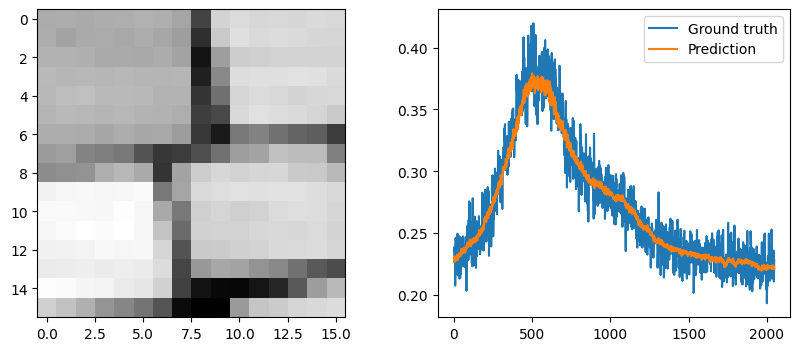

In [48]:
import matplotlib.pyplot as plt

k = 10

_, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
ax1.imshow(X_val[k], cmap='gray', label="Input image")
ax2.plot(y_val[k], label="Ground truth")
ax2.plot(prediction[k], label="Prediction")
plt.legend()